In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

import torchvision

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(1)
torch.manual_seed(1)

boston = load_boston(return_X_y=False)

X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, test_size=50, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=50, random_state=1)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).view(-1,1)

X_train_mean = X_train.mean(0)
X_train_std = X_train.std(0)
X_train_norm = X_train.add(-1, X_train_mean) / X_train_std


y_train_mean = torch.mean(y_train)
y_train_std = torch.std(y_train)
y_train_norm = y_train.add(-1, y_train_mean) / y_train_std

X_val = torch.FloatTensor(X_val)
y_val = torch.FloatTensor(y_val).view(-1,1)

X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).view(-1,1)

train_data = torch.utils.data.TensorDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, num_workers=0)

val_data = torch.utils.data.TensorDataset(X_val, y_val)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=50)

test_data = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=50)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

class Model(nn.Module):

    def __init__(self):
        super(Model, self).__init__()
        self.model = nn.Sequential(
                      nn.Linear(13, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50, 50, bias=True),
                      nn.SELU(),
                      nn.Linear(50,1, bias=True)
                    ).to(device)


    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.model(x)
        return x

In [4]:
class evaluation(object):
    def __init__(self, test_data, n_samples, X_mean=None, X_std=None, y_mean=None, y_std=None):
        self.test_data = test_data
        self.X_mean = X_mean
        self.X_std = X_std
        self.y_mean = y_mean
        self.y_std = y_std
        self.n = 0
        self.avg_prediction = 0.
        self.sum_pp = 0.
        self.sumsqr_pp = 0.
        self.preds = torch.zeros(len(test_data.dataset),n_samples)

    def fn(self, model):

        with torch.autograd.no_grad():
            self.n += 1
            for x, y in iter(self.test_data):
                x = x.view(x.size(0), -1)

                if (self.X_mean is not None) & (self.X_std is not None):
                    x = (x - self.X_mean).float() / self.X_std

                standard_pred = model(x)

                if (self.y_mean is not None) & (self.y_std is not None):
                    standard_pred = standard_pred * self.y_std + self.y_mean
                
                self.preds[:,self.n-1] = standard_pred.view(-1,)
                self.avg_prediction = self.avg_prediction * (self.n - 1.) / self.n + standard_pred.view(-1,1) / self.n
                self.sum_pp += standard_pred
                self.sumsqr_pp += standard_pred * standard_pred
                std_pred = torch.sqrt((self.sumsqr_pp - (self.sum_pp * self.sum_pp) / self.n) / (self.n - 1))



                norm = torch.distributions.normal.Normal(y, std_pred)
                test_ll = norm.log_prob(self.avg_prediction).mean()



                error = nn.MSELoss(size_average=True)
                rmse = error(self.avg_prediction, y) ** 0.5

                return rmse, test_ll, self.preds[:,self.n-1]

In [5]:
def gelman_rubin(x, return_var=False):
    m, n = x.size()

    var_between = torch.sum((torch.mean(x, 1) - torch.mean(x)) ** 2) / (m - 1)
    x_bar = torch.mean(x, 1).view(-1,1)

    var_within = torch.sum((x - x_bar) ** 2) / (m * (n - 1))

    var = var_within * (n - 1) / n + var_between

    if return_var:
        return var

    V = var_within + var_between / n

    return torch.sqrt(V / var_within)

def ess(x):
    m, n = x.size()
    
    s_sq = gelman_rubin(x, return_var = True)
    
    neg_autocorr = False
    t = 1
    
    variogram = lambda t: (sum(sum((x[j][i] - x[j][i-t]) ** 2 for i in range(t,n)) for j in range(m)) / (m * (n - t)))
    
    rho = torch.ones(n)
    
    while not neg_autocorr and (t < n):
        rho[t] = 1. - variogram(t) / (2. * s_sq)
        
        if not t % 2:
            neg_autocorr = sum(rho[(t-1):(t+1)]) < 0
        t += 1
        
    return float(m * n)/ (1. + 2. * rho[1:t].sum())

## SGLD

In [21]:
import torch
import torchvision
import os

from torch import nn
import torch.nn.functional as F
import numpy as np

import sgld

import model



np.random.seed(1)
torch.manual_seed(1)



lambda_ = 1.
#lr = 8e-7
#lr = 6e-6
#3e-2
# lr = 9e-7
# lr = 3e-6
lr = 9e-6



batch_size = 32.
dataset_size= 406.

n_samples = 300
n_chains = 10




ll_sgld = np.zeros((n_chains, n_samples))
rmse_sgld = np.zeros((n_chains, n_samples))
predictions_sgld = np.zeros((n_chains,n_samples,50))




for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = sgld.optim.sgld(network, lr, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()



            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse,ll,prediction = evaluate.fn(network)
                rmse_sgld[i,n] = rmse
                ll_sgld[i,n] = ll
                predictions_sgld[i,n,:] = prediction
                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 15.0056
chain 0 - epoch 1 - loss: 12.9202
chain 0 - epoch 2 - loss: 11.4713
chain 0 - epoch 3 - loss: 10.4988
chain 0 - epoch 4 - loss: 9.8152
chain 0 - epoch 5 - loss: 9.1337
chain 0 - epoch 6 - loss: 8.3915
chain 0 - epoch 7 - loss: 7.7212
chain 0 - epoch 8 - loss: 7.3872
chain 0 - epoch 9 - loss: 7.0362
chain 0 - epoch 10 - loss: 6.6855
chain 0 - epoch 11 - loss: 6.5987
chain 0 - epoch 12 - loss: 6.5098
chain 0 - epoch 13 - loss: 6.3042
chain 0 - epoch 14 - loss: 6.3115
chain 0 - epoch 15 - loss: 6.0057
chain 0 - epoch 16 - loss: 5.7776
chain 0 - epoch 17 - loss: 5.7114
chain 0 - epoch 18 - loss: 5.7022
chain 0 - epoch 19 - loss: 5.5481
chain 0 - epoch 20 - loss: 5.4564
chain 0 - epoch 21 - loss: 5.3590
chain 0 - epoch 22 - loss: 5.2154
chain 0 - epoch 23 - loss: 5.1993
chain 0 - epoch 24 - loss: 5.3297


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 25 - loss: 5.2538
chain 0 - epoch 26 - loss: 5.1994
chain 0 - epoch 27 - loss: 5.2840
chain 0 - epoch 28 - loss: 5.3388
chain 0 - epoch 29 - loss: 5.2460
chain 0 - epoch 30 - loss: 5.1734
chain 0 - epoch 31 - loss: 5.0522
chain 0 - epoch 32 - loss: 5.1890
chain 0 - epoch 33 - loss: 5.1796
chain 0 - epoch 34 - loss: 5.0351
chain 0 - epoch 35 - loss: 5.1246
chain 0 - epoch 36 - loss: 5.1784
chain 0 - epoch 37 - loss: 5.1402
chain 0 - epoch 38 - loss: 4.9671
chain 0 - epoch 39 - loss: 5.0203
chain 0 - epoch 40 - loss: 4.9644
chain 0 - epoch 41 - loss: 5.1208
chain 0 - epoch 42 - loss: 5.0962
chain 0 - epoch 43 - loss: 5.0388
chain 0 - epoch 44 - loss: 4.9345
chain 0 - epoch 45 - loss: 4.9220
chain 0 - epoch 46 - loss: 4.7645
chain 0 - epoch 47 - loss: 4.8462
chain 0 - epoch 48 - loss: 4.8521
chain 0 - epoch 49 - loss: 4.8377
chain 0 - epoch 50 - loss: 4.7428
chain 0 - epoch 51 - loss: 4.6289
chain 0 - epoch 52 - loss: 4.6125
chain 0 - epoch 53 - loss: 4.5875
chain 0 - epoc

chain 0 - epoch 262 - loss: 2.8543
chain 0 - epoch 263 - loss: 2.9893
chain 0 - epoch 264 - loss: 3.0080
chain 0 - epoch 265 - loss: 3.0091
chain 0 - epoch 266 - loss: 3.0531
chain 0 - epoch 267 - loss: 3.1692
chain 0 - epoch 268 - loss: 3.1563
chain 0 - epoch 269 - loss: 3.2086
chain 0 - epoch 270 - loss: 3.2680
chain 0 - epoch 271 - loss: 3.0701
chain 0 - epoch 272 - loss: 3.1019
chain 0 - epoch 273 - loss: 3.1667
chain 0 - epoch 274 - loss: 3.2435
chain 0 - epoch 275 - loss: 3.0825
chain 0 - epoch 276 - loss: 3.1338
chain 0 - epoch 277 - loss: 3.0514
chain 0 - epoch 278 - loss: 2.9340
chain 0 - epoch 279 - loss: 2.8641
chain 0 - epoch 280 - loss: 3.0035
chain 0 - epoch 281 - loss: 3.0195
chain 0 - epoch 282 - loss: 2.9239
chain 0 - epoch 283 - loss: 3.0533
chain 0 - epoch 284 - loss: 2.8568
chain 0 - epoch 285 - loss: 2.9676
chain 0 - epoch 286 - loss: 2.8660
chain 0 - epoch 287 - loss: 2.9515
chain 0 - epoch 288 - loss: 2.9910
chain 0 - epoch 289 - loss: 2.8718
chain 0 - epoch 290 

chain 0 - epoch 503 - loss: 2.8007
chain 0 - epoch 504 - loss: 2.8871
chain 0 - epoch 505 - loss: 3.0688
chain 0 - epoch 506 - loss: 2.9052
chain 0 - epoch 507 - loss: 2.9649
chain 0 - epoch 508 - loss: 2.7549
chain 0 - epoch 509 - loss: 2.8543
chain 0 - epoch 510 - loss: 3.0233
chain 0 - epoch 511 - loss: 3.0349
chain 0 - epoch 512 - loss: 2.9864
chain 0 - epoch 513 - loss: 3.1129
chain 0 - epoch 514 - loss: 3.1133
chain 0 - epoch 515 - loss: 3.2498
chain 0 - epoch 516 - loss: 3.0614
chain 0 - epoch 517 - loss: 3.0506
chain 0 - epoch 518 - loss: 3.1148
chain 0 - epoch 519 - loss: 2.9544
chain 0 - epoch 520 - loss: 3.0368
chain 0 - epoch 521 - loss: 2.9296
chain 0 - epoch 522 - loss: 2.8813
chain 0 - epoch 523 - loss: 3.0960
chain 0 - epoch 524 - loss: 2.9859
chain 0 - epoch 525 - loss: 2.9947
chain 0 - epoch 526 - loss: 3.2194
chain 0 - epoch 527 - loss: 3.3328
chain 0 - epoch 528 - loss: 3.0820
chain 0 - epoch 529 - loss: 3.3639
chain 0 - epoch 530 - loss: 3.3712
chain 0 - epoch 531 

chain 0 - epoch 740 - loss: 2.9346
chain 0 - epoch 741 - loss: 3.0866
chain 0 - epoch 742 - loss: 2.9636
chain 0 - epoch 743 - loss: 2.8558
chain 0 - epoch 744 - loss: 3.1313
chain 0 - epoch 745 - loss: 3.0440
chain 0 - epoch 746 - loss: 3.1711
chain 0 - epoch 747 - loss: 3.2666
chain 0 - epoch 748 - loss: 2.8738
chain 0 - epoch 749 - loss: 2.8867
chain 0 - epoch 750 - loss: 3.0397
chain 0 - epoch 751 - loss: 2.9087
chain 0 - epoch 752 - loss: 3.0019
chain 0 - epoch 753 - loss: 3.0225
chain 0 - epoch 754 - loss: 3.1529
chain 0 - epoch 755 - loss: 3.2932
chain 0 - epoch 756 - loss: 2.8784
chain 0 - epoch 757 - loss: 3.1520
chain 0 - epoch 758 - loss: 3.1980
chain 0 - epoch 759 - loss: 3.2446
chain 0 - epoch 760 - loss: 3.3983
chain 0 - epoch 761 - loss: 3.3297
chain 0 - epoch 762 - loss: 3.1642
chain 0 - epoch 763 - loss: 2.9967
chain 0 - epoch 764 - loss: 2.9418
chain 0 - epoch 765 - loss: 3.0128
chain 0 - epoch 766 - loss: 3.3136
chain 0 - epoch 767 - loss: 3.0881
chain 0 - epoch 768 

chain 0 - epoch 975 - loss: 3.0570
chain 0 - epoch 976 - loss: 2.9932
chain 0 - epoch 977 - loss: 2.8694
chain 0 - epoch 978 - loss: 2.7848
chain 0 - epoch 979 - loss: 2.7528
chain 0 - epoch 980 - loss: 2.6968
chain 0 - epoch 981 - loss: 2.6459
chain 0 - epoch 982 - loss: 2.6506
chain 0 - epoch 983 - loss: 2.6562
chain 0 - epoch 984 - loss: 2.8196
chain 0 - epoch 985 - loss: 2.6759
chain 0 - epoch 986 - loss: 2.7393
chain 0 - epoch 987 - loss: 2.8706
chain 0 - epoch 988 - loss: 2.8610
chain 0 - epoch 989 - loss: 2.6439
chain 0 - epoch 990 - loss: 2.7511
chain 0 - epoch 991 - loss: 2.6369
chain 0 - epoch 992 - loss: 2.7379
chain 0 - epoch 993 - loss: 2.8131
chain 0 - epoch 994 - loss: 2.7561
chain 0 - epoch 995 - loss: 2.8460
chain 0 - epoch 996 - loss: 2.9353
chain 0 - epoch 997 - loss: 2.8589
chain 0 - epoch 998 - loss: 2.7915
chain 0 - epoch 999 - loss: 2.6549
chain 0 - epoch 1000 - loss: 2.5944
chain 0 - epoch 1001 - loss: 2.5230
chain 0 - epoch 1002 - loss: 2.7049
chain 0 - epoch 1

chain 0 - epoch 1204 - loss: 3.0748
chain 0 - epoch 1205 - loss: 3.0791
chain 0 - epoch 1206 - loss: 3.0863
chain 0 - epoch 1207 - loss: 3.0750
chain 0 - epoch 1208 - loss: 3.1132
chain 0 - epoch 1209 - loss: 2.9107
chain 0 - epoch 1210 - loss: 2.8990
chain 0 - epoch 1211 - loss: 3.0076
chain 0 - epoch 1212 - loss: 3.1381
chain 0 - epoch 1213 - loss: 3.0227
chain 0 - epoch 1214 - loss: 3.1492
chain 0 - epoch 1215 - loss: 3.0767
chain 0 - epoch 1216 - loss: 3.2536
chain 0 - epoch 1217 - loss: 3.1257
chain 0 - epoch 1218 - loss: 3.1068
chain 0 - epoch 1219 - loss: 3.0663
chain 0 - epoch 1220 - loss: 2.9329
chain 0 - epoch 1221 - loss: 2.9350
chain 0 - epoch 1222 - loss: 3.0612
chain 0 - epoch 1223 - loss: 3.3597
chain 0 - epoch 1224 - loss: 3.3491
chain 0 - epoch 1225 - loss: 3.3820
chain 0 - epoch 1226 - loss: 3.3575
chain 0 - epoch 1227 - loss: 3.2066
chain 0 - epoch 1228 - loss: 3.3190
chain 0 - epoch 1229 - loss: 3.4482
chain 0 - epoch 1230 - loss: 3.2979
chain 0 - epoch 1231 - loss:

chain 0 - epoch 1438 - loss: 3.6351
chain 0 - epoch 1439 - loss: 3.7489
chain 0 - epoch 1440 - loss: 3.6639
chain 0 - epoch 1441 - loss: 3.6055
chain 0 - epoch 1442 - loss: 3.6594
chain 0 - epoch 1443 - loss: 3.4804
chain 0 - epoch 1444 - loss: 3.5962
chain 0 - epoch 1445 - loss: 3.8848
chain 0 - epoch 1446 - loss: 3.7848
chain 0 - epoch 1447 - loss: 3.8521
chain 0 - epoch 1448 - loss: 3.6355
chain 0 - epoch 1449 - loss: 3.5559
chain 0 - epoch 1450 - loss: 3.4554
chain 0 - epoch 1451 - loss: 3.1992
chain 0 - epoch 1452 - loss: 2.9138
chain 0 - epoch 1453 - loss: 3.0237
chain 0 - epoch 1454 - loss: 2.8841
chain 0 - epoch 1455 - loss: 2.8949
chain 0 - epoch 1456 - loss: 2.9356
chain 0 - epoch 1457 - loss: 3.0601
chain 0 - epoch 1458 - loss: 3.1166
chain 0 - epoch 1459 - loss: 3.1404
chain 0 - epoch 1460 - loss: 3.2187
chain 0 - epoch 1461 - loss: 3.0229
chain 0 - epoch 1462 - loss: 2.8690
chain 0 - epoch 1463 - loss: 2.7658
chain 0 - epoch 1464 - loss: 2.4377
chain 0 - epoch 1465 - loss:

chain 0 - epoch 1669 - loss: 2.4769
chain 0 - epoch 1670 - loss: 2.5601
chain 0 - epoch 1671 - loss: 2.6037
chain 0 - epoch 1672 - loss: 2.4543
chain 0 - epoch 1673 - loss: 2.4747
chain 0 - epoch 1674 - loss: 2.6659
chain 0 - epoch 1675 - loss: 2.4250
chain 0 - epoch 1676 - loss: 2.3488
chain 0 - epoch 1677 - loss: 2.5271
chain 0 - epoch 1678 - loss: 2.5724
chain 0 - epoch 1679 - loss: 2.6852
chain 0 - epoch 1680 - loss: 2.8080
chain 0 - epoch 1681 - loss: 2.8396
chain 0 - epoch 1682 - loss: 2.6185
chain 0 - epoch 1683 - loss: 2.5474
chain 0 - epoch 1684 - loss: 2.6202
chain 0 - epoch 1685 - loss: 2.6343
chain 0 - epoch 1686 - loss: 2.6243
chain 0 - epoch 1687 - loss: 2.6319
chain 0 - epoch 1688 - loss: 2.5821
chain 0 - epoch 1689 - loss: 2.5076
chain 0 - epoch 1690 - loss: 2.5905
chain 0 - epoch 1691 - loss: 2.6417
chain 0 - epoch 1692 - loss: 2.6655
chain 0 - epoch 1693 - loss: 2.8154
chain 0 - epoch 1694 - loss: 2.7888
chain 0 - epoch 1695 - loss: 2.8002
chain 0 - epoch 1696 - loss:

chain 0 - epoch 1903 - loss: 2.4172
chain 0 - epoch 1904 - loss: 2.5652
chain 0 - epoch 1905 - loss: 2.6924
chain 0 - epoch 1906 - loss: 2.6406
chain 0 - epoch 1907 - loss: 2.7190
chain 0 - epoch 1908 - loss: 2.6246
chain 0 - epoch 1909 - loss: 2.7259
chain 0 - epoch 1910 - loss: 2.5524
chain 0 - epoch 1911 - loss: 2.6469
chain 0 - epoch 1912 - loss: 2.7285
chain 0 - epoch 1913 - loss: 2.6929
chain 0 - epoch 1914 - loss: 2.6008
chain 0 - epoch 1915 - loss: 2.8190
chain 0 - epoch 1916 - loss: 2.7556
chain 0 - epoch 1917 - loss: 2.8142
chain 0 - epoch 1918 - loss: 2.5792
chain 0 - epoch 1919 - loss: 2.5156
chain 0 - epoch 1920 - loss: 2.5560
chain 0 - epoch 1921 - loss: 2.4510
chain 0 - epoch 1922 - loss: 2.4842
chain 0 - epoch 1923 - loss: 2.5195
chain 0 - epoch 1924 - loss: 2.5001
chain 0 - epoch 1925 - loss: 2.6183
chain 0 - epoch 1926 - loss: 2.5212
chain 0 - epoch 1927 - loss: 2.6248
chain 0 - epoch 1928 - loss: 2.6703
chain 0 - epoch 1929 - loss: 2.5131
chain 0 - epoch 1930 - loss:

chain 0 - epoch 2138 - loss: 3.2738
chain 0 - epoch 2139 - loss: 3.0587
chain 0 - epoch 2140 - loss: 2.9437
chain 0 - epoch 2141 - loss: 3.0169
chain 0 - epoch 2142 - loss: 3.0305
chain 0 - epoch 2143 - loss: 3.1519
chain 0 - epoch 2144 - loss: 3.0516
chain 0 - epoch 2145 - loss: 2.8799
chain 0 - epoch 2146 - loss: 2.9887
chain 0 - epoch 2147 - loss: 3.1601
chain 0 - epoch 2148 - loss: 3.0287
chain 0 - epoch 2149 - loss: 2.9207
chain 0 - epoch 2150 - loss: 3.0296
chain 0 - epoch 2151 - loss: 3.0153
chain 0 - epoch 2152 - loss: 2.9148
chain 0 - epoch 2153 - loss: 2.8459
chain 0 - epoch 2154 - loss: 3.0124
chain 0 - epoch 2155 - loss: 3.0259
chain 0 - epoch 2156 - loss: 2.7770
chain 0 - epoch 2157 - loss: 2.6655
chain 0 - epoch 2158 - loss: 2.6385
chain 0 - epoch 2159 - loss: 2.6221
chain 0 - epoch 2160 - loss: 2.6043
chain 0 - epoch 2161 - loss: 2.6381
chain 0 - epoch 2162 - loss: 2.6219
chain 0 - epoch 2163 - loss: 2.7638
chain 0 - epoch 2164 - loss: 2.6020
chain 0 - epoch 2165 - loss:

chain 0 - epoch 2371 - loss: 3.1219
chain 0 - epoch 2372 - loss: 3.2328
chain 0 - epoch 2373 - loss: 3.1473
chain 0 - epoch 2374 - loss: 3.1782
chain 0 - epoch 2375 - loss: 3.1776
chain 0 - epoch 2376 - loss: 3.0611
chain 0 - epoch 2377 - loss: 3.0868
chain 0 - epoch 2378 - loss: 2.9912
chain 0 - epoch 2379 - loss: 2.9864
chain 0 - epoch 2380 - loss: 2.9382
chain 0 - epoch 2381 - loss: 3.1037
chain 0 - epoch 2382 - loss: 3.1890
chain 0 - epoch 2383 - loss: 3.1521
chain 0 - epoch 2384 - loss: 3.1666
chain 0 - epoch 2385 - loss: 3.1227
chain 0 - epoch 2386 - loss: 3.0317
chain 0 - epoch 2387 - loss: 3.0118
chain 0 - epoch 2388 - loss: 3.0155
chain 0 - epoch 2389 - loss: 2.9664
chain 0 - epoch 2390 - loss: 2.9709
chain 0 - epoch 2391 - loss: 3.1149
chain 0 - epoch 2392 - loss: 3.1634
chain 0 - epoch 2393 - loss: 3.4726
chain 0 - epoch 2394 - loss: 3.1478
chain 0 - epoch 2395 - loss: 3.1486
chain 0 - epoch 2396 - loss: 3.1067
chain 0 - epoch 2397 - loss: 3.1068
chain 0 - epoch 2398 - loss:

chain 1 - epoch 108 - loss: 3.7789
chain 1 - epoch 109 - loss: 3.8601
chain 1 - epoch 110 - loss: 3.8517
chain 1 - epoch 111 - loss: 3.8893
chain 1 - epoch 112 - loss: 3.9989
chain 1 - epoch 113 - loss: 3.8690
chain 1 - epoch 114 - loss: 3.9087
chain 1 - epoch 115 - loss: 3.7891
chain 1 - epoch 116 - loss: 3.8468
chain 1 - epoch 117 - loss: 3.9597
chain 1 - epoch 118 - loss: 3.8590
chain 1 - epoch 119 - loss: 3.8468
chain 1 - epoch 120 - loss: 3.8169
chain 1 - epoch 121 - loss: 3.6950
chain 1 - epoch 122 - loss: 3.5892
chain 1 - epoch 123 - loss: 3.5339
chain 1 - epoch 124 - loss: 3.5566
chain 1 - epoch 125 - loss: 3.5150
chain 1 - epoch 126 - loss: 3.5430
chain 1 - epoch 127 - loss: 3.5320
chain 1 - epoch 128 - loss: 3.6601
chain 1 - epoch 129 - loss: 3.6712
chain 1 - epoch 130 - loss: 3.5369
chain 1 - epoch 131 - loss: 3.7259
chain 1 - epoch 132 - loss: 3.6642
chain 1 - epoch 133 - loss: 3.7000
chain 1 - epoch 134 - loss: 3.5631
chain 1 - epoch 135 - loss: 3.6377
chain 1 - epoch 136 

chain 1 - epoch 352 - loss: 3.4748
chain 1 - epoch 353 - loss: 3.4271
chain 1 - epoch 354 - loss: 3.4227
chain 1 - epoch 355 - loss: 3.4069
chain 1 - epoch 356 - loss: 3.2482
chain 1 - epoch 357 - loss: 3.3106
chain 1 - epoch 358 - loss: 3.2941
chain 1 - epoch 359 - loss: 3.1135
chain 1 - epoch 360 - loss: 3.2456
chain 1 - epoch 361 - loss: 3.3492
chain 1 - epoch 362 - loss: 3.0953
chain 1 - epoch 363 - loss: 3.0637
chain 1 - epoch 364 - loss: 3.1761
chain 1 - epoch 365 - loss: 3.3074
chain 1 - epoch 366 - loss: 3.3975
chain 1 - epoch 367 - loss: 3.3777
chain 1 - epoch 368 - loss: 3.3169
chain 1 - epoch 369 - loss: 2.9980
chain 1 - epoch 370 - loss: 3.0660
chain 1 - epoch 371 - loss: 3.1590
chain 1 - epoch 372 - loss: 3.0476
chain 1 - epoch 373 - loss: 3.1406
chain 1 - epoch 374 - loss: 3.0381
chain 1 - epoch 375 - loss: 3.1789
chain 1 - epoch 376 - loss: 3.1324
chain 1 - epoch 377 - loss: 3.2818
chain 1 - epoch 378 - loss: 3.3859
chain 1 - epoch 379 - loss: 3.2846
chain 1 - epoch 380 

chain 1 - epoch 588 - loss: 2.8784
chain 1 - epoch 589 - loss: 2.9618
chain 1 - epoch 590 - loss: 3.0173
chain 1 - epoch 591 - loss: 2.7686
chain 1 - epoch 592 - loss: 2.9535
chain 1 - epoch 593 - loss: 3.0486
chain 1 - epoch 594 - loss: 3.1916
chain 1 - epoch 595 - loss: 3.1131
chain 1 - epoch 596 - loss: 2.9350
chain 1 - epoch 597 - loss: 3.0404
chain 1 - epoch 598 - loss: 3.2894
chain 1 - epoch 599 - loss: 3.1539
chain 1 - epoch 600 - loss: 3.2323
chain 1 - epoch 601 - loss: 3.1868
chain 1 - epoch 602 - loss: 3.3485
chain 1 - epoch 603 - loss: 3.4702
chain 1 - epoch 604 - loss: 3.4185
chain 1 - epoch 605 - loss: 3.4957
chain 1 - epoch 606 - loss: 3.3566
chain 1 - epoch 607 - loss: 3.4176
chain 1 - epoch 608 - loss: 3.4703
chain 1 - epoch 609 - loss: 3.6790
chain 1 - epoch 610 - loss: 3.4006
chain 1 - epoch 611 - loss: 3.6186
chain 1 - epoch 612 - loss: 3.5934
chain 1 - epoch 613 - loss: 3.6019
chain 1 - epoch 614 - loss: 3.6160
chain 1 - epoch 615 - loss: 3.8837
chain 1 - epoch 616 

chain 1 - epoch 824 - loss: 2.6182
chain 1 - epoch 825 - loss: 2.6658
chain 1 - epoch 826 - loss: 2.5610
chain 1 - epoch 827 - loss: 2.4952
chain 1 - epoch 828 - loss: 2.5774
chain 1 - epoch 829 - loss: 2.5265
chain 1 - epoch 830 - loss: 2.5895
chain 1 - epoch 831 - loss: 2.5946
chain 1 - epoch 832 - loss: 2.6164
chain 1 - epoch 833 - loss: 2.6512
chain 1 - epoch 834 - loss: 2.7053
chain 1 - epoch 835 - loss: 2.8131
chain 1 - epoch 836 - loss: 2.7531
chain 1 - epoch 837 - loss: 2.5927
chain 1 - epoch 838 - loss: 2.5928
chain 1 - epoch 839 - loss: 2.5774
chain 1 - epoch 840 - loss: 2.5665
chain 1 - epoch 841 - loss: 2.6469
chain 1 - epoch 842 - loss: 2.6391
chain 1 - epoch 843 - loss: 2.7487
chain 1 - epoch 844 - loss: 2.5381
chain 1 - epoch 845 - loss: 2.5738
chain 1 - epoch 846 - loss: 2.7979
chain 1 - epoch 847 - loss: 2.6093
chain 1 - epoch 848 - loss: 2.5681
chain 1 - epoch 849 - loss: 2.7798
chain 1 - epoch 850 - loss: 2.8218
chain 1 - epoch 851 - loss: 2.6209
chain 1 - epoch 852 

chain 1 - epoch 1063 - loss: 2.9609
chain 1 - epoch 1064 - loss: 2.9194
chain 1 - epoch 1065 - loss: 3.0149
chain 1 - epoch 1066 - loss: 3.0595
chain 1 - epoch 1067 - loss: 2.8870
chain 1 - epoch 1068 - loss: 2.9839
chain 1 - epoch 1069 - loss: 3.1111
chain 1 - epoch 1070 - loss: 3.2399
chain 1 - epoch 1071 - loss: 3.2229
chain 1 - epoch 1072 - loss: 3.3575
chain 1 - epoch 1073 - loss: 3.2721
chain 1 - epoch 1074 - loss: 3.1863
chain 1 - epoch 1075 - loss: 3.1088
chain 1 - epoch 1076 - loss: 3.1836
chain 1 - epoch 1077 - loss: 3.3973
chain 1 - epoch 1078 - loss: 3.2799
chain 1 - epoch 1079 - loss: 3.3170
chain 1 - epoch 1080 - loss: 3.3593
chain 1 - epoch 1081 - loss: 3.2435
chain 1 - epoch 1082 - loss: 3.1876
chain 1 - epoch 1083 - loss: 3.0832
chain 1 - epoch 1084 - loss: 3.0615
chain 1 - epoch 1085 - loss: 3.0860
chain 1 - epoch 1086 - loss: 3.0812
chain 1 - epoch 1087 - loss: 3.0961
chain 1 - epoch 1088 - loss: 2.9799
chain 1 - epoch 1089 - loss: 3.1617
chain 1 - epoch 1090 - loss:

chain 1 - epoch 1298 - loss: 2.7031
chain 1 - epoch 1299 - loss: 2.8521
chain 1 - epoch 1300 - loss: 2.8855
chain 1 - epoch 1301 - loss: 3.0978
chain 1 - epoch 1302 - loss: 3.0842
chain 1 - epoch 1303 - loss: 2.9081
chain 1 - epoch 1304 - loss: 2.9706
chain 1 - epoch 1305 - loss: 3.2161
chain 1 - epoch 1306 - loss: 3.0617
chain 1 - epoch 1307 - loss: 2.8195
chain 1 - epoch 1308 - loss: 2.7182
chain 1 - epoch 1309 - loss: 2.8432
chain 1 - epoch 1310 - loss: 2.7524
chain 1 - epoch 1311 - loss: 2.5283
chain 1 - epoch 1312 - loss: 2.5662
chain 1 - epoch 1313 - loss: 2.4538
chain 1 - epoch 1314 - loss: 2.5494
chain 1 - epoch 1315 - loss: 2.5207
chain 1 - epoch 1316 - loss: 2.6961
chain 1 - epoch 1317 - loss: 2.6079
chain 1 - epoch 1318 - loss: 2.7596
chain 1 - epoch 1319 - loss: 2.7338
chain 1 - epoch 1320 - loss: 2.6588
chain 1 - epoch 1321 - loss: 2.6378
chain 1 - epoch 1322 - loss: 2.7486
chain 1 - epoch 1323 - loss: 2.7111
chain 1 - epoch 1324 - loss: 2.6812
chain 1 - epoch 1325 - loss:

chain 1 - epoch 1529 - loss: 2.5040
chain 1 - epoch 1530 - loss: 2.7147
chain 1 - epoch 1531 - loss: 2.8340
chain 1 - epoch 1532 - loss: 2.7122
chain 1 - epoch 1533 - loss: 2.4859
chain 1 - epoch 1534 - loss: 2.5375
chain 1 - epoch 1535 - loss: 2.7267
chain 1 - epoch 1536 - loss: 2.7418
chain 1 - epoch 1537 - loss: 2.6471
chain 1 - epoch 1538 - loss: 2.4113
chain 1 - epoch 1539 - loss: 2.4065
chain 1 - epoch 1540 - loss: 2.4928
chain 1 - epoch 1541 - loss: 2.6842
chain 1 - epoch 1542 - loss: 2.6543
chain 1 - epoch 1543 - loss: 2.5231
chain 1 - epoch 1544 - loss: 2.4618
chain 1 - epoch 1545 - loss: 2.6490
chain 1 - epoch 1546 - loss: 2.4221
chain 1 - epoch 1547 - loss: 2.5272
chain 1 - epoch 1548 - loss: 2.6644
chain 1 - epoch 1549 - loss: 2.4928
chain 1 - epoch 1550 - loss: 2.4468
chain 1 - epoch 1551 - loss: 2.3278
chain 1 - epoch 1552 - loss: 2.3267
chain 1 - epoch 1553 - loss: 2.3220
chain 1 - epoch 1554 - loss: 2.4824
chain 1 - epoch 1555 - loss: 2.6334
chain 1 - epoch 1556 - loss:

chain 1 - epoch 1759 - loss: 2.9584
chain 1 - epoch 1760 - loss: 2.7714
chain 1 - epoch 1761 - loss: 2.7982
chain 1 - epoch 1762 - loss: 2.8368
chain 1 - epoch 1763 - loss: 2.7926
chain 1 - epoch 1764 - loss: 2.7259
chain 1 - epoch 1765 - loss: 2.7279
chain 1 - epoch 1766 - loss: 2.8595
chain 1 - epoch 1767 - loss: 2.7893
chain 1 - epoch 1768 - loss: 2.9453
chain 1 - epoch 1769 - loss: 2.7551
chain 1 - epoch 1770 - loss: 2.6533
chain 1 - epoch 1771 - loss: 2.6163
chain 1 - epoch 1772 - loss: 2.6771
chain 1 - epoch 1773 - loss: 2.6635
chain 1 - epoch 1774 - loss: 2.7738
chain 1 - epoch 1775 - loss: 2.6799
chain 1 - epoch 1776 - loss: 2.8470
chain 1 - epoch 1777 - loss: 2.8458
chain 1 - epoch 1778 - loss: 2.8906
chain 1 - epoch 1779 - loss: 2.7039
chain 1 - epoch 1780 - loss: 2.6982
chain 1 - epoch 1781 - loss: 2.7517
chain 1 - epoch 1782 - loss: 2.8563
chain 1 - epoch 1783 - loss: 2.8154
chain 1 - epoch 1784 - loss: 2.7839
chain 1 - epoch 1785 - loss: 2.8542
chain 1 - epoch 1786 - loss:

chain 1 - epoch 1990 - loss: 2.5310
chain 1 - epoch 1991 - loss: 2.4436
chain 1 - epoch 1992 - loss: 2.4558
chain 1 - epoch 1993 - loss: 2.5839
chain 1 - epoch 1994 - loss: 2.5929
chain 1 - epoch 1995 - loss: 2.6036
chain 1 - epoch 1996 - loss: 2.6068
chain 1 - epoch 1997 - loss: 2.7831
chain 1 - epoch 1998 - loss: 2.9257
chain 1 - epoch 1999 - loss: 2.7868
chain 1 - epoch 2000 - loss: 2.7592
chain 1 - epoch 2001 - loss: 2.9175
chain 1 - epoch 2002 - loss: 2.7671
chain 1 - epoch 2003 - loss: 2.6439
chain 1 - epoch 2004 - loss: 2.6551
chain 1 - epoch 2005 - loss: 2.8583
chain 1 - epoch 2006 - loss: 2.7462
chain 1 - epoch 2007 - loss: 2.6142
chain 1 - epoch 2008 - loss: 2.6202
chain 1 - epoch 2009 - loss: 2.6390
chain 1 - epoch 2010 - loss: 2.7651
chain 1 - epoch 2011 - loss: 2.6018
chain 1 - epoch 2012 - loss: 2.6612
chain 1 - epoch 2013 - loss: 2.6482
chain 1 - epoch 2014 - loss: 2.7291
chain 1 - epoch 2015 - loss: 2.7547
chain 1 - epoch 2016 - loss: 2.5100
chain 1 - epoch 2017 - loss:

chain 1 - epoch 2219 - loss: 2.6391
chain 1 - epoch 2220 - loss: 2.6844
chain 1 - epoch 2221 - loss: 2.7000
chain 1 - epoch 2222 - loss: 2.7517
chain 1 - epoch 2223 - loss: 2.6576
chain 1 - epoch 2224 - loss: 2.5094
chain 1 - epoch 2225 - loss: 2.5289
chain 1 - epoch 2226 - loss: 2.6844
chain 1 - epoch 2227 - loss: 2.5582
chain 1 - epoch 2228 - loss: 2.4421
chain 1 - epoch 2229 - loss: 2.6180
chain 1 - epoch 2230 - loss: 2.6350
chain 1 - epoch 2231 - loss: 2.8119
chain 1 - epoch 2232 - loss: 2.6718
chain 1 - epoch 2233 - loss: 2.8168
chain 1 - epoch 2234 - loss: 2.9431
chain 1 - epoch 2235 - loss: 2.9022
chain 1 - epoch 2236 - loss: 2.7498
chain 1 - epoch 2237 - loss: 2.7658
chain 1 - epoch 2238 - loss: 2.7891
chain 1 - epoch 2239 - loss: 2.7158
chain 1 - epoch 2240 - loss: 2.7917
chain 1 - epoch 2241 - loss: 2.7488
chain 1 - epoch 2242 - loss: 2.8478
chain 1 - epoch 2243 - loss: 2.8862
chain 1 - epoch 2244 - loss: 2.9239
chain 1 - epoch 2245 - loss: 3.0367
chain 1 - epoch 2246 - loss:

chain 1 - epoch 2453 - loss: 2.4546
chain 1 - epoch 2454 - loss: 2.4164
chain 1 - epoch 2455 - loss: 2.4591
chain 1 - epoch 2456 - loss: 2.5223
chain 1 - epoch 2457 - loss: 2.5502
chain 1 - epoch 2458 - loss: 2.4689
chain 1 - epoch 2459 - loss: 2.4565
chain 1 - epoch 2460 - loss: 2.4589
chain 1 - epoch 2461 - loss: 2.6493
chain 1 - epoch 2462 - loss: 2.6108
chain 1 - epoch 2463 - loss: 2.6740
chain 1 - epoch 2464 - loss: 2.5481
chain 1 - epoch 2465 - loss: 2.6019
chain 1 - epoch 2466 - loss: 2.5523
chain 1 - epoch 2467 - loss: 2.7614
chain 1 - epoch 2468 - loss: 2.8305
chain 1 - epoch 2469 - loss: 2.6953
chain 1 - epoch 2470 - loss: 2.7327
chain 1 - epoch 2471 - loss: 2.6620
chain 1 - epoch 2472 - loss: 2.7083
chain 1 - epoch 2473 - loss: 2.7480
chain 1 - epoch 2474 - loss: 2.7418
chain 1 - epoch 2475 - loss: 2.8732
chain 1 - epoch 2476 - loss: 2.8730
chain 1 - epoch 2477 - loss: 2.8012
chain 1 - epoch 2478 - loss: 2.9203
chain 1 - epoch 2479 - loss: 2.8982
chain 1 - epoch 2480 - loss:

chain 2 - epoch 196 - loss: 3.1220
chain 2 - epoch 197 - loss: 3.1873
chain 2 - epoch 198 - loss: 3.2113
chain 2 - epoch 199 - loss: 3.2436
chain 2 - epoch 200 - loss: 3.1841
chain 2 - epoch 201 - loss: 3.3052
chain 2 - epoch 202 - loss: 3.1701
chain 2 - epoch 203 - loss: 3.1990
chain 2 - epoch 204 - loss: 3.2548
chain 2 - epoch 205 - loss: 3.2145
chain 2 - epoch 206 - loss: 3.1157
chain 2 - epoch 207 - loss: 3.2133
chain 2 - epoch 208 - loss: 3.0553
chain 2 - epoch 209 - loss: 3.3407
chain 2 - epoch 210 - loss: 3.3725
chain 2 - epoch 211 - loss: 3.3185
chain 2 - epoch 212 - loss: 3.3977
chain 2 - epoch 213 - loss: 3.2700
chain 2 - epoch 214 - loss: 3.3563
chain 2 - epoch 215 - loss: 3.2993
chain 2 - epoch 216 - loss: 3.3791
chain 2 - epoch 217 - loss: 3.3726
chain 2 - epoch 218 - loss: 3.0981
chain 2 - epoch 219 - loss: 3.0716
chain 2 - epoch 220 - loss: 2.9828
chain 2 - epoch 221 - loss: 3.1668
chain 2 - epoch 222 - loss: 3.1882
chain 2 - epoch 223 - loss: 3.2612
chain 2 - epoch 224 

chain 2 - epoch 443 - loss: 2.6086
chain 2 - epoch 444 - loss: 2.8393
chain 2 - epoch 445 - loss: 2.6896
chain 2 - epoch 446 - loss: 2.7478
chain 2 - epoch 447 - loss: 2.9586
chain 2 - epoch 448 - loss: 3.0544
chain 2 - epoch 449 - loss: 2.8387
chain 2 - epoch 450 - loss: 2.7209
chain 2 - epoch 451 - loss: 2.8954
chain 2 - epoch 452 - loss: 2.7386
chain 2 - epoch 453 - loss: 2.7048
chain 2 - epoch 454 - loss: 2.5420
chain 2 - epoch 455 - loss: 2.6237
chain 2 - epoch 456 - loss: 2.6912
chain 2 - epoch 457 - loss: 2.4231
chain 2 - epoch 458 - loss: 2.5829
chain 2 - epoch 459 - loss: 2.6988
chain 2 - epoch 460 - loss: 2.4474
chain 2 - epoch 461 - loss: 2.3599
chain 2 - epoch 462 - loss: 2.3728
chain 2 - epoch 463 - loss: 2.5473
chain 2 - epoch 464 - loss: 2.4509
chain 2 - epoch 465 - loss: 2.4204
chain 2 - epoch 466 - loss: 2.7396
chain 2 - epoch 467 - loss: 2.7928
chain 2 - epoch 468 - loss: 2.4815
chain 2 - epoch 469 - loss: 2.5426
chain 2 - epoch 470 - loss: 2.5325
chain 2 - epoch 471 

chain 2 - epoch 685 - loss: 2.8850
chain 2 - epoch 686 - loss: 2.7955
chain 2 - epoch 687 - loss: 2.9168
chain 2 - epoch 688 - loss: 2.9588
chain 2 - epoch 689 - loss: 2.9937
chain 2 - epoch 690 - loss: 2.9841
chain 2 - epoch 691 - loss: 3.1071
chain 2 - epoch 692 - loss: 3.1506
chain 2 - epoch 693 - loss: 3.0940
chain 2 - epoch 694 - loss: 2.7976
chain 2 - epoch 695 - loss: 2.9386
chain 2 - epoch 696 - loss: 2.9619
chain 2 - epoch 697 - loss: 3.1111
chain 2 - epoch 698 - loss: 2.8360
chain 2 - epoch 699 - loss: 2.8808
chain 2 - epoch 700 - loss: 2.9247
chain 2 - epoch 701 - loss: 3.2285
chain 2 - epoch 702 - loss: 3.3172
chain 2 - epoch 703 - loss: 3.2325
chain 2 - epoch 704 - loss: 3.2016
chain 2 - epoch 705 - loss: 3.4485
chain 2 - epoch 706 - loss: 3.6058
chain 2 - epoch 707 - loss: 3.3770
chain 2 - epoch 708 - loss: 3.4482
chain 2 - epoch 709 - loss: 3.1140
chain 2 - epoch 710 - loss: 2.9879
chain 2 - epoch 711 - loss: 3.0737
chain 2 - epoch 712 - loss: 2.9738
chain 2 - epoch 713 

chain 2 - epoch 931 - loss: 3.6115
chain 2 - epoch 932 - loss: 3.8504
chain 2 - epoch 933 - loss: 3.8295
chain 2 - epoch 934 - loss: 3.8824
chain 2 - epoch 935 - loss: 3.7213
chain 2 - epoch 936 - loss: 3.5839
chain 2 - epoch 937 - loss: 3.4359
chain 2 - epoch 938 - loss: 3.5259
chain 2 - epoch 939 - loss: 3.6059
chain 2 - epoch 940 - loss: 3.4679
chain 2 - epoch 941 - loss: 3.3992
chain 2 - epoch 942 - loss: 3.6438
chain 2 - epoch 943 - loss: 3.6027
chain 2 - epoch 944 - loss: 3.3013
chain 2 - epoch 945 - loss: 3.5376
chain 2 - epoch 946 - loss: 3.6984
chain 2 - epoch 947 - loss: 3.5420
chain 2 - epoch 948 - loss: 3.6123
chain 2 - epoch 949 - loss: 3.4925
chain 2 - epoch 950 - loss: 3.6815
chain 2 - epoch 951 - loss: 3.3325
chain 2 - epoch 952 - loss: 3.2754
chain 2 - epoch 953 - loss: 3.6150
chain 2 - epoch 954 - loss: 3.6448
chain 2 - epoch 955 - loss: 3.6976
chain 2 - epoch 956 - loss: 3.7626
chain 2 - epoch 957 - loss: 3.6277
chain 2 - epoch 958 - loss: 3.6463
chain 2 - epoch 959 

chain 2 - epoch 1167 - loss: 3.0329
chain 2 - epoch 1168 - loss: 2.9043
chain 2 - epoch 1169 - loss: 2.8262
chain 2 - epoch 1170 - loss: 2.9885
chain 2 - epoch 1171 - loss: 2.7367
chain 2 - epoch 1172 - loss: 2.7008
chain 2 - epoch 1173 - loss: 2.8291
chain 2 - epoch 1174 - loss: 2.8761
chain 2 - epoch 1175 - loss: 3.0697
chain 2 - epoch 1176 - loss: 3.0471
chain 2 - epoch 1177 - loss: 2.8953
chain 2 - epoch 1178 - loss: 2.8075
chain 2 - epoch 1179 - loss: 3.0927
chain 2 - epoch 1180 - loss: 3.0200
chain 2 - epoch 1181 - loss: 2.7743
chain 2 - epoch 1182 - loss: 2.9525
chain 2 - epoch 1183 - loss: 2.7724
chain 2 - epoch 1184 - loss: 2.9396
chain 2 - epoch 1185 - loss: 2.9680
chain 2 - epoch 1186 - loss: 2.9802
chain 2 - epoch 1187 - loss: 2.9854
chain 2 - epoch 1188 - loss: 3.1438
chain 2 - epoch 1189 - loss: 3.3898
chain 2 - epoch 1190 - loss: 3.1393
chain 2 - epoch 1191 - loss: 3.0008
chain 2 - epoch 1192 - loss: 3.0121
chain 2 - epoch 1193 - loss: 2.8954
chain 2 - epoch 1194 - loss:

chain 2 - epoch 1395 - loss: 2.8829
chain 2 - epoch 1396 - loss: 2.9452
chain 2 - epoch 1397 - loss: 2.9883
chain 2 - epoch 1398 - loss: 3.1006
chain 2 - epoch 1399 - loss: 2.8989
chain 2 - epoch 1400 - loss: 3.1909
chain 2 - epoch 1401 - loss: 3.2830
chain 2 - epoch 1402 - loss: 3.1319
chain 2 - epoch 1403 - loss: 3.1187
chain 2 - epoch 1404 - loss: 3.2796
chain 2 - epoch 1405 - loss: 3.2134
chain 2 - epoch 1406 - loss: 3.1105
chain 2 - epoch 1407 - loss: 3.0003
chain 2 - epoch 1408 - loss: 3.1836
chain 2 - epoch 1409 - loss: 2.9117
chain 2 - epoch 1410 - loss: 2.8335
chain 2 - epoch 1411 - loss: 3.1433
chain 2 - epoch 1412 - loss: 3.0965
chain 2 - epoch 1413 - loss: 3.0276
chain 2 - epoch 1414 - loss: 3.1507
chain 2 - epoch 1415 - loss: 3.3452
chain 2 - epoch 1416 - loss: 3.1084
chain 2 - epoch 1417 - loss: 3.2428
chain 2 - epoch 1418 - loss: 3.3367
chain 2 - epoch 1419 - loss: 3.0927
chain 2 - epoch 1420 - loss: 3.1754
chain 2 - epoch 1421 - loss: 3.1664
chain 2 - epoch 1422 - loss:

chain 2 - epoch 1624 - loss: 3.0564
chain 2 - epoch 1625 - loss: 3.1074
chain 2 - epoch 1626 - loss: 3.0387
chain 2 - epoch 1627 - loss: 3.0442
chain 2 - epoch 1628 - loss: 3.0047
chain 2 - epoch 1629 - loss: 2.9452
chain 2 - epoch 1630 - loss: 2.9572
chain 2 - epoch 1631 - loss: 2.9081
chain 2 - epoch 1632 - loss: 3.0879
chain 2 - epoch 1633 - loss: 2.9360
chain 2 - epoch 1634 - loss: 3.0414
chain 2 - epoch 1635 - loss: 3.1205
chain 2 - epoch 1636 - loss: 3.2363
chain 2 - epoch 1637 - loss: 3.0925
chain 2 - epoch 1638 - loss: 2.9445
chain 2 - epoch 1639 - loss: 2.9183
chain 2 - epoch 1640 - loss: 2.7501
chain 2 - epoch 1641 - loss: 2.9917
chain 2 - epoch 1642 - loss: 3.0828
chain 2 - epoch 1643 - loss: 2.9268
chain 2 - epoch 1644 - loss: 2.9281
chain 2 - epoch 1645 - loss: 2.9990
chain 2 - epoch 1646 - loss: 3.1367
chain 2 - epoch 1647 - loss: 3.1682
chain 2 - epoch 1648 - loss: 3.0354
chain 2 - epoch 1649 - loss: 2.9911
chain 2 - epoch 1650 - loss: 3.0035
chain 2 - epoch 1651 - loss:

chain 2 - epoch 1858 - loss: 2.7840
chain 2 - epoch 1859 - loss: 2.7164
chain 2 - epoch 1860 - loss: 2.7239
chain 2 - epoch 1861 - loss: 2.7593
chain 2 - epoch 1862 - loss: 2.8656
chain 2 - epoch 1863 - loss: 2.7089
chain 2 - epoch 1864 - loss: 2.7693
chain 2 - epoch 1865 - loss: 2.9424
chain 2 - epoch 1866 - loss: 2.8291
chain 2 - epoch 1867 - loss: 2.7335
chain 2 - epoch 1868 - loss: 2.8165
chain 2 - epoch 1869 - loss: 2.8974
chain 2 - epoch 1870 - loss: 2.9289
chain 2 - epoch 1871 - loss: 2.7433
chain 2 - epoch 1872 - loss: 2.7678
chain 2 - epoch 1873 - loss: 3.0255
chain 2 - epoch 1874 - loss: 2.9039
chain 2 - epoch 1875 - loss: 2.9193
chain 2 - epoch 1876 - loss: 3.0113
chain 2 - epoch 1877 - loss: 2.9282
chain 2 - epoch 1878 - loss: 2.8737
chain 2 - epoch 1879 - loss: 2.8234
chain 2 - epoch 1880 - loss: 2.7239
chain 2 - epoch 1881 - loss: 2.8313
chain 2 - epoch 1882 - loss: 2.9334
chain 2 - epoch 1883 - loss: 2.9231
chain 2 - epoch 1884 - loss: 3.0446
chain 2 - epoch 1885 - loss:

chain 2 - epoch 2090 - loss: 3.0840
chain 2 - epoch 2091 - loss: 3.1979
chain 2 - epoch 2092 - loss: 3.1721
chain 2 - epoch 2093 - loss: 3.0577
chain 2 - epoch 2094 - loss: 3.0114
chain 2 - epoch 2095 - loss: 3.1417
chain 2 - epoch 2096 - loss: 3.0104
chain 2 - epoch 2097 - loss: 3.2490
chain 2 - epoch 2098 - loss: 3.1147
chain 2 - epoch 2099 - loss: 3.0434
chain 2 - epoch 2100 - loss: 3.1109
chain 2 - epoch 2101 - loss: 3.1590
chain 2 - epoch 2102 - loss: 3.1538
chain 2 - epoch 2103 - loss: 3.1471
chain 2 - epoch 2104 - loss: 3.2058
chain 2 - epoch 2105 - loss: 3.2554
chain 2 - epoch 2106 - loss: 3.2228
chain 2 - epoch 2107 - loss: 3.1472
chain 2 - epoch 2108 - loss: 3.0897
chain 2 - epoch 2109 - loss: 3.0370
chain 2 - epoch 2110 - loss: 3.1025
chain 2 - epoch 2111 - loss: 3.1564
chain 2 - epoch 2112 - loss: 3.0619
chain 2 - epoch 2113 - loss: 3.2573
chain 2 - epoch 2114 - loss: 3.2421
chain 2 - epoch 2115 - loss: 3.2078
chain 2 - epoch 2116 - loss: 3.1812
chain 2 - epoch 2117 - loss:

chain 2 - epoch 2318 - loss: 3.0028
chain 2 - epoch 2319 - loss: 2.7561
chain 2 - epoch 2320 - loss: 2.8574
chain 2 - epoch 2321 - loss: 2.9122
chain 2 - epoch 2322 - loss: 2.7713
chain 2 - epoch 2323 - loss: 2.8443
chain 2 - epoch 2324 - loss: 2.9872
chain 2 - epoch 2325 - loss: 3.0811
chain 2 - epoch 2326 - loss: 3.0200
chain 2 - epoch 2327 - loss: 2.8709
chain 2 - epoch 2328 - loss: 2.8184
chain 2 - epoch 2329 - loss: 2.9798
chain 2 - epoch 2330 - loss: 2.8225
chain 2 - epoch 2331 - loss: 2.9498
chain 2 - epoch 2332 - loss: 2.8931
chain 2 - epoch 2333 - loss: 2.7981
chain 2 - epoch 2334 - loss: 2.8075
chain 2 - epoch 2335 - loss: 2.9018
chain 2 - epoch 2336 - loss: 2.8482
chain 2 - epoch 2337 - loss: 2.8855
chain 2 - epoch 2338 - loss: 2.8579
chain 2 - epoch 2339 - loss: 2.8097
chain 2 - epoch 2340 - loss: 2.8204
chain 2 - epoch 2341 - loss: 2.9833
chain 2 - epoch 2342 - loss: 2.9122
chain 2 - epoch 2343 - loss: 2.8548
chain 2 - epoch 2344 - loss: 2.9114
chain 2 - epoch 2345 - loss:

chain 3 - epoch 54 - loss: 4.7528
chain 3 - epoch 55 - loss: 4.8393
chain 3 - epoch 56 - loss: 4.6933
chain 3 - epoch 57 - loss: 4.6174
chain 3 - epoch 58 - loss: 4.5318
chain 3 - epoch 59 - loss: 4.5397
chain 3 - epoch 60 - loss: 4.6063
chain 3 - epoch 61 - loss: 4.6649
chain 3 - epoch 62 - loss: 4.5404
chain 3 - epoch 63 - loss: 4.5061
chain 3 - epoch 64 - loss: 4.4267
chain 3 - epoch 65 - loss: 4.4968
chain 3 - epoch 66 - loss: 4.4562
chain 3 - epoch 67 - loss: 4.4346
chain 3 - epoch 68 - loss: 4.4118
chain 3 - epoch 69 - loss: 4.5166
chain 3 - epoch 70 - loss: 4.5492
chain 3 - epoch 71 - loss: 4.4414
chain 3 - epoch 72 - loss: 4.4269
chain 3 - epoch 73 - loss: 4.4736
chain 3 - epoch 74 - loss: 4.4938
chain 3 - epoch 75 - loss: 4.2971
chain 3 - epoch 76 - loss: 4.1775
chain 3 - epoch 77 - loss: 4.2884
chain 3 - epoch 78 - loss: 4.2941
chain 3 - epoch 79 - loss: 4.3532
chain 3 - epoch 80 - loss: 4.2971
chain 3 - epoch 81 - loss: 4.2156
chain 3 - epoch 82 - loss: 4.1558
chain 3 - epoc

chain 3 - epoch 290 - loss: 2.6097
chain 3 - epoch 291 - loss: 2.6864
chain 3 - epoch 292 - loss: 2.7071
chain 3 - epoch 293 - loss: 2.5975
chain 3 - epoch 294 - loss: 2.6026
chain 3 - epoch 295 - loss: 2.5867
chain 3 - epoch 296 - loss: 2.6070
chain 3 - epoch 297 - loss: 2.7558
chain 3 - epoch 298 - loss: 2.5704
chain 3 - epoch 299 - loss: 2.4895
chain 3 - epoch 300 - loss: 2.6979
chain 3 - epoch 301 - loss: 2.5384
chain 3 - epoch 302 - loss: 2.6975
chain 3 - epoch 303 - loss: 2.6797
chain 3 - epoch 304 - loss: 2.5994
chain 3 - epoch 305 - loss: 2.7311
chain 3 - epoch 306 - loss: 2.6815
chain 3 - epoch 307 - loss: 2.7090
chain 3 - epoch 308 - loss: 2.7414
chain 3 - epoch 309 - loss: 2.6163
chain 3 - epoch 310 - loss: 2.6566
chain 3 - epoch 311 - loss: 2.7888
chain 3 - epoch 312 - loss: 2.9385
chain 3 - epoch 313 - loss: 3.0382
chain 3 - epoch 314 - loss: 2.9319
chain 3 - epoch 315 - loss: 2.8436
chain 3 - epoch 316 - loss: 2.6599
chain 3 - epoch 317 - loss: 2.5460
chain 3 - epoch 318 

chain 3 - epoch 528 - loss: 3.0958
chain 3 - epoch 529 - loss: 2.8789
chain 3 - epoch 530 - loss: 2.7951
chain 3 - epoch 531 - loss: 2.8498
chain 3 - epoch 532 - loss: 3.0325
chain 3 - epoch 533 - loss: 3.0185
chain 3 - epoch 534 - loss: 2.7034
chain 3 - epoch 535 - loss: 2.7857
chain 3 - epoch 536 - loss: 2.7787
chain 3 - epoch 537 - loss: 2.6903
chain 3 - epoch 538 - loss: 2.5770
chain 3 - epoch 539 - loss: 2.6598
chain 3 - epoch 540 - loss: 2.7973
chain 3 - epoch 541 - loss: 2.8530
chain 3 - epoch 542 - loss: 2.8827
chain 3 - epoch 543 - loss: 3.0042
chain 3 - epoch 544 - loss: 2.9494
chain 3 - epoch 545 - loss: 2.9386
chain 3 - epoch 546 - loss: 2.8088
chain 3 - epoch 547 - loss: 2.9496
chain 3 - epoch 548 - loss: 2.9451
chain 3 - epoch 549 - loss: 2.9387
chain 3 - epoch 550 - loss: 2.7763
chain 3 - epoch 551 - loss: 2.8394
chain 3 - epoch 552 - loss: 2.7338
chain 3 - epoch 553 - loss: 2.7773
chain 3 - epoch 554 - loss: 2.7090
chain 3 - epoch 555 - loss: 3.0006
chain 3 - epoch 556 

chain 3 - epoch 770 - loss: 3.1669
chain 3 - epoch 771 - loss: 3.0438
chain 3 - epoch 772 - loss: 2.9505
chain 3 - epoch 773 - loss: 3.1316
chain 3 - epoch 774 - loss: 3.1117
chain 3 - epoch 775 - loss: 2.9693
chain 3 - epoch 776 - loss: 3.1883
chain 3 - epoch 777 - loss: 2.9305
chain 3 - epoch 778 - loss: 2.9818
chain 3 - epoch 779 - loss: 2.8941
chain 3 - epoch 780 - loss: 2.8402
chain 3 - epoch 781 - loss: 3.2655
chain 3 - epoch 782 - loss: 3.1498
chain 3 - epoch 783 - loss: 3.0891
chain 3 - epoch 784 - loss: 2.9604
chain 3 - epoch 785 - loss: 3.3085
chain 3 - epoch 786 - loss: 3.1961
chain 3 - epoch 787 - loss: 3.1728
chain 3 - epoch 788 - loss: 2.9252
chain 3 - epoch 789 - loss: 3.1008
chain 3 - epoch 790 - loss: 3.2148
chain 3 - epoch 791 - loss: 2.9823
chain 3 - epoch 792 - loss: 2.8486
chain 3 - epoch 793 - loss: 2.9969
chain 3 - epoch 794 - loss: 3.1143
chain 3 - epoch 795 - loss: 2.7473
chain 3 - epoch 796 - loss: 2.8940
chain 3 - epoch 797 - loss: 2.9759
chain 3 - epoch 798 

chain 3 - epoch 1009 - loss: 2.5567
chain 3 - epoch 1010 - loss: 2.5808
chain 3 - epoch 1011 - loss: 2.4660
chain 3 - epoch 1012 - loss: 2.7557
chain 3 - epoch 1013 - loss: 2.7414
chain 3 - epoch 1014 - loss: 2.5239
chain 3 - epoch 1015 - loss: 2.6223
chain 3 - epoch 1016 - loss: 2.7137
chain 3 - epoch 1017 - loss: 2.7008
chain 3 - epoch 1018 - loss: 2.7437
chain 3 - epoch 1019 - loss: 2.9340
chain 3 - epoch 1020 - loss: 2.7745
chain 3 - epoch 1021 - loss: 2.7284
chain 3 - epoch 1022 - loss: 2.8182
chain 3 - epoch 1023 - loss: 2.8396
chain 3 - epoch 1024 - loss: 2.6276
chain 3 - epoch 1025 - loss: 2.7693
chain 3 - epoch 1026 - loss: 2.7447
chain 3 - epoch 1027 - loss: 2.7286
chain 3 - epoch 1028 - loss: 2.6095
chain 3 - epoch 1029 - loss: 2.5724
chain 3 - epoch 1030 - loss: 2.5618
chain 3 - epoch 1031 - loss: 2.8723
chain 3 - epoch 1032 - loss: 2.7201
chain 3 - epoch 1033 - loss: 2.7523
chain 3 - epoch 1034 - loss: 2.7573
chain 3 - epoch 1035 - loss: 2.7886
chain 3 - epoch 1036 - loss:

chain 3 - epoch 1240 - loss: 2.8504
chain 3 - epoch 1241 - loss: 2.7678
chain 3 - epoch 1242 - loss: 2.7347
chain 3 - epoch 1243 - loss: 2.7134
chain 3 - epoch 1244 - loss: 2.9692
chain 3 - epoch 1245 - loss: 2.7633
chain 3 - epoch 1246 - loss: 2.7571
chain 3 - epoch 1247 - loss: 2.6501
chain 3 - epoch 1248 - loss: 2.7756
chain 3 - epoch 1249 - loss: 2.9531
chain 3 - epoch 1250 - loss: 2.7990
chain 3 - epoch 1251 - loss: 2.9847
chain 3 - epoch 1252 - loss: 2.8333
chain 3 - epoch 1253 - loss: 2.9125
chain 3 - epoch 1254 - loss: 2.9623
chain 3 - epoch 1255 - loss: 3.0623
chain 3 - epoch 1256 - loss: 3.4188
chain 3 - epoch 1257 - loss: 3.1555
chain 3 - epoch 1258 - loss: 3.3645
chain 3 - epoch 1259 - loss: 3.6274
chain 3 - epoch 1260 - loss: 3.0903
chain 3 - epoch 1261 - loss: 2.9354
chain 3 - epoch 1262 - loss: 3.0279
chain 3 - epoch 1263 - loss: 3.1665
chain 3 - epoch 1264 - loss: 3.0605
chain 3 - epoch 1265 - loss: 3.1185
chain 3 - epoch 1266 - loss: 3.0271
chain 3 - epoch 1267 - loss:

chain 3 - epoch 1473 - loss: 3.3711
chain 3 - epoch 1474 - loss: 3.4539
chain 3 - epoch 1475 - loss: 3.2306
chain 3 - epoch 1476 - loss: 3.1998
chain 3 - epoch 1477 - loss: 3.1419
chain 3 - epoch 1478 - loss: 3.1900
chain 3 - epoch 1479 - loss: 3.4411
chain 3 - epoch 1480 - loss: 3.4026
chain 3 - epoch 1481 - loss: 3.4356
chain 3 - epoch 1482 - loss: 3.2390
chain 3 - epoch 1483 - loss: 3.3278
chain 3 - epoch 1484 - loss: 3.1033
chain 3 - epoch 1485 - loss: 3.1713
chain 3 - epoch 1486 - loss: 3.1439
chain 3 - epoch 1487 - loss: 3.1787
chain 3 - epoch 1488 - loss: 3.2882
chain 3 - epoch 1489 - loss: 3.1893
chain 3 - epoch 1490 - loss: 2.9958
chain 3 - epoch 1491 - loss: 3.1863
chain 3 - epoch 1492 - loss: 3.3739
chain 3 - epoch 1493 - loss: 3.3937
chain 3 - epoch 1494 - loss: 3.1719
chain 3 - epoch 1495 - loss: 3.2519
chain 3 - epoch 1496 - loss: 3.1201
chain 3 - epoch 1497 - loss: 3.2314
chain 3 - epoch 1498 - loss: 3.2654
chain 3 - epoch 1499 - loss: 3.3240
chain 3 - epoch 1500 - loss:

chain 3 - epoch 1709 - loss: 3.1385
chain 3 - epoch 1710 - loss: 2.9720
chain 3 - epoch 1711 - loss: 3.0091
chain 3 - epoch 1712 - loss: 3.0526
chain 3 - epoch 1713 - loss: 2.9852
chain 3 - epoch 1714 - loss: 2.9938
chain 3 - epoch 1715 - loss: 2.9824
chain 3 - epoch 1716 - loss: 2.9536
chain 3 - epoch 1717 - loss: 3.0269
chain 3 - epoch 1718 - loss: 2.9520
chain 3 - epoch 1719 - loss: 2.9129
chain 3 - epoch 1720 - loss: 2.7654
chain 3 - epoch 1721 - loss: 2.8545
chain 3 - epoch 1722 - loss: 2.8439
chain 3 - epoch 1723 - loss: 2.8996
chain 3 - epoch 1724 - loss: 3.1021
chain 3 - epoch 1725 - loss: 3.1985
chain 3 - epoch 1726 - loss: 3.0985
chain 3 - epoch 1727 - loss: 3.1548
chain 3 - epoch 1728 - loss: 2.9959
chain 3 - epoch 1729 - loss: 2.9863
chain 3 - epoch 1730 - loss: 2.8795
chain 3 - epoch 1731 - loss: 2.9278
chain 3 - epoch 1732 - loss: 2.8008
chain 3 - epoch 1733 - loss: 2.7019
chain 3 - epoch 1734 - loss: 2.8025
chain 3 - epoch 1735 - loss: 2.8222
chain 3 - epoch 1736 - loss:

chain 3 - epoch 1947 - loss: 2.4253
chain 3 - epoch 1948 - loss: 2.5013
chain 3 - epoch 1949 - loss: 2.4487
chain 3 - epoch 1950 - loss: 2.5681
chain 3 - epoch 1951 - loss: 2.4905
chain 3 - epoch 1952 - loss: 2.5336
chain 3 - epoch 1953 - loss: 2.3922
chain 3 - epoch 1954 - loss: 2.4183
chain 3 - epoch 1955 - loss: 2.4745
chain 3 - epoch 1956 - loss: 2.5514
chain 3 - epoch 1957 - loss: 2.5738
chain 3 - epoch 1958 - loss: 2.6249
chain 3 - epoch 1959 - loss: 2.5351
chain 3 - epoch 1960 - loss: 2.6104
chain 3 - epoch 1961 - loss: 2.5903
chain 3 - epoch 1962 - loss: 2.7130
chain 3 - epoch 1963 - loss: 2.5437
chain 3 - epoch 1964 - loss: 2.7230
chain 3 - epoch 1965 - loss: 2.6739
chain 3 - epoch 1966 - loss: 2.5798
chain 3 - epoch 1967 - loss: 2.7260
chain 3 - epoch 1968 - loss: 2.5177
chain 3 - epoch 1969 - loss: 2.8002
chain 3 - epoch 1970 - loss: 2.7736
chain 3 - epoch 1971 - loss: 2.7184
chain 3 - epoch 1972 - loss: 2.6311
chain 3 - epoch 1973 - loss: 2.6684
chain 3 - epoch 1974 - loss:

chain 3 - epoch 2183 - loss: 2.8034
chain 3 - epoch 2184 - loss: 2.7009
chain 3 - epoch 2185 - loss: 2.7724
chain 3 - epoch 2186 - loss: 2.7977
chain 3 - epoch 2187 - loss: 2.8920
chain 3 - epoch 2188 - loss: 2.7859
chain 3 - epoch 2189 - loss: 2.8894
chain 3 - epoch 2190 - loss: 2.8312
chain 3 - epoch 2191 - loss: 2.9262
chain 3 - epoch 2192 - loss: 2.9100
chain 3 - epoch 2193 - loss: 2.8854
chain 3 - epoch 2194 - loss: 2.7771
chain 3 - epoch 2195 - loss: 2.6394
chain 3 - epoch 2196 - loss: 2.6858
chain 3 - epoch 2197 - loss: 2.5665
chain 3 - epoch 2198 - loss: 2.7412
chain 3 - epoch 2199 - loss: 2.6645
chain 3 - epoch 2200 - loss: 2.4170
chain 3 - epoch 2201 - loss: 2.6327
chain 3 - epoch 2202 - loss: 2.6250
chain 3 - epoch 2203 - loss: 2.6848
chain 3 - epoch 2204 - loss: 2.7311
chain 3 - epoch 2205 - loss: 2.7669
chain 3 - epoch 2206 - loss: 2.7612
chain 3 - epoch 2207 - loss: 2.6596
chain 3 - epoch 2208 - loss: 2.5901
chain 3 - epoch 2209 - loss: 2.5186
chain 3 - epoch 2210 - loss:

chain 3 - epoch 2417 - loss: 2.8935
chain 3 - epoch 2418 - loss: 2.8274
chain 3 - epoch 2419 - loss: 2.8773
chain 3 - epoch 2420 - loss: 2.7354
chain 3 - epoch 2421 - loss: 2.8872
chain 3 - epoch 2422 - loss: 2.9682
chain 3 - epoch 2423 - loss: 2.9321
chain 3 - epoch 2424 - loss: 2.8467
chain 3 - epoch 2425 - loss: 2.7876
chain 3 - epoch 2426 - loss: 2.7455
chain 3 - epoch 2427 - loss: 2.8198
chain 3 - epoch 2428 - loss: 2.7968
chain 3 - epoch 2429 - loss: 2.8777
chain 3 - epoch 2430 - loss: 2.8749
chain 3 - epoch 2431 - loss: 2.8695
chain 3 - epoch 2432 - loss: 2.7117
chain 3 - epoch 2433 - loss: 2.6885
chain 3 - epoch 2434 - loss: 2.7694
chain 3 - epoch 2435 - loss: 2.7713
chain 3 - epoch 2436 - loss: 2.9118
chain 3 - epoch 2437 - loss: 2.8071
chain 3 - epoch 2438 - loss: 2.7256
chain 3 - epoch 2439 - loss: 2.7474
chain 3 - epoch 2440 - loss: 2.9060
chain 3 - epoch 2441 - loss: 2.8519
chain 3 - epoch 2442 - loss: 2.7745
chain 3 - epoch 2443 - loss: 2.7400
chain 3 - epoch 2444 - loss:

chain 4 - epoch 159 - loss: 3.2279
chain 4 - epoch 160 - loss: 3.2734
chain 4 - epoch 161 - loss: 3.2650
chain 4 - epoch 162 - loss: 3.2392
chain 4 - epoch 163 - loss: 3.1197
chain 4 - epoch 164 - loss: 3.1390
chain 4 - epoch 165 - loss: 3.1141
chain 4 - epoch 166 - loss: 3.1765
chain 4 - epoch 167 - loss: 3.2484
chain 4 - epoch 168 - loss: 3.3705
chain 4 - epoch 169 - loss: 3.3115
chain 4 - epoch 170 - loss: 3.2975
chain 4 - epoch 171 - loss: 3.3402
chain 4 - epoch 172 - loss: 3.3526
chain 4 - epoch 173 - loss: 3.2638
chain 4 - epoch 174 - loss: 3.4193
chain 4 - epoch 175 - loss: 3.1753
chain 4 - epoch 176 - loss: 3.1925
chain 4 - epoch 177 - loss: 3.0564
chain 4 - epoch 178 - loss: 3.0228
chain 4 - epoch 179 - loss: 3.0540
chain 4 - epoch 180 - loss: 3.1593
chain 4 - epoch 181 - loss: 3.2038
chain 4 - epoch 182 - loss: 3.2409
chain 4 - epoch 183 - loss: 3.2288
chain 4 - epoch 184 - loss: 3.0856
chain 4 - epoch 185 - loss: 3.0595
chain 4 - epoch 186 - loss: 3.0345
chain 4 - epoch 187 

chain 4 - epoch 399 - loss: 2.9685
chain 4 - epoch 400 - loss: 2.8102
chain 4 - epoch 401 - loss: 3.1470
chain 4 - epoch 402 - loss: 2.9791
chain 4 - epoch 403 - loss: 3.0401
chain 4 - epoch 404 - loss: 3.1160
chain 4 - epoch 405 - loss: 2.9669
chain 4 - epoch 406 - loss: 3.0367
chain 4 - epoch 407 - loss: 2.9205
chain 4 - epoch 408 - loss: 2.8736
chain 4 - epoch 409 - loss: 2.8274
chain 4 - epoch 410 - loss: 2.7751
chain 4 - epoch 411 - loss: 3.1135
chain 4 - epoch 412 - loss: 2.9073
chain 4 - epoch 413 - loss: 2.9226
chain 4 - epoch 414 - loss: 2.9654
chain 4 - epoch 415 - loss: 3.1702
chain 4 - epoch 416 - loss: 3.2303
chain 4 - epoch 417 - loss: 3.2878
chain 4 - epoch 418 - loss: 3.3162
chain 4 - epoch 419 - loss: 3.0890
chain 4 - epoch 420 - loss: 3.0025
chain 4 - epoch 421 - loss: 2.8290
chain 4 - epoch 422 - loss: 2.9625
chain 4 - epoch 423 - loss: 2.8508
chain 4 - epoch 424 - loss: 2.8795
chain 4 - epoch 425 - loss: 3.1334
chain 4 - epoch 426 - loss: 3.2098
chain 4 - epoch 427 

chain 4 - epoch 641 - loss: 3.4370
chain 4 - epoch 642 - loss: 3.3454
chain 4 - epoch 643 - loss: 3.4743
chain 4 - epoch 644 - loss: 3.2456
chain 4 - epoch 645 - loss: 3.1155
chain 4 - epoch 646 - loss: 3.1774
chain 4 - epoch 647 - loss: 3.0912
chain 4 - epoch 648 - loss: 3.1402
chain 4 - epoch 649 - loss: 3.2532
chain 4 - epoch 650 - loss: 3.3400
chain 4 - epoch 651 - loss: 3.2581
chain 4 - epoch 652 - loss: 3.1492
chain 4 - epoch 653 - loss: 3.2884
chain 4 - epoch 654 - loss: 3.0455
chain 4 - epoch 655 - loss: 3.0530
chain 4 - epoch 656 - loss: 3.0267
chain 4 - epoch 657 - loss: 3.3927
chain 4 - epoch 658 - loss: 3.4076
chain 4 - epoch 659 - loss: 3.2352
chain 4 - epoch 660 - loss: 3.4619
chain 4 - epoch 661 - loss: 3.3949
chain 4 - epoch 662 - loss: 3.3850
chain 4 - epoch 663 - loss: 3.4018
chain 4 - epoch 664 - loss: 3.4143
chain 4 - epoch 665 - loss: 3.4428
chain 4 - epoch 666 - loss: 3.4559
chain 4 - epoch 667 - loss: 3.3408
chain 4 - epoch 668 - loss: 3.3062
chain 4 - epoch 669 

chain 4 - epoch 879 - loss: 2.5922
chain 4 - epoch 880 - loss: 2.7019
chain 4 - epoch 881 - loss: 2.5877
chain 4 - epoch 882 - loss: 2.9057
chain 4 - epoch 883 - loss: 2.8602
chain 4 - epoch 884 - loss: 2.9125
chain 4 - epoch 885 - loss: 2.8132
chain 4 - epoch 886 - loss: 2.8742
chain 4 - epoch 887 - loss: 2.8795
chain 4 - epoch 888 - loss: 3.0934
chain 4 - epoch 889 - loss: 3.1308
chain 4 - epoch 890 - loss: 3.1805
chain 4 - epoch 891 - loss: 3.1477
chain 4 - epoch 892 - loss: 3.2888
chain 4 - epoch 893 - loss: 3.0243
chain 4 - epoch 894 - loss: 3.1098
chain 4 - epoch 895 - loss: 3.1171
chain 4 - epoch 896 - loss: 3.1448
chain 4 - epoch 897 - loss: 2.9902
chain 4 - epoch 898 - loss: 2.8975
chain 4 - epoch 899 - loss: 2.7752
chain 4 - epoch 900 - loss: 2.9699
chain 4 - epoch 901 - loss: 2.9496
chain 4 - epoch 902 - loss: 2.9867
chain 4 - epoch 903 - loss: 3.1107
chain 4 - epoch 904 - loss: 3.2014
chain 4 - epoch 905 - loss: 3.2259
chain 4 - epoch 906 - loss: 3.0545
chain 4 - epoch 907 

chain 4 - epoch 1111 - loss: 2.8728
chain 4 - epoch 1112 - loss: 2.8712
chain 4 - epoch 1113 - loss: 2.8197
chain 4 - epoch 1114 - loss: 2.9103
chain 4 - epoch 1115 - loss: 3.0242
chain 4 - epoch 1116 - loss: 3.1578
chain 4 - epoch 1117 - loss: 3.1181
chain 4 - epoch 1118 - loss: 3.3497
chain 4 - epoch 1119 - loss: 3.0995
chain 4 - epoch 1120 - loss: 3.1198
chain 4 - epoch 1121 - loss: 3.2018
chain 4 - epoch 1122 - loss: 3.3981
chain 4 - epoch 1123 - loss: 3.0904
chain 4 - epoch 1124 - loss: 3.2514
chain 4 - epoch 1125 - loss: 2.9953
chain 4 - epoch 1126 - loss: 2.9700
chain 4 - epoch 1127 - loss: 3.1453
chain 4 - epoch 1128 - loss: 2.9171
chain 4 - epoch 1129 - loss: 2.7885
chain 4 - epoch 1130 - loss: 2.7541
chain 4 - epoch 1131 - loss: 2.7846
chain 4 - epoch 1132 - loss: 2.6706
chain 4 - epoch 1133 - loss: 2.8725
chain 4 - epoch 1134 - loss: 3.0445
chain 4 - epoch 1135 - loss: 2.7997
chain 4 - epoch 1136 - loss: 2.8318
chain 4 - epoch 1137 - loss: 2.9774
chain 4 - epoch 1138 - loss:

chain 4 - epoch 1339 - loss: 2.9202
chain 4 - epoch 1340 - loss: 3.0302
chain 4 - epoch 1341 - loss: 3.1937
chain 4 - epoch 1342 - loss: 3.1328
chain 4 - epoch 1343 - loss: 3.0735
chain 4 - epoch 1344 - loss: 3.2112
chain 4 - epoch 1345 - loss: 3.3852
chain 4 - epoch 1346 - loss: 3.3614
chain 4 - epoch 1347 - loss: 3.3260
chain 4 - epoch 1348 - loss: 3.3445
chain 4 - epoch 1349 - loss: 3.4869
chain 4 - epoch 1350 - loss: 3.1825
chain 4 - epoch 1351 - loss: 3.1102
chain 4 - epoch 1352 - loss: 2.9487
chain 4 - epoch 1353 - loss: 2.8991
chain 4 - epoch 1354 - loss: 2.9088
chain 4 - epoch 1355 - loss: 3.0283
chain 4 - epoch 1356 - loss: 2.9856
chain 4 - epoch 1357 - loss: 3.1754
chain 4 - epoch 1358 - loss: 2.9378
chain 4 - epoch 1359 - loss: 2.8427
chain 4 - epoch 1360 - loss: 2.8255
chain 4 - epoch 1361 - loss: 2.8969
chain 4 - epoch 1362 - loss: 3.1031
chain 4 - epoch 1363 - loss: 3.1882
chain 4 - epoch 1364 - loss: 3.0437
chain 4 - epoch 1365 - loss: 3.2554
chain 4 - epoch 1366 - loss:

chain 4 - epoch 1571 - loss: 2.9163
chain 4 - epoch 1572 - loss: 2.8314
chain 4 - epoch 1573 - loss: 2.6947
chain 4 - epoch 1574 - loss: 2.6327
chain 4 - epoch 1575 - loss: 2.8051
chain 4 - epoch 1576 - loss: 2.6898
chain 4 - epoch 1577 - loss: 2.5414
chain 4 - epoch 1578 - loss: 2.4869
chain 4 - epoch 1579 - loss: 2.6958
chain 4 - epoch 1580 - loss: 2.4821
chain 4 - epoch 1581 - loss: 2.5873
chain 4 - epoch 1582 - loss: 2.4688
chain 4 - epoch 1583 - loss: 2.6931
chain 4 - epoch 1584 - loss: 2.5129
chain 4 - epoch 1585 - loss: 2.5279
chain 4 - epoch 1586 - loss: 2.6224
chain 4 - epoch 1587 - loss: 2.5301
chain 4 - epoch 1588 - loss: 2.7111
chain 4 - epoch 1589 - loss: 2.6902
chain 4 - epoch 1590 - loss: 2.5966
chain 4 - epoch 1591 - loss: 2.7451
chain 4 - epoch 1592 - loss: 2.7588
chain 4 - epoch 1593 - loss: 2.6782
chain 4 - epoch 1594 - loss: 2.7408
chain 4 - epoch 1595 - loss: 2.8208
chain 4 - epoch 1596 - loss: 2.8047
chain 4 - epoch 1597 - loss: 2.8769
chain 4 - epoch 1598 - loss:

chain 4 - epoch 1807 - loss: 2.5294
chain 4 - epoch 1808 - loss: 2.4502
chain 4 - epoch 1809 - loss: 2.4739
chain 4 - epoch 1810 - loss: 2.4554
chain 4 - epoch 1811 - loss: 2.5646
chain 4 - epoch 1812 - loss: 2.5616
chain 4 - epoch 1813 - loss: 2.5101
chain 4 - epoch 1814 - loss: 2.5133
chain 4 - epoch 1815 - loss: 2.5761
chain 4 - epoch 1816 - loss: 2.5842
chain 4 - epoch 1817 - loss: 2.7954
chain 4 - epoch 1818 - loss: 2.6125
chain 4 - epoch 1819 - loss: 2.5340
chain 4 - epoch 1820 - loss: 2.5268
chain 4 - epoch 1821 - loss: 2.4470
chain 4 - epoch 1822 - loss: 2.4940
chain 4 - epoch 1823 - loss: 2.5522
chain 4 - epoch 1824 - loss: 2.3756
chain 4 - epoch 1825 - loss: 2.4311
chain 4 - epoch 1826 - loss: 2.3647
chain 4 - epoch 1827 - loss: 2.3204
chain 4 - epoch 1828 - loss: 2.3976
chain 4 - epoch 1829 - loss: 2.3794
chain 4 - epoch 1830 - loss: 2.4238
chain 4 - epoch 1831 - loss: 2.7671
chain 4 - epoch 1832 - loss: 2.7374
chain 4 - epoch 1833 - loss: 2.6327
chain 4 - epoch 1834 - loss:

chain 4 - epoch 2037 - loss: 3.1546
chain 4 - epoch 2038 - loss: 3.2703
chain 4 - epoch 2039 - loss: 3.3492
chain 4 - epoch 2040 - loss: 3.1472
chain 4 - epoch 2041 - loss: 3.1851
chain 4 - epoch 2042 - loss: 3.1415
chain 4 - epoch 2043 - loss: 3.2031
chain 4 - epoch 2044 - loss: 3.0928
chain 4 - epoch 2045 - loss: 3.0506
chain 4 - epoch 2046 - loss: 3.2077
chain 4 - epoch 2047 - loss: 3.0558
chain 4 - epoch 2048 - loss: 2.9313
chain 4 - epoch 2049 - loss: 2.9292
chain 4 - epoch 2050 - loss: 2.9579
chain 4 - epoch 2051 - loss: 2.8780
chain 4 - epoch 2052 - loss: 3.0519
chain 4 - epoch 2053 - loss: 2.9268
chain 4 - epoch 2054 - loss: 3.1777
chain 4 - epoch 2055 - loss: 3.0487
chain 4 - epoch 2056 - loss: 3.1805
chain 4 - epoch 2057 - loss: 3.3379
chain 4 - epoch 2058 - loss: 3.1799
chain 4 - epoch 2059 - loss: 2.9662
chain 4 - epoch 2060 - loss: 3.0919
chain 4 - epoch 2061 - loss: 2.9241
chain 4 - epoch 2062 - loss: 3.0290
chain 4 - epoch 2063 - loss: 3.0250
chain 4 - epoch 2064 - loss:

chain 4 - epoch 2268 - loss: 3.0889
chain 4 - epoch 2269 - loss: 3.2458
chain 4 - epoch 2270 - loss: 3.0685
chain 4 - epoch 2271 - loss: 3.2131
chain 4 - epoch 2272 - loss: 3.1439
chain 4 - epoch 2273 - loss: 3.1732
chain 4 - epoch 2274 - loss: 3.3159
chain 4 - epoch 2275 - loss: 3.3476
chain 4 - epoch 2276 - loss: 3.3782
chain 4 - epoch 2277 - loss: 3.3271
chain 4 - epoch 2278 - loss: 3.1015
chain 4 - epoch 2279 - loss: 3.1747
chain 4 - epoch 2280 - loss: 3.0966
chain 4 - epoch 2281 - loss: 2.9617
chain 4 - epoch 2282 - loss: 3.0600
chain 4 - epoch 2283 - loss: 3.1951
chain 4 - epoch 2284 - loss: 3.0771
chain 4 - epoch 2285 - loss: 3.2026
chain 4 - epoch 2286 - loss: 3.2788
chain 4 - epoch 2287 - loss: 3.2974
chain 4 - epoch 2288 - loss: 3.3785
chain 4 - epoch 2289 - loss: 3.2331
chain 4 - epoch 2290 - loss: 3.2621
chain 4 - epoch 2291 - loss: 3.2946
chain 4 - epoch 2292 - loss: 3.3033
chain 4 - epoch 2293 - loss: 3.3994
chain 4 - epoch 2294 - loss: 3.3997
chain 4 - epoch 2295 - loss:

chain 5 - epoch 2 - loss: 10.7181
chain 5 - epoch 3 - loss: 9.6918
chain 5 - epoch 4 - loss: 8.8808
chain 5 - epoch 5 - loss: 8.4874
chain 5 - epoch 6 - loss: 8.1134
chain 5 - epoch 7 - loss: 7.9021
chain 5 - epoch 8 - loss: 7.6442
chain 5 - epoch 9 - loss: 7.3846
chain 5 - epoch 10 - loss: 7.1239
chain 5 - epoch 11 - loss: 6.7211
chain 5 - epoch 12 - loss: 6.4954
chain 5 - epoch 13 - loss: 6.2266
chain 5 - epoch 14 - loss: 5.9254
chain 5 - epoch 15 - loss: 5.8388
chain 5 - epoch 16 - loss: 5.8247
chain 5 - epoch 17 - loss: 5.7476
chain 5 - epoch 18 - loss: 5.6765
chain 5 - epoch 19 - loss: 5.5684
chain 5 - epoch 20 - loss: 5.5166
chain 5 - epoch 21 - loss: 5.4899
chain 5 - epoch 22 - loss: 5.4383
chain 5 - epoch 23 - loss: 5.3628
chain 5 - epoch 24 - loss: 5.3561
chain 5 - epoch 25 - loss: 5.4225
chain 5 - epoch 26 - loss: 5.2791
chain 5 - epoch 27 - loss: 5.2223
chain 5 - epoch 28 - loss: 5.1833
chain 5 - epoch 29 - loss: 5.2640
chain 5 - epoch 30 - loss: 5.1453
chain 5 - epoch 31 - 

chain 5 - epoch 244 - loss: 3.0411
chain 5 - epoch 245 - loss: 2.8692
chain 5 - epoch 246 - loss: 2.9063
chain 5 - epoch 247 - loss: 2.8924
chain 5 - epoch 248 - loss: 2.6615
chain 5 - epoch 249 - loss: 2.7536
chain 5 - epoch 250 - loss: 2.9059
chain 5 - epoch 251 - loss: 3.0378
chain 5 - epoch 252 - loss: 2.8867
chain 5 - epoch 253 - loss: 3.0290
chain 5 - epoch 254 - loss: 2.8697
chain 5 - epoch 255 - loss: 2.9336
chain 5 - epoch 256 - loss: 2.8569
chain 5 - epoch 257 - loss: 2.8780
chain 5 - epoch 258 - loss: 3.0986
chain 5 - epoch 259 - loss: 2.8824
chain 5 - epoch 260 - loss: 2.7103
chain 5 - epoch 261 - loss: 2.8135
chain 5 - epoch 262 - loss: 2.9843
chain 5 - epoch 263 - loss: 3.1084
chain 5 - epoch 264 - loss: 3.0469
chain 5 - epoch 265 - loss: 2.8018
chain 5 - epoch 266 - loss: 2.7873
chain 5 - epoch 267 - loss: 2.7854
chain 5 - epoch 268 - loss: 2.8619
chain 5 - epoch 269 - loss: 2.7225
chain 5 - epoch 270 - loss: 2.7140
chain 5 - epoch 271 - loss: 2.6377
chain 5 - epoch 272 

chain 5 - epoch 484 - loss: 2.6922
chain 5 - epoch 485 - loss: 2.7685
chain 5 - epoch 486 - loss: 2.7380
chain 5 - epoch 487 - loss: 2.8970
chain 5 - epoch 488 - loss: 2.8693
chain 5 - epoch 489 - loss: 2.9706
chain 5 - epoch 490 - loss: 2.6124
chain 5 - epoch 491 - loss: 2.5514
chain 5 - epoch 492 - loss: 2.7076
chain 5 - epoch 493 - loss: 2.6221
chain 5 - epoch 494 - loss: 2.5397
chain 5 - epoch 495 - loss: 2.7799
chain 5 - epoch 496 - loss: 2.7066
chain 5 - epoch 497 - loss: 2.5302
chain 5 - epoch 498 - loss: 2.6677
chain 5 - epoch 499 - loss: 2.6144
chain 5 - epoch 500 - loss: 2.7962
chain 5 - epoch 501 - loss: 2.7640
chain 5 - epoch 502 - loss: 2.7902
chain 5 - epoch 503 - loss: 2.7956
chain 5 - epoch 504 - loss: 3.0530
chain 5 - epoch 505 - loss: 2.9118
chain 5 - epoch 506 - loss: 2.8609
chain 5 - epoch 507 - loss: 2.9118
chain 5 - epoch 508 - loss: 2.7937
chain 5 - epoch 509 - loss: 2.9019
chain 5 - epoch 510 - loss: 2.7733
chain 5 - epoch 511 - loss: 2.8375
chain 5 - epoch 512 

chain 5 - epoch 721 - loss: 2.5135
chain 5 - epoch 722 - loss: 2.6138
chain 5 - epoch 723 - loss: 2.6074
chain 5 - epoch 724 - loss: 2.6766
chain 5 - epoch 725 - loss: 2.6245
chain 5 - epoch 726 - loss: 2.5949
chain 5 - epoch 727 - loss: 2.5912
chain 5 - epoch 728 - loss: 2.7750
chain 5 - epoch 729 - loss: 2.6379
chain 5 - epoch 730 - loss: 2.8778
chain 5 - epoch 731 - loss: 2.7160
chain 5 - epoch 732 - loss: 2.5568
chain 5 - epoch 733 - loss: 2.6724
chain 5 - epoch 734 - loss: 2.7352
chain 5 - epoch 735 - loss: 2.8172
chain 5 - epoch 736 - loss: 2.7413
chain 5 - epoch 737 - loss: 2.8675
chain 5 - epoch 738 - loss: 2.9223
chain 5 - epoch 739 - loss: 2.8159
chain 5 - epoch 740 - loss: 2.9868
chain 5 - epoch 741 - loss: 3.0118
chain 5 - epoch 742 - loss: 2.9033
chain 5 - epoch 743 - loss: 3.4732
chain 5 - epoch 744 - loss: 3.2077
chain 5 - epoch 745 - loss: 3.3217
chain 5 - epoch 746 - loss: 3.1862
chain 5 - epoch 747 - loss: 3.1567
chain 5 - epoch 748 - loss: 3.3513
chain 5 - epoch 749 

chain 5 - epoch 961 - loss: 3.0621
chain 5 - epoch 962 - loss: 2.9773
chain 5 - epoch 963 - loss: 3.0602
chain 5 - epoch 964 - loss: 3.1783
chain 5 - epoch 965 - loss: 3.3587
chain 5 - epoch 966 - loss: 3.2322
chain 5 - epoch 967 - loss: 3.1299
chain 5 - epoch 968 - loss: 3.0765
chain 5 - epoch 969 - loss: 2.8338
chain 5 - epoch 970 - loss: 3.0058
chain 5 - epoch 971 - loss: 2.9072
chain 5 - epoch 972 - loss: 3.0579
chain 5 - epoch 973 - loss: 2.9584
chain 5 - epoch 974 - loss: 3.0238
chain 5 - epoch 975 - loss: 2.9411
chain 5 - epoch 976 - loss: 2.9265
chain 5 - epoch 977 - loss: 2.8727
chain 5 - epoch 978 - loss: 2.8829
chain 5 - epoch 979 - loss: 3.0821
chain 5 - epoch 980 - loss: 3.0140
chain 5 - epoch 981 - loss: 3.1211
chain 5 - epoch 982 - loss: 3.0947
chain 5 - epoch 983 - loss: 3.0524
chain 5 - epoch 984 - loss: 3.0664
chain 5 - epoch 985 - loss: 2.9734
chain 5 - epoch 986 - loss: 3.0304
chain 5 - epoch 987 - loss: 3.2717
chain 5 - epoch 988 - loss: 2.9496
chain 5 - epoch 989 

chain 5 - epoch 1197 - loss: 3.2826
chain 5 - epoch 1198 - loss: 3.2041
chain 5 - epoch 1199 - loss: 2.9299
chain 5 - epoch 1200 - loss: 2.8742
chain 5 - epoch 1201 - loss: 2.8940
chain 5 - epoch 1202 - loss: 2.9438
chain 5 - epoch 1203 - loss: 2.9408
chain 5 - epoch 1204 - loss: 3.1565
chain 5 - epoch 1205 - loss: 3.1769
chain 5 - epoch 1206 - loss: 3.2890
chain 5 - epoch 1207 - loss: 3.3252
chain 5 - epoch 1208 - loss: 3.2037
chain 5 - epoch 1209 - loss: 3.1651
chain 5 - epoch 1210 - loss: 3.2540
chain 5 - epoch 1211 - loss: 3.1654
chain 5 - epoch 1212 - loss: 3.4171
chain 5 - epoch 1213 - loss: 3.2994
chain 5 - epoch 1214 - loss: 3.6584
chain 5 - epoch 1215 - loss: 3.6986
chain 5 - epoch 1216 - loss: 3.5231
chain 5 - epoch 1217 - loss: 3.1285
chain 5 - epoch 1218 - loss: 3.3713
chain 5 - epoch 1219 - loss: 3.2371
chain 5 - epoch 1220 - loss: 3.3018
chain 5 - epoch 1221 - loss: 3.0816
chain 5 - epoch 1222 - loss: 3.1567
chain 5 - epoch 1223 - loss: 3.1119
chain 5 - epoch 1224 - loss:

chain 5 - epoch 1428 - loss: 3.2266
chain 5 - epoch 1429 - loss: 2.9817
chain 5 - epoch 1430 - loss: 3.0261
chain 5 - epoch 1431 - loss: 3.1145
chain 5 - epoch 1432 - loss: 3.2942
chain 5 - epoch 1433 - loss: 3.3267
chain 5 - epoch 1434 - loss: 3.1726
chain 5 - epoch 1435 - loss: 3.1877
chain 5 - epoch 1436 - loss: 3.1146
chain 5 - epoch 1437 - loss: 2.9706
chain 5 - epoch 1438 - loss: 3.0629
chain 5 - epoch 1439 - loss: 3.1385
chain 5 - epoch 1440 - loss: 3.2188
chain 5 - epoch 1441 - loss: 3.4334
chain 5 - epoch 1442 - loss: 3.2463
chain 5 - epoch 1443 - loss: 3.3247
chain 5 - epoch 1444 - loss: 3.4865
chain 5 - epoch 1445 - loss: 3.2612
chain 5 - epoch 1446 - loss: 3.0825
chain 5 - epoch 1447 - loss: 3.1896
chain 5 - epoch 1448 - loss: 3.2838
chain 5 - epoch 1449 - loss: 3.0733
chain 5 - epoch 1450 - loss: 3.2260
chain 5 - epoch 1451 - loss: 3.2239
chain 5 - epoch 1452 - loss: 3.4739
chain 5 - epoch 1453 - loss: 3.5539
chain 5 - epoch 1454 - loss: 3.3419
chain 5 - epoch 1455 - loss:

chain 5 - epoch 1656 - loss: 2.8912
chain 5 - epoch 1657 - loss: 2.8788
chain 5 - epoch 1658 - loss: 2.8411
chain 5 - epoch 1659 - loss: 2.7110
chain 5 - epoch 1660 - loss: 2.7246
chain 5 - epoch 1661 - loss: 2.8503
chain 5 - epoch 1662 - loss: 2.8877
chain 5 - epoch 1663 - loss: 2.9402
chain 5 - epoch 1664 - loss: 2.9382
chain 5 - epoch 1665 - loss: 3.1094
chain 5 - epoch 1666 - loss: 2.9243
chain 5 - epoch 1667 - loss: 3.0056
chain 5 - epoch 1668 - loss: 2.9844
chain 5 - epoch 1669 - loss: 3.1485
chain 5 - epoch 1670 - loss: 2.9895
chain 5 - epoch 1671 - loss: 2.9136
chain 5 - epoch 1672 - loss: 3.0007
chain 5 - epoch 1673 - loss: 3.0368
chain 5 - epoch 1674 - loss: 3.1771
chain 5 - epoch 1675 - loss: 3.2320
chain 5 - epoch 1676 - loss: 3.2761
chain 5 - epoch 1677 - loss: 3.3685
chain 5 - epoch 1678 - loss: 3.3622
chain 5 - epoch 1679 - loss: 3.2271
chain 5 - epoch 1680 - loss: 3.3443
chain 5 - epoch 1681 - loss: 3.0359
chain 5 - epoch 1682 - loss: 3.1790
chain 5 - epoch 1683 - loss:

chain 5 - epoch 1884 - loss: 2.8874
chain 5 - epoch 1885 - loss: 2.8961
chain 5 - epoch 1886 - loss: 2.7777
chain 5 - epoch 1887 - loss: 2.8596
chain 5 - epoch 1888 - loss: 2.8593
chain 5 - epoch 1889 - loss: 2.9803
chain 5 - epoch 1890 - loss: 2.8817
chain 5 - epoch 1891 - loss: 2.8288
chain 5 - epoch 1892 - loss: 2.8792
chain 5 - epoch 1893 - loss: 2.8559
chain 5 - epoch 1894 - loss: 2.9545
chain 5 - epoch 1895 - loss: 3.0114
chain 5 - epoch 1896 - loss: 3.0994
chain 5 - epoch 1897 - loss: 3.0651
chain 5 - epoch 1898 - loss: 3.1047
chain 5 - epoch 1899 - loss: 3.0549
chain 5 - epoch 1900 - loss: 3.0245
chain 5 - epoch 1901 - loss: 2.8571
chain 5 - epoch 1902 - loss: 2.7725
chain 5 - epoch 1903 - loss: 2.8803
chain 5 - epoch 1904 - loss: 2.8844
chain 5 - epoch 1905 - loss: 3.1529
chain 5 - epoch 1906 - loss: 3.0477
chain 5 - epoch 1907 - loss: 2.9047
chain 5 - epoch 1908 - loss: 2.8953
chain 5 - epoch 1909 - loss: 2.8486
chain 5 - epoch 1910 - loss: 2.6750
chain 5 - epoch 1911 - loss:

chain 5 - epoch 2118 - loss: 2.8644
chain 5 - epoch 2119 - loss: 2.7780
chain 5 - epoch 2120 - loss: 2.7947
chain 5 - epoch 2121 - loss: 3.0561
chain 5 - epoch 2122 - loss: 2.9137
chain 5 - epoch 2123 - loss: 2.8166
chain 5 - epoch 2124 - loss: 2.8413
chain 5 - epoch 2125 - loss: 2.6913
chain 5 - epoch 2126 - loss: 2.9311
chain 5 - epoch 2127 - loss: 2.8782
chain 5 - epoch 2128 - loss: 2.7556
chain 5 - epoch 2129 - loss: 2.7426
chain 5 - epoch 2130 - loss: 2.6417
chain 5 - epoch 2131 - loss: 2.5475
chain 5 - epoch 2132 - loss: 2.6944
chain 5 - epoch 2133 - loss: 2.7768
chain 5 - epoch 2134 - loss: 2.6952
chain 5 - epoch 2135 - loss: 2.9165
chain 5 - epoch 2136 - loss: 2.9982
chain 5 - epoch 2137 - loss: 2.9478
chain 5 - epoch 2138 - loss: 2.9184
chain 5 - epoch 2139 - loss: 2.8901
chain 5 - epoch 2140 - loss: 2.6939
chain 5 - epoch 2141 - loss: 2.6650
chain 5 - epoch 2142 - loss: 2.4641
chain 5 - epoch 2143 - loss: 2.4720
chain 5 - epoch 2144 - loss: 2.4446
chain 5 - epoch 2145 - loss:

chain 5 - epoch 2352 - loss: 3.1046
chain 5 - epoch 2353 - loss: 3.1809
chain 5 - epoch 2354 - loss: 2.9820
chain 5 - epoch 2355 - loss: 3.0065
chain 5 - epoch 2356 - loss: 3.1521
chain 5 - epoch 2357 - loss: 3.3200
chain 5 - epoch 2358 - loss: 3.1766
chain 5 - epoch 2359 - loss: 3.2659
chain 5 - epoch 2360 - loss: 3.0367
chain 5 - epoch 2361 - loss: 3.0671
chain 5 - epoch 2362 - loss: 3.0313
chain 5 - epoch 2363 - loss: 3.0269
chain 5 - epoch 2364 - loss: 3.1459
chain 5 - epoch 2365 - loss: 3.1535
chain 5 - epoch 2366 - loss: 3.1786
chain 5 - epoch 2367 - loss: 3.2378
chain 5 - epoch 2368 - loss: 3.1621
chain 5 - epoch 2369 - loss: 3.2519
chain 5 - epoch 2370 - loss: 3.2106
chain 5 - epoch 2371 - loss: 3.2575
chain 5 - epoch 2372 - loss: 3.4266
chain 5 - epoch 2373 - loss: 3.5087
chain 5 - epoch 2374 - loss: 3.3103
chain 5 - epoch 2375 - loss: 3.1065
chain 5 - epoch 2376 - loss: 3.0605
chain 5 - epoch 2377 - loss: 3.0848
chain 5 - epoch 2378 - loss: 3.0911
chain 5 - epoch 2379 - loss:

chain 6 - epoch 85 - loss: 4.0917
chain 6 - epoch 86 - loss: 4.1148
chain 6 - epoch 87 - loss: 3.9890
chain 6 - epoch 88 - loss: 3.9580
chain 6 - epoch 89 - loss: 3.9024
chain 6 - epoch 90 - loss: 3.9378
chain 6 - epoch 91 - loss: 3.9198
chain 6 - epoch 92 - loss: 4.0142
chain 6 - epoch 93 - loss: 3.9489
chain 6 - epoch 94 - loss: 3.9923
chain 6 - epoch 95 - loss: 4.0140
chain 6 - epoch 96 - loss: 4.0056
chain 6 - epoch 97 - loss: 3.9609
chain 6 - epoch 98 - loss: 3.9347
chain 6 - epoch 99 - loss: 3.8569
chain 6 - epoch 100 - loss: 3.9170
chain 6 - epoch 101 - loss: 4.0045
chain 6 - epoch 102 - loss: 3.9359
chain 6 - epoch 103 - loss: 3.8979
chain 6 - epoch 104 - loss: 3.8836
chain 6 - epoch 105 - loss: 4.0345
chain 6 - epoch 106 - loss: 3.8184
chain 6 - epoch 107 - loss: 3.9043
chain 6 - epoch 108 - loss: 3.9871
chain 6 - epoch 109 - loss: 3.9554
chain 6 - epoch 110 - loss: 3.9547
chain 6 - epoch 111 - loss: 3.6818
chain 6 - epoch 112 - loss: 3.7366
chain 6 - epoch 113 - loss: 3.6608


chain 6 - epoch 325 - loss: 2.7439
chain 6 - epoch 326 - loss: 2.9614
chain 6 - epoch 327 - loss: 2.9041
chain 6 - epoch 328 - loss: 3.1834
chain 6 - epoch 329 - loss: 2.6550
chain 6 - epoch 330 - loss: 2.6234
chain 6 - epoch 331 - loss: 2.5664
chain 6 - epoch 332 - loss: 2.7370
chain 6 - epoch 333 - loss: 2.7478
chain 6 - epoch 334 - loss: 2.8898
chain 6 - epoch 335 - loss: 2.9438
chain 6 - epoch 336 - loss: 2.6006
chain 6 - epoch 337 - loss: 2.9748
chain 6 - epoch 338 - loss: 2.9865
chain 6 - epoch 339 - loss: 3.0644
chain 6 - epoch 340 - loss: 3.1021
chain 6 - epoch 341 - loss: 3.0585
chain 6 - epoch 342 - loss: 2.8671
chain 6 - epoch 343 - loss: 2.9685
chain 6 - epoch 344 - loss: 2.8855
chain 6 - epoch 345 - loss: 3.0073
chain 6 - epoch 346 - loss: 3.0970
chain 6 - epoch 347 - loss: 3.0223
chain 6 - epoch 348 - loss: 3.1717
chain 6 - epoch 349 - loss: 3.0259
chain 6 - epoch 350 - loss: 2.8159
chain 6 - epoch 351 - loss: 2.9638
chain 6 - epoch 352 - loss: 2.9119
chain 6 - epoch 353 

chain 6 - epoch 567 - loss: 3.1524
chain 6 - epoch 568 - loss: 3.0676
chain 6 - epoch 569 - loss: 2.9428
chain 6 - epoch 570 - loss: 2.8668
chain 6 - epoch 571 - loss: 2.9157
chain 6 - epoch 572 - loss: 2.8958
chain 6 - epoch 573 - loss: 3.2266
chain 6 - epoch 574 - loss: 3.0711
chain 6 - epoch 575 - loss: 3.0388
chain 6 - epoch 576 - loss: 3.0583
chain 6 - epoch 577 - loss: 3.0525
chain 6 - epoch 578 - loss: 3.2312
chain 6 - epoch 579 - loss: 3.2403
chain 6 - epoch 580 - loss: 3.1861
chain 6 - epoch 581 - loss: 3.0215
chain 6 - epoch 582 - loss: 3.1115
chain 6 - epoch 583 - loss: 3.3118
chain 6 - epoch 584 - loss: 3.0784
chain 6 - epoch 585 - loss: 3.0985
chain 6 - epoch 586 - loss: 3.3654
chain 6 - epoch 587 - loss: 3.3657
chain 6 - epoch 588 - loss: 3.3641
chain 6 - epoch 589 - loss: 3.2190
chain 6 - epoch 590 - loss: 3.1501
chain 6 - epoch 591 - loss: 3.0458
chain 6 - epoch 592 - loss: 3.2607
chain 6 - epoch 593 - loss: 3.1868
chain 6 - epoch 594 - loss: 3.1896
chain 6 - epoch 595 

chain 6 - epoch 803 - loss: 2.7750
chain 6 - epoch 804 - loss: 2.8353
chain 6 - epoch 805 - loss: 2.7145
chain 6 - epoch 806 - loss: 2.7333
chain 6 - epoch 807 - loss: 2.6686
chain 6 - epoch 808 - loss: 2.7601
chain 6 - epoch 809 - loss: 3.0107
chain 6 - epoch 810 - loss: 2.9479
chain 6 - epoch 811 - loss: 2.7442
chain 6 - epoch 812 - loss: 2.6315
chain 6 - epoch 813 - loss: 2.5638
chain 6 - epoch 814 - loss: 2.5693
chain 6 - epoch 815 - loss: 2.6593
chain 6 - epoch 816 - loss: 2.4518
chain 6 - epoch 817 - loss: 2.4750
chain 6 - epoch 818 - loss: 2.6395
chain 6 - epoch 819 - loss: 2.6798
chain 6 - epoch 820 - loss: 2.6475
chain 6 - epoch 821 - loss: 2.4908
chain 6 - epoch 822 - loss: 2.3126
chain 6 - epoch 823 - loss: 2.4585
chain 6 - epoch 824 - loss: 2.5485
chain 6 - epoch 825 - loss: 2.5841
chain 6 - epoch 826 - loss: 2.4921
chain 6 - epoch 827 - loss: 2.6022
chain 6 - epoch 828 - loss: 2.6017
chain 6 - epoch 829 - loss: 2.5447
chain 6 - epoch 830 - loss: 2.4528
chain 6 - epoch 831 

chain 6 - epoch 1037 - loss: 2.7975
chain 6 - epoch 1038 - loss: 2.8592
chain 6 - epoch 1039 - loss: 2.8401
chain 6 - epoch 1040 - loss: 2.9793
chain 6 - epoch 1041 - loss: 2.9317
chain 6 - epoch 1042 - loss: 2.8364
chain 6 - epoch 1043 - loss: 3.0393
chain 6 - epoch 1044 - loss: 2.9063
chain 6 - epoch 1045 - loss: 2.9355
chain 6 - epoch 1046 - loss: 2.9203
chain 6 - epoch 1047 - loss: 3.0516
chain 6 - epoch 1048 - loss: 3.0452
chain 6 - epoch 1049 - loss: 2.9068
chain 6 - epoch 1050 - loss: 3.0461
chain 6 - epoch 1051 - loss: 2.7552
chain 6 - epoch 1052 - loss: 2.8819
chain 6 - epoch 1053 - loss: 2.8476
chain 6 - epoch 1054 - loss: 2.8382
chain 6 - epoch 1055 - loss: 2.8022
chain 6 - epoch 1056 - loss: 2.8717
chain 6 - epoch 1057 - loss: 2.8788
chain 6 - epoch 1058 - loss: 3.0155
chain 6 - epoch 1059 - loss: 2.8294
chain 6 - epoch 1060 - loss: 2.7324
chain 6 - epoch 1061 - loss: 2.6787
chain 6 - epoch 1062 - loss: 2.7519
chain 6 - epoch 1063 - loss: 3.0301
chain 6 - epoch 1064 - loss:

chain 6 - epoch 1265 - loss: 2.7496
chain 6 - epoch 1266 - loss: 2.8335
chain 6 - epoch 1267 - loss: 2.6382
chain 6 - epoch 1268 - loss: 2.5773
chain 6 - epoch 1269 - loss: 2.7044
chain 6 - epoch 1270 - loss: 2.7887
chain 6 - epoch 1271 - loss: 2.7617
chain 6 - epoch 1272 - loss: 2.9626
chain 6 - epoch 1273 - loss: 2.9162
chain 6 - epoch 1274 - loss: 2.8903
chain 6 - epoch 1275 - loss: 2.8541
chain 6 - epoch 1276 - loss: 2.9789
chain 6 - epoch 1277 - loss: 2.9455
chain 6 - epoch 1278 - loss: 2.6886
chain 6 - epoch 1279 - loss: 2.9265
chain 6 - epoch 1280 - loss: 2.9238
chain 6 - epoch 1281 - loss: 2.9909
chain 6 - epoch 1282 - loss: 2.7972
chain 6 - epoch 1283 - loss: 2.9358
chain 6 - epoch 1284 - loss: 2.7930
chain 6 - epoch 1285 - loss: 2.8232
chain 6 - epoch 1286 - loss: 2.6629
chain 6 - epoch 1287 - loss: 2.5798
chain 6 - epoch 1288 - loss: 2.5744
chain 6 - epoch 1289 - loss: 2.6022
chain 6 - epoch 1290 - loss: 2.6917
chain 6 - epoch 1291 - loss: 2.7061
chain 6 - epoch 1292 - loss:

chain 6 - epoch 1502 - loss: 2.8617
chain 6 - epoch 1503 - loss: 2.8654
chain 6 - epoch 1504 - loss: 2.8837
chain 6 - epoch 1505 - loss: 2.9547
chain 6 - epoch 1506 - loss: 2.9332
chain 6 - epoch 1507 - loss: 2.8440
chain 6 - epoch 1508 - loss: 2.8340
chain 6 - epoch 1509 - loss: 3.0668
chain 6 - epoch 1510 - loss: 2.8948
chain 6 - epoch 1511 - loss: 3.2649
chain 6 - epoch 1512 - loss: 3.1634
chain 6 - epoch 1513 - loss: 3.0528
chain 6 - epoch 1514 - loss: 2.8090
chain 6 - epoch 1515 - loss: 2.8821
chain 6 - epoch 1516 - loss: 2.9072
chain 6 - epoch 1517 - loss: 2.8687
chain 6 - epoch 1518 - loss: 2.9760
chain 6 - epoch 1519 - loss: 2.8676
chain 6 - epoch 1520 - loss: 2.9754
chain 6 - epoch 1521 - loss: 2.8772
chain 6 - epoch 1522 - loss: 2.9197
chain 6 - epoch 1523 - loss: 3.0767
chain 6 - epoch 1524 - loss: 3.1138
chain 6 - epoch 1525 - loss: 3.0212
chain 6 - epoch 1526 - loss: 3.2657
chain 6 - epoch 1527 - loss: 3.0765
chain 6 - epoch 1528 - loss: 2.8859
chain 6 - epoch 1529 - loss:

chain 6 - epoch 1730 - loss: 2.8573
chain 6 - epoch 1731 - loss: 2.8695
chain 6 - epoch 1732 - loss: 2.8937
chain 6 - epoch 1733 - loss: 2.8650
chain 6 - epoch 1734 - loss: 2.8389
chain 6 - epoch 1735 - loss: 2.9329
chain 6 - epoch 1736 - loss: 2.9999
chain 6 - epoch 1737 - loss: 2.9154
chain 6 - epoch 1738 - loss: 2.8996
chain 6 - epoch 1739 - loss: 2.9957
chain 6 - epoch 1740 - loss: 2.9556
chain 6 - epoch 1741 - loss: 3.0504
chain 6 - epoch 1742 - loss: 3.0981
chain 6 - epoch 1743 - loss: 3.0693
chain 6 - epoch 1744 - loss: 3.0059
chain 6 - epoch 1745 - loss: 2.9359
chain 6 - epoch 1746 - loss: 3.0465
chain 6 - epoch 1747 - loss: 3.2059
chain 6 - epoch 1748 - loss: 2.9378
chain 6 - epoch 1749 - loss: 3.0796
chain 6 - epoch 1750 - loss: 3.2270
chain 6 - epoch 1751 - loss: 3.0157
chain 6 - epoch 1752 - loss: 3.0044
chain 6 - epoch 1753 - loss: 3.0378
chain 6 - epoch 1754 - loss: 3.0574
chain 6 - epoch 1755 - loss: 3.2433
chain 6 - epoch 1756 - loss: 3.2326
chain 6 - epoch 1757 - loss:

chain 6 - epoch 1958 - loss: 2.7233
chain 6 - epoch 1959 - loss: 2.6746
chain 6 - epoch 1960 - loss: 2.6789
chain 6 - epoch 1961 - loss: 2.7553
chain 6 - epoch 1962 - loss: 2.9512
chain 6 - epoch 1963 - loss: 2.8632
chain 6 - epoch 1964 - loss: 2.8138
chain 6 - epoch 1965 - loss: 2.7326
chain 6 - epoch 1966 - loss: 2.9000
chain 6 - epoch 1967 - loss: 2.8651
chain 6 - epoch 1968 - loss: 2.8002
chain 6 - epoch 1969 - loss: 2.8117
chain 6 - epoch 1970 - loss: 2.9766
chain 6 - epoch 1971 - loss: 2.8615
chain 6 - epoch 1972 - loss: 2.9433
chain 6 - epoch 1973 - loss: 2.7640
chain 6 - epoch 1974 - loss: 2.6779
chain 6 - epoch 1975 - loss: 2.6612
chain 6 - epoch 1976 - loss: 2.6958
chain 6 - epoch 1977 - loss: 2.6072
chain 6 - epoch 1978 - loss: 2.6185
chain 6 - epoch 1979 - loss: 2.5135
chain 6 - epoch 1980 - loss: 2.6030
chain 6 - epoch 1981 - loss: 2.4879
chain 6 - epoch 1982 - loss: 2.6018
chain 6 - epoch 1983 - loss: 2.5226
chain 6 - epoch 1984 - loss: 2.5486
chain 6 - epoch 1985 - loss:

chain 6 - epoch 2190 - loss: 3.1292
chain 6 - epoch 2191 - loss: 3.0621
chain 6 - epoch 2192 - loss: 2.9342
chain 6 - epoch 2193 - loss: 2.8123
chain 6 - epoch 2194 - loss: 2.7732
chain 6 - epoch 2195 - loss: 2.9038
chain 6 - epoch 2196 - loss: 2.8374
chain 6 - epoch 2197 - loss: 2.9656
chain 6 - epoch 2198 - loss: 2.6651
chain 6 - epoch 2199 - loss: 2.6682
chain 6 - epoch 2200 - loss: 2.6799
chain 6 - epoch 2201 - loss: 2.9064
chain 6 - epoch 2202 - loss: 2.7743
chain 6 - epoch 2203 - loss: 2.7410
chain 6 - epoch 2204 - loss: 3.0915
chain 6 - epoch 2205 - loss: 3.0869
chain 6 - epoch 2206 - loss: 3.0105
chain 6 - epoch 2207 - loss: 2.9561
chain 6 - epoch 2208 - loss: 3.0570
chain 6 - epoch 2209 - loss: 2.9975
chain 6 - epoch 2210 - loss: 3.0848
chain 6 - epoch 2211 - loss: 3.0945
chain 6 - epoch 2212 - loss: 3.1830
chain 6 - epoch 2213 - loss: 3.1849
chain 6 - epoch 2214 - loss: 3.3073
chain 6 - epoch 2215 - loss: 3.1871
chain 6 - epoch 2216 - loss: 3.0485
chain 6 - epoch 2217 - loss:

chain 6 - epoch 2422 - loss: 3.0665
chain 6 - epoch 2423 - loss: 3.0966
chain 6 - epoch 2424 - loss: 3.1972
chain 6 - epoch 2425 - loss: 3.1011
chain 6 - epoch 2426 - loss: 3.2624
chain 6 - epoch 2427 - loss: 3.2094
chain 6 - epoch 2428 - loss: 3.1583
chain 6 - epoch 2429 - loss: 3.2077
chain 6 - epoch 2430 - loss: 3.2987
chain 6 - epoch 2431 - loss: 3.2663
chain 6 - epoch 2432 - loss: 3.0889
chain 6 - epoch 2433 - loss: 2.9986
chain 6 - epoch 2434 - loss: 3.0720
chain 6 - epoch 2435 - loss: 2.9911
chain 6 - epoch 2436 - loss: 2.8697
chain 6 - epoch 2437 - loss: 2.8964
chain 6 - epoch 2438 - loss: 2.9961
chain 6 - epoch 2439 - loss: 2.9258
chain 6 - epoch 2440 - loss: 2.7498
chain 6 - epoch 2441 - loss: 2.7831
chain 6 - epoch 2442 - loss: 2.8186
chain 6 - epoch 2443 - loss: 2.8464
chain 6 - epoch 2444 - loss: 2.9268
chain 6 - epoch 2445 - loss: 2.8527
chain 6 - epoch 2446 - loss: 2.9685
chain 6 - epoch 2447 - loss: 3.0322
chain 6 - epoch 2448 - loss: 2.8854
chain 6 - epoch 2449 - loss:

chain 7 - epoch 158 - loss: 3.5085
chain 7 - epoch 159 - loss: 3.4476
chain 7 - epoch 160 - loss: 3.6112
chain 7 - epoch 161 - loss: 3.6063
chain 7 - epoch 162 - loss: 3.7272
chain 7 - epoch 163 - loss: 3.5496
chain 7 - epoch 164 - loss: 3.1547
chain 7 - epoch 165 - loss: 3.1021
chain 7 - epoch 166 - loss: 3.3746
chain 7 - epoch 167 - loss: 3.1544
chain 7 - epoch 168 - loss: 3.1010
chain 7 - epoch 169 - loss: 3.0574
chain 7 - epoch 170 - loss: 3.1158
chain 7 - epoch 171 - loss: 3.2912
chain 7 - epoch 172 - loss: 3.2918
chain 7 - epoch 173 - loss: 3.0752
chain 7 - epoch 174 - loss: 3.1114
chain 7 - epoch 175 - loss: 3.0298
chain 7 - epoch 176 - loss: 3.0020
chain 7 - epoch 177 - loss: 3.0077
chain 7 - epoch 178 - loss: 3.1338
chain 7 - epoch 179 - loss: 3.0694
chain 7 - epoch 180 - loss: 3.1281
chain 7 - epoch 181 - loss: 3.0655
chain 7 - epoch 182 - loss: 2.9975
chain 7 - epoch 183 - loss: 2.9494
chain 7 - epoch 184 - loss: 3.0345
chain 7 - epoch 185 - loss: 3.0728
chain 7 - epoch 186 

chain 7 - epoch 393 - loss: 2.7789
chain 7 - epoch 394 - loss: 2.6083
chain 7 - epoch 395 - loss: 2.7489
chain 7 - epoch 396 - loss: 2.5414
chain 7 - epoch 397 - loss: 2.6829
chain 7 - epoch 398 - loss: 2.8568
chain 7 - epoch 399 - loss: 2.8060
chain 7 - epoch 400 - loss: 2.7741
chain 7 - epoch 401 - loss: 2.6805
chain 7 - epoch 402 - loss: 2.7360
chain 7 - epoch 403 - loss: 2.9078
chain 7 - epoch 404 - loss: 2.9739
chain 7 - epoch 405 - loss: 2.9915
chain 7 - epoch 406 - loss: 2.7033
chain 7 - epoch 407 - loss: 3.0273
chain 7 - epoch 408 - loss: 2.9107
chain 7 - epoch 409 - loss: 2.9221
chain 7 - epoch 410 - loss: 2.6427
chain 7 - epoch 411 - loss: 2.6497
chain 7 - epoch 412 - loss: 2.7624
chain 7 - epoch 413 - loss: 2.7401
chain 7 - epoch 414 - loss: 2.9341
chain 7 - epoch 415 - loss: 2.7586
chain 7 - epoch 416 - loss: 3.0022
chain 7 - epoch 417 - loss: 2.8670
chain 7 - epoch 418 - loss: 2.6339
chain 7 - epoch 419 - loss: 2.6937
chain 7 - epoch 420 - loss: 2.7392
chain 7 - epoch 421 

chain 7 - epoch 633 - loss: 2.7887
chain 7 - epoch 634 - loss: 2.6123
chain 7 - epoch 635 - loss: 2.6393
chain 7 - epoch 636 - loss: 2.7409
chain 7 - epoch 637 - loss: 2.6282
chain 7 - epoch 638 - loss: 2.9106
chain 7 - epoch 639 - loss: 3.0869
chain 7 - epoch 640 - loss: 3.0315
chain 7 - epoch 641 - loss: 2.9868
chain 7 - epoch 642 - loss: 2.8738
chain 7 - epoch 643 - loss: 2.8253
chain 7 - epoch 644 - loss: 2.9574
chain 7 - epoch 645 - loss: 2.9075
chain 7 - epoch 646 - loss: 2.9546
chain 7 - epoch 647 - loss: 2.9245
chain 7 - epoch 648 - loss: 3.0305
chain 7 - epoch 649 - loss: 2.9804
chain 7 - epoch 650 - loss: 2.9125
chain 7 - epoch 651 - loss: 2.9480
chain 7 - epoch 652 - loss: 3.1565
chain 7 - epoch 653 - loss: 3.1072
chain 7 - epoch 654 - loss: 3.0462
chain 7 - epoch 655 - loss: 2.9040
chain 7 - epoch 656 - loss: 2.9683
chain 7 - epoch 657 - loss: 3.1719
chain 7 - epoch 658 - loss: 3.1096
chain 7 - epoch 659 - loss: 3.2458
chain 7 - epoch 660 - loss: 3.0538
chain 7 - epoch 661 

chain 7 - epoch 868 - loss: 2.8639
chain 7 - epoch 869 - loss: 2.9621
chain 7 - epoch 870 - loss: 2.7341
chain 7 - epoch 871 - loss: 2.6515
chain 7 - epoch 872 - loss: 2.6031
chain 7 - epoch 873 - loss: 2.8360
chain 7 - epoch 874 - loss: 2.5275
chain 7 - epoch 875 - loss: 2.7082
chain 7 - epoch 876 - loss: 2.6991
chain 7 - epoch 877 - loss: 2.5984
chain 7 - epoch 878 - loss: 2.7866
chain 7 - epoch 879 - loss: 2.8067
chain 7 - epoch 880 - loss: 2.7669
chain 7 - epoch 881 - loss: 2.8906
chain 7 - epoch 882 - loss: 2.7116
chain 7 - epoch 883 - loss: 2.7383
chain 7 - epoch 884 - loss: 2.5828
chain 7 - epoch 885 - loss: 2.6406
chain 7 - epoch 886 - loss: 2.6127
chain 7 - epoch 887 - loss: 2.8397
chain 7 - epoch 888 - loss: 2.9109
chain 7 - epoch 889 - loss: 2.5448
chain 7 - epoch 890 - loss: 2.7559
chain 7 - epoch 891 - loss: 2.7552
chain 7 - epoch 892 - loss: 2.5013
chain 7 - epoch 893 - loss: 2.5113
chain 7 - epoch 894 - loss: 2.4504
chain 7 - epoch 895 - loss: 2.5309
chain 7 - epoch 896 

chain 7 - epoch 1103 - loss: 3.3428
chain 7 - epoch 1104 - loss: 3.3493
chain 7 - epoch 1105 - loss: 3.3564
chain 7 - epoch 1106 - loss: 3.5291
chain 7 - epoch 1107 - loss: 3.2990
chain 7 - epoch 1108 - loss: 3.2693
chain 7 - epoch 1109 - loss: 3.2723
chain 7 - epoch 1110 - loss: 3.4101
chain 7 - epoch 1111 - loss: 3.2006
chain 7 - epoch 1112 - loss: 3.1827
chain 7 - epoch 1113 - loss: 3.2708
chain 7 - epoch 1114 - loss: 3.5290
chain 7 - epoch 1115 - loss: 3.3737
chain 7 - epoch 1116 - loss: 3.5322
chain 7 - epoch 1117 - loss: 3.3690
chain 7 - epoch 1118 - loss: 3.4609
chain 7 - epoch 1119 - loss: 3.4288
chain 7 - epoch 1120 - loss: 3.1535
chain 7 - epoch 1121 - loss: 3.1586
chain 7 - epoch 1122 - loss: 2.9046
chain 7 - epoch 1123 - loss: 2.9726
chain 7 - epoch 1124 - loss: 2.9381
chain 7 - epoch 1125 - loss: 2.7943
chain 7 - epoch 1126 - loss: 2.9870
chain 7 - epoch 1127 - loss: 3.0424
chain 7 - epoch 1128 - loss: 2.8439
chain 7 - epoch 1129 - loss: 2.8799
chain 7 - epoch 1130 - loss:

chain 7 - epoch 1331 - loss: 2.7275
chain 7 - epoch 1332 - loss: 2.7642
chain 7 - epoch 1333 - loss: 2.7754
chain 7 - epoch 1334 - loss: 2.6987
chain 7 - epoch 1335 - loss: 2.8287
chain 7 - epoch 1336 - loss: 2.7220
chain 7 - epoch 1337 - loss: 2.9953
chain 7 - epoch 1338 - loss: 2.8997
chain 7 - epoch 1339 - loss: 2.7631
chain 7 - epoch 1340 - loss: 2.6227
chain 7 - epoch 1341 - loss: 2.5124
chain 7 - epoch 1342 - loss: 2.3696
chain 7 - epoch 1343 - loss: 2.4902
chain 7 - epoch 1344 - loss: 2.9853
chain 7 - epoch 1345 - loss: 3.0020
chain 7 - epoch 1346 - loss: 2.8018
chain 7 - epoch 1347 - loss: 2.7580
chain 7 - epoch 1348 - loss: 2.7375
chain 7 - epoch 1349 - loss: 2.6045
chain 7 - epoch 1350 - loss: 2.5142
chain 7 - epoch 1351 - loss: 2.6948
chain 7 - epoch 1352 - loss: 2.8097
chain 7 - epoch 1353 - loss: 2.7026
chain 7 - epoch 1354 - loss: 2.7837
chain 7 - epoch 1355 - loss: 2.7539
chain 7 - epoch 1356 - loss: 2.7919
chain 7 - epoch 1357 - loss: 2.7087
chain 7 - epoch 1358 - loss:

chain 7 - epoch 1559 - loss: 3.1354
chain 7 - epoch 1560 - loss: 3.0993
chain 7 - epoch 1561 - loss: 2.8930
chain 7 - epoch 1562 - loss: 3.0297
chain 7 - epoch 1563 - loss: 3.1639
chain 7 - epoch 1564 - loss: 2.9973
chain 7 - epoch 1565 - loss: 3.0463
chain 7 - epoch 1566 - loss: 3.0512
chain 7 - epoch 1567 - loss: 3.1460
chain 7 - epoch 1568 - loss: 3.0192
chain 7 - epoch 1569 - loss: 3.1123
chain 7 - epoch 1570 - loss: 3.1182
chain 7 - epoch 1571 - loss: 3.2108
chain 7 - epoch 1572 - loss: 3.1776
chain 7 - epoch 1573 - loss: 3.1570
chain 7 - epoch 1574 - loss: 3.0728
chain 7 - epoch 1575 - loss: 2.9395
chain 7 - epoch 1576 - loss: 3.0267
chain 7 - epoch 1577 - loss: 3.0794
chain 7 - epoch 1578 - loss: 2.9028
chain 7 - epoch 1579 - loss: 3.0734
chain 7 - epoch 1580 - loss: 3.1487
chain 7 - epoch 1581 - loss: 3.2281
chain 7 - epoch 1582 - loss: 3.5447
chain 7 - epoch 1583 - loss: 3.4489
chain 7 - epoch 1584 - loss: 3.7566
chain 7 - epoch 1585 - loss: 3.6567
chain 7 - epoch 1586 - loss:

chain 7 - epoch 1792 - loss: 2.9940
chain 7 - epoch 1793 - loss: 2.7674
chain 7 - epoch 1794 - loss: 2.9272
chain 7 - epoch 1795 - loss: 2.9221
chain 7 - epoch 1796 - loss: 2.9462
chain 7 - epoch 1797 - loss: 2.8389
chain 7 - epoch 1798 - loss: 2.9056
chain 7 - epoch 1799 - loss: 2.8936
chain 7 - epoch 1800 - loss: 2.7975
chain 7 - epoch 1801 - loss: 2.8855
chain 7 - epoch 1802 - loss: 2.7403
chain 7 - epoch 1803 - loss: 2.7960
chain 7 - epoch 1804 - loss: 2.9056
chain 7 - epoch 1805 - loss: 2.9208
chain 7 - epoch 1806 - loss: 3.0106
chain 7 - epoch 1807 - loss: 3.0461
chain 7 - epoch 1808 - loss: 3.0002
chain 7 - epoch 1809 - loss: 2.9254
chain 7 - epoch 1810 - loss: 2.9600
chain 7 - epoch 1811 - loss: 3.0296
chain 7 - epoch 1812 - loss: 2.8814
chain 7 - epoch 1813 - loss: 2.9173
chain 7 - epoch 1814 - loss: 2.9225
chain 7 - epoch 1815 - loss: 2.9527
chain 7 - epoch 1816 - loss: 3.0672
chain 7 - epoch 1817 - loss: 2.9235
chain 7 - epoch 1818 - loss: 3.0569
chain 7 - epoch 1819 - loss:

chain 7 - epoch 2022 - loss: 2.6038
chain 7 - epoch 2023 - loss: 2.6029
chain 7 - epoch 2024 - loss: 2.8237
chain 7 - epoch 2025 - loss: 2.8153
chain 7 - epoch 2026 - loss: 2.6733
chain 7 - epoch 2027 - loss: 2.7779
chain 7 - epoch 2028 - loss: 2.9689
chain 7 - epoch 2029 - loss: 2.7172
chain 7 - epoch 2030 - loss: 2.7642
chain 7 - epoch 2031 - loss: 2.7253
chain 7 - epoch 2032 - loss: 2.7986
chain 7 - epoch 2033 - loss: 2.8630
chain 7 - epoch 2034 - loss: 2.5608
chain 7 - epoch 2035 - loss: 2.5848
chain 7 - epoch 2036 - loss: 2.7876
chain 7 - epoch 2037 - loss: 2.5051
chain 7 - epoch 2038 - loss: 2.4764
chain 7 - epoch 2039 - loss: 2.5305
chain 7 - epoch 2040 - loss: 2.4422
chain 7 - epoch 2041 - loss: 2.5544
chain 7 - epoch 2042 - loss: 2.3792
chain 7 - epoch 2043 - loss: 2.5458
chain 7 - epoch 2044 - loss: 2.6764
chain 7 - epoch 2045 - loss: 2.8412
chain 7 - epoch 2046 - loss: 2.9031
chain 7 - epoch 2047 - loss: 2.6618
chain 7 - epoch 2048 - loss: 2.5704
chain 7 - epoch 2049 - loss:

chain 7 - epoch 2252 - loss: 3.0565
chain 7 - epoch 2253 - loss: 3.0231
chain 7 - epoch 2254 - loss: 2.9953
chain 7 - epoch 2255 - loss: 3.0447
chain 7 - epoch 2256 - loss: 3.0622
chain 7 - epoch 2257 - loss: 3.0065
chain 7 - epoch 2258 - loss: 2.9349
chain 7 - epoch 2259 - loss: 3.0575
chain 7 - epoch 2260 - loss: 3.1484
chain 7 - epoch 2261 - loss: 3.0149
chain 7 - epoch 2262 - loss: 3.0546
chain 7 - epoch 2263 - loss: 3.1714
chain 7 - epoch 2264 - loss: 3.0931
chain 7 - epoch 2265 - loss: 3.2114
chain 7 - epoch 2266 - loss: 2.9750
chain 7 - epoch 2267 - loss: 2.9546
chain 7 - epoch 2268 - loss: 2.9778
chain 7 - epoch 2269 - loss: 2.8627
chain 7 - epoch 2270 - loss: 2.7986
chain 7 - epoch 2271 - loss: 2.8464
chain 7 - epoch 2272 - loss: 2.8072
chain 7 - epoch 2273 - loss: 2.6945
chain 7 - epoch 2274 - loss: 2.8023
chain 7 - epoch 2275 - loss: 2.7411
chain 7 - epoch 2276 - loss: 2.7037
chain 7 - epoch 2277 - loss: 2.7107
chain 7 - epoch 2278 - loss: 2.5896
chain 7 - epoch 2279 - loss:

chain 7 - epoch 2487 - loss: 2.9369
chain 7 - epoch 2488 - loss: 3.1032
chain 7 - epoch 2489 - loss: 3.0313
chain 7 - epoch 2490 - loss: 2.9321
chain 7 - epoch 2491 - loss: 3.0165
chain 7 - epoch 2492 - loss: 2.9839
chain 7 - epoch 2493 - loss: 2.8891
chain 7 - epoch 2494 - loss: 3.0180
chain 7 - epoch 2495 - loss: 2.9160
chain 7 - epoch 2496 - loss: 2.8889
chain 7 - epoch 2497 - loss: 2.8589
chain 7 - epoch 2498 - loss: 2.9263
chain 7 - epoch 2499 - loss: 2.9762
chain 8 - epoch 0 - loss: 16.8683
chain 8 - epoch 1 - loss: 12.6988
chain 8 - epoch 2 - loss: 11.1035
chain 8 - epoch 3 - loss: 9.9494
chain 8 - epoch 4 - loss: 8.6354
chain 8 - epoch 5 - loss: 7.8904
chain 8 - epoch 6 - loss: 7.5755
chain 8 - epoch 7 - loss: 7.3172
chain 8 - epoch 8 - loss: 6.9379
chain 8 - epoch 9 - loss: 6.5754
chain 8 - epoch 10 - loss: 6.2321
chain 8 - epoch 11 - loss: 6.0846
chain 8 - epoch 12 - loss: 5.8493
chain 8 - epoch 13 - loss: 5.7589
chain 8 - epoch 14 - loss: 5.6492
chain 8 - epoch 15 - loss: 5.

chain 8 - epoch 230 - loss: 3.1618
chain 8 - epoch 231 - loss: 3.1325
chain 8 - epoch 232 - loss: 3.1227
chain 8 - epoch 233 - loss: 3.0978
chain 8 - epoch 234 - loss: 3.0241
chain 8 - epoch 235 - loss: 3.1571
chain 8 - epoch 236 - loss: 3.2207
chain 8 - epoch 237 - loss: 3.1902
chain 8 - epoch 238 - loss: 3.2327
chain 8 - epoch 239 - loss: 3.1165
chain 8 - epoch 240 - loss: 3.2188
chain 8 - epoch 241 - loss: 3.1544
chain 8 - epoch 242 - loss: 3.0671
chain 8 - epoch 243 - loss: 2.9576
chain 8 - epoch 244 - loss: 3.2677
chain 8 - epoch 245 - loss: 3.2437
chain 8 - epoch 246 - loss: 3.3542
chain 8 - epoch 247 - loss: 3.1995
chain 8 - epoch 248 - loss: 3.2356
chain 8 - epoch 249 - loss: 3.1030
chain 8 - epoch 250 - loss: 3.3634
chain 8 - epoch 251 - loss: 3.1688
chain 8 - epoch 252 - loss: 3.1465
chain 8 - epoch 253 - loss: 3.2465
chain 8 - epoch 254 - loss: 3.2008
chain 8 - epoch 255 - loss: 3.1680
chain 8 - epoch 256 - loss: 3.2094
chain 8 - epoch 257 - loss: 3.1743
chain 8 - epoch 258 

chain 8 - epoch 474 - loss: 3.1492
chain 8 - epoch 475 - loss: 3.2596
chain 8 - epoch 476 - loss: 3.3859
chain 8 - epoch 477 - loss: 3.2978
chain 8 - epoch 478 - loss: 3.4593
chain 8 - epoch 479 - loss: 3.2322
chain 8 - epoch 480 - loss: 3.1889
chain 8 - epoch 481 - loss: 3.3356
chain 8 - epoch 482 - loss: 3.4191
chain 8 - epoch 483 - loss: 3.4070
chain 8 - epoch 484 - loss: 3.3922
chain 8 - epoch 485 - loss: 3.4079
chain 8 - epoch 486 - loss: 3.4343
chain 8 - epoch 487 - loss: 3.1739
chain 8 - epoch 488 - loss: 3.0764
chain 8 - epoch 489 - loss: 3.2293
chain 8 - epoch 490 - loss: 3.2471
chain 8 - epoch 491 - loss: 3.2657
chain 8 - epoch 492 - loss: 3.3351
chain 8 - epoch 493 - loss: 3.5329
chain 8 - epoch 494 - loss: 3.4174
chain 8 - epoch 495 - loss: 3.4166
chain 8 - epoch 496 - loss: 3.5543
chain 8 - epoch 497 - loss: 3.6223
chain 8 - epoch 498 - loss: 3.7517
chain 8 - epoch 499 - loss: 3.7866
chain 8 - epoch 500 - loss: 3.8041
chain 8 - epoch 501 - loss: 3.9993
chain 8 - epoch 502 

chain 8 - epoch 714 - loss: 3.0445
chain 8 - epoch 715 - loss: 2.9422
chain 8 - epoch 716 - loss: 3.0339
chain 8 - epoch 717 - loss: 3.1676
chain 8 - epoch 718 - loss: 3.2185
chain 8 - epoch 719 - loss: 3.3099
chain 8 - epoch 720 - loss: 3.1873
chain 8 - epoch 721 - loss: 3.2835
chain 8 - epoch 722 - loss: 3.1385
chain 8 - epoch 723 - loss: 3.2971
chain 8 - epoch 724 - loss: 3.2103
chain 8 - epoch 725 - loss: 3.3380
chain 8 - epoch 726 - loss: 3.2077
chain 8 - epoch 727 - loss: 3.2620
chain 8 - epoch 728 - loss: 3.0626
chain 8 - epoch 729 - loss: 2.9936
chain 8 - epoch 730 - loss: 3.0904
chain 8 - epoch 731 - loss: 3.0175
chain 8 - epoch 732 - loss: 3.0301
chain 8 - epoch 733 - loss: 2.9974
chain 8 - epoch 734 - loss: 3.0511
chain 8 - epoch 735 - loss: 3.0435
chain 8 - epoch 736 - loss: 3.3667
chain 8 - epoch 737 - loss: 3.0689
chain 8 - epoch 738 - loss: 2.8650
chain 8 - epoch 739 - loss: 3.0410
chain 8 - epoch 740 - loss: 2.8599
chain 8 - epoch 741 - loss: 2.5983
chain 8 - epoch 742 

chain 8 - epoch 957 - loss: 2.5515
chain 8 - epoch 958 - loss: 2.4568
chain 8 - epoch 959 - loss: 2.5286
chain 8 - epoch 960 - loss: 2.6330
chain 8 - epoch 961 - loss: 2.4505
chain 8 - epoch 962 - loss: 2.3944
chain 8 - epoch 963 - loss: 2.3050
chain 8 - epoch 964 - loss: 2.4219
chain 8 - epoch 965 - loss: 2.5903
chain 8 - epoch 966 - loss: 2.5816
chain 8 - epoch 967 - loss: 2.7384
chain 8 - epoch 968 - loss: 2.9109
chain 8 - epoch 969 - loss: 2.6927
chain 8 - epoch 970 - loss: 2.6086
chain 8 - epoch 971 - loss: 3.0147
chain 8 - epoch 972 - loss: 2.6018
chain 8 - epoch 973 - loss: 2.6005
chain 8 - epoch 974 - loss: 2.6929
chain 8 - epoch 975 - loss: 2.8742
chain 8 - epoch 976 - loss: 2.8426
chain 8 - epoch 977 - loss: 3.0461
chain 8 - epoch 978 - loss: 3.0328
chain 8 - epoch 979 - loss: 2.8729
chain 8 - epoch 980 - loss: 2.8640
chain 8 - epoch 981 - loss: 2.7711
chain 8 - epoch 982 - loss: 2.7409
chain 8 - epoch 983 - loss: 2.7053
chain 8 - epoch 984 - loss: 2.8399
chain 8 - epoch 985 

chain 8 - epoch 1186 - loss: 3.1473
chain 8 - epoch 1187 - loss: 2.8700
chain 8 - epoch 1188 - loss: 2.8118
chain 8 - epoch 1189 - loss: 2.9131
chain 8 - epoch 1190 - loss: 2.8504
chain 8 - epoch 1191 - loss: 2.8191
chain 8 - epoch 1192 - loss: 2.8076
chain 8 - epoch 1193 - loss: 2.8304
chain 8 - epoch 1194 - loss: 2.7077
chain 8 - epoch 1195 - loss: 2.8577
chain 8 - epoch 1196 - loss: 2.8576
chain 8 - epoch 1197 - loss: 2.9314
chain 8 - epoch 1198 - loss: 3.0746
chain 8 - epoch 1199 - loss: 3.0947
chain 8 - epoch 1200 - loss: 3.1224
chain 8 - epoch 1201 - loss: 3.2245
chain 8 - epoch 1202 - loss: 3.0031
chain 8 - epoch 1203 - loss: 3.1510
chain 8 - epoch 1204 - loss: 2.9002
chain 8 - epoch 1205 - loss: 2.9798
chain 8 - epoch 1206 - loss: 2.8856
chain 8 - epoch 1207 - loss: 2.9368
chain 8 - epoch 1208 - loss: 2.9749
chain 8 - epoch 1209 - loss: 3.0568
chain 8 - epoch 1210 - loss: 2.8242
chain 8 - epoch 1211 - loss: 2.8444
chain 8 - epoch 1212 - loss: 3.0774
chain 8 - epoch 1213 - loss:

chain 8 - epoch 1426 - loss: 3.1431
chain 8 - epoch 1427 - loss: 3.3820
chain 8 - epoch 1428 - loss: 3.1970
chain 8 - epoch 1429 - loss: 3.2312
chain 8 - epoch 1430 - loss: 2.9178
chain 8 - epoch 1431 - loss: 2.9089
chain 8 - epoch 1432 - loss: 2.8932
chain 8 - epoch 1433 - loss: 3.0724
chain 8 - epoch 1434 - loss: 2.9713
chain 8 - epoch 1435 - loss: 3.2498
chain 8 - epoch 1436 - loss: 3.3176
chain 8 - epoch 1437 - loss: 3.1769
chain 8 - epoch 1438 - loss: 3.1565
chain 8 - epoch 1439 - loss: 3.2652
chain 8 - epoch 1440 - loss: 3.5987
chain 8 - epoch 1441 - loss: 3.3782
chain 8 - epoch 1442 - loss: 3.1805
chain 8 - epoch 1443 - loss: 3.1828
chain 8 - epoch 1444 - loss: 3.2558
chain 8 - epoch 1445 - loss: 3.1321
chain 8 - epoch 1446 - loss: 3.2903
chain 8 - epoch 1447 - loss: 3.3213
chain 8 - epoch 1448 - loss: 3.3766
chain 8 - epoch 1449 - loss: 3.0317
chain 8 - epoch 1450 - loss: 3.2700
chain 8 - epoch 1451 - loss: 3.2175
chain 8 - epoch 1452 - loss: 3.0438
chain 8 - epoch 1453 - loss:

chain 8 - epoch 1662 - loss: 3.0818
chain 8 - epoch 1663 - loss: 3.1270
chain 8 - epoch 1664 - loss: 3.0388
chain 8 - epoch 1665 - loss: 2.9377
chain 8 - epoch 1666 - loss: 3.0559
chain 8 - epoch 1667 - loss: 2.8879
chain 8 - epoch 1668 - loss: 2.9123
chain 8 - epoch 1669 - loss: 2.8570
chain 8 - epoch 1670 - loss: 2.8645
chain 8 - epoch 1671 - loss: 2.9266
chain 8 - epoch 1672 - loss: 2.8950
chain 8 - epoch 1673 - loss: 2.9735
chain 8 - epoch 1674 - loss: 3.0308
chain 8 - epoch 1675 - loss: 3.1401
chain 8 - epoch 1676 - loss: 3.1505
chain 8 - epoch 1677 - loss: 3.1092
chain 8 - epoch 1678 - loss: 3.1723
chain 8 - epoch 1679 - loss: 3.1637
chain 8 - epoch 1680 - loss: 3.0686
chain 8 - epoch 1681 - loss: 3.0378
chain 8 - epoch 1682 - loss: 3.1013
chain 8 - epoch 1683 - loss: 3.0525
chain 8 - epoch 1684 - loss: 2.9409
chain 8 - epoch 1685 - loss: 3.0971
chain 8 - epoch 1686 - loss: 2.9975
chain 8 - epoch 1687 - loss: 3.0134
chain 8 - epoch 1688 - loss: 2.8587
chain 8 - epoch 1689 - loss:

chain 8 - epoch 1897 - loss: 2.8202
chain 8 - epoch 1898 - loss: 2.7426
chain 8 - epoch 1899 - loss: 2.7785
chain 8 - epoch 1900 - loss: 2.8521
chain 8 - epoch 1901 - loss: 2.8752
chain 8 - epoch 1902 - loss: 2.9871
chain 8 - epoch 1903 - loss: 2.9700
chain 8 - epoch 1904 - loss: 2.8240
chain 8 - epoch 1905 - loss: 2.9566
chain 8 - epoch 1906 - loss: 3.0446
chain 8 - epoch 1907 - loss: 3.0165
chain 8 - epoch 1908 - loss: 2.8598
chain 8 - epoch 1909 - loss: 2.9689
chain 8 - epoch 1910 - loss: 3.1217
chain 8 - epoch 1911 - loss: 3.1087
chain 8 - epoch 1912 - loss: 3.0534
chain 8 - epoch 1913 - loss: 3.1486
chain 8 - epoch 1914 - loss: 3.0328
chain 8 - epoch 1915 - loss: 3.1115
chain 8 - epoch 1916 - loss: 3.1415
chain 8 - epoch 1917 - loss: 3.2221
chain 8 - epoch 1918 - loss: 3.2756
chain 8 - epoch 1919 - loss: 3.2954
chain 8 - epoch 1920 - loss: 3.0869
chain 8 - epoch 1921 - loss: 3.0793
chain 8 - epoch 1922 - loss: 3.0306
chain 8 - epoch 1923 - loss: 3.1712
chain 8 - epoch 1924 - loss:

chain 8 - epoch 2128 - loss: 2.7762
chain 8 - epoch 2129 - loss: 2.6940
chain 8 - epoch 2130 - loss: 2.6596
chain 8 - epoch 2131 - loss: 2.5020
chain 8 - epoch 2132 - loss: 2.6243
chain 8 - epoch 2133 - loss: 2.6473
chain 8 - epoch 2134 - loss: 2.6248
chain 8 - epoch 2135 - loss: 2.6995
chain 8 - epoch 2136 - loss: 2.8172
chain 8 - epoch 2137 - loss: 2.7426
chain 8 - epoch 2138 - loss: 2.7900
chain 8 - epoch 2139 - loss: 2.8682
chain 8 - epoch 2140 - loss: 2.8672
chain 8 - epoch 2141 - loss: 3.1385
chain 8 - epoch 2142 - loss: 3.1082
chain 8 - epoch 2143 - loss: 3.2734
chain 8 - epoch 2144 - loss: 3.0553
chain 8 - epoch 2145 - loss: 3.2170
chain 8 - epoch 2146 - loss: 3.0928
chain 8 - epoch 2147 - loss: 3.3116
chain 8 - epoch 2148 - loss: 3.1567
chain 8 - epoch 2149 - loss: 3.1894
chain 8 - epoch 2150 - loss: 2.9611
chain 8 - epoch 2151 - loss: 2.9334
chain 8 - epoch 2152 - loss: 3.1875
chain 8 - epoch 2153 - loss: 3.0664
chain 8 - epoch 2154 - loss: 2.9846
chain 8 - epoch 2155 - loss:

chain 8 - epoch 2362 - loss: 2.7816
chain 8 - epoch 2363 - loss: 2.7415
chain 8 - epoch 2364 - loss: 2.6528
chain 8 - epoch 2365 - loss: 2.8857
chain 8 - epoch 2366 - loss: 2.7945
chain 8 - epoch 2367 - loss: 2.9463
chain 8 - epoch 2368 - loss: 2.7887
chain 8 - epoch 2369 - loss: 2.6097
chain 8 - epoch 2370 - loss: 2.6652
chain 8 - epoch 2371 - loss: 2.6944
chain 8 - epoch 2372 - loss: 2.7579
chain 8 - epoch 2373 - loss: 2.6710
chain 8 - epoch 2374 - loss: 2.7178
chain 8 - epoch 2375 - loss: 2.7104
chain 8 - epoch 2376 - loss: 2.7769
chain 8 - epoch 2377 - loss: 2.9498
chain 8 - epoch 2378 - loss: 2.8194
chain 8 - epoch 2379 - loss: 2.8546
chain 8 - epoch 2380 - loss: 2.9627
chain 8 - epoch 2381 - loss: 2.9324
chain 8 - epoch 2382 - loss: 2.9688
chain 8 - epoch 2383 - loss: 3.0102
chain 8 - epoch 2384 - loss: 2.9342
chain 8 - epoch 2385 - loss: 2.9063
chain 8 - epoch 2386 - loss: 2.9292
chain 8 - epoch 2387 - loss: 3.0150
chain 8 - epoch 2388 - loss: 3.1046
chain 8 - epoch 2389 - loss:

chain 9 - epoch 96 - loss: 3.8877
chain 9 - epoch 97 - loss: 4.0114
chain 9 - epoch 98 - loss: 3.8758
chain 9 - epoch 99 - loss: 3.8659
chain 9 - epoch 100 - loss: 3.8648
chain 9 - epoch 101 - loss: 3.7569
chain 9 - epoch 102 - loss: 3.8021
chain 9 - epoch 103 - loss: 3.6845
chain 9 - epoch 104 - loss: 3.6795
chain 9 - epoch 105 - loss: 3.6910
chain 9 - epoch 106 - loss: 3.5955
chain 9 - epoch 107 - loss: 3.6600
chain 9 - epoch 108 - loss: 3.6823
chain 9 - epoch 109 - loss: 3.6401
chain 9 - epoch 110 - loss: 3.5870
chain 9 - epoch 111 - loss: 3.7752
chain 9 - epoch 112 - loss: 3.7235
chain 9 - epoch 113 - loss: 3.4997
chain 9 - epoch 114 - loss: 3.5169
chain 9 - epoch 115 - loss: 3.4124
chain 9 - epoch 116 - loss: 3.3332
chain 9 - epoch 117 - loss: 3.3420
chain 9 - epoch 118 - loss: 3.3958
chain 9 - epoch 119 - loss: 3.3821
chain 9 - epoch 120 - loss: 3.2819
chain 9 - epoch 121 - loss: 3.3139
chain 9 - epoch 122 - loss: 3.4293
chain 9 - epoch 123 - loss: 3.4371
chain 9 - epoch 124 - lo

chain 9 - epoch 332 - loss: 3.2136
chain 9 - epoch 333 - loss: 3.5783
chain 9 - epoch 334 - loss: 3.4940
chain 9 - epoch 335 - loss: 3.3844
chain 9 - epoch 336 - loss: 3.2933
chain 9 - epoch 337 - loss: 3.1655
chain 9 - epoch 338 - loss: 3.1090
chain 9 - epoch 339 - loss: 3.1690
chain 9 - epoch 340 - loss: 3.2491
chain 9 - epoch 341 - loss: 3.3953
chain 9 - epoch 342 - loss: 3.2507
chain 9 - epoch 343 - loss: 3.2835
chain 9 - epoch 344 - loss: 3.1528
chain 9 - epoch 345 - loss: 3.2270
chain 9 - epoch 346 - loss: 3.2187
chain 9 - epoch 347 - loss: 3.1259
chain 9 - epoch 348 - loss: 3.1671
chain 9 - epoch 349 - loss: 3.1080
chain 9 - epoch 350 - loss: 3.0412
chain 9 - epoch 351 - loss: 2.9528
chain 9 - epoch 352 - loss: 2.9840
chain 9 - epoch 353 - loss: 3.1203
chain 9 - epoch 354 - loss: 2.9121
chain 9 - epoch 355 - loss: 2.9234
chain 9 - epoch 356 - loss: 2.9565
chain 9 - epoch 357 - loss: 3.0737
chain 9 - epoch 358 - loss: 3.1748
chain 9 - epoch 359 - loss: 3.1351
chain 9 - epoch 360 

chain 9 - epoch 572 - loss: 2.7547
chain 9 - epoch 573 - loss: 2.7592
chain 9 - epoch 574 - loss: 2.5752
chain 9 - epoch 575 - loss: 2.7705
chain 9 - epoch 576 - loss: 2.7511
chain 9 - epoch 577 - loss: 2.8768
chain 9 - epoch 578 - loss: 3.0416
chain 9 - epoch 579 - loss: 2.7202
chain 9 - epoch 580 - loss: 2.5857
chain 9 - epoch 581 - loss: 2.5729
chain 9 - epoch 582 - loss: 2.6831
chain 9 - epoch 583 - loss: 2.8981
chain 9 - epoch 584 - loss: 2.8095
chain 9 - epoch 585 - loss: 3.1815
chain 9 - epoch 586 - loss: 3.0862
chain 9 - epoch 587 - loss: 3.1827
chain 9 - epoch 588 - loss: 2.9387
chain 9 - epoch 589 - loss: 2.9720
chain 9 - epoch 590 - loss: 2.9731
chain 9 - epoch 591 - loss: 3.0090
chain 9 - epoch 592 - loss: 3.0399
chain 9 - epoch 593 - loss: 3.1742
chain 9 - epoch 594 - loss: 3.3481
chain 9 - epoch 595 - loss: 3.3865
chain 9 - epoch 596 - loss: 3.2966
chain 9 - epoch 597 - loss: 3.1966
chain 9 - epoch 598 - loss: 3.3007
chain 9 - epoch 599 - loss: 3.3077
chain 9 - epoch 600 

chain 9 - epoch 808 - loss: 2.7963
chain 9 - epoch 809 - loss: 2.7836
chain 9 - epoch 810 - loss: 2.8557
chain 9 - epoch 811 - loss: 2.7422
chain 9 - epoch 812 - loss: 2.7407
chain 9 - epoch 813 - loss: 2.7045
chain 9 - epoch 814 - loss: 2.9537
chain 9 - epoch 815 - loss: 2.8345
chain 9 - epoch 816 - loss: 2.7690
chain 9 - epoch 817 - loss: 2.7232
chain 9 - epoch 818 - loss: 2.8457
chain 9 - epoch 819 - loss: 2.8811
chain 9 - epoch 820 - loss: 3.0009
chain 9 - epoch 821 - loss: 2.8833
chain 9 - epoch 822 - loss: 2.8956
chain 9 - epoch 823 - loss: 2.9628
chain 9 - epoch 824 - loss: 2.8639
chain 9 - epoch 825 - loss: 2.7639
chain 9 - epoch 826 - loss: 2.8920
chain 9 - epoch 827 - loss: 2.9519
chain 9 - epoch 828 - loss: 2.7861
chain 9 - epoch 829 - loss: 2.7693
chain 9 - epoch 830 - loss: 2.7812
chain 9 - epoch 831 - loss: 2.6782
chain 9 - epoch 832 - loss: 2.6323
chain 9 - epoch 833 - loss: 2.4494
chain 9 - epoch 834 - loss: 2.4765
chain 9 - epoch 835 - loss: 2.5993
chain 9 - epoch 836 

chain 9 - epoch 1046 - loss: 3.3079
chain 9 - epoch 1047 - loss: 3.2301
chain 9 - epoch 1048 - loss: 3.0231
chain 9 - epoch 1049 - loss: 2.8913
chain 9 - epoch 1050 - loss: 2.9698
chain 9 - epoch 1051 - loss: 3.2581
chain 9 - epoch 1052 - loss: 3.2908
chain 9 - epoch 1053 - loss: 3.0372
chain 9 - epoch 1054 - loss: 2.9606
chain 9 - epoch 1055 - loss: 3.0861
chain 9 - epoch 1056 - loss: 3.1336
chain 9 - epoch 1057 - loss: 2.9508
chain 9 - epoch 1058 - loss: 3.1762
chain 9 - epoch 1059 - loss: 3.1255
chain 9 - epoch 1060 - loss: 3.1032
chain 9 - epoch 1061 - loss: 2.9365
chain 9 - epoch 1062 - loss: 2.9919
chain 9 - epoch 1063 - loss: 2.9897
chain 9 - epoch 1064 - loss: 2.9355
chain 9 - epoch 1065 - loss: 3.0406
chain 9 - epoch 1066 - loss: 2.9640
chain 9 - epoch 1067 - loss: 2.9067
chain 9 - epoch 1068 - loss: 2.8448
chain 9 - epoch 1069 - loss: 3.0148
chain 9 - epoch 1070 - loss: 2.8831
chain 9 - epoch 1071 - loss: 2.7918
chain 9 - epoch 1072 - loss: 2.8933
chain 9 - epoch 1073 - loss:

chain 9 - epoch 1278 - loss: 3.3635
chain 9 - epoch 1279 - loss: 3.1134
chain 9 - epoch 1280 - loss: 3.0107
chain 9 - epoch 1281 - loss: 3.0870
chain 9 - epoch 1282 - loss: 3.1112
chain 9 - epoch 1283 - loss: 3.0803
chain 9 - epoch 1284 - loss: 3.0968
chain 9 - epoch 1285 - loss: 3.2787
chain 9 - epoch 1286 - loss: 3.1452
chain 9 - epoch 1287 - loss: 3.1314
chain 9 - epoch 1288 - loss: 2.9901
chain 9 - epoch 1289 - loss: 3.2326
chain 9 - epoch 1290 - loss: 3.2529
chain 9 - epoch 1291 - loss: 3.2109
chain 9 - epoch 1292 - loss: 3.2545
chain 9 - epoch 1293 - loss: 3.3505
chain 9 - epoch 1294 - loss: 3.2330
chain 9 - epoch 1295 - loss: 3.2895
chain 9 - epoch 1296 - loss: 3.2255
chain 9 - epoch 1297 - loss: 3.2326
chain 9 - epoch 1298 - loss: 3.2670
chain 9 - epoch 1299 - loss: 3.3092
chain 9 - epoch 1300 - loss: 3.3579
chain 9 - epoch 1301 - loss: 3.3224
chain 9 - epoch 1302 - loss: 3.1712
chain 9 - epoch 1303 - loss: 3.2790
chain 9 - epoch 1304 - loss: 3.2640
chain 9 - epoch 1305 - loss:

chain 9 - epoch 1511 - loss: 3.0432
chain 9 - epoch 1512 - loss: 3.0994
chain 9 - epoch 1513 - loss: 3.1138
chain 9 - epoch 1514 - loss: 3.2412
chain 9 - epoch 1515 - loss: 3.1475
chain 9 - epoch 1516 - loss: 3.1256
chain 9 - epoch 1517 - loss: 3.0763
chain 9 - epoch 1518 - loss: 3.0282
chain 9 - epoch 1519 - loss: 3.0621
chain 9 - epoch 1520 - loss: 3.0765
chain 9 - epoch 1521 - loss: 3.0099
chain 9 - epoch 1522 - loss: 2.9240
chain 9 - epoch 1523 - loss: 3.1515
chain 9 - epoch 1524 - loss: 2.8405
chain 9 - epoch 1525 - loss: 3.0634
chain 9 - epoch 1526 - loss: 3.0774
chain 9 - epoch 1527 - loss: 2.9372
chain 9 - epoch 1528 - loss: 2.9264
chain 9 - epoch 1529 - loss: 3.0293
chain 9 - epoch 1530 - loss: 2.9302
chain 9 - epoch 1531 - loss: 3.0192
chain 9 - epoch 1532 - loss: 2.9001
chain 9 - epoch 1533 - loss: 2.8722
chain 9 - epoch 1534 - loss: 2.9975
chain 9 - epoch 1535 - loss: 3.1588
chain 9 - epoch 1536 - loss: 2.8187
chain 9 - epoch 1537 - loss: 2.8777
chain 9 - epoch 1538 - loss:

chain 9 - epoch 1743 - loss: 2.6801
chain 9 - epoch 1744 - loss: 2.5757
chain 9 - epoch 1745 - loss: 2.5927
chain 9 - epoch 1746 - loss: 2.4951
chain 9 - epoch 1747 - loss: 2.5049
chain 9 - epoch 1748 - loss: 2.5509
chain 9 - epoch 1749 - loss: 2.7037
chain 9 - epoch 1750 - loss: 2.5879
chain 9 - epoch 1751 - loss: 2.5994
chain 9 - epoch 1752 - loss: 2.6792
chain 9 - epoch 1753 - loss: 2.6412
chain 9 - epoch 1754 - loss: 2.7851
chain 9 - epoch 1755 - loss: 2.7024
chain 9 - epoch 1756 - loss: 2.7197
chain 9 - epoch 1757 - loss: 2.6296
chain 9 - epoch 1758 - loss: 2.7309
chain 9 - epoch 1759 - loss: 2.7272
chain 9 - epoch 1760 - loss: 2.8058
chain 9 - epoch 1761 - loss: 2.8432
chain 9 - epoch 1762 - loss: 2.7895
chain 9 - epoch 1763 - loss: 2.7031
chain 9 - epoch 1764 - loss: 2.6139
chain 9 - epoch 1765 - loss: 2.6712
chain 9 - epoch 1766 - loss: 2.8094
chain 9 - epoch 1767 - loss: 2.6755
chain 9 - epoch 1768 - loss: 2.5326
chain 9 - epoch 1769 - loss: 2.3338
chain 9 - epoch 1770 - loss:

chain 9 - epoch 1972 - loss: 2.6479
chain 9 - epoch 1973 - loss: 2.7775
chain 9 - epoch 1974 - loss: 2.6735
chain 9 - epoch 1975 - loss: 2.6788
chain 9 - epoch 1976 - loss: 2.7326
chain 9 - epoch 1977 - loss: 2.7108
chain 9 - epoch 1978 - loss: 2.8910
chain 9 - epoch 1979 - loss: 2.8526
chain 9 - epoch 1980 - loss: 2.4363
chain 9 - epoch 1981 - loss: 2.2946
chain 9 - epoch 1982 - loss: 2.3508
chain 9 - epoch 1983 - loss: 2.4243
chain 9 - epoch 1984 - loss: 2.5584
chain 9 - epoch 1985 - loss: 2.5149
chain 9 - epoch 1986 - loss: 2.5150
chain 9 - epoch 1987 - loss: 2.5504
chain 9 - epoch 1988 - loss: 2.4319
chain 9 - epoch 1989 - loss: 2.6122
chain 9 - epoch 1990 - loss: 2.5793
chain 9 - epoch 1991 - loss: 2.4088
chain 9 - epoch 1992 - loss: 2.3984
chain 9 - epoch 1993 - loss: 2.5231
chain 9 - epoch 1994 - loss: 2.5365
chain 9 - epoch 1995 - loss: 2.5246
chain 9 - epoch 1996 - loss: 2.5201
chain 9 - epoch 1997 - loss: 2.4477
chain 9 - epoch 1998 - loss: 2.5027
chain 9 - epoch 1999 - loss:

chain 9 - epoch 2205 - loss: 2.7599
chain 9 - epoch 2206 - loss: 2.6953
chain 9 - epoch 2207 - loss: 2.6824
chain 9 - epoch 2208 - loss: 2.7175
chain 9 - epoch 2209 - loss: 2.5268
chain 9 - epoch 2210 - loss: 2.6509
chain 9 - epoch 2211 - loss: 2.6199
chain 9 - epoch 2212 - loss: 2.3912
chain 9 - epoch 2213 - loss: 2.5283
chain 9 - epoch 2214 - loss: 2.6761
chain 9 - epoch 2215 - loss: 2.7492
chain 9 - epoch 2216 - loss: 2.6448
chain 9 - epoch 2217 - loss: 2.6101
chain 9 - epoch 2218 - loss: 2.7334
chain 9 - epoch 2219 - loss: 2.8124
chain 9 - epoch 2220 - loss: 2.8706
chain 9 - epoch 2221 - loss: 2.8821
chain 9 - epoch 2222 - loss: 3.0409
chain 9 - epoch 2223 - loss: 3.0555
chain 9 - epoch 2224 - loss: 3.1025
chain 9 - epoch 2225 - loss: 3.1435
chain 9 - epoch 2226 - loss: 3.0033
chain 9 - epoch 2227 - loss: 3.1529
chain 9 - epoch 2228 - loss: 3.1508
chain 9 - epoch 2229 - loss: 3.0615
chain 9 - epoch 2230 - loss: 2.8410
chain 9 - epoch 2231 - loss: 2.8612
chain 9 - epoch 2232 - loss:

chain 9 - epoch 2433 - loss: 2.8414
chain 9 - epoch 2434 - loss: 3.0283
chain 9 - epoch 2435 - loss: 2.9030
chain 9 - epoch 2436 - loss: 2.9694
chain 9 - epoch 2437 - loss: 3.1433
chain 9 - epoch 2438 - loss: 2.8070
chain 9 - epoch 2439 - loss: 2.8830
chain 9 - epoch 2440 - loss: 2.9246
chain 9 - epoch 2441 - loss: 2.9337
chain 9 - epoch 2442 - loss: 3.0137
chain 9 - epoch 2443 - loss: 3.0258
chain 9 - epoch 2444 - loss: 2.9609
chain 9 - epoch 2445 - loss: 2.9118
chain 9 - epoch 2446 - loss: 2.9324
chain 9 - epoch 2447 - loss: 2.8370
chain 9 - epoch 2448 - loss: 2.9730
chain 9 - epoch 2449 - loss: 2.7255
chain 9 - epoch 2450 - loss: 2.8566
chain 9 - epoch 2451 - loss: 2.8646
chain 9 - epoch 2452 - loss: 2.8657
chain 9 - epoch 2453 - loss: 2.8557
chain 9 - epoch 2454 - loss: 2.8469
chain 9 - epoch 2455 - loss: 2.7943
chain 9 - epoch 2456 - loss: 2.7738
chain 9 - epoch 2457 - loss: 2.8009
chain 9 - epoch 2458 - loss: 2.8355
chain 9 - epoch 2459 - loss: 2.8981
chain 9 - epoch 2460 - loss:

In [50]:
np.save('ll_sgld_boston.npy', ll_sgld)
np.save('rmse_sgld_boston.npy', rmse_sgld)
np.save('predictions_sgld_boston.npy', predictions_sgld)

In [33]:
gelman_rubin(predictions)

tensor(1.0322)

In [ ]:
ess(predictions)

### avg. Test log-likelihood

In [22]:
# Compute avg- test log-likelihood and std. error 
ll_meanSGLD = np.mean(ll_sgld[:,-1])
ll_stdSGLD = np.std(ll_sgld[:,-1])
print(ll_meanSGLD, ll_stdSGLD)

-2.4669798612594604 0.04321408019014129


### avg. Test RMSE

In [23]:
rmse_meanSGLD = np.mean(rmse_sgld[:,-1])
rmse_stdSGLD = np.std(rmse_sgld[:,-1])
print(rmse_meanSGLD, rmse_stdSGLD)

2.8027904272079467 0.1541268113413468


## pSGLD

In [17]:
import torch
import torchvision
import os

from itertools import chain
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import psgld 

import model




np.random.seed(1)
torch.manual_seed(1)



lambda_ = 1.
#lr =7e-3
#lr = 1e-3
# lr = 7e-3
# lr = 5e-3
lr = 7e-5
alpha = 0.99


batch_size = 32
dataset_size= 406

n_chains = 10
n_samples = 300


ll_psgld = np.zeros((n_chains, n_samples))
rmse_psgld = np.zeros((n_chains, n_samples))
predictions_psgld = np.zeros((n_chains,n_samples,50))

for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = psgld.optim.psgld(network, lr, alpha, lambda_, batch_size, dataset_size)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size


            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse_psgld[i, n], ll_psgld[i, n], predictions_psgld[i,n,:] = evaluate.fn(network)
                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 14.0375
chain 0 - epoch 1 - loss: 11.9099
chain 0 - epoch 2 - loss: 10.6600
chain 0 - epoch 3 - loss: 10.1724
chain 0 - epoch 4 - loss: 9.6915
chain 0 - epoch 5 - loss: 9.0181
chain 0 - epoch 6 - loss: 8.2472
chain 0 - epoch 7 - loss: 7.7400
chain 0 - epoch 8 - loss: 7.7635
chain 0 - epoch 9 - loss: 7.5161
chain 0 - epoch 10 - loss: 7.4509
chain 0 - epoch 11 - loss: 7.5197
chain 0 - epoch 12 - loss: 7.5138
chain 0 - epoch 13 - loss: 7.2447
chain 0 - epoch 14 - loss: 7.2847
chain 0 - epoch 15 - loss: 7.0628
chain 0 - epoch 16 - loss: 6.8491
chain 0 - epoch 17 - loss: 6.7254
chain 0 - epoch 18 - loss: 6.7815
chain 0 - epoch 19 - loss: 6.4854
chain 0 - epoch 20 - loss: 6.1272
chain 0 - epoch 21 - loss: 6.0187
chain 0 - epoch 22 - loss: 5.8320
chain 0 - epoch 23 - loss: 6.0251
chain 0 - epoch 24 - loss: 6.3164


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 25 - loss: 5.9088
chain 0 - epoch 26 - loss: 5.7895
chain 0 - epoch 27 - loss: 5.8167
chain 0 - epoch 28 - loss: 5.6767
chain 0 - epoch 29 - loss: 5.4052
chain 0 - epoch 30 - loss: 5.3899
chain 0 - epoch 31 - loss: 5.3180
chain 0 - epoch 32 - loss: 5.4609
chain 0 - epoch 33 - loss: 5.5328
chain 0 - epoch 34 - loss: 5.4268
chain 0 - epoch 35 - loss: 5.6350
chain 0 - epoch 36 - loss: 5.5375
chain 0 - epoch 37 - loss: 5.7887
chain 0 - epoch 38 - loss: 5.5597
chain 0 - epoch 39 - loss: 5.5386
chain 0 - epoch 40 - loss: 5.3582
chain 0 - epoch 41 - loss: 5.4833
chain 0 - epoch 42 - loss: 5.1478
chain 0 - epoch 43 - loss: 5.1891
chain 0 - epoch 44 - loss: 5.0324
chain 0 - epoch 45 - loss: 5.2265
chain 0 - epoch 46 - loss: 5.0746
chain 0 - epoch 47 - loss: 5.2871
chain 0 - epoch 48 - loss: 5.3538
chain 0 - epoch 49 - loss: 5.5276
chain 0 - epoch 50 - loss: 5.6297
chain 0 - epoch 51 - loss: 5.5471
chain 0 - epoch 52 - loss: 5.2590
chain 0 - epoch 53 - loss: 5.1668
chain 0 - epoc

chain 0 - epoch 265 - loss: 4.1201
chain 0 - epoch 266 - loss: 4.1705
chain 0 - epoch 267 - loss: 4.5779
chain 0 - epoch 268 - loss: 4.4457
chain 0 - epoch 269 - loss: 4.4263
chain 0 - epoch 270 - loss: 4.6611
chain 0 - epoch 271 - loss: 4.5639
chain 0 - epoch 272 - loss: 4.7409
chain 0 - epoch 273 - loss: 4.5383
chain 0 - epoch 274 - loss: 4.7497
chain 0 - epoch 275 - loss: 4.6001
chain 0 - epoch 276 - loss: 4.3760
chain 0 - epoch 277 - loss: 4.4380
chain 0 - epoch 278 - loss: 4.4149
chain 0 - epoch 279 - loss: 4.1836
chain 0 - epoch 280 - loss: 4.1968
chain 0 - epoch 281 - loss: 4.2164
chain 0 - epoch 282 - loss: 4.0219
chain 0 - epoch 283 - loss: 4.2448
chain 0 - epoch 284 - loss: 4.1799
chain 0 - epoch 285 - loss: 4.4024
chain 0 - epoch 286 - loss: 4.0920
chain 0 - epoch 287 - loss: 4.1123
chain 0 - epoch 288 - loss: 3.9928
chain 0 - epoch 289 - loss: 4.1523
chain 0 - epoch 290 - loss: 4.3261
chain 0 - epoch 291 - loss: 4.3268
chain 0 - epoch 292 - loss: 4.2965
chain 0 - epoch 293 

chain 0 - epoch 500 - loss: 4.7127
chain 0 - epoch 501 - loss: 4.6770
chain 0 - epoch 502 - loss: 4.5063
chain 0 - epoch 503 - loss: 4.3557
chain 0 - epoch 504 - loss: 3.9723
chain 0 - epoch 505 - loss: 3.8073
chain 0 - epoch 506 - loss: 3.6503
chain 0 - epoch 507 - loss: 3.7409
chain 0 - epoch 508 - loss: 3.5362
chain 0 - epoch 509 - loss: 3.6587
chain 0 - epoch 510 - loss: 3.5988
chain 0 - epoch 511 - loss: 3.5888
chain 0 - epoch 512 - loss: 3.7790
chain 0 - epoch 513 - loss: 3.6918
chain 0 - epoch 514 - loss: 3.8855
chain 0 - epoch 515 - loss: 4.0175
chain 0 - epoch 516 - loss: 4.2639
chain 0 - epoch 517 - loss: 4.0130
chain 0 - epoch 518 - loss: 3.9069
chain 0 - epoch 519 - loss: 3.9744
chain 0 - epoch 520 - loss: 3.7761
chain 0 - epoch 521 - loss: 3.6579
chain 0 - epoch 522 - loss: 3.7107
chain 0 - epoch 523 - loss: 4.0342
chain 0 - epoch 524 - loss: 3.9111
chain 0 - epoch 525 - loss: 3.7766
chain 0 - epoch 526 - loss: 3.8469
chain 0 - epoch 527 - loss: 4.0579
chain 0 - epoch 528 

chain 0 - epoch 735 - loss: 3.7707
chain 0 - epoch 736 - loss: 3.8308
chain 0 - epoch 737 - loss: 4.1943
chain 0 - epoch 738 - loss: 4.6753
chain 0 - epoch 739 - loss: 4.2769
chain 0 - epoch 740 - loss: 4.0822
chain 0 - epoch 741 - loss: 3.9497
chain 0 - epoch 742 - loss: 3.9381
chain 0 - epoch 743 - loss: 3.9475
chain 0 - epoch 744 - loss: 4.0869
chain 0 - epoch 745 - loss: 4.1358
chain 0 - epoch 746 - loss: 4.2776
chain 0 - epoch 747 - loss: 4.2561
chain 0 - epoch 748 - loss: 4.3023
chain 0 - epoch 749 - loss: 4.2697
chain 0 - epoch 750 - loss: 4.2478
chain 0 - epoch 751 - loss: 4.1548
chain 0 - epoch 752 - loss: 4.2610
chain 0 - epoch 753 - loss: 4.2392
chain 0 - epoch 754 - loss: 4.4069
chain 0 - epoch 755 - loss: 4.5076
chain 0 - epoch 756 - loss: 4.5679
chain 0 - epoch 757 - loss: 4.6135
chain 0 - epoch 758 - loss: 4.6707
chain 0 - epoch 759 - loss: 4.7922
chain 0 - epoch 760 - loss: 4.7847
chain 0 - epoch 761 - loss: 4.9367
chain 0 - epoch 762 - loss: 4.6936
chain 0 - epoch 763 

chain 0 - epoch 973 - loss: 5.1920
chain 0 - epoch 974 - loss: 5.1773
chain 0 - epoch 975 - loss: 5.3214
chain 0 - epoch 976 - loss: 5.4236
chain 0 - epoch 977 - loss: 5.5724
chain 0 - epoch 978 - loss: 5.3881
chain 0 - epoch 979 - loss: 5.3787
chain 0 - epoch 980 - loss: 5.5281
chain 0 - epoch 981 - loss: 5.7303
chain 0 - epoch 982 - loss: 5.6339
chain 0 - epoch 983 - loss: 5.8188
chain 0 - epoch 984 - loss: 5.9964
chain 0 - epoch 985 - loss: 5.5941
chain 0 - epoch 986 - loss: 5.2922
chain 0 - epoch 987 - loss: 5.1053
chain 0 - epoch 988 - loss: 5.1456
chain 0 - epoch 989 - loss: 5.1256
chain 0 - epoch 990 - loss: 5.2013
chain 0 - epoch 991 - loss: 5.1129
chain 0 - epoch 992 - loss: 5.1770
chain 0 - epoch 993 - loss: 5.0090
chain 0 - epoch 994 - loss: 4.9707
chain 0 - epoch 995 - loss: 5.1207
chain 0 - epoch 996 - loss: 5.0359
chain 0 - epoch 997 - loss: 5.0044
chain 0 - epoch 998 - loss: 4.8963
chain 0 - epoch 999 - loss: 4.8656
chain 0 - epoch 1000 - loss: 4.8991
chain 0 - epoch 100

chain 0 - epoch 1203 - loss: 4.9519
chain 0 - epoch 1204 - loss: 4.9809
chain 0 - epoch 1205 - loss: 5.0864
chain 0 - epoch 1206 - loss: 5.2655
chain 0 - epoch 1207 - loss: 5.0447
chain 0 - epoch 1208 - loss: 5.1228
chain 0 - epoch 1209 - loss: 4.9870
chain 0 - epoch 1210 - loss: 4.9138
chain 0 - epoch 1211 - loss: 4.8138
chain 0 - epoch 1212 - loss: 4.5156
chain 0 - epoch 1213 - loss: 4.4977
chain 0 - epoch 1214 - loss: 4.5159
chain 0 - epoch 1215 - loss: 4.4140
chain 0 - epoch 1216 - loss: 4.4052
chain 0 - epoch 1217 - loss: 4.4687
chain 0 - epoch 1218 - loss: 4.5509
chain 0 - epoch 1219 - loss: 4.5690
chain 0 - epoch 1220 - loss: 4.4352
chain 0 - epoch 1221 - loss: 4.5920
chain 0 - epoch 1222 - loss: 4.6337
chain 0 - epoch 1223 - loss: 4.8285
chain 0 - epoch 1224 - loss: 5.2373
chain 0 - epoch 1225 - loss: 5.2481
chain 0 - epoch 1226 - loss: 5.1017
chain 0 - epoch 1227 - loss: 5.2127
chain 0 - epoch 1228 - loss: 5.1222
chain 0 - epoch 1229 - loss: 5.0289
chain 0 - epoch 1230 - loss:

chain 0 - epoch 1433 - loss: 5.8783
chain 0 - epoch 1434 - loss: 6.0287
chain 0 - epoch 1435 - loss: 6.0067
chain 0 - epoch 1436 - loss: 6.0299
chain 0 - epoch 1437 - loss: 6.0721
chain 0 - epoch 1438 - loss: 6.4864
chain 0 - epoch 1439 - loss: 6.5046
chain 0 - epoch 1440 - loss: 6.3072
chain 0 - epoch 1441 - loss: 6.2190
chain 0 - epoch 1442 - loss: 6.2649
chain 0 - epoch 1443 - loss: 6.1546
chain 0 - epoch 1444 - loss: 6.4901
chain 0 - epoch 1445 - loss: 6.4827
chain 0 - epoch 1446 - loss: 6.4523
chain 0 - epoch 1447 - loss: 6.5999
chain 0 - epoch 1448 - loss: 6.7303
chain 0 - epoch 1449 - loss: 6.6060
chain 0 - epoch 1450 - loss: 6.3727
chain 0 - epoch 1451 - loss: 6.4097
chain 0 - epoch 1452 - loss: 6.3049
chain 0 - epoch 1453 - loss: 6.2992
chain 0 - epoch 1454 - loss: 6.3726
chain 0 - epoch 1455 - loss: 6.5616
chain 0 - epoch 1456 - loss: 6.6889
chain 0 - epoch 1457 - loss: 6.8752
chain 0 - epoch 1458 - loss: 6.6736
chain 0 - epoch 1459 - loss: 6.5762
chain 0 - epoch 1460 - loss:

chain 0 - epoch 1661 - loss: 5.5773
chain 0 - epoch 1662 - loss: 5.5732
chain 0 - epoch 1663 - loss: 5.5391
chain 0 - epoch 1664 - loss: 5.6194
chain 0 - epoch 1665 - loss: 5.7380
chain 0 - epoch 1666 - loss: 5.4990
chain 0 - epoch 1667 - loss: 5.4435
chain 0 - epoch 1668 - loss: 5.4354
chain 0 - epoch 1669 - loss: 5.2917
chain 0 - epoch 1670 - loss: 5.3750
chain 0 - epoch 1671 - loss: 5.3395
chain 0 - epoch 1672 - loss: 5.3259
chain 0 - epoch 1673 - loss: 5.2192
chain 0 - epoch 1674 - loss: 5.3464
chain 0 - epoch 1675 - loss: 5.4543
chain 0 - epoch 1676 - loss: 5.2148
chain 0 - epoch 1677 - loss: 5.2112
chain 0 - epoch 1678 - loss: 4.9944
chain 0 - epoch 1679 - loss: 5.0046
chain 0 - epoch 1680 - loss: 4.9807
chain 0 - epoch 1681 - loss: 5.0532
chain 0 - epoch 1682 - loss: 5.1408
chain 0 - epoch 1683 - loss: 5.0754
chain 0 - epoch 1684 - loss: 5.0426
chain 0 - epoch 1685 - loss: 4.9896
chain 0 - epoch 1686 - loss: 5.0673
chain 0 - epoch 1687 - loss: 5.1225
chain 0 - epoch 1688 - loss:

chain 0 - epoch 1896 - loss: 5.7823
chain 0 - epoch 1897 - loss: 5.5274
chain 0 - epoch 1898 - loss: 5.4822
chain 0 - epoch 1899 - loss: 5.5362
chain 0 - epoch 1900 - loss: 5.4137
chain 0 - epoch 1901 - loss: 5.4590
chain 0 - epoch 1902 - loss: 5.4620
chain 0 - epoch 1903 - loss: 5.5526
chain 0 - epoch 1904 - loss: 5.5561
chain 0 - epoch 1905 - loss: 5.7684
chain 0 - epoch 1906 - loss: 5.6030
chain 0 - epoch 1907 - loss: 5.4437
chain 0 - epoch 1908 - loss: 5.5899
chain 0 - epoch 1909 - loss: 5.6785
chain 0 - epoch 1910 - loss: 5.7228
chain 0 - epoch 1911 - loss: 5.9345
chain 0 - epoch 1912 - loss: 5.9541
chain 0 - epoch 1913 - loss: 6.1193
chain 0 - epoch 1914 - loss: 6.1116
chain 0 - epoch 1915 - loss: 6.2078
chain 0 - epoch 1916 - loss: 6.2479
chain 0 - epoch 1917 - loss: 6.1106
chain 0 - epoch 1918 - loss: 6.0187
chain 0 - epoch 1919 - loss: 5.7446
chain 0 - epoch 1920 - loss: 5.5686
chain 0 - epoch 1921 - loss: 5.6135
chain 0 - epoch 1922 - loss: 5.6293
chain 0 - epoch 1923 - loss:

chain 0 - epoch 2128 - loss: 5.4686
chain 0 - epoch 2129 - loss: 5.6858
chain 0 - epoch 2130 - loss: 5.5876
chain 0 - epoch 2131 - loss: 5.3298
chain 0 - epoch 2132 - loss: 5.3037
chain 0 - epoch 2133 - loss: 5.2794
chain 0 - epoch 2134 - loss: 5.2848
chain 0 - epoch 2135 - loss: 5.2296
chain 0 - epoch 2136 - loss: 5.3382
chain 0 - epoch 2137 - loss: 5.2599
chain 0 - epoch 2138 - loss: 5.1975
chain 0 - epoch 2139 - loss: 5.2377
chain 0 - epoch 2140 - loss: 5.2482
chain 0 - epoch 2141 - loss: 5.3273
chain 0 - epoch 2142 - loss: 5.3320
chain 0 - epoch 2143 - loss: 5.2761
chain 0 - epoch 2144 - loss: 5.3723
chain 0 - epoch 2145 - loss: 5.6085
chain 0 - epoch 2146 - loss: 5.6273
chain 0 - epoch 2147 - loss: 5.5827
chain 0 - epoch 2148 - loss: 5.2340
chain 0 - epoch 2149 - loss: 5.1204
chain 0 - epoch 2150 - loss: 5.2132
chain 0 - epoch 2151 - loss: 4.9981
chain 0 - epoch 2152 - loss: 4.9288
chain 0 - epoch 2153 - loss: 4.8790
chain 0 - epoch 2154 - loss: 4.8386
chain 0 - epoch 2155 - loss:

chain 0 - epoch 2356 - loss: 6.2729
chain 0 - epoch 2357 - loss: 6.2628
chain 0 - epoch 2358 - loss: 6.0835
chain 0 - epoch 2359 - loss: 5.9931
chain 0 - epoch 2360 - loss: 5.9744
chain 0 - epoch 2361 - loss: 5.8964
chain 0 - epoch 2362 - loss: 5.9583
chain 0 - epoch 2363 - loss: 5.9808
chain 0 - epoch 2364 - loss: 5.7939
chain 0 - epoch 2365 - loss: 5.8050
chain 0 - epoch 2366 - loss: 5.9527
chain 0 - epoch 2367 - loss: 5.9183
chain 0 - epoch 2368 - loss: 5.9780
chain 0 - epoch 2369 - loss: 6.0285
chain 0 - epoch 2370 - loss: 6.1541
chain 0 - epoch 2371 - loss: 6.2486
chain 0 - epoch 2372 - loss: 6.1454
chain 0 - epoch 2373 - loss: 6.1093
chain 0 - epoch 2374 - loss: 6.2536
chain 0 - epoch 2375 - loss: 6.2826
chain 0 - epoch 2376 - loss: 6.1729
chain 0 - epoch 2377 - loss: 6.1569
chain 0 - epoch 2378 - loss: 6.1661
chain 0 - epoch 2379 - loss: 6.0932
chain 0 - epoch 2380 - loss: 6.0721
chain 0 - epoch 2381 - loss: 6.0785
chain 0 - epoch 2382 - loss: 6.2397
chain 0 - epoch 2383 - loss:

chain 1 - epoch 91 - loss: 4.5447
chain 1 - epoch 92 - loss: 4.3212
chain 1 - epoch 93 - loss: 4.4014
chain 1 - epoch 94 - loss: 4.4252
chain 1 - epoch 95 - loss: 4.5332
chain 1 - epoch 96 - loss: 4.4357
chain 1 - epoch 97 - loss: 4.4689
chain 1 - epoch 98 - loss: 4.4684
chain 1 - epoch 99 - loss: 4.4820
chain 1 - epoch 100 - loss: 4.4750
chain 1 - epoch 101 - loss: 4.3839
chain 1 - epoch 102 - loss: 4.1262
chain 1 - epoch 103 - loss: 4.1134
chain 1 - epoch 104 - loss: 4.2231
chain 1 - epoch 105 - loss: 4.1519
chain 1 - epoch 106 - loss: 4.2449
chain 1 - epoch 107 - loss: 4.1974
chain 1 - epoch 108 - loss: 4.0589
chain 1 - epoch 109 - loss: 4.1504
chain 1 - epoch 110 - loss: 4.1546
chain 1 - epoch 111 - loss: 4.2397
chain 1 - epoch 112 - loss: 4.4665
chain 1 - epoch 113 - loss: 4.3723
chain 1 - epoch 114 - loss: 4.0450
chain 1 - epoch 115 - loss: 4.0658
chain 1 - epoch 116 - loss: 4.1657
chain 1 - epoch 117 - loss: 4.2877
chain 1 - epoch 118 - loss: 4.3362
chain 1 - epoch 119 - loss: 4

chain 1 - epoch 326 - loss: 4.4108
chain 1 - epoch 327 - loss: 4.5200
chain 1 - epoch 328 - loss: 4.2546
chain 1 - epoch 329 - loss: 4.3810
chain 1 - epoch 330 - loss: 4.3087
chain 1 - epoch 331 - loss: 4.3417
chain 1 - epoch 332 - loss: 4.2735
chain 1 - epoch 333 - loss: 4.1599
chain 1 - epoch 334 - loss: 4.1633
chain 1 - epoch 335 - loss: 3.9584
chain 1 - epoch 336 - loss: 3.9602
chain 1 - epoch 337 - loss: 4.4872
chain 1 - epoch 338 - loss: 4.3230
chain 1 - epoch 339 - loss: 4.4450
chain 1 - epoch 340 - loss: 4.2066
chain 1 - epoch 341 - loss: 4.2513
chain 1 - epoch 342 - loss: 4.5071
chain 1 - epoch 343 - loss: 4.6827
chain 1 - epoch 344 - loss: 4.7134
chain 1 - epoch 345 - loss: 4.5135
chain 1 - epoch 346 - loss: 4.5725
chain 1 - epoch 347 - loss: 4.3302
chain 1 - epoch 348 - loss: 4.3151
chain 1 - epoch 349 - loss: 4.2835
chain 1 - epoch 350 - loss: 4.2811
chain 1 - epoch 351 - loss: 4.4808
chain 1 - epoch 352 - loss: 4.7213
chain 1 - epoch 353 - loss: 4.6106
chain 1 - epoch 354 

chain 1 - epoch 563 - loss: 4.5793
chain 1 - epoch 564 - loss: 4.4521
chain 1 - epoch 565 - loss: 4.8215
chain 1 - epoch 566 - loss: 4.9638
chain 1 - epoch 567 - loss: 4.7398
chain 1 - epoch 568 - loss: 5.0080
chain 1 - epoch 569 - loss: 5.0236
chain 1 - epoch 570 - loss: 5.0973
chain 1 - epoch 571 - loss: 5.1180
chain 1 - epoch 572 - loss: 5.0959
chain 1 - epoch 573 - loss: 5.1896
chain 1 - epoch 574 - loss: 5.0293
chain 1 - epoch 575 - loss: 4.7267
chain 1 - epoch 576 - loss: 4.6555
chain 1 - epoch 577 - loss: 4.7267
chain 1 - epoch 578 - loss: 4.6404
chain 1 - epoch 579 - loss: 4.6969
chain 1 - epoch 580 - loss: 4.6253
chain 1 - epoch 581 - loss: 4.7463
chain 1 - epoch 582 - loss: 4.6028
chain 1 - epoch 583 - loss: 4.6489
chain 1 - epoch 584 - loss: 4.5345
chain 1 - epoch 585 - loss: 4.5753
chain 1 - epoch 586 - loss: 4.6128
chain 1 - epoch 587 - loss: 4.5706
chain 1 - epoch 588 - loss: 4.4740
chain 1 - epoch 589 - loss: 4.2936
chain 1 - epoch 590 - loss: 4.2480
chain 1 - epoch 591 

chain 1 - epoch 801 - loss: 4.4832
chain 1 - epoch 802 - loss: 4.5267
chain 1 - epoch 803 - loss: 4.4572
chain 1 - epoch 804 - loss: 4.4274
chain 1 - epoch 805 - loss: 4.4877
chain 1 - epoch 806 - loss: 4.3048
chain 1 - epoch 807 - loss: 4.1697
chain 1 - epoch 808 - loss: 4.3276
chain 1 - epoch 809 - loss: 4.4584
chain 1 - epoch 810 - loss: 4.2331
chain 1 - epoch 811 - loss: 4.0207
chain 1 - epoch 812 - loss: 3.8514
chain 1 - epoch 813 - loss: 3.9360
chain 1 - epoch 814 - loss: 4.1899
chain 1 - epoch 815 - loss: 4.1969
chain 1 - epoch 816 - loss: 4.0805
chain 1 - epoch 817 - loss: 4.2361
chain 1 - epoch 818 - loss: 4.2867
chain 1 - epoch 819 - loss: 4.2085
chain 1 - epoch 820 - loss: 4.1443
chain 1 - epoch 821 - loss: 4.2412
chain 1 - epoch 822 - loss: 4.0597
chain 1 - epoch 823 - loss: 4.0602
chain 1 - epoch 824 - loss: 3.9605
chain 1 - epoch 825 - loss: 4.2262
chain 1 - epoch 826 - loss: 4.2393
chain 1 - epoch 827 - loss: 4.2645
chain 1 - epoch 828 - loss: 4.3357
chain 1 - epoch 829 

chain 1 - epoch 1040 - loss: 4.2499
chain 1 - epoch 1041 - loss: 4.1973
chain 1 - epoch 1042 - loss: 4.0704
chain 1 - epoch 1043 - loss: 4.0910
chain 1 - epoch 1044 - loss: 4.1090
chain 1 - epoch 1045 - loss: 4.1570
chain 1 - epoch 1046 - loss: 4.1682
chain 1 - epoch 1047 - loss: 4.0431
chain 1 - epoch 1048 - loss: 4.1402
chain 1 - epoch 1049 - loss: 4.1206
chain 1 - epoch 1050 - loss: 4.2795
chain 1 - epoch 1051 - loss: 4.1363
chain 1 - epoch 1052 - loss: 3.9188
chain 1 - epoch 1053 - loss: 4.0271
chain 1 - epoch 1054 - loss: 4.3472
chain 1 - epoch 1055 - loss: 4.4710
chain 1 - epoch 1056 - loss: 4.3372
chain 1 - epoch 1057 - loss: 4.0892
chain 1 - epoch 1058 - loss: 4.1815
chain 1 - epoch 1059 - loss: 4.1854
chain 1 - epoch 1060 - loss: 4.3385
chain 1 - epoch 1061 - loss: 4.1924
chain 1 - epoch 1062 - loss: 4.3270
chain 1 - epoch 1063 - loss: 4.2960
chain 1 - epoch 1064 - loss: 4.1602
chain 1 - epoch 1065 - loss: 4.0353
chain 1 - epoch 1066 - loss: 4.2272
chain 1 - epoch 1067 - loss:

chain 1 - epoch 1270 - loss: 5.0237
chain 1 - epoch 1271 - loss: 5.2962
chain 1 - epoch 1272 - loss: 5.2764
chain 1 - epoch 1273 - loss: 5.5483
chain 1 - epoch 1274 - loss: 5.7573
chain 1 - epoch 1275 - loss: 5.8620
chain 1 - epoch 1276 - loss: 5.6614
chain 1 - epoch 1277 - loss: 5.8176
chain 1 - epoch 1278 - loss: 5.9319
chain 1 - epoch 1279 - loss: 5.9423
chain 1 - epoch 1280 - loss: 5.9979
chain 1 - epoch 1281 - loss: 6.0573
chain 1 - epoch 1282 - loss: 5.8290
chain 1 - epoch 1283 - loss: 5.6473
chain 1 - epoch 1284 - loss: 5.8132
chain 1 - epoch 1285 - loss: 5.7758
chain 1 - epoch 1286 - loss: 5.8184
chain 1 - epoch 1287 - loss: 5.7872
chain 1 - epoch 1288 - loss: 5.7125
chain 1 - epoch 1289 - loss: 5.6501
chain 1 - epoch 1290 - loss: 5.4112
chain 1 - epoch 1291 - loss: 5.5080
chain 1 - epoch 1292 - loss: 5.4004
chain 1 - epoch 1293 - loss: 5.5787
chain 1 - epoch 1294 - loss: 5.6751
chain 1 - epoch 1295 - loss: 5.6167
chain 1 - epoch 1296 - loss: 5.7472
chain 1 - epoch 1297 - loss:

chain 1 - epoch 1501 - loss: 5.3898
chain 1 - epoch 1502 - loss: 5.3680
chain 1 - epoch 1503 - loss: 5.3969
chain 1 - epoch 1504 - loss: 5.6212
chain 1 - epoch 1505 - loss: 5.3439
chain 1 - epoch 1506 - loss: 5.2173
chain 1 - epoch 1507 - loss: 5.1671
chain 1 - epoch 1508 - loss: 5.0393
chain 1 - epoch 1509 - loss: 4.9559
chain 1 - epoch 1510 - loss: 5.0626
chain 1 - epoch 1511 - loss: 5.1776
chain 1 - epoch 1512 - loss: 5.0572
chain 1 - epoch 1513 - loss: 4.9679
chain 1 - epoch 1514 - loss: 5.0784
chain 1 - epoch 1515 - loss: 5.1440
chain 1 - epoch 1516 - loss: 5.2003
chain 1 - epoch 1517 - loss: 5.2484
chain 1 - epoch 1518 - loss: 4.8723
chain 1 - epoch 1519 - loss: 4.8296
chain 1 - epoch 1520 - loss: 4.6994
chain 1 - epoch 1521 - loss: 4.7753
chain 1 - epoch 1522 - loss: 4.9603
chain 1 - epoch 1523 - loss: 5.0085
chain 1 - epoch 1524 - loss: 4.9766
chain 1 - epoch 1525 - loss: 4.9036
chain 1 - epoch 1526 - loss: 4.7384
chain 1 - epoch 1527 - loss: 4.7724
chain 1 - epoch 1528 - loss:

chain 1 - epoch 1731 - loss: 5.5738
chain 1 - epoch 1732 - loss: 5.6347
chain 1 - epoch 1733 - loss: 5.7046
chain 1 - epoch 1734 - loss: 5.7256
chain 1 - epoch 1735 - loss: 5.6341
chain 1 - epoch 1736 - loss: 5.5606
chain 1 - epoch 1737 - loss: 5.5525
chain 1 - epoch 1738 - loss: 5.5214
chain 1 - epoch 1739 - loss: 5.5606
chain 1 - epoch 1740 - loss: 5.4741
chain 1 - epoch 1741 - loss: 5.5734
chain 1 - epoch 1742 - loss: 5.7276
chain 1 - epoch 1743 - loss: 5.7043
chain 1 - epoch 1744 - loss: 5.6920
chain 1 - epoch 1745 - loss: 5.7851
chain 1 - epoch 1746 - loss: 5.8547
chain 1 - epoch 1747 - loss: 5.7920
chain 1 - epoch 1748 - loss: 5.6414
chain 1 - epoch 1749 - loss: 5.6198
chain 1 - epoch 1750 - loss: 5.5793
chain 1 - epoch 1751 - loss: 5.5893
chain 1 - epoch 1752 - loss: 5.7757
chain 1 - epoch 1753 - loss: 5.7196
chain 1 - epoch 1754 - loss: 5.7995
chain 1 - epoch 1755 - loss: 5.8095
chain 1 - epoch 1756 - loss: 5.7780
chain 1 - epoch 1757 - loss: 5.6576
chain 1 - epoch 1758 - loss:

chain 1 - epoch 1960 - loss: 5.2976
chain 1 - epoch 1961 - loss: 5.3996
chain 1 - epoch 1962 - loss: 5.6120
chain 1 - epoch 1963 - loss: 5.6412
chain 1 - epoch 1964 - loss: 5.2584
chain 1 - epoch 1965 - loss: 5.3101
chain 1 - epoch 1966 - loss: 5.2715
chain 1 - epoch 1967 - loss: 5.2787
chain 1 - epoch 1968 - loss: 5.4246
chain 1 - epoch 1969 - loss: 5.3735
chain 1 - epoch 1970 - loss: 5.3606
chain 1 - epoch 1971 - loss: 5.4731
chain 1 - epoch 1972 - loss: 5.5028
chain 1 - epoch 1973 - loss: 5.3538
chain 1 - epoch 1974 - loss: 5.2472
chain 1 - epoch 1975 - loss: 4.9960
chain 1 - epoch 1976 - loss: 4.9779
chain 1 - epoch 1977 - loss: 5.0653
chain 1 - epoch 1978 - loss: 5.0259
chain 1 - epoch 1979 - loss: 5.0998
chain 1 - epoch 1980 - loss: 5.0443
chain 1 - epoch 1981 - loss: 4.9380
chain 1 - epoch 1982 - loss: 4.7582
chain 1 - epoch 1983 - loss: 4.8156
chain 1 - epoch 1984 - loss: 4.8601
chain 1 - epoch 1985 - loss: 4.9075
chain 1 - epoch 1986 - loss: 5.0973
chain 1 - epoch 1987 - loss:

chain 1 - epoch 2188 - loss: 5.7594
chain 1 - epoch 2189 - loss: 5.6062
chain 1 - epoch 2190 - loss: 5.6201
chain 1 - epoch 2191 - loss: 5.5146
chain 1 - epoch 2192 - loss: 5.6283
chain 1 - epoch 2193 - loss: 5.5752
chain 1 - epoch 2194 - loss: 5.5306
chain 1 - epoch 2195 - loss: 5.7316
chain 1 - epoch 2196 - loss: 5.8024
chain 1 - epoch 2197 - loss: 5.7026
chain 1 - epoch 2198 - loss: 5.7465
chain 1 - epoch 2199 - loss: 5.6630
chain 1 - epoch 2200 - loss: 5.6561
chain 1 - epoch 2201 - loss: 5.6567
chain 1 - epoch 2202 - loss: 5.6839
chain 1 - epoch 2203 - loss: 5.8709
chain 1 - epoch 2204 - loss: 5.8477
chain 1 - epoch 2205 - loss: 5.6855
chain 1 - epoch 2206 - loss: 5.6459
chain 1 - epoch 2207 - loss: 5.7871
chain 1 - epoch 2208 - loss: 5.8645
chain 1 - epoch 2209 - loss: 6.0422
chain 1 - epoch 2210 - loss: 5.8470
chain 1 - epoch 2211 - loss: 5.8233
chain 1 - epoch 2212 - loss: 5.7026
chain 1 - epoch 2213 - loss: 5.6095
chain 1 - epoch 2214 - loss: 5.5906
chain 1 - epoch 2215 - loss:

chain 1 - epoch 2422 - loss: 5.7686
chain 1 - epoch 2423 - loss: 5.7009
chain 1 - epoch 2424 - loss: 5.7629
chain 1 - epoch 2425 - loss: 5.8475
chain 1 - epoch 2426 - loss: 5.8492
chain 1 - epoch 2427 - loss: 5.8854
chain 1 - epoch 2428 - loss: 6.0127
chain 1 - epoch 2429 - loss: 6.0325
chain 1 - epoch 2430 - loss: 5.9915
chain 1 - epoch 2431 - loss: 5.9634
chain 1 - epoch 2432 - loss: 5.9104
chain 1 - epoch 2433 - loss: 5.9339
chain 1 - epoch 2434 - loss: 5.8156
chain 1 - epoch 2435 - loss: 5.8405
chain 1 - epoch 2436 - loss: 5.8821
chain 1 - epoch 2437 - loss: 5.8702
chain 1 - epoch 2438 - loss: 5.8853
chain 1 - epoch 2439 - loss: 5.9586
chain 1 - epoch 2440 - loss: 6.0158
chain 1 - epoch 2441 - loss: 5.9608
chain 1 - epoch 2442 - loss: 6.0040
chain 1 - epoch 2443 - loss: 6.0471
chain 1 - epoch 2444 - loss: 6.0961
chain 1 - epoch 2445 - loss: 6.0367
chain 1 - epoch 2446 - loss: 5.9328
chain 1 - epoch 2447 - loss: 5.9531
chain 1 - epoch 2448 - loss: 6.0030
chain 1 - epoch 2449 - loss:

chain 2 - epoch 163 - loss: 4.2569
chain 2 - epoch 164 - loss: 4.4330
chain 2 - epoch 165 - loss: 4.3922
chain 2 - epoch 166 - loss: 4.1959
chain 2 - epoch 167 - loss: 4.1728
chain 2 - epoch 168 - loss: 4.1470
chain 2 - epoch 169 - loss: 4.0921
chain 2 - epoch 170 - loss: 4.1511
chain 2 - epoch 171 - loss: 4.3648
chain 2 - epoch 172 - loss: 4.2121
chain 2 - epoch 173 - loss: 4.2406
chain 2 - epoch 174 - loss: 4.2396
chain 2 - epoch 175 - loss: 4.3362
chain 2 - epoch 176 - loss: 4.3103
chain 2 - epoch 177 - loss: 4.1229
chain 2 - epoch 178 - loss: 4.1306
chain 2 - epoch 179 - loss: 4.2971
chain 2 - epoch 180 - loss: 4.3995
chain 2 - epoch 181 - loss: 4.4189
chain 2 - epoch 182 - loss: 4.5667
chain 2 - epoch 183 - loss: 4.6349
chain 2 - epoch 184 - loss: 4.7034
chain 2 - epoch 185 - loss: 4.5851
chain 2 - epoch 186 - loss: 4.5156
chain 2 - epoch 187 - loss: 4.2144
chain 2 - epoch 188 - loss: 4.1719
chain 2 - epoch 189 - loss: 4.2338
chain 2 - epoch 190 - loss: 4.3426
chain 2 - epoch 191 

chain 2 - epoch 403 - loss: 4.4487
chain 2 - epoch 404 - loss: 4.4919
chain 2 - epoch 405 - loss: 4.3407
chain 2 - epoch 406 - loss: 4.4900
chain 2 - epoch 407 - loss: 4.4283
chain 2 - epoch 408 - loss: 4.4007
chain 2 - epoch 409 - loss: 4.1724
chain 2 - epoch 410 - loss: 4.1939
chain 2 - epoch 411 - loss: 4.4411
chain 2 - epoch 412 - loss: 4.4695
chain 2 - epoch 413 - loss: 4.6608
chain 2 - epoch 414 - loss: 4.5937
chain 2 - epoch 415 - loss: 4.4452
chain 2 - epoch 416 - loss: 4.2421
chain 2 - epoch 417 - loss: 4.3775
chain 2 - epoch 418 - loss: 4.2290
chain 2 - epoch 419 - loss: 4.3509
chain 2 - epoch 420 - loss: 4.1404
chain 2 - epoch 421 - loss: 4.0968
chain 2 - epoch 422 - loss: 4.0912
chain 2 - epoch 423 - loss: 4.2068
chain 2 - epoch 424 - loss: 4.3026
chain 2 - epoch 425 - loss: 4.3593
chain 2 - epoch 426 - loss: 4.2523
chain 2 - epoch 427 - loss: 4.4719
chain 2 - epoch 428 - loss: 4.6649
chain 2 - epoch 429 - loss: 4.4470
chain 2 - epoch 430 - loss: 4.5003
chain 2 - epoch 431 

chain 2 - epoch 642 - loss: 4.9451
chain 2 - epoch 643 - loss: 4.8582
chain 2 - epoch 644 - loss: 4.7389
chain 2 - epoch 645 - loss: 4.8455
chain 2 - epoch 646 - loss: 5.0292
chain 2 - epoch 647 - loss: 5.4658
chain 2 - epoch 648 - loss: 5.5147
chain 2 - epoch 649 - loss: 5.3122
chain 2 - epoch 650 - loss: 5.0948
chain 2 - epoch 651 - loss: 4.9371
chain 2 - epoch 652 - loss: 5.0865
chain 2 - epoch 653 - loss: 5.3017
chain 2 - epoch 654 - loss: 4.9808
chain 2 - epoch 655 - loss: 4.9579
chain 2 - epoch 656 - loss: 4.7933
chain 2 - epoch 657 - loss: 4.8938
chain 2 - epoch 658 - loss: 4.8363
chain 2 - epoch 659 - loss: 4.9787
chain 2 - epoch 660 - loss: 5.1358
chain 2 - epoch 661 - loss: 4.8985
chain 2 - epoch 662 - loss: 4.9905
chain 2 - epoch 663 - loss: 5.1114
chain 2 - epoch 664 - loss: 5.0443
chain 2 - epoch 665 - loss: 4.8692
chain 2 - epoch 666 - loss: 4.8076
chain 2 - epoch 667 - loss: 4.6398
chain 2 - epoch 668 - loss: 4.9828
chain 2 - epoch 669 - loss: 4.9846
chain 2 - epoch 670 

chain 2 - epoch 884 - loss: 6.1517
chain 2 - epoch 885 - loss: 6.1549
chain 2 - epoch 886 - loss: 6.0845
chain 2 - epoch 887 - loss: 5.9579
chain 2 - epoch 888 - loss: 5.9306
chain 2 - epoch 889 - loss: 5.7082
chain 2 - epoch 890 - loss: 5.8640
chain 2 - epoch 891 - loss: 5.8348
chain 2 - epoch 892 - loss: 5.9518
chain 2 - epoch 893 - loss: 5.9438
chain 2 - epoch 894 - loss: 5.9783
chain 2 - epoch 895 - loss: 6.0907
chain 2 - epoch 896 - loss: 6.1112
chain 2 - epoch 897 - loss: 6.2597
chain 2 - epoch 898 - loss: 6.3641
chain 2 - epoch 899 - loss: 6.4710
chain 2 - epoch 900 - loss: 6.4722
chain 2 - epoch 901 - loss: 6.1878
chain 2 - epoch 902 - loss: 6.1437
chain 2 - epoch 903 - loss: 6.0165
chain 2 - epoch 904 - loss: 6.0452
chain 2 - epoch 905 - loss: 6.0107
chain 2 - epoch 906 - loss: 6.1199
chain 2 - epoch 907 - loss: 6.0918
chain 2 - epoch 908 - loss: 5.8565
chain 2 - epoch 909 - loss: 5.8668
chain 2 - epoch 910 - loss: 5.5440
chain 2 - epoch 911 - loss: 5.5163
chain 2 - epoch 912 

chain 2 - epoch 1117 - loss: 5.4594
chain 2 - epoch 1118 - loss: 5.7662
chain 2 - epoch 1119 - loss: 5.6628
chain 2 - epoch 1120 - loss: 5.6952
chain 2 - epoch 1121 - loss: 5.5692
chain 2 - epoch 1122 - loss: 5.6121
chain 2 - epoch 1123 - loss: 5.8361
chain 2 - epoch 1124 - loss: 5.8172
chain 2 - epoch 1125 - loss: 5.7474
chain 2 - epoch 1126 - loss: 5.3819
chain 2 - epoch 1127 - loss: 5.2838
chain 2 - epoch 1128 - loss: 5.2463
chain 2 - epoch 1129 - loss: 5.2579
chain 2 - epoch 1130 - loss: 5.4475
chain 2 - epoch 1131 - loss: 5.3805
chain 2 - epoch 1132 - loss: 5.4062
chain 2 - epoch 1133 - loss: 5.2469
chain 2 - epoch 1134 - loss: 5.3615
chain 2 - epoch 1135 - loss: 5.7444
chain 2 - epoch 1136 - loss: 5.8904
chain 2 - epoch 1137 - loss: 5.6098
chain 2 - epoch 1138 - loss: 5.6173
chain 2 - epoch 1139 - loss: 5.7021
chain 2 - epoch 1140 - loss: 5.6220
chain 2 - epoch 1141 - loss: 5.5415
chain 2 - epoch 1142 - loss: 5.6746
chain 2 - epoch 1143 - loss: 5.5304
chain 2 - epoch 1144 - loss:

chain 2 - epoch 1345 - loss: 6.0174
chain 2 - epoch 1346 - loss: 6.1769
chain 2 - epoch 1347 - loss: 6.2232
chain 2 - epoch 1348 - loss: 6.1336
chain 2 - epoch 1349 - loss: 6.3149
chain 2 - epoch 1350 - loss: 6.2586
chain 2 - epoch 1351 - loss: 6.1149
chain 2 - epoch 1352 - loss: 6.0373
chain 2 - epoch 1353 - loss: 6.1037
chain 2 - epoch 1354 - loss: 6.2896
chain 2 - epoch 1355 - loss: 6.3837
chain 2 - epoch 1356 - loss: 6.0869
chain 2 - epoch 1357 - loss: 5.8723
chain 2 - epoch 1358 - loss: 5.8091
chain 2 - epoch 1359 - loss: 5.8365
chain 2 - epoch 1360 - loss: 5.7886
chain 2 - epoch 1361 - loss: 5.9699
chain 2 - epoch 1362 - loss: 6.0893
chain 2 - epoch 1363 - loss: 6.3145
chain 2 - epoch 1364 - loss: 6.2946
chain 2 - epoch 1365 - loss: 6.1556
chain 2 - epoch 1366 - loss: 6.0671
chain 2 - epoch 1367 - loss: 6.0131
chain 2 - epoch 1368 - loss: 6.0533
chain 2 - epoch 1369 - loss: 6.0058
chain 2 - epoch 1370 - loss: 6.4689
chain 2 - epoch 1371 - loss: 6.2995
chain 2 - epoch 1372 - loss:

chain 2 - epoch 1574 - loss: 5.6879
chain 2 - epoch 1575 - loss: 5.5446
chain 2 - epoch 1576 - loss: 5.4250
chain 2 - epoch 1577 - loss: 5.4217
chain 2 - epoch 1578 - loss: 5.4937
chain 2 - epoch 1579 - loss: 5.7021
chain 2 - epoch 1580 - loss: 5.7771
chain 2 - epoch 1581 - loss: 5.6715
chain 2 - epoch 1582 - loss: 5.7512
chain 2 - epoch 1583 - loss: 5.7357
chain 2 - epoch 1584 - loss: 5.5817
chain 2 - epoch 1585 - loss: 5.4958
chain 2 - epoch 1586 - loss: 5.5144
chain 2 - epoch 1587 - loss: 5.6252
chain 2 - epoch 1588 - loss: 5.5744
chain 2 - epoch 1589 - loss: 5.5461
chain 2 - epoch 1590 - loss: 5.4506
chain 2 - epoch 1591 - loss: 5.4977
chain 2 - epoch 1592 - loss: 5.6058
chain 2 - epoch 1593 - loss: 5.6404
chain 2 - epoch 1594 - loss: 5.6584
chain 2 - epoch 1595 - loss: 5.6481
chain 2 - epoch 1596 - loss: 5.5582
chain 2 - epoch 1597 - loss: 5.4089
chain 2 - epoch 1598 - loss: 5.3285
chain 2 - epoch 1599 - loss: 5.3778
chain 2 - epoch 1600 - loss: 5.4274
chain 2 - epoch 1601 - loss:

chain 2 - epoch 1802 - loss: 6.0954
chain 2 - epoch 1803 - loss: 6.2472
chain 2 - epoch 1804 - loss: 6.3235
chain 2 - epoch 1805 - loss: 6.1042
chain 2 - epoch 1806 - loss: 5.9146
chain 2 - epoch 1807 - loss: 6.0403
chain 2 - epoch 1808 - loss: 6.1519
chain 2 - epoch 1809 - loss: 5.8478
chain 2 - epoch 1810 - loss: 5.8942
chain 2 - epoch 1811 - loss: 5.8314
chain 2 - epoch 1812 - loss: 5.7648
chain 2 - epoch 1813 - loss: 5.7274
chain 2 - epoch 1814 - loss: 5.5936
chain 2 - epoch 1815 - loss: 5.5914
chain 2 - epoch 1816 - loss: 5.6102
chain 2 - epoch 1817 - loss: 5.6304
chain 2 - epoch 1818 - loss: 5.6690
chain 2 - epoch 1819 - loss: 5.8675
chain 2 - epoch 1820 - loss: 5.9356
chain 2 - epoch 1821 - loss: 5.7312
chain 2 - epoch 1822 - loss: 5.6516
chain 2 - epoch 1823 - loss: 5.7015
chain 2 - epoch 1824 - loss: 5.5720
chain 2 - epoch 1825 - loss: 5.5997
chain 2 - epoch 1826 - loss: 5.7077
chain 2 - epoch 1827 - loss: 5.7371
chain 2 - epoch 1828 - loss: 5.6428
chain 2 - epoch 1829 - loss:

chain 2 - epoch 2035 - loss: 6.6122
chain 2 - epoch 2036 - loss: 6.3734
chain 2 - epoch 2037 - loss: 6.4864
chain 2 - epoch 2038 - loss: 6.5223
chain 2 - epoch 2039 - loss: 6.5905
chain 2 - epoch 2040 - loss: 6.2868
chain 2 - epoch 2041 - loss: 6.5705
chain 2 - epoch 2042 - loss: 6.6401
chain 2 - epoch 2043 - loss: 6.5341
chain 2 - epoch 2044 - loss: 6.4993
chain 2 - epoch 2045 - loss: 6.1213
chain 2 - epoch 2046 - loss: 6.0387
chain 2 - epoch 2047 - loss: 5.9072
chain 2 - epoch 2048 - loss: 5.8994
chain 2 - epoch 2049 - loss: 6.0659
chain 2 - epoch 2050 - loss: 6.1514
chain 2 - epoch 2051 - loss: 6.2113
chain 2 - epoch 2052 - loss: 6.0441
chain 2 - epoch 2053 - loss: 5.9926
chain 2 - epoch 2054 - loss: 5.9973
chain 2 - epoch 2055 - loss: 5.8575
chain 2 - epoch 2056 - loss: 5.9451
chain 2 - epoch 2057 - loss: 6.0145
chain 2 - epoch 2058 - loss: 5.9046
chain 2 - epoch 2059 - loss: 6.0082
chain 2 - epoch 2060 - loss: 6.1103
chain 2 - epoch 2061 - loss: 6.0590
chain 2 - epoch 2062 - loss:

chain 2 - epoch 2268 - loss: 6.3127
chain 2 - epoch 2269 - loss: 6.3316
chain 2 - epoch 2270 - loss: 6.3896
chain 2 - epoch 2271 - loss: 6.3864
chain 2 - epoch 2272 - loss: 6.2996
chain 2 - epoch 2273 - loss: 6.2037
chain 2 - epoch 2274 - loss: 6.0794
chain 2 - epoch 2275 - loss: 6.1836
chain 2 - epoch 2276 - loss: 6.4686
chain 2 - epoch 2277 - loss: 6.4762
chain 2 - epoch 2278 - loss: 6.4967
chain 2 - epoch 2279 - loss: 6.5062
chain 2 - epoch 2280 - loss: 6.6050
chain 2 - epoch 2281 - loss: 6.4523
chain 2 - epoch 2282 - loss: 6.4274
chain 2 - epoch 2283 - loss: 6.4708
chain 2 - epoch 2284 - loss: 6.4939
chain 2 - epoch 2285 - loss: 6.5008
chain 2 - epoch 2286 - loss: 6.4029
chain 2 - epoch 2287 - loss: 6.3812
chain 2 - epoch 2288 - loss: 6.3985
chain 2 - epoch 2289 - loss: 6.2750
chain 2 - epoch 2290 - loss: 6.1500
chain 2 - epoch 2291 - loss: 6.2542
chain 2 - epoch 2292 - loss: 6.4045
chain 2 - epoch 2293 - loss: 6.4562
chain 2 - epoch 2294 - loss: 6.0973
chain 2 - epoch 2295 - loss:

chain 3 - epoch 1 - loss: 13.5182
chain 3 - epoch 2 - loss: 12.4006
chain 3 - epoch 3 - loss: 11.4114
chain 3 - epoch 4 - loss: 10.9867
chain 3 - epoch 5 - loss: 10.6727
chain 3 - epoch 6 - loss: 10.0676
chain 3 - epoch 7 - loss: 9.8295
chain 3 - epoch 8 - loss: 9.3551
chain 3 - epoch 9 - loss: 8.7357
chain 3 - epoch 10 - loss: 8.3893
chain 3 - epoch 11 - loss: 8.0704
chain 3 - epoch 12 - loss: 7.7723
chain 3 - epoch 13 - loss: 7.7165
chain 3 - epoch 14 - loss: 7.2047
chain 3 - epoch 15 - loss: 6.9694
chain 3 - epoch 16 - loss: 6.7996
chain 3 - epoch 17 - loss: 6.6474
chain 3 - epoch 18 - loss: 6.5217
chain 3 - epoch 19 - loss: 6.4987
chain 3 - epoch 20 - loss: 6.4155
chain 3 - epoch 21 - loss: 6.2171
chain 3 - epoch 22 - loss: 6.2251
chain 3 - epoch 23 - loss: 6.2761
chain 3 - epoch 24 - loss: 6.0315
chain 3 - epoch 25 - loss: 5.9560
chain 3 - epoch 26 - loss: 5.9494
chain 3 - epoch 27 - loss: 5.8151
chain 3 - epoch 28 - loss: 5.6997
chain 3 - epoch 29 - loss: 5.7655
chain 3 - epoch 3

chain 3 - epoch 241 - loss: 3.6441
chain 3 - epoch 242 - loss: 3.7524
chain 3 - epoch 243 - loss: 3.3490
chain 3 - epoch 244 - loss: 3.2395
chain 3 - epoch 245 - loss: 3.2588
chain 3 - epoch 246 - loss: 3.4024
chain 3 - epoch 247 - loss: 3.5861
chain 3 - epoch 248 - loss: 3.5280
chain 3 - epoch 249 - loss: 3.5459
chain 3 - epoch 250 - loss: 3.3272
chain 3 - epoch 251 - loss: 3.3244
chain 3 - epoch 252 - loss: 3.4268
chain 3 - epoch 253 - loss: 3.3928
chain 3 - epoch 254 - loss: 3.5239
chain 3 - epoch 255 - loss: 3.4415
chain 3 - epoch 256 - loss: 3.4723
chain 3 - epoch 257 - loss: 3.5165
chain 3 - epoch 258 - loss: 3.4618
chain 3 - epoch 259 - loss: 3.5626
chain 3 - epoch 260 - loss: 3.4561
chain 3 - epoch 261 - loss: 3.4996
chain 3 - epoch 262 - loss: 3.2752
chain 3 - epoch 263 - loss: 3.2508
chain 3 - epoch 264 - loss: 3.2894
chain 3 - epoch 265 - loss: 3.3616
chain 3 - epoch 266 - loss: 3.6009
chain 3 - epoch 267 - loss: 3.6551
chain 3 - epoch 268 - loss: 3.8245
chain 3 - epoch 269 

chain 3 - epoch 483 - loss: 4.3936
chain 3 - epoch 484 - loss: 4.5872
chain 3 - epoch 485 - loss: 4.7699
chain 3 - epoch 486 - loss: 4.7133
chain 3 - epoch 487 - loss: 4.6770
chain 3 - epoch 488 - loss: 4.8133
chain 3 - epoch 489 - loss: 4.7829
chain 3 - epoch 490 - loss: 4.7163
chain 3 - epoch 491 - loss: 4.6157
chain 3 - epoch 492 - loss: 4.3896
chain 3 - epoch 493 - loss: 4.6053
chain 3 - epoch 494 - loss: 4.8862
chain 3 - epoch 495 - loss: 4.8973
chain 3 - epoch 496 - loss: 4.7219
chain 3 - epoch 497 - loss: 4.4746
chain 3 - epoch 498 - loss: 4.5316
chain 3 - epoch 499 - loss: 4.2929
chain 3 - epoch 500 - loss: 4.4405
chain 3 - epoch 501 - loss: 4.4138
chain 3 - epoch 502 - loss: 4.3765
chain 3 - epoch 503 - loss: 4.3680
chain 3 - epoch 504 - loss: 4.2303
chain 3 - epoch 505 - loss: 4.4712
chain 3 - epoch 506 - loss: 4.3522
chain 3 - epoch 507 - loss: 4.3057
chain 3 - epoch 508 - loss: 4.2749
chain 3 - epoch 509 - loss: 4.2674
chain 3 - epoch 510 - loss: 4.3269
chain 3 - epoch 511 

chain 3 - epoch 721 - loss: 4.7825
chain 3 - epoch 722 - loss: 4.9093
chain 3 - epoch 723 - loss: 5.2130
chain 3 - epoch 724 - loss: 5.1344
chain 3 - epoch 725 - loss: 5.2056
chain 3 - epoch 726 - loss: 5.2111
chain 3 - epoch 727 - loss: 5.1971
chain 3 - epoch 728 - loss: 4.9127
chain 3 - epoch 729 - loss: 4.5487
chain 3 - epoch 730 - loss: 4.2454
chain 3 - epoch 731 - loss: 4.2391
chain 3 - epoch 732 - loss: 4.2420
chain 3 - epoch 733 - loss: 4.1979
chain 3 - epoch 734 - loss: 4.1565
chain 3 - epoch 735 - loss: 4.1626
chain 3 - epoch 736 - loss: 3.9983
chain 3 - epoch 737 - loss: 4.1985
chain 3 - epoch 738 - loss: 4.0259
chain 3 - epoch 739 - loss: 4.1891
chain 3 - epoch 740 - loss: 4.1205
chain 3 - epoch 741 - loss: 4.0938
chain 3 - epoch 742 - loss: 3.9450
chain 3 - epoch 743 - loss: 4.0772
chain 3 - epoch 744 - loss: 3.9968
chain 3 - epoch 745 - loss: 4.0029
chain 3 - epoch 746 - loss: 4.5186
chain 3 - epoch 747 - loss: 4.4031
chain 3 - epoch 748 - loss: 4.4159
chain 3 - epoch 749 

chain 3 - epoch 959 - loss: 4.3940
chain 3 - epoch 960 - loss: 4.4202
chain 3 - epoch 961 - loss: 4.3253
chain 3 - epoch 962 - loss: 4.3062
chain 3 - epoch 963 - loss: 4.1089
chain 3 - epoch 964 - loss: 4.1524
chain 3 - epoch 965 - loss: 4.2703
chain 3 - epoch 966 - loss: 4.1373
chain 3 - epoch 967 - loss: 4.0789
chain 3 - epoch 968 - loss: 3.9822
chain 3 - epoch 969 - loss: 4.4713
chain 3 - epoch 970 - loss: 4.4461
chain 3 - epoch 971 - loss: 4.3468
chain 3 - epoch 972 - loss: 4.3148
chain 3 - epoch 973 - loss: 4.2385
chain 3 - epoch 974 - loss: 4.4935
chain 3 - epoch 975 - loss: 4.2873
chain 3 - epoch 976 - loss: 4.3031
chain 3 - epoch 977 - loss: 4.5019
chain 3 - epoch 978 - loss: 4.6379
chain 3 - epoch 979 - loss: 4.8923
chain 3 - epoch 980 - loss: 4.7612
chain 3 - epoch 981 - loss: 4.7033
chain 3 - epoch 982 - loss: 4.7872
chain 3 - epoch 983 - loss: 4.8259
chain 3 - epoch 984 - loss: 4.8943
chain 3 - epoch 985 - loss: 4.9441
chain 3 - epoch 986 - loss: 4.8178
chain 3 - epoch 987 

chain 3 - epoch 1189 - loss: 4.7666
chain 3 - epoch 1190 - loss: 4.7231
chain 3 - epoch 1191 - loss: 4.5387
chain 3 - epoch 1192 - loss: 4.6243
chain 3 - epoch 1193 - loss: 4.6893
chain 3 - epoch 1194 - loss: 4.6824
chain 3 - epoch 1195 - loss: 4.8663
chain 3 - epoch 1196 - loss: 4.5292
chain 3 - epoch 1197 - loss: 4.3960
chain 3 - epoch 1198 - loss: 4.5410
chain 3 - epoch 1199 - loss: 4.7422
chain 3 - epoch 1200 - loss: 4.6315
chain 3 - epoch 1201 - loss: 4.5985
chain 3 - epoch 1202 - loss: 4.4977
chain 3 - epoch 1203 - loss: 4.6919
chain 3 - epoch 1204 - loss: 4.5301
chain 3 - epoch 1205 - loss: 4.5122
chain 3 - epoch 1206 - loss: 4.4206
chain 3 - epoch 1207 - loss: 4.2970
chain 3 - epoch 1208 - loss: 4.3882
chain 3 - epoch 1209 - loss: 4.4973
chain 3 - epoch 1210 - loss: 4.5422
chain 3 - epoch 1211 - loss: 4.6747
chain 3 - epoch 1212 - loss: 4.6557
chain 3 - epoch 1213 - loss: 4.6332
chain 3 - epoch 1214 - loss: 4.6282
chain 3 - epoch 1215 - loss: 4.7384
chain 3 - epoch 1216 - loss:

chain 3 - epoch 1417 - loss: 5.1142
chain 3 - epoch 1418 - loss: 5.2569
chain 3 - epoch 1419 - loss: 5.0801
chain 3 - epoch 1420 - loss: 5.0550
chain 3 - epoch 1421 - loss: 5.0715
chain 3 - epoch 1422 - loss: 5.2358
chain 3 - epoch 1423 - loss: 5.0506
chain 3 - epoch 1424 - loss: 4.9477
chain 3 - epoch 1425 - loss: 4.9052
chain 3 - epoch 1426 - loss: 4.7532
chain 3 - epoch 1427 - loss: 4.8921
chain 3 - epoch 1428 - loss: 4.9529
chain 3 - epoch 1429 - loss: 5.1954
chain 3 - epoch 1430 - loss: 5.0162
chain 3 - epoch 1431 - loss: 5.1272
chain 3 - epoch 1432 - loss: 4.8757
chain 3 - epoch 1433 - loss: 4.7878
chain 3 - epoch 1434 - loss: 4.7903
chain 3 - epoch 1435 - loss: 4.8904
chain 3 - epoch 1436 - loss: 4.8670
chain 3 - epoch 1437 - loss: 4.8580
chain 3 - epoch 1438 - loss: 5.1260
chain 3 - epoch 1439 - loss: 4.9936
chain 3 - epoch 1440 - loss: 5.0096
chain 3 - epoch 1441 - loss: 5.2152
chain 3 - epoch 1442 - loss: 5.2894
chain 3 - epoch 1443 - loss: 5.3175
chain 3 - epoch 1444 - loss:

chain 3 - epoch 1648 - loss: 4.0669
chain 3 - epoch 1649 - loss: 4.1023
chain 3 - epoch 1650 - loss: 3.9842
chain 3 - epoch 1651 - loss: 4.1451
chain 3 - epoch 1652 - loss: 4.1753
chain 3 - epoch 1653 - loss: 4.2162
chain 3 - epoch 1654 - loss: 4.4607
chain 3 - epoch 1655 - loss: 4.3680
chain 3 - epoch 1656 - loss: 4.1815
chain 3 - epoch 1657 - loss: 4.1627
chain 3 - epoch 1658 - loss: 4.1480
chain 3 - epoch 1659 - loss: 4.2612
chain 3 - epoch 1660 - loss: 4.1364
chain 3 - epoch 1661 - loss: 4.3525
chain 3 - epoch 1662 - loss: 4.3273
chain 3 - epoch 1663 - loss: 4.1452
chain 3 - epoch 1664 - loss: 4.3392
chain 3 - epoch 1665 - loss: 4.2976
chain 3 - epoch 1666 - loss: 4.3096
chain 3 - epoch 1667 - loss: 4.3171
chain 3 - epoch 1668 - loss: 4.4387
chain 3 - epoch 1669 - loss: 4.4392
chain 3 - epoch 1670 - loss: 4.2883
chain 3 - epoch 1671 - loss: 4.2536
chain 3 - epoch 1672 - loss: 4.3243
chain 3 - epoch 1673 - loss: 4.4081
chain 3 - epoch 1674 - loss: 4.3496
chain 3 - epoch 1675 - loss:

chain 3 - epoch 1882 - loss: 4.4131
chain 3 - epoch 1883 - loss: 4.4231
chain 3 - epoch 1884 - loss: 4.4486
chain 3 - epoch 1885 - loss: 4.3999
chain 3 - epoch 1886 - loss: 4.3297
chain 3 - epoch 1887 - loss: 4.2809
chain 3 - epoch 1888 - loss: 4.3886
chain 3 - epoch 1889 - loss: 4.4470
chain 3 - epoch 1890 - loss: 4.5630
chain 3 - epoch 1891 - loss: 4.6861
chain 3 - epoch 1892 - loss: 4.6928
chain 3 - epoch 1893 - loss: 4.7348
chain 3 - epoch 1894 - loss: 4.6787
chain 3 - epoch 1895 - loss: 4.8152
chain 3 - epoch 1896 - loss: 4.9484
chain 3 - epoch 1897 - loss: 4.9945
chain 3 - epoch 1898 - loss: 5.0465
chain 3 - epoch 1899 - loss: 5.0503
chain 3 - epoch 1900 - loss: 5.2482
chain 3 - epoch 1901 - loss: 5.1294
chain 3 - epoch 1902 - loss: 5.1730
chain 3 - epoch 1903 - loss: 5.0686
chain 3 - epoch 1904 - loss: 5.1366
chain 3 - epoch 1905 - loss: 5.0816
chain 3 - epoch 1906 - loss: 5.1505
chain 3 - epoch 1907 - loss: 5.1687
chain 3 - epoch 1908 - loss: 5.0954
chain 3 - epoch 1909 - loss:

chain 3 - epoch 2114 - loss: 5.1378
chain 3 - epoch 2115 - loss: 5.0611
chain 3 - epoch 2116 - loss: 4.9488
chain 3 - epoch 2117 - loss: 4.7528
chain 3 - epoch 2118 - loss: 4.6544
chain 3 - epoch 2119 - loss: 4.6977
chain 3 - epoch 2120 - loss: 4.6800
chain 3 - epoch 2121 - loss: 4.6376
chain 3 - epoch 2122 - loss: 4.7556
chain 3 - epoch 2123 - loss: 4.6936
chain 3 - epoch 2124 - loss: 4.7080
chain 3 - epoch 2125 - loss: 4.7397
chain 3 - epoch 2126 - loss: 4.7551
chain 3 - epoch 2127 - loss: 4.6186
chain 3 - epoch 2128 - loss: 4.7891
chain 3 - epoch 2129 - loss: 4.6204
chain 3 - epoch 2130 - loss: 4.6284
chain 3 - epoch 2131 - loss: 4.4924
chain 3 - epoch 2132 - loss: 4.5350
chain 3 - epoch 2133 - loss: 4.6259
chain 3 - epoch 2134 - loss: 4.9700
chain 3 - epoch 2135 - loss: 4.9735
chain 3 - epoch 2136 - loss: 4.7138
chain 3 - epoch 2137 - loss: 4.7785
chain 3 - epoch 2138 - loss: 4.6830
chain 3 - epoch 2139 - loss: 4.7928
chain 3 - epoch 2140 - loss: 4.7643
chain 3 - epoch 2141 - loss:

chain 3 - epoch 2348 - loss: 5.0370
chain 3 - epoch 2349 - loss: 5.0377
chain 3 - epoch 2350 - loss: 4.7914
chain 3 - epoch 2351 - loss: 4.7796
chain 3 - epoch 2352 - loss: 4.7388
chain 3 - epoch 2353 - loss: 4.6396
chain 3 - epoch 2354 - loss: 4.5436
chain 3 - epoch 2355 - loss: 4.4003
chain 3 - epoch 2356 - loss: 4.4954
chain 3 - epoch 2357 - loss: 4.4308
chain 3 - epoch 2358 - loss: 4.2837
chain 3 - epoch 2359 - loss: 4.2348
chain 3 - epoch 2360 - loss: 4.3410
chain 3 - epoch 2361 - loss: 4.3919
chain 3 - epoch 2362 - loss: 4.2447
chain 3 - epoch 2363 - loss: 4.3651
chain 3 - epoch 2364 - loss: 4.2929
chain 3 - epoch 2365 - loss: 4.1948
chain 3 - epoch 2366 - loss: 4.1332
chain 3 - epoch 2367 - loss: 4.2520
chain 3 - epoch 2368 - loss: 4.3611
chain 3 - epoch 2369 - loss: 4.2936
chain 3 - epoch 2370 - loss: 4.2330
chain 3 - epoch 2371 - loss: 4.1914
chain 3 - epoch 2372 - loss: 4.3542
chain 3 - epoch 2373 - loss: 4.4241
chain 3 - epoch 2374 - loss: 4.4109
chain 3 - epoch 2375 - loss:

chain 4 - epoch 84 - loss: 4.7409
chain 4 - epoch 85 - loss: 4.9227
chain 4 - epoch 86 - loss: 4.6994
chain 4 - epoch 87 - loss: 4.7956
chain 4 - epoch 88 - loss: 4.8251
chain 4 - epoch 89 - loss: 4.7152
chain 4 - epoch 90 - loss: 4.8324
chain 4 - epoch 91 - loss: 4.7190
chain 4 - epoch 92 - loss: 4.6702
chain 4 - epoch 93 - loss: 4.7702
chain 4 - epoch 94 - loss: 4.9630
chain 4 - epoch 95 - loss: 5.1233
chain 4 - epoch 96 - loss: 5.1203
chain 4 - epoch 97 - loss: 4.9922
chain 4 - epoch 98 - loss: 5.0736
chain 4 - epoch 99 - loss: 5.1303
chain 4 - epoch 100 - loss: 5.1038
chain 4 - epoch 101 - loss: 5.0538
chain 4 - epoch 102 - loss: 4.6417
chain 4 - epoch 103 - loss: 4.7481
chain 4 - epoch 104 - loss: 4.6596
chain 4 - epoch 105 - loss: 4.5643
chain 4 - epoch 106 - loss: 4.4448
chain 4 - epoch 107 - loss: 4.4775
chain 4 - epoch 108 - loss: 4.2896
chain 4 - epoch 109 - loss: 4.4235
chain 4 - epoch 110 - loss: 4.5025
chain 4 - epoch 111 - loss: 4.6958
chain 4 - epoch 112 - loss: 4.7390
c

chain 4 - epoch 323 - loss: 4.2407
chain 4 - epoch 324 - loss: 4.4052
chain 4 - epoch 325 - loss: 4.6092
chain 4 - epoch 326 - loss: 4.4502
chain 4 - epoch 327 - loss: 4.1603
chain 4 - epoch 328 - loss: 4.4250
chain 4 - epoch 329 - loss: 4.0192
chain 4 - epoch 330 - loss: 3.8346
chain 4 - epoch 331 - loss: 3.9326
chain 4 - epoch 332 - loss: 3.8505
chain 4 - epoch 333 - loss: 3.7232
chain 4 - epoch 334 - loss: 3.7190
chain 4 - epoch 335 - loss: 3.6136
chain 4 - epoch 336 - loss: 3.7331
chain 4 - epoch 337 - loss: 3.8588
chain 4 - epoch 338 - loss: 3.8978
chain 4 - epoch 339 - loss: 4.1454
chain 4 - epoch 340 - loss: 3.9873
chain 4 - epoch 341 - loss: 4.1816
chain 4 - epoch 342 - loss: 4.1841
chain 4 - epoch 343 - loss: 4.2976
chain 4 - epoch 344 - loss: 4.0444
chain 4 - epoch 345 - loss: 4.2371
chain 4 - epoch 346 - loss: 4.1346
chain 4 - epoch 347 - loss: 4.0524
chain 4 - epoch 348 - loss: 4.3520
chain 4 - epoch 349 - loss: 4.4158
chain 4 - epoch 350 - loss: 4.2127
chain 4 - epoch 351 

chain 4 - epoch 559 - loss: 5.2067
chain 4 - epoch 560 - loss: 5.4088
chain 4 - epoch 561 - loss: 5.3431
chain 4 - epoch 562 - loss: 5.4148
chain 4 - epoch 563 - loss: 5.4879
chain 4 - epoch 564 - loss: 5.3140
chain 4 - epoch 565 - loss: 5.3229
chain 4 - epoch 566 - loss: 5.3007
chain 4 - epoch 567 - loss: 5.3071
chain 4 - epoch 568 - loss: 5.4838
chain 4 - epoch 569 - loss: 5.4402
chain 4 - epoch 570 - loss: 5.4945
chain 4 - epoch 571 - loss: 5.2766
chain 4 - epoch 572 - loss: 5.3881
chain 4 - epoch 573 - loss: 5.1654
chain 4 - epoch 574 - loss: 5.1789
chain 4 - epoch 575 - loss: 5.0760
chain 4 - epoch 576 - loss: 4.7623
chain 4 - epoch 577 - loss: 4.6618
chain 4 - epoch 578 - loss: 4.6486
chain 4 - epoch 579 - loss: 4.6507
chain 4 - epoch 580 - loss: 4.3644
chain 4 - epoch 581 - loss: 4.3841
chain 4 - epoch 582 - loss: 4.2169
chain 4 - epoch 583 - loss: 4.3596
chain 4 - epoch 584 - loss: 4.2316
chain 4 - epoch 585 - loss: 4.1493
chain 4 - epoch 586 - loss: 4.2719
chain 4 - epoch 587 

chain 4 - epoch 796 - loss: 4.1781
chain 4 - epoch 797 - loss: 4.2550
chain 4 - epoch 798 - loss: 4.1729
chain 4 - epoch 799 - loss: 4.0040
chain 4 - epoch 800 - loss: 3.9850
chain 4 - epoch 801 - loss: 4.0200
chain 4 - epoch 802 - loss: 4.0599
chain 4 - epoch 803 - loss: 4.1615
chain 4 - epoch 804 - loss: 4.3504
chain 4 - epoch 805 - loss: 4.3322
chain 4 - epoch 806 - loss: 4.3670
chain 4 - epoch 807 - loss: 4.2868
chain 4 - epoch 808 - loss: 4.2003
chain 4 - epoch 809 - loss: 4.3161
chain 4 - epoch 810 - loss: 4.5188
chain 4 - epoch 811 - loss: 4.3863
chain 4 - epoch 812 - loss: 4.6964
chain 4 - epoch 813 - loss: 4.6274
chain 4 - epoch 814 - loss: 4.4012
chain 4 - epoch 815 - loss: 4.2502
chain 4 - epoch 816 - loss: 4.0722
chain 4 - epoch 817 - loss: 4.0143
chain 4 - epoch 818 - loss: 3.9931
chain 4 - epoch 819 - loss: 4.0495
chain 4 - epoch 820 - loss: 3.9949
chain 4 - epoch 821 - loss: 4.1469
chain 4 - epoch 822 - loss: 4.0896
chain 4 - epoch 823 - loss: 3.9849
chain 4 - epoch 824 

chain 4 - epoch 1033 - loss: 4.1895
chain 4 - epoch 1034 - loss: 4.3848
chain 4 - epoch 1035 - loss: 4.3450
chain 4 - epoch 1036 - loss: 4.4799
chain 4 - epoch 1037 - loss: 4.5364
chain 4 - epoch 1038 - loss: 4.6662
chain 4 - epoch 1039 - loss: 4.7205
chain 4 - epoch 1040 - loss: 4.6172
chain 4 - epoch 1041 - loss: 4.7879
chain 4 - epoch 1042 - loss: 4.6918
chain 4 - epoch 1043 - loss: 4.7157
chain 4 - epoch 1044 - loss: 4.7018
chain 4 - epoch 1045 - loss: 4.4295
chain 4 - epoch 1046 - loss: 4.5609
chain 4 - epoch 1047 - loss: 4.6050
chain 4 - epoch 1048 - loss: 4.4766
chain 4 - epoch 1049 - loss: 4.3349
chain 4 - epoch 1050 - loss: 4.5491
chain 4 - epoch 1051 - loss: 4.7569
chain 4 - epoch 1052 - loss: 4.6787
chain 4 - epoch 1053 - loss: 4.3718
chain 4 - epoch 1054 - loss: 4.2264
chain 4 - epoch 1055 - loss: 4.1696
chain 4 - epoch 1056 - loss: 4.1091
chain 4 - epoch 1057 - loss: 4.0530
chain 4 - epoch 1058 - loss: 4.1285
chain 4 - epoch 1059 - loss: 4.1872
chain 4 - epoch 1060 - loss:

chain 4 - epoch 1261 - loss: 4.4649
chain 4 - epoch 1262 - loss: 4.6038
chain 4 - epoch 1263 - loss: 4.5489
chain 4 - epoch 1264 - loss: 4.8557
chain 4 - epoch 1265 - loss: 4.5983
chain 4 - epoch 1266 - loss: 4.4262
chain 4 - epoch 1267 - loss: 4.5571
chain 4 - epoch 1268 - loss: 4.6238
chain 4 - epoch 1269 - loss: 4.5567
chain 4 - epoch 1270 - loss: 4.5587
chain 4 - epoch 1271 - loss: 4.6220
chain 4 - epoch 1272 - loss: 4.6355
chain 4 - epoch 1273 - loss: 4.7038
chain 4 - epoch 1274 - loss: 4.8237
chain 4 - epoch 1275 - loss: 5.0599
chain 4 - epoch 1276 - loss: 4.9791
chain 4 - epoch 1277 - loss: 5.1118
chain 4 - epoch 1278 - loss: 5.1231
chain 4 - epoch 1279 - loss: 5.0118
chain 4 - epoch 1280 - loss: 5.1292
chain 4 - epoch 1281 - loss: 5.2498
chain 4 - epoch 1282 - loss: 5.3985
chain 4 - epoch 1283 - loss: 5.3285
chain 4 - epoch 1284 - loss: 5.1093
chain 4 - epoch 1285 - loss: 5.3628
chain 4 - epoch 1286 - loss: 5.3205
chain 4 - epoch 1287 - loss: 5.2494
chain 4 - epoch 1288 - loss:

chain 4 - epoch 1490 - loss: 5.9982
chain 4 - epoch 1491 - loss: 6.1857
chain 4 - epoch 1492 - loss: 6.4025
chain 4 - epoch 1493 - loss: 5.9929
chain 4 - epoch 1494 - loss: 5.9682
chain 4 - epoch 1495 - loss: 6.0126
chain 4 - epoch 1496 - loss: 6.0707
chain 4 - epoch 1497 - loss: 6.0115
chain 4 - epoch 1498 - loss: 5.9367
chain 4 - epoch 1499 - loss: 5.9391
chain 4 - epoch 1500 - loss: 5.8382
chain 4 - epoch 1501 - loss: 5.5793
chain 4 - epoch 1502 - loss: 5.8041
chain 4 - epoch 1503 - loss: 5.5975
chain 4 - epoch 1504 - loss: 5.7070
chain 4 - epoch 1505 - loss: 5.9280
chain 4 - epoch 1506 - loss: 5.5238
chain 4 - epoch 1507 - loss: 5.7026
chain 4 - epoch 1508 - loss: 6.0077
chain 4 - epoch 1509 - loss: 5.7929
chain 4 - epoch 1510 - loss: 5.6734
chain 4 - epoch 1511 - loss: 5.5709
chain 4 - epoch 1512 - loss: 5.3780
chain 4 - epoch 1513 - loss: 5.6953
chain 4 - epoch 1514 - loss: 5.6318
chain 4 - epoch 1515 - loss: 5.6431
chain 4 - epoch 1516 - loss: 5.6162
chain 4 - epoch 1517 - loss:

chain 4 - epoch 1722 - loss: 6.0282
chain 4 - epoch 1723 - loss: 5.9424
chain 4 - epoch 1724 - loss: 6.0206
chain 4 - epoch 1725 - loss: 6.0151
chain 4 - epoch 1726 - loss: 6.0598
chain 4 - epoch 1727 - loss: 6.0581
chain 4 - epoch 1728 - loss: 5.9896
chain 4 - epoch 1729 - loss: 6.0394
chain 4 - epoch 1730 - loss: 6.0127
chain 4 - epoch 1731 - loss: 5.9528
chain 4 - epoch 1732 - loss: 5.8368
chain 4 - epoch 1733 - loss: 5.8640
chain 4 - epoch 1734 - loss: 5.8501
chain 4 - epoch 1735 - loss: 5.9770
chain 4 - epoch 1736 - loss: 6.2047
chain 4 - epoch 1737 - loss: 6.1436
chain 4 - epoch 1738 - loss: 5.8952
chain 4 - epoch 1739 - loss: 5.8767
chain 4 - epoch 1740 - loss: 5.7083
chain 4 - epoch 1741 - loss: 5.7162
chain 4 - epoch 1742 - loss: 5.7117
chain 4 - epoch 1743 - loss: 5.7130
chain 4 - epoch 1744 - loss: 5.9531
chain 4 - epoch 1745 - loss: 6.0612
chain 4 - epoch 1746 - loss: 6.2455
chain 4 - epoch 1747 - loss: 6.0756
chain 4 - epoch 1748 - loss: 5.8487
chain 4 - epoch 1749 - loss:

chain 4 - epoch 1957 - loss: 6.1036
chain 4 - epoch 1958 - loss: 6.0142
chain 4 - epoch 1959 - loss: 6.1428
chain 4 - epoch 1960 - loss: 6.2888
chain 4 - epoch 1961 - loss: 6.2750
chain 4 - epoch 1962 - loss: 6.2294
chain 4 - epoch 1963 - loss: 6.2549
chain 4 - epoch 1964 - loss: 6.2944
chain 4 - epoch 1965 - loss: 6.4390
chain 4 - epoch 1966 - loss: 6.3396
chain 4 - epoch 1967 - loss: 6.3138
chain 4 - epoch 1968 - loss: 6.4507
chain 4 - epoch 1969 - loss: 6.6080
chain 4 - epoch 1970 - loss: 6.6001
chain 4 - epoch 1971 - loss: 6.6667
chain 4 - epoch 1972 - loss: 6.6967
chain 4 - epoch 1973 - loss: 6.4720
chain 4 - epoch 1974 - loss: 6.7057
chain 4 - epoch 1975 - loss: 6.8138
chain 4 - epoch 1976 - loss: 6.7377
chain 4 - epoch 1977 - loss: 6.8803
chain 4 - epoch 1978 - loss: 6.8667
chain 4 - epoch 1979 - loss: 6.7745
chain 4 - epoch 1980 - loss: 6.7631
chain 4 - epoch 1981 - loss: 6.9003
chain 4 - epoch 1982 - loss: 6.5940
chain 4 - epoch 1983 - loss: 6.6476
chain 4 - epoch 1984 - loss:

chain 4 - epoch 2189 - loss: 6.6467
chain 4 - epoch 2190 - loss: 6.7221
chain 4 - epoch 2191 - loss: 6.8569
chain 4 - epoch 2192 - loss: 6.8706
chain 4 - epoch 2193 - loss: 6.6548
chain 4 - epoch 2194 - loss: 6.7993
chain 4 - epoch 2195 - loss: 6.6467
chain 4 - epoch 2196 - loss: 6.7530
chain 4 - epoch 2197 - loss: 6.5614
chain 4 - epoch 2198 - loss: 6.6557
chain 4 - epoch 2199 - loss: 6.5502
chain 4 - epoch 2200 - loss: 6.5661
chain 4 - epoch 2201 - loss: 6.5683
chain 4 - epoch 2202 - loss: 6.6843
chain 4 - epoch 2203 - loss: 6.6504
chain 4 - epoch 2204 - loss: 6.4387
chain 4 - epoch 2205 - loss: 6.4647
chain 4 - epoch 2206 - loss: 6.3900
chain 4 - epoch 2207 - loss: 6.5461
chain 4 - epoch 2208 - loss: 6.4561
chain 4 - epoch 2209 - loss: 6.5005
chain 4 - epoch 2210 - loss: 6.5350
chain 4 - epoch 2211 - loss: 6.4828
chain 4 - epoch 2212 - loss: 6.5383
chain 4 - epoch 2213 - loss: 6.6362
chain 4 - epoch 2214 - loss: 6.6573
chain 4 - epoch 2215 - loss: 6.5647
chain 4 - epoch 2216 - loss:

chain 4 - epoch 2418 - loss: 6.7682
chain 4 - epoch 2419 - loss: 6.8178
chain 4 - epoch 2420 - loss: 6.8813
chain 4 - epoch 2421 - loss: 6.9394
chain 4 - epoch 2422 - loss: 6.9681
chain 4 - epoch 2423 - loss: 6.8500
chain 4 - epoch 2424 - loss: 6.8593
chain 4 - epoch 2425 - loss: 6.8061
chain 4 - epoch 2426 - loss: 6.6891
chain 4 - epoch 2427 - loss: 6.7840
chain 4 - epoch 2428 - loss: 6.6453
chain 4 - epoch 2429 - loss: 6.5630
chain 4 - epoch 2430 - loss: 6.5647
chain 4 - epoch 2431 - loss: 6.4469
chain 4 - epoch 2432 - loss: 6.6892
chain 4 - epoch 2433 - loss: 6.5921
chain 4 - epoch 2434 - loss: 6.4477
chain 4 - epoch 2435 - loss: 6.5278
chain 4 - epoch 2436 - loss: 6.6567
chain 4 - epoch 2437 - loss: 6.7175
chain 4 - epoch 2438 - loss: 6.7067
chain 4 - epoch 2439 - loss: 6.6675
chain 4 - epoch 2440 - loss: 6.5709
chain 4 - epoch 2441 - loss: 6.6615
chain 4 - epoch 2442 - loss: 6.6596
chain 4 - epoch 2443 - loss: 6.6280
chain 4 - epoch 2444 - loss: 6.6229
chain 4 - epoch 2445 - loss:

chain 5 - epoch 154 - loss: 4.2098
chain 5 - epoch 155 - loss: 3.8964
chain 5 - epoch 156 - loss: 3.5923
chain 5 - epoch 157 - loss: 3.7355
chain 5 - epoch 158 - loss: 3.7583
chain 5 - epoch 159 - loss: 3.6669
chain 5 - epoch 160 - loss: 3.6209
chain 5 - epoch 161 - loss: 3.6501
chain 5 - epoch 162 - loss: 3.7424
chain 5 - epoch 163 - loss: 3.6868
chain 5 - epoch 164 - loss: 3.7143
chain 5 - epoch 165 - loss: 3.8394
chain 5 - epoch 166 - loss: 4.0622
chain 5 - epoch 167 - loss: 4.0145
chain 5 - epoch 168 - loss: 3.9769
chain 5 - epoch 169 - loss: 4.1053
chain 5 - epoch 170 - loss: 4.0021
chain 5 - epoch 171 - loss: 3.9887
chain 5 - epoch 172 - loss: 3.9680
chain 5 - epoch 173 - loss: 3.8711
chain 5 - epoch 174 - loss: 3.9194
chain 5 - epoch 175 - loss: 4.1293
chain 5 - epoch 176 - loss: 4.2590
chain 5 - epoch 177 - loss: 4.1257
chain 5 - epoch 178 - loss: 4.2335
chain 5 - epoch 179 - loss: 4.2233
chain 5 - epoch 180 - loss: 4.1815
chain 5 - epoch 181 - loss: 4.3965
chain 5 - epoch 182 

chain 5 - epoch 394 - loss: 4.0672
chain 5 - epoch 395 - loss: 3.9607
chain 5 - epoch 396 - loss: 3.9337
chain 5 - epoch 397 - loss: 4.0048
chain 5 - epoch 398 - loss: 4.2999
chain 5 - epoch 399 - loss: 4.1559
chain 5 - epoch 400 - loss: 4.1466
chain 5 - epoch 401 - loss: 4.1927
chain 5 - epoch 402 - loss: 3.8913
chain 5 - epoch 403 - loss: 3.9385
chain 5 - epoch 404 - loss: 3.9113
chain 5 - epoch 405 - loss: 3.8516
chain 5 - epoch 406 - loss: 3.9055
chain 5 - epoch 407 - loss: 3.9021
chain 5 - epoch 408 - loss: 3.9648
chain 5 - epoch 409 - loss: 4.0138
chain 5 - epoch 410 - loss: 4.0061
chain 5 - epoch 411 - loss: 4.1307
chain 5 - epoch 412 - loss: 4.1610
chain 5 - epoch 413 - loss: 4.1244
chain 5 - epoch 414 - loss: 3.9836
chain 5 - epoch 415 - loss: 3.9965
chain 5 - epoch 416 - loss: 4.1574
chain 5 - epoch 417 - loss: 4.2030
chain 5 - epoch 418 - loss: 4.1359
chain 5 - epoch 419 - loss: 4.0998
chain 5 - epoch 420 - loss: 4.3394
chain 5 - epoch 421 - loss: 4.2555
chain 5 - epoch 422 

chain 5 - epoch 631 - loss: 4.2916
chain 5 - epoch 632 - loss: 4.1357
chain 5 - epoch 633 - loss: 4.0988
chain 5 - epoch 634 - loss: 4.0549
chain 5 - epoch 635 - loss: 4.1916
chain 5 - epoch 636 - loss: 4.1857
chain 5 - epoch 637 - loss: 4.3964
chain 5 - epoch 638 - loss: 4.2021
chain 5 - epoch 639 - loss: 4.2115
chain 5 - epoch 640 - loss: 4.2207
chain 5 - epoch 641 - loss: 4.0424
chain 5 - epoch 642 - loss: 4.0549
chain 5 - epoch 643 - loss: 4.1311
chain 5 - epoch 644 - loss: 4.1797
chain 5 - epoch 645 - loss: 4.1831
chain 5 - epoch 646 - loss: 4.1924
chain 5 - epoch 647 - loss: 4.3349
chain 5 - epoch 648 - loss: 4.0950
chain 5 - epoch 649 - loss: 4.1630
chain 5 - epoch 650 - loss: 4.3198
chain 5 - epoch 651 - loss: 4.0530
chain 5 - epoch 652 - loss: 4.2964
chain 5 - epoch 653 - loss: 4.4330
chain 5 - epoch 654 - loss: 4.4320
chain 5 - epoch 655 - loss: 4.4223
chain 5 - epoch 656 - loss: 4.2086
chain 5 - epoch 657 - loss: 4.3307
chain 5 - epoch 658 - loss: 4.7306
chain 5 - epoch 659 

chain 5 - epoch 866 - loss: 5.9208
chain 5 - epoch 867 - loss: 5.6695
chain 5 - epoch 868 - loss: 5.5369
chain 5 - epoch 869 - loss: 5.6631
chain 5 - epoch 870 - loss: 5.8526
chain 5 - epoch 871 - loss: 5.8168
chain 5 - epoch 872 - loss: 5.7338
chain 5 - epoch 873 - loss: 5.8720
chain 5 - epoch 874 - loss: 5.7261
chain 5 - epoch 875 - loss: 5.5163
chain 5 - epoch 876 - loss: 5.8229
chain 5 - epoch 877 - loss: 5.6555
chain 5 - epoch 878 - loss: 5.5649
chain 5 - epoch 879 - loss: 5.5369
chain 5 - epoch 880 - loss: 5.5183
chain 5 - epoch 881 - loss: 5.3847
chain 5 - epoch 882 - loss: 5.4542
chain 5 - epoch 883 - loss: 5.4145
chain 5 - epoch 884 - loss: 5.6269
chain 5 - epoch 885 - loss: 5.6904
chain 5 - epoch 886 - loss: 5.7990
chain 5 - epoch 887 - loss: 5.8420
chain 5 - epoch 888 - loss: 5.7210
chain 5 - epoch 889 - loss: 5.5387
chain 5 - epoch 890 - loss: 5.4348
chain 5 - epoch 891 - loss: 5.5830
chain 5 - epoch 892 - loss: 5.8877
chain 5 - epoch 893 - loss: 5.8195
chain 5 - epoch 894 

chain 5 - epoch 1106 - loss: 4.6752
chain 5 - epoch 1107 - loss: 4.5923
chain 5 - epoch 1108 - loss: 4.4496
chain 5 - epoch 1109 - loss: 4.5698
chain 5 - epoch 1110 - loss: 4.7233
chain 5 - epoch 1111 - loss: 4.6634
chain 5 - epoch 1112 - loss: 4.5825
chain 5 - epoch 1113 - loss: 4.9452
chain 5 - epoch 1114 - loss: 4.7791
chain 5 - epoch 1115 - loss: 4.4721
chain 5 - epoch 1116 - loss: 4.4785
chain 5 - epoch 1117 - loss: 4.5358
chain 5 - epoch 1118 - loss: 4.6681
chain 5 - epoch 1119 - loss: 4.6957
chain 5 - epoch 1120 - loss: 4.8819
chain 5 - epoch 1121 - loss: 4.9995
chain 5 - epoch 1122 - loss: 4.8424
chain 5 - epoch 1123 - loss: 4.8749
chain 5 - epoch 1124 - loss: 4.9188
chain 5 - epoch 1125 - loss: 4.6855
chain 5 - epoch 1126 - loss: 4.7160
chain 5 - epoch 1127 - loss: 4.7329
chain 5 - epoch 1128 - loss: 4.7882
chain 5 - epoch 1129 - loss: 4.7488
chain 5 - epoch 1130 - loss: 4.5533
chain 5 - epoch 1131 - loss: 4.4937
chain 5 - epoch 1132 - loss: 4.3177
chain 5 - epoch 1133 - loss:

chain 5 - epoch 1334 - loss: 5.4412
chain 5 - epoch 1335 - loss: 5.5342
chain 5 - epoch 1336 - loss: 5.6903
chain 5 - epoch 1337 - loss: 5.8397
chain 5 - epoch 1338 - loss: 5.9675
chain 5 - epoch 1339 - loss: 5.9786
chain 5 - epoch 1340 - loss: 5.9208
chain 5 - epoch 1341 - loss: 5.7735
chain 5 - epoch 1342 - loss: 5.8161
chain 5 - epoch 1343 - loss: 6.0629
chain 5 - epoch 1344 - loss: 6.2785
chain 5 - epoch 1345 - loss: 6.3957
chain 5 - epoch 1346 - loss: 6.5253
chain 5 - epoch 1347 - loss: 6.0029
chain 5 - epoch 1348 - loss: 5.9145
chain 5 - epoch 1349 - loss: 6.0017
chain 5 - epoch 1350 - loss: 5.9668
chain 5 - epoch 1351 - loss: 5.8347
chain 5 - epoch 1352 - loss: 5.7019
chain 5 - epoch 1353 - loss: 5.5081
chain 5 - epoch 1354 - loss: 5.6567
chain 5 - epoch 1355 - loss: 5.8465
chain 5 - epoch 1356 - loss: 5.8592
chain 5 - epoch 1357 - loss: 5.6036
chain 5 - epoch 1358 - loss: 5.6156
chain 5 - epoch 1359 - loss: 5.7686
chain 5 - epoch 1360 - loss: 5.7213
chain 5 - epoch 1361 - loss:

chain 5 - epoch 1566 - loss: 6.0816
chain 5 - epoch 1567 - loss: 5.9469
chain 5 - epoch 1568 - loss: 6.0066
chain 5 - epoch 1569 - loss: 5.9993
chain 5 - epoch 1570 - loss: 6.1097
chain 5 - epoch 1571 - loss: 6.0327
chain 5 - epoch 1572 - loss: 6.0452
chain 5 - epoch 1573 - loss: 5.9720
chain 5 - epoch 1574 - loss: 6.0321
chain 5 - epoch 1575 - loss: 5.9173
chain 5 - epoch 1576 - loss: 5.7731
chain 5 - epoch 1577 - loss: 5.8773
chain 5 - epoch 1578 - loss: 5.9467
chain 5 - epoch 1579 - loss: 5.9707
chain 5 - epoch 1580 - loss: 6.0522
chain 5 - epoch 1581 - loss: 6.0501
chain 5 - epoch 1582 - loss: 5.9078
chain 5 - epoch 1583 - loss: 6.0324
chain 5 - epoch 1584 - loss: 5.9234
chain 5 - epoch 1585 - loss: 5.7806
chain 5 - epoch 1586 - loss: 6.0040
chain 5 - epoch 1587 - loss: 6.0396
chain 5 - epoch 1588 - loss: 6.1154
chain 5 - epoch 1589 - loss: 6.0497
chain 5 - epoch 1590 - loss: 6.1133
chain 5 - epoch 1591 - loss: 6.2751
chain 5 - epoch 1592 - loss: 6.6079
chain 5 - epoch 1593 - loss:

chain 5 - epoch 1797 - loss: 5.7263
chain 5 - epoch 1798 - loss: 5.7074
chain 5 - epoch 1799 - loss: 5.8724
chain 5 - epoch 1800 - loss: 5.9392
chain 5 - epoch 1801 - loss: 6.0444
chain 5 - epoch 1802 - loss: 6.1258
chain 5 - epoch 1803 - loss: 5.9827
chain 5 - epoch 1804 - loss: 6.0428
chain 5 - epoch 1805 - loss: 5.9483
chain 5 - epoch 1806 - loss: 6.0513
chain 5 - epoch 1807 - loss: 5.8539
chain 5 - epoch 1808 - loss: 5.9700
chain 5 - epoch 1809 - loss: 6.1071
chain 5 - epoch 1810 - loss: 5.9793
chain 5 - epoch 1811 - loss: 6.1151
chain 5 - epoch 1812 - loss: 6.0828
chain 5 - epoch 1813 - loss: 5.8673
chain 5 - epoch 1814 - loss: 5.7224
chain 5 - epoch 1815 - loss: 5.8725
chain 5 - epoch 1816 - loss: 5.9199
chain 5 - epoch 1817 - loss: 5.8875
chain 5 - epoch 1818 - loss: 5.7929
chain 5 - epoch 1819 - loss: 5.8615
chain 5 - epoch 1820 - loss: 5.7521
chain 5 - epoch 1821 - loss: 5.8490
chain 5 - epoch 1822 - loss: 5.9153
chain 5 - epoch 1823 - loss: 5.7954
chain 5 - epoch 1824 - loss:

chain 5 - epoch 2030 - loss: 5.6729
chain 5 - epoch 2031 - loss: 5.5463
chain 5 - epoch 2032 - loss: 5.6114
chain 5 - epoch 2033 - loss: 5.6922
chain 5 - epoch 2034 - loss: 5.8617
chain 5 - epoch 2035 - loss: 5.7549
chain 5 - epoch 2036 - loss: 5.6586
chain 5 - epoch 2037 - loss: 5.7699
chain 5 - epoch 2038 - loss: 5.7710
chain 5 - epoch 2039 - loss: 5.8016
chain 5 - epoch 2040 - loss: 5.7212
chain 5 - epoch 2041 - loss: 5.7354
chain 5 - epoch 2042 - loss: 5.8704
chain 5 - epoch 2043 - loss: 5.7979
chain 5 - epoch 2044 - loss: 5.8135
chain 5 - epoch 2045 - loss: 5.8838
chain 5 - epoch 2046 - loss: 5.8629
chain 5 - epoch 2047 - loss: 5.7760
chain 5 - epoch 2048 - loss: 5.6150
chain 5 - epoch 2049 - loss: 5.3821
chain 5 - epoch 2050 - loss: 5.3815
chain 5 - epoch 2051 - loss: 5.3194
chain 5 - epoch 2052 - loss: 5.3287
chain 5 - epoch 2053 - loss: 5.3987
chain 5 - epoch 2054 - loss: 5.3080
chain 5 - epoch 2055 - loss: 5.2545
chain 5 - epoch 2056 - loss: 5.3371
chain 5 - epoch 2057 - loss:

chain 5 - epoch 2259 - loss: 6.0747
chain 5 - epoch 2260 - loss: 6.1279
chain 5 - epoch 2261 - loss: 6.2813
chain 5 - epoch 2262 - loss: 6.3957
chain 5 - epoch 2263 - loss: 6.4732
chain 5 - epoch 2264 - loss: 6.5677
chain 5 - epoch 2265 - loss: 7.1456
chain 5 - epoch 2266 - loss: 6.8819
chain 5 - epoch 2267 - loss: 6.6669
chain 5 - epoch 2268 - loss: 6.4410
chain 5 - epoch 2269 - loss: 6.5370
chain 5 - epoch 2270 - loss: 6.5325
chain 5 - epoch 2271 - loss: 6.5161
chain 5 - epoch 2272 - loss: 6.8514
chain 5 - epoch 2273 - loss: 6.7058
chain 5 - epoch 2274 - loss: 6.5822
chain 5 - epoch 2275 - loss: 6.6254
chain 5 - epoch 2276 - loss: 6.7764
chain 5 - epoch 2277 - loss: 6.7977
chain 5 - epoch 2278 - loss: 6.7516
chain 5 - epoch 2279 - loss: 6.7299
chain 5 - epoch 2280 - loss: 6.6908
chain 5 - epoch 2281 - loss: 6.6295
chain 5 - epoch 2282 - loss: 6.6121
chain 5 - epoch 2283 - loss: 6.5064
chain 5 - epoch 2284 - loss: 6.5036
chain 5 - epoch 2285 - loss: 6.4662
chain 5 - epoch 2286 - loss:

chain 5 - epoch 2493 - loss: 6.8200
chain 5 - epoch 2494 - loss: 6.8288
chain 5 - epoch 2495 - loss: 6.8105
chain 5 - epoch 2496 - loss: 6.9249
chain 5 - epoch 2497 - loss: 7.0219
chain 5 - epoch 2498 - loss: 6.9072
chain 5 - epoch 2499 - loss: 6.9727
chain 6 - epoch 0 - loss: 12.6909
chain 6 - epoch 1 - loss: 10.5772
chain 6 - epoch 2 - loss: 9.3871
chain 6 - epoch 3 - loss: 8.7360
chain 6 - epoch 4 - loss: 8.5606
chain 6 - epoch 5 - loss: 8.2347
chain 6 - epoch 6 - loss: 7.6792
chain 6 - epoch 7 - loss: 7.1780
chain 6 - epoch 8 - loss: 6.9979
chain 6 - epoch 9 - loss: 7.1172
chain 6 - epoch 10 - loss: 7.0269
chain 6 - epoch 11 - loss: 6.6612
chain 6 - epoch 12 - loss: 6.5517
chain 6 - epoch 13 - loss: 6.7630
chain 6 - epoch 14 - loss: 6.6103
chain 6 - epoch 15 - loss: 6.3750
chain 6 - epoch 16 - loss: 6.2033
chain 6 - epoch 17 - loss: 6.5063
chain 6 - epoch 18 - loss: 6.2057
chain 6 - epoch 19 - loss: 6.1156
chain 6 - epoch 20 - loss: 6.1964
chain 6 - epoch 21 - loss: 6.2155
chain 6 

chain 6 - epoch 234 - loss: 4.0964
chain 6 - epoch 235 - loss: 4.0544
chain 6 - epoch 236 - loss: 4.1330
chain 6 - epoch 237 - loss: 3.8825
chain 6 - epoch 238 - loss: 4.0731
chain 6 - epoch 239 - loss: 4.1821
chain 6 - epoch 240 - loss: 4.1672
chain 6 - epoch 241 - loss: 4.3513
chain 6 - epoch 242 - loss: 4.3538
chain 6 - epoch 243 - loss: 4.1553
chain 6 - epoch 244 - loss: 4.3197
chain 6 - epoch 245 - loss: 4.2342
chain 6 - epoch 246 - loss: 4.1289
chain 6 - epoch 247 - loss: 4.2687
chain 6 - epoch 248 - loss: 4.0763
chain 6 - epoch 249 - loss: 4.2091
chain 6 - epoch 250 - loss: 4.2454
chain 6 - epoch 251 - loss: 4.2997
chain 6 - epoch 252 - loss: 4.4983
chain 6 - epoch 253 - loss: 4.3049
chain 6 - epoch 254 - loss: 4.1075
chain 6 - epoch 255 - loss: 4.0769
chain 6 - epoch 256 - loss: 4.1173
chain 6 - epoch 257 - loss: 4.2386
chain 6 - epoch 258 - loss: 4.4420
chain 6 - epoch 259 - loss: 4.1879
chain 6 - epoch 260 - loss: 4.3701
chain 6 - epoch 261 - loss: 4.6035
chain 6 - epoch 262 

chain 6 - epoch 477 - loss: 4.2194
chain 6 - epoch 478 - loss: 4.0109
chain 6 - epoch 479 - loss: 4.2067
chain 6 - epoch 480 - loss: 4.2191
chain 6 - epoch 481 - loss: 3.8927
chain 6 - epoch 482 - loss: 3.8296
chain 6 - epoch 483 - loss: 4.1818
chain 6 - epoch 484 - loss: 4.0276
chain 6 - epoch 485 - loss: 3.8625
chain 6 - epoch 486 - loss: 3.9729
chain 6 - epoch 487 - loss: 4.0207
chain 6 - epoch 488 - loss: 3.8295
chain 6 - epoch 489 - loss: 3.9188
chain 6 - epoch 490 - loss: 3.8246
chain 6 - epoch 491 - loss: 3.9862
chain 6 - epoch 492 - loss: 3.9639
chain 6 - epoch 493 - loss: 3.7402
chain 6 - epoch 494 - loss: 3.7770
chain 6 - epoch 495 - loss: 3.8358
chain 6 - epoch 496 - loss: 3.6275
chain 6 - epoch 497 - loss: 3.8942
chain 6 - epoch 498 - loss: 3.9651
chain 6 - epoch 499 - loss: 4.2783
chain 6 - epoch 500 - loss: 4.0591
chain 6 - epoch 501 - loss: 4.4253
chain 6 - epoch 502 - loss: 4.3750
chain 6 - epoch 503 - loss: 4.3023
chain 6 - epoch 504 - loss: 4.0891
chain 6 - epoch 505 

chain 6 - epoch 713 - loss: 4.7519
chain 6 - epoch 714 - loss: 4.7730
chain 6 - epoch 715 - loss: 4.9623
chain 6 - epoch 716 - loss: 5.0208
chain 6 - epoch 717 - loss: 5.1597
chain 6 - epoch 718 - loss: 4.9852
chain 6 - epoch 719 - loss: 4.8415
chain 6 - epoch 720 - loss: 5.0797
chain 6 - epoch 721 - loss: 5.0411
chain 6 - epoch 722 - loss: 4.9791
chain 6 - epoch 723 - loss: 4.8119
chain 6 - epoch 724 - loss: 4.7375
chain 6 - epoch 725 - loss: 4.7933
chain 6 - epoch 726 - loss: 4.8866
chain 6 - epoch 727 - loss: 4.8609
chain 6 - epoch 728 - loss: 4.7411
chain 6 - epoch 729 - loss: 4.7241
chain 6 - epoch 730 - loss: 4.8547
chain 6 - epoch 731 - loss: 4.7564
chain 6 - epoch 732 - loss: 4.7993
chain 6 - epoch 733 - loss: 4.3248
chain 6 - epoch 734 - loss: 4.5157
chain 6 - epoch 735 - loss: 4.4518
chain 6 - epoch 736 - loss: 4.5113
chain 6 - epoch 737 - loss: 4.4244
chain 6 - epoch 738 - loss: 4.4865
chain 6 - epoch 739 - loss: 4.8338
chain 6 - epoch 740 - loss: 4.8038
chain 6 - epoch 741 

chain 6 - epoch 952 - loss: 4.6973
chain 6 - epoch 953 - loss: 4.6958
chain 6 - epoch 954 - loss: 4.8101
chain 6 - epoch 955 - loss: 4.6583
chain 6 - epoch 956 - loss: 4.5807
chain 6 - epoch 957 - loss: 4.4941
chain 6 - epoch 958 - loss: 4.5751
chain 6 - epoch 959 - loss: 4.6744
chain 6 - epoch 960 - loss: 4.6809
chain 6 - epoch 961 - loss: 4.9009
chain 6 - epoch 962 - loss: 4.8260
chain 6 - epoch 963 - loss: 4.9312
chain 6 - epoch 964 - loss: 4.6122
chain 6 - epoch 965 - loss: 4.7672
chain 6 - epoch 966 - loss: 4.6936
chain 6 - epoch 967 - loss: 4.7030
chain 6 - epoch 968 - loss: 4.6789
chain 6 - epoch 969 - loss: 4.8353
chain 6 - epoch 970 - loss: 4.6201
chain 6 - epoch 971 - loss: 4.5529
chain 6 - epoch 972 - loss: 4.4704
chain 6 - epoch 973 - loss: 4.2103
chain 6 - epoch 974 - loss: 4.1750
chain 6 - epoch 975 - loss: 4.3765
chain 6 - epoch 976 - loss: 4.5341
chain 6 - epoch 977 - loss: 4.3669
chain 6 - epoch 978 - loss: 4.4504
chain 6 - epoch 979 - loss: 4.4141
chain 6 - epoch 980 

chain 6 - epoch 1181 - loss: 6.1470
chain 6 - epoch 1182 - loss: 5.8101
chain 6 - epoch 1183 - loss: 5.6934
chain 6 - epoch 1184 - loss: 5.5956
chain 6 - epoch 1185 - loss: 5.8800
chain 6 - epoch 1186 - loss: 5.6794
chain 6 - epoch 1187 - loss: 5.7808
chain 6 - epoch 1188 - loss: 5.7435
chain 6 - epoch 1189 - loss: 5.9246
chain 6 - epoch 1190 - loss: 5.8302
chain 6 - epoch 1191 - loss: 5.7494
chain 6 - epoch 1192 - loss: 5.4734
chain 6 - epoch 1193 - loss: 5.5743
chain 6 - epoch 1194 - loss: 5.6370
chain 6 - epoch 1195 - loss: 5.5429
chain 6 - epoch 1196 - loss: 5.6138
chain 6 - epoch 1197 - loss: 5.7505
chain 6 - epoch 1198 - loss: 5.8818
chain 6 - epoch 1199 - loss: 5.7295
chain 6 - epoch 1200 - loss: 5.5951
chain 6 - epoch 1201 - loss: 5.6380
chain 6 - epoch 1202 - loss: 5.7537
chain 6 - epoch 1203 - loss: 5.5466
chain 6 - epoch 1204 - loss: 5.6424
chain 6 - epoch 1205 - loss: 5.8053
chain 6 - epoch 1206 - loss: 5.8082
chain 6 - epoch 1207 - loss: 5.8205
chain 6 - epoch 1208 - loss:

chain 6 - epoch 1413 - loss: 6.0838
chain 6 - epoch 1414 - loss: 5.9697
chain 6 - epoch 1415 - loss: 6.0145
chain 6 - epoch 1416 - loss: 5.8223
chain 6 - epoch 1417 - loss: 5.7435
chain 6 - epoch 1418 - loss: 5.7087
chain 6 - epoch 1419 - loss: 5.9680
chain 6 - epoch 1420 - loss: 5.7628
chain 6 - epoch 1421 - loss: 5.8643
chain 6 - epoch 1422 - loss: 5.8217
chain 6 - epoch 1423 - loss: 6.0042
chain 6 - epoch 1424 - loss: 5.8680
chain 6 - epoch 1425 - loss: 5.8227
chain 6 - epoch 1426 - loss: 5.5785
chain 6 - epoch 1427 - loss: 5.6264
chain 6 - epoch 1428 - loss: 5.6278
chain 6 - epoch 1429 - loss: 5.5125
chain 6 - epoch 1430 - loss: 5.5897
chain 6 - epoch 1431 - loss: 5.4066
chain 6 - epoch 1432 - loss: 5.4729
chain 6 - epoch 1433 - loss: 5.7244
chain 6 - epoch 1434 - loss: 5.8074
chain 6 - epoch 1435 - loss: 5.7323
chain 6 - epoch 1436 - loss: 5.4877
chain 6 - epoch 1437 - loss: 5.6547
chain 6 - epoch 1438 - loss: 5.7458
chain 6 - epoch 1439 - loss: 5.4565
chain 6 - epoch 1440 - loss:

chain 6 - epoch 1646 - loss: 4.9132
chain 6 - epoch 1647 - loss: 4.8492
chain 6 - epoch 1648 - loss: 4.7946
chain 6 - epoch 1649 - loss: 4.7594
chain 6 - epoch 1650 - loss: 4.7605
chain 6 - epoch 1651 - loss: 4.7622
chain 6 - epoch 1652 - loss: 4.6433
chain 6 - epoch 1653 - loss: 4.7048
chain 6 - epoch 1654 - loss: 4.5227
chain 6 - epoch 1655 - loss: 4.6060
chain 6 - epoch 1656 - loss: 4.7331
chain 6 - epoch 1657 - loss: 4.9132
chain 6 - epoch 1658 - loss: 4.9283
chain 6 - epoch 1659 - loss: 5.0684
chain 6 - epoch 1660 - loss: 5.0327
chain 6 - epoch 1661 - loss: 4.9717
chain 6 - epoch 1662 - loss: 4.7704
chain 6 - epoch 1663 - loss: 4.8802
chain 6 - epoch 1664 - loss: 4.9038
chain 6 - epoch 1665 - loss: 4.8122
chain 6 - epoch 1666 - loss: 4.8995
chain 6 - epoch 1667 - loss: 4.9268
chain 6 - epoch 1668 - loss: 4.7534
chain 6 - epoch 1669 - loss: 4.9829
chain 6 - epoch 1670 - loss: 5.0405
chain 6 - epoch 1671 - loss: 5.1101
chain 6 - epoch 1672 - loss: 5.3290
chain 6 - epoch 1673 - loss:

chain 6 - epoch 1875 - loss: 4.9575
chain 6 - epoch 1876 - loss: 4.9051
chain 6 - epoch 1877 - loss: 5.0892
chain 6 - epoch 1878 - loss: 4.9729
chain 6 - epoch 1879 - loss: 4.8906
chain 6 - epoch 1880 - loss: 4.8183
chain 6 - epoch 1881 - loss: 4.6407
chain 6 - epoch 1882 - loss: 4.6957
chain 6 - epoch 1883 - loss: 4.6462
chain 6 - epoch 1884 - loss: 4.7443
chain 6 - epoch 1885 - loss: 4.7342
chain 6 - epoch 1886 - loss: 4.6413
chain 6 - epoch 1887 - loss: 4.6940
chain 6 - epoch 1888 - loss: 4.8494
chain 6 - epoch 1889 - loss: 5.0836
chain 6 - epoch 1890 - loss: 5.0540
chain 6 - epoch 1891 - loss: 4.8581
chain 6 - epoch 1892 - loss: 4.7401
chain 6 - epoch 1893 - loss: 4.8020
chain 6 - epoch 1894 - loss: 4.6728
chain 6 - epoch 1895 - loss: 4.6800
chain 6 - epoch 1896 - loss: 4.6934
chain 6 - epoch 1897 - loss: 4.6814
chain 6 - epoch 1898 - loss: 4.8336
chain 6 - epoch 1899 - loss: 4.9531
chain 6 - epoch 1900 - loss: 4.8752
chain 6 - epoch 1901 - loss: 4.9444
chain 6 - epoch 1902 - loss:

chain 6 - epoch 2105 - loss: 5.6353
chain 6 - epoch 2106 - loss: 5.5127
chain 6 - epoch 2107 - loss: 5.3638
chain 6 - epoch 2108 - loss: 5.4606
chain 6 - epoch 2109 - loss: 5.3718
chain 6 - epoch 2110 - loss: 5.2469
chain 6 - epoch 2111 - loss: 5.0678
chain 6 - epoch 2112 - loss: 4.9929
chain 6 - epoch 2113 - loss: 4.9443
chain 6 - epoch 2114 - loss: 4.9967
chain 6 - epoch 2115 - loss: 4.9959
chain 6 - epoch 2116 - loss: 5.0572
chain 6 - epoch 2117 - loss: 4.9431
chain 6 - epoch 2118 - loss: 4.7460
chain 6 - epoch 2119 - loss: 4.6239
chain 6 - epoch 2120 - loss: 4.5845
chain 6 - epoch 2121 - loss: 4.4511
chain 6 - epoch 2122 - loss: 4.3961
chain 6 - epoch 2123 - loss: 4.3017
chain 6 - epoch 2124 - loss: 4.4075
chain 6 - epoch 2125 - loss: 4.2858
chain 6 - epoch 2126 - loss: 4.4214
chain 6 - epoch 2127 - loss: 4.4476
chain 6 - epoch 2128 - loss: 4.5160
chain 6 - epoch 2129 - loss: 4.7821
chain 6 - epoch 2130 - loss: 4.6030
chain 6 - epoch 2131 - loss: 4.6188
chain 6 - epoch 2132 - loss:

chain 6 - epoch 2334 - loss: 4.9714
chain 6 - epoch 2335 - loss: 4.9708
chain 6 - epoch 2336 - loss: 5.0367
chain 6 - epoch 2337 - loss: 5.0647
chain 6 - epoch 2338 - loss: 5.0627
chain 6 - epoch 2339 - loss: 5.0848
chain 6 - epoch 2340 - loss: 5.0027
chain 6 - epoch 2341 - loss: 4.9252
chain 6 - epoch 2342 - loss: 4.9207
chain 6 - epoch 2343 - loss: 4.9293
chain 6 - epoch 2344 - loss: 4.9796
chain 6 - epoch 2345 - loss: 4.9711
chain 6 - epoch 2346 - loss: 5.0610
chain 6 - epoch 2347 - loss: 5.2270
chain 6 - epoch 2348 - loss: 5.2230
chain 6 - epoch 2349 - loss: 5.2338
chain 6 - epoch 2350 - loss: 5.2157
chain 6 - epoch 2351 - loss: 5.1895
chain 6 - epoch 2352 - loss: 5.2414
chain 6 - epoch 2353 - loss: 5.2846
chain 6 - epoch 2354 - loss: 5.5946
chain 6 - epoch 2355 - loss: 5.6932
chain 6 - epoch 2356 - loss: 5.6968
chain 6 - epoch 2357 - loss: 5.9642
chain 6 - epoch 2358 - loss: 5.9010
chain 6 - epoch 2359 - loss: 5.8655
chain 6 - epoch 2360 - loss: 5.6785
chain 6 - epoch 2361 - loss:

chain 7 - epoch 73 - loss: 4.8385
chain 7 - epoch 74 - loss: 4.9244
chain 7 - epoch 75 - loss: 5.0323
chain 7 - epoch 76 - loss: 4.9463
chain 7 - epoch 77 - loss: 5.0539
chain 7 - epoch 78 - loss: 5.1838
chain 7 - epoch 79 - loss: 4.9990
chain 7 - epoch 80 - loss: 4.7654
chain 7 - epoch 81 - loss: 4.6578
chain 7 - epoch 82 - loss: 4.6006
chain 7 - epoch 83 - loss: 4.5489
chain 7 - epoch 84 - loss: 4.6107
chain 7 - epoch 85 - loss: 4.5925
chain 7 - epoch 86 - loss: 4.4164
chain 7 - epoch 87 - loss: 4.4856
chain 7 - epoch 88 - loss: 4.4656
chain 7 - epoch 89 - loss: 4.6107
chain 7 - epoch 90 - loss: 4.6917
chain 7 - epoch 91 - loss: 4.8444
chain 7 - epoch 92 - loss: 5.1462
chain 7 - epoch 93 - loss: 5.0462
chain 7 - epoch 94 - loss: 5.0794
chain 7 - epoch 95 - loss: 4.9228
chain 7 - epoch 96 - loss: 4.7340
chain 7 - epoch 97 - loss: 4.8290
chain 7 - epoch 98 - loss: 4.9106
chain 7 - epoch 99 - loss: 5.1359
chain 7 - epoch 100 - loss: 5.0272
chain 7 - epoch 101 - loss: 5.0304
chain 7 - ep

chain 7 - epoch 308 - loss: 4.8819
chain 7 - epoch 309 - loss: 4.8505
chain 7 - epoch 310 - loss: 4.4828
chain 7 - epoch 311 - loss: 4.5223
chain 7 - epoch 312 - loss: 4.4621
chain 7 - epoch 313 - loss: 4.2352
chain 7 - epoch 314 - loss: 4.3282
chain 7 - epoch 315 - loss: 4.3626
chain 7 - epoch 316 - loss: 4.2859
chain 7 - epoch 317 - loss: 4.3013
chain 7 - epoch 318 - loss: 4.3746
chain 7 - epoch 319 - loss: 4.5015
chain 7 - epoch 320 - loss: 4.2579
chain 7 - epoch 321 - loss: 4.1298
chain 7 - epoch 322 - loss: 4.2330
chain 7 - epoch 323 - loss: 4.3378
chain 7 - epoch 324 - loss: 4.3307
chain 7 - epoch 325 - loss: 4.4374
chain 7 - epoch 326 - loss: 4.2957
chain 7 - epoch 327 - loss: 4.1143
chain 7 - epoch 328 - loss: 4.0032
chain 7 - epoch 329 - loss: 3.9468
chain 7 - epoch 330 - loss: 3.9719
chain 7 - epoch 331 - loss: 4.1791
chain 7 - epoch 332 - loss: 4.0477
chain 7 - epoch 333 - loss: 4.0531
chain 7 - epoch 334 - loss: 4.0798
chain 7 - epoch 335 - loss: 4.1605
chain 7 - epoch 336 

chain 7 - epoch 544 - loss: 4.8190
chain 7 - epoch 545 - loss: 4.7587
chain 7 - epoch 546 - loss: 4.5862
chain 7 - epoch 547 - loss: 4.3157
chain 7 - epoch 548 - loss: 4.5593
chain 7 - epoch 549 - loss: 4.6210
chain 7 - epoch 550 - loss: 4.7820
chain 7 - epoch 551 - loss: 4.7703
chain 7 - epoch 552 - loss: 4.7213
chain 7 - epoch 553 - loss: 4.5278
chain 7 - epoch 554 - loss: 4.8999
chain 7 - epoch 555 - loss: 4.7908
chain 7 - epoch 556 - loss: 4.9819
chain 7 - epoch 557 - loss: 4.6422
chain 7 - epoch 558 - loss: 4.5894
chain 7 - epoch 559 - loss: 4.5059
chain 7 - epoch 560 - loss: 4.6168
chain 7 - epoch 561 - loss: 4.8158
chain 7 - epoch 562 - loss: 4.6771
chain 7 - epoch 563 - loss: 4.6645
chain 7 - epoch 564 - loss: 5.2111
chain 7 - epoch 565 - loss: 4.9397
chain 7 - epoch 566 - loss: 4.8399
chain 7 - epoch 567 - loss: 4.6807
chain 7 - epoch 568 - loss: 4.5345
chain 7 - epoch 569 - loss: 4.8437
chain 7 - epoch 570 - loss: 5.0663
chain 7 - epoch 571 - loss: 5.1671
chain 7 - epoch 572 

chain 7 - epoch 782 - loss: 4.4528
chain 7 - epoch 783 - loss: 4.4238
chain 7 - epoch 784 - loss: 4.6697
chain 7 - epoch 785 - loss: 4.8924
chain 7 - epoch 786 - loss: 4.9036
chain 7 - epoch 787 - loss: 4.9382
chain 7 - epoch 788 - loss: 4.8648
chain 7 - epoch 789 - loss: 4.9599
chain 7 - epoch 790 - loss: 4.6670
chain 7 - epoch 791 - loss: 4.7459
chain 7 - epoch 792 - loss: 4.6669
chain 7 - epoch 793 - loss: 4.6239
chain 7 - epoch 794 - loss: 5.0909
chain 7 - epoch 795 - loss: 5.2106
chain 7 - epoch 796 - loss: 5.0067
chain 7 - epoch 797 - loss: 4.6979
chain 7 - epoch 798 - loss: 4.7276
chain 7 - epoch 799 - loss: 4.6717
chain 7 - epoch 800 - loss: 4.7167
chain 7 - epoch 801 - loss: 5.0046
chain 7 - epoch 802 - loss: 4.9942
chain 7 - epoch 803 - loss: 4.9821
chain 7 - epoch 804 - loss: 4.9886
chain 7 - epoch 805 - loss: 4.9896
chain 7 - epoch 806 - loss: 5.2847
chain 7 - epoch 807 - loss: 4.9907
chain 7 - epoch 808 - loss: 4.8353
chain 7 - epoch 809 - loss: 4.8743
chain 7 - epoch 810 

chain 7 - epoch 1017 - loss: 4.9415
chain 7 - epoch 1018 - loss: 5.3750
chain 7 - epoch 1019 - loss: 5.0724
chain 7 - epoch 1020 - loss: 4.7614
chain 7 - epoch 1021 - loss: 4.8525
chain 7 - epoch 1022 - loss: 5.0106
chain 7 - epoch 1023 - loss: 4.8682
chain 7 - epoch 1024 - loss: 4.9889
chain 7 - epoch 1025 - loss: 4.8464
chain 7 - epoch 1026 - loss: 4.6515
chain 7 - epoch 1027 - loss: 4.7798
chain 7 - epoch 1028 - loss: 4.9389
chain 7 - epoch 1029 - loss: 5.1913
chain 7 - epoch 1030 - loss: 5.4013
chain 7 - epoch 1031 - loss: 5.1270
chain 7 - epoch 1032 - loss: 4.7248
chain 7 - epoch 1033 - loss: 4.7316
chain 7 - epoch 1034 - loss: 4.6334
chain 7 - epoch 1035 - loss: 4.4696
chain 7 - epoch 1036 - loss: 4.5540
chain 7 - epoch 1037 - loss: 4.5113
chain 7 - epoch 1038 - loss: 4.4203
chain 7 - epoch 1039 - loss: 4.2968
chain 7 - epoch 1040 - loss: 4.2791
chain 7 - epoch 1041 - loss: 4.2779
chain 7 - epoch 1042 - loss: 4.1651
chain 7 - epoch 1043 - loss: 4.2922
chain 7 - epoch 1044 - loss:

chain 7 - epoch 1251 - loss: 4.8061
chain 7 - epoch 1252 - loss: 4.9597
chain 7 - epoch 1253 - loss: 5.2632
chain 7 - epoch 1254 - loss: 5.2177
chain 7 - epoch 1255 - loss: 5.2544
chain 7 - epoch 1256 - loss: 5.5131
chain 7 - epoch 1257 - loss: 5.5004
chain 7 - epoch 1258 - loss: 5.5137
chain 7 - epoch 1259 - loss: 5.3194
chain 7 - epoch 1260 - loss: 5.3136
chain 7 - epoch 1261 - loss: 5.2275
chain 7 - epoch 1262 - loss: 5.2893
chain 7 - epoch 1263 - loss: 5.3259
chain 7 - epoch 1264 - loss: 5.2269
chain 7 - epoch 1265 - loss: 5.1809
chain 7 - epoch 1266 - loss: 5.0152
chain 7 - epoch 1267 - loss: 5.1641
chain 7 - epoch 1268 - loss: 4.9683
chain 7 - epoch 1269 - loss: 4.8972
chain 7 - epoch 1270 - loss: 4.8658
chain 7 - epoch 1271 - loss: 4.9583
chain 7 - epoch 1272 - loss: 4.9707
chain 7 - epoch 1273 - loss: 4.8773
chain 7 - epoch 1274 - loss: 4.6368
chain 7 - epoch 1275 - loss: 4.7025
chain 7 - epoch 1276 - loss: 4.6768
chain 7 - epoch 1277 - loss: 4.5955
chain 7 - epoch 1278 - loss:

chain 7 - epoch 1480 - loss: 5.7982
chain 7 - epoch 1481 - loss: 5.7352
chain 7 - epoch 1482 - loss: 5.6023
chain 7 - epoch 1483 - loss: 5.6226
chain 7 - epoch 1484 - loss: 5.6494
chain 7 - epoch 1485 - loss: 5.6514
chain 7 - epoch 1486 - loss: 5.5044
chain 7 - epoch 1487 - loss: 5.6382
chain 7 - epoch 1488 - loss: 5.7301
chain 7 - epoch 1489 - loss: 5.6468
chain 7 - epoch 1490 - loss: 5.6043
chain 7 - epoch 1491 - loss: 5.6329
chain 7 - epoch 1492 - loss: 5.7292
chain 7 - epoch 1493 - loss: 5.5117
chain 7 - epoch 1494 - loss: 5.5700
chain 7 - epoch 1495 - loss: 5.4576
chain 7 - epoch 1496 - loss: 5.0576
chain 7 - epoch 1497 - loss: 5.1010
chain 7 - epoch 1498 - loss: 5.2820
chain 7 - epoch 1499 - loss: 5.4898
chain 7 - epoch 1500 - loss: 5.4601
chain 7 - epoch 1501 - loss: 5.7513
chain 7 - epoch 1502 - loss: 5.7453
chain 7 - epoch 1503 - loss: 5.7647
chain 7 - epoch 1504 - loss: 5.8079
chain 7 - epoch 1505 - loss: 5.5963
chain 7 - epoch 1506 - loss: 5.5289
chain 7 - epoch 1507 - loss:

chain 7 - epoch 1709 - loss: 5.9947
chain 7 - epoch 1710 - loss: 5.8932
chain 7 - epoch 1711 - loss: 5.9765
chain 7 - epoch 1712 - loss: 5.9734
chain 7 - epoch 1713 - loss: 6.0123
chain 7 - epoch 1714 - loss: 6.0307
chain 7 - epoch 1715 - loss: 6.2135
chain 7 - epoch 1716 - loss: 6.2611
chain 7 - epoch 1717 - loss: 6.2660
chain 7 - epoch 1718 - loss: 6.2081
chain 7 - epoch 1719 - loss: 6.1946
chain 7 - epoch 1720 - loss: 6.2389
chain 7 - epoch 1721 - loss: 6.1186
chain 7 - epoch 1722 - loss: 6.0649
chain 7 - epoch 1723 - loss: 5.9995
chain 7 - epoch 1724 - loss: 6.0681
chain 7 - epoch 1725 - loss: 6.1407
chain 7 - epoch 1726 - loss: 6.1289
chain 7 - epoch 1727 - loss: 5.9773
chain 7 - epoch 1728 - loss: 5.8602
chain 7 - epoch 1729 - loss: 5.9467
chain 7 - epoch 1730 - loss: 5.9152
chain 7 - epoch 1731 - loss: 5.8932
chain 7 - epoch 1732 - loss: 5.6972
chain 7 - epoch 1733 - loss: 5.7063
chain 7 - epoch 1734 - loss: 5.5676
chain 7 - epoch 1735 - loss: 5.4979
chain 7 - epoch 1736 - loss:

chain 7 - epoch 1942 - loss: 5.0869
chain 7 - epoch 1943 - loss: 4.8190
chain 7 - epoch 1944 - loss: 4.7707
chain 7 - epoch 1945 - loss: 4.6990
chain 7 - epoch 1946 - loss: 4.7038
chain 7 - epoch 1947 - loss: 4.7291
chain 7 - epoch 1948 - loss: 4.6918
chain 7 - epoch 1949 - loss: 4.9002
chain 7 - epoch 1950 - loss: 5.0224
chain 7 - epoch 1951 - loss: 4.7883
chain 7 - epoch 1952 - loss: 4.6318
chain 7 - epoch 1953 - loss: 4.4797
chain 7 - epoch 1954 - loss: 4.5302
chain 7 - epoch 1955 - loss: 4.3677
chain 7 - epoch 1956 - loss: 4.4734
chain 7 - epoch 1957 - loss: 4.5018
chain 7 - epoch 1958 - loss: 4.4822
chain 7 - epoch 1959 - loss: 4.3215
chain 7 - epoch 1960 - loss: 4.3612
chain 7 - epoch 1961 - loss: 4.4147
chain 7 - epoch 1962 - loss: 4.4220
chain 7 - epoch 1963 - loss: 4.4712
chain 7 - epoch 1964 - loss: 4.5961
chain 7 - epoch 1965 - loss: 4.6205
chain 7 - epoch 1966 - loss: 4.5864
chain 7 - epoch 1967 - loss: 4.6595
chain 7 - epoch 1968 - loss: 4.7518
chain 7 - epoch 1969 - loss:

chain 7 - epoch 2173 - loss: 5.4514
chain 7 - epoch 2174 - loss: 5.4163
chain 7 - epoch 2175 - loss: 5.3581
chain 7 - epoch 2176 - loss: 5.3611
chain 7 - epoch 2177 - loss: 5.3380
chain 7 - epoch 2178 - loss: 5.2481
chain 7 - epoch 2179 - loss: 5.3098
chain 7 - epoch 2180 - loss: 5.5011
chain 7 - epoch 2181 - loss: 5.4280
chain 7 - epoch 2182 - loss: 5.4835
chain 7 - epoch 2183 - loss: 5.6288
chain 7 - epoch 2184 - loss: 5.7459
chain 7 - epoch 2185 - loss: 5.7310
chain 7 - epoch 2186 - loss: 5.6484
chain 7 - epoch 2187 - loss: 5.6956
chain 7 - epoch 2188 - loss: 5.5034
chain 7 - epoch 2189 - loss: 5.3278
chain 7 - epoch 2190 - loss: 5.3534
chain 7 - epoch 2191 - loss: 5.1714
chain 7 - epoch 2192 - loss: 5.3306
chain 7 - epoch 2193 - loss: 5.1403
chain 7 - epoch 2194 - loss: 5.3388
chain 7 - epoch 2195 - loss: 5.4066
chain 7 - epoch 2196 - loss: 5.2169
chain 7 - epoch 2197 - loss: 5.2730
chain 7 - epoch 2198 - loss: 5.1979
chain 7 - epoch 2199 - loss: 5.1261
chain 7 - epoch 2200 - loss:

chain 7 - epoch 2401 - loss: 4.6403
chain 7 - epoch 2402 - loss: 4.6180
chain 7 - epoch 2403 - loss: 4.5922
chain 7 - epoch 2404 - loss: 4.5047
chain 7 - epoch 2405 - loss: 4.5538
chain 7 - epoch 2406 - loss: 4.6147
chain 7 - epoch 2407 - loss: 4.6631
chain 7 - epoch 2408 - loss: 4.5659
chain 7 - epoch 2409 - loss: 4.6198
chain 7 - epoch 2410 - loss: 4.5796
chain 7 - epoch 2411 - loss: 4.5280
chain 7 - epoch 2412 - loss: 4.5509
chain 7 - epoch 2413 - loss: 4.5051
chain 7 - epoch 2414 - loss: 4.5981
chain 7 - epoch 2415 - loss: 4.7503
chain 7 - epoch 2416 - loss: 4.7063
chain 7 - epoch 2417 - loss: 4.7211
chain 7 - epoch 2418 - loss: 4.7609
chain 7 - epoch 2419 - loss: 4.8068
chain 7 - epoch 2420 - loss: 4.8268
chain 7 - epoch 2421 - loss: 4.7126
chain 7 - epoch 2422 - loss: 4.7238
chain 7 - epoch 2423 - loss: 4.6897
chain 7 - epoch 2424 - loss: 4.6387
chain 7 - epoch 2425 - loss: 4.6722
chain 7 - epoch 2426 - loss: 4.8999
chain 7 - epoch 2427 - loss: 4.9232
chain 7 - epoch 2428 - loss:

chain 8 - epoch 141 - loss: 4.3852
chain 8 - epoch 142 - loss: 4.4530
chain 8 - epoch 143 - loss: 4.4034
chain 8 - epoch 144 - loss: 4.3868
chain 8 - epoch 145 - loss: 4.3625
chain 8 - epoch 146 - loss: 4.2409
chain 8 - epoch 147 - loss: 4.4182
chain 8 - epoch 148 - loss: 4.5640
chain 8 - epoch 149 - loss: 4.7562
chain 8 - epoch 150 - loss: 4.8253
chain 8 - epoch 151 - loss: 4.7753
chain 8 - epoch 152 - loss: 4.7300
chain 8 - epoch 153 - loss: 4.3593
chain 8 - epoch 154 - loss: 4.1466
chain 8 - epoch 155 - loss: 4.0731
chain 8 - epoch 156 - loss: 4.0212
chain 8 - epoch 157 - loss: 4.0570
chain 8 - epoch 158 - loss: 4.0627
chain 8 - epoch 159 - loss: 4.0693
chain 8 - epoch 160 - loss: 4.1132
chain 8 - epoch 161 - loss: 4.1293
chain 8 - epoch 162 - loss: 4.0297
chain 8 - epoch 163 - loss: 3.9414
chain 8 - epoch 164 - loss: 4.1306
chain 8 - epoch 165 - loss: 4.1659
chain 8 - epoch 166 - loss: 4.1929
chain 8 - epoch 167 - loss: 4.4472
chain 8 - epoch 168 - loss: 4.1892
chain 8 - epoch 169 

chain 8 - epoch 378 - loss: 4.8043
chain 8 - epoch 379 - loss: 4.8026
chain 8 - epoch 380 - loss: 4.5402
chain 8 - epoch 381 - loss: 4.7140
chain 8 - epoch 382 - loss: 4.6121
chain 8 - epoch 383 - loss: 4.6038
chain 8 - epoch 384 - loss: 4.3154
chain 8 - epoch 385 - loss: 4.6555
chain 8 - epoch 386 - loss: 4.7689
chain 8 - epoch 387 - loss: 4.7545
chain 8 - epoch 388 - loss: 5.0161
chain 8 - epoch 389 - loss: 4.9568
chain 8 - epoch 390 - loss: 5.2330
chain 8 - epoch 391 - loss: 5.5555
chain 8 - epoch 392 - loss: 5.5687
chain 8 - epoch 393 - loss: 5.3587
chain 8 - epoch 394 - loss: 5.3061
chain 8 - epoch 395 - loss: 5.2530
chain 8 - epoch 396 - loss: 5.2786
chain 8 - epoch 397 - loss: 5.1501
chain 8 - epoch 398 - loss: 5.0609
chain 8 - epoch 399 - loss: 4.9072
chain 8 - epoch 400 - loss: 4.7556
chain 8 - epoch 401 - loss: 4.7172
chain 8 - epoch 402 - loss: 4.5798
chain 8 - epoch 403 - loss: 4.6841
chain 8 - epoch 404 - loss: 4.5611
chain 8 - epoch 405 - loss: 4.2245
chain 8 - epoch 406 

chain 8 - epoch 615 - loss: 4.2648
chain 8 - epoch 616 - loss: 4.2098
chain 8 - epoch 617 - loss: 4.2332
chain 8 - epoch 618 - loss: 4.3242
chain 8 - epoch 619 - loss: 4.3746
chain 8 - epoch 620 - loss: 4.6058
chain 8 - epoch 621 - loss: 4.6328
chain 8 - epoch 622 - loss: 4.6591
chain 8 - epoch 623 - loss: 4.5108
chain 8 - epoch 624 - loss: 4.5022
chain 8 - epoch 625 - loss: 4.4654
chain 8 - epoch 626 - loss: 4.6319
chain 8 - epoch 627 - loss: 4.3599
chain 8 - epoch 628 - loss: 4.5557
chain 8 - epoch 629 - loss: 4.7450
chain 8 - epoch 630 - loss: 4.5547
chain 8 - epoch 631 - loss: 4.6214
chain 8 - epoch 632 - loss: 4.6426
chain 8 - epoch 633 - loss: 5.0008
chain 8 - epoch 634 - loss: 4.9935
chain 8 - epoch 635 - loss: 5.0579
chain 8 - epoch 636 - loss: 5.3020
chain 8 - epoch 637 - loss: 5.3768
chain 8 - epoch 638 - loss: 4.8459
chain 8 - epoch 639 - loss: 4.6275
chain 8 - epoch 640 - loss: 4.5220
chain 8 - epoch 641 - loss: 4.4794
chain 8 - epoch 642 - loss: 4.3268
chain 8 - epoch 643 

chain 8 - epoch 854 - loss: 4.5488
chain 8 - epoch 855 - loss: 4.5875
chain 8 - epoch 856 - loss: 4.6118
chain 8 - epoch 857 - loss: 4.5378
chain 8 - epoch 858 - loss: 4.5880
chain 8 - epoch 859 - loss: 4.7451
chain 8 - epoch 860 - loss: 4.8695
chain 8 - epoch 861 - loss: 4.9967
chain 8 - epoch 862 - loss: 4.6608
chain 8 - epoch 863 - loss: 4.7816
chain 8 - epoch 864 - loss: 4.6441
chain 8 - epoch 865 - loss: 4.3934
chain 8 - epoch 866 - loss: 4.2234
chain 8 - epoch 867 - loss: 4.2902
chain 8 - epoch 868 - loss: 4.2998
chain 8 - epoch 869 - loss: 4.3221
chain 8 - epoch 870 - loss: 4.3996
chain 8 - epoch 871 - loss: 4.4282
chain 8 - epoch 872 - loss: 4.5895
chain 8 - epoch 873 - loss: 4.6795
chain 8 - epoch 874 - loss: 4.5565
chain 8 - epoch 875 - loss: 4.4950
chain 8 - epoch 876 - loss: 4.6008
chain 8 - epoch 877 - loss: 4.6653
chain 8 - epoch 878 - loss: 4.7602
chain 8 - epoch 879 - loss: 4.8757
chain 8 - epoch 880 - loss: 4.9824
chain 8 - epoch 881 - loss: 4.9216
chain 8 - epoch 882 

chain 8 - epoch 1091 - loss: 5.4144
chain 8 - epoch 1092 - loss: 5.3127
chain 8 - epoch 1093 - loss: 5.0257
chain 8 - epoch 1094 - loss: 4.9810
chain 8 - epoch 1095 - loss: 4.8847
chain 8 - epoch 1096 - loss: 4.8557
chain 8 - epoch 1097 - loss: 4.7165
chain 8 - epoch 1098 - loss: 4.8288
chain 8 - epoch 1099 - loss: 4.9147
chain 8 - epoch 1100 - loss: 5.1012
chain 8 - epoch 1101 - loss: 4.9685
chain 8 - epoch 1102 - loss: 4.9203
chain 8 - epoch 1103 - loss: 4.9972
chain 8 - epoch 1104 - loss: 5.2423
chain 8 - epoch 1105 - loss: 5.2359
chain 8 - epoch 1106 - loss: 5.1684
chain 8 - epoch 1107 - loss: 5.0104
chain 8 - epoch 1108 - loss: 4.9113
chain 8 - epoch 1109 - loss: 4.8073
chain 8 - epoch 1110 - loss: 4.7563
chain 8 - epoch 1111 - loss: 4.8892
chain 8 - epoch 1112 - loss: 4.9126
chain 8 - epoch 1113 - loss: 5.1167
chain 8 - epoch 1114 - loss: 5.2177
chain 8 - epoch 1115 - loss: 5.0009
chain 8 - epoch 1116 - loss: 4.9873
chain 8 - epoch 1117 - loss: 4.8347
chain 8 - epoch 1118 - loss:

chain 8 - epoch 1324 - loss: 5.6193
chain 8 - epoch 1325 - loss: 5.5728
chain 8 - epoch 1326 - loss: 5.2534
chain 8 - epoch 1327 - loss: 5.4110
chain 8 - epoch 1328 - loss: 5.4236
chain 8 - epoch 1329 - loss: 5.6309
chain 8 - epoch 1330 - loss: 5.6193
chain 8 - epoch 1331 - loss: 5.5345
chain 8 - epoch 1332 - loss: 5.5630
chain 8 - epoch 1333 - loss: 5.7754
chain 8 - epoch 1334 - loss: 5.5589
chain 8 - epoch 1335 - loss: 5.5282
chain 8 - epoch 1336 - loss: 5.7958
chain 8 - epoch 1337 - loss: 5.7018
chain 8 - epoch 1338 - loss: 5.7167
chain 8 - epoch 1339 - loss: 5.6320
chain 8 - epoch 1340 - loss: 5.7605
chain 8 - epoch 1341 - loss: 5.7738
chain 8 - epoch 1342 - loss: 5.8326
chain 8 - epoch 1343 - loss: 5.8186
chain 8 - epoch 1344 - loss: 5.6591
chain 8 - epoch 1345 - loss: 5.6859
chain 8 - epoch 1346 - loss: 5.7979
chain 8 - epoch 1347 - loss: 5.7697
chain 8 - epoch 1348 - loss: 5.7681
chain 8 - epoch 1349 - loss: 5.5834
chain 8 - epoch 1350 - loss: 5.5033
chain 8 - epoch 1351 - loss:

chain 8 - epoch 1554 - loss: 5.5305
chain 8 - epoch 1555 - loss: 5.4655
chain 8 - epoch 1556 - loss: 5.5191
chain 8 - epoch 1557 - loss: 5.4927
chain 8 - epoch 1558 - loss: 5.3626
chain 8 - epoch 1559 - loss: 5.2430
chain 8 - epoch 1560 - loss: 5.2402
chain 8 - epoch 1561 - loss: 5.1245
chain 8 - epoch 1562 - loss: 5.1408
chain 8 - epoch 1563 - loss: 5.1496
chain 8 - epoch 1564 - loss: 5.2807
chain 8 - epoch 1565 - loss: 5.1198
chain 8 - epoch 1566 - loss: 5.0226
chain 8 - epoch 1567 - loss: 4.9508
chain 8 - epoch 1568 - loss: 4.9575
chain 8 - epoch 1569 - loss: 5.0172
chain 8 - epoch 1570 - loss: 5.0116
chain 8 - epoch 1571 - loss: 5.1912
chain 8 - epoch 1572 - loss: 5.0935
chain 8 - epoch 1573 - loss: 5.1706
chain 8 - epoch 1574 - loss: 5.1461
chain 8 - epoch 1575 - loss: 5.1384
chain 8 - epoch 1576 - loss: 5.3468
chain 8 - epoch 1577 - loss: 5.3159
chain 8 - epoch 1578 - loss: 5.1274
chain 8 - epoch 1579 - loss: 5.1405
chain 8 - epoch 1580 - loss: 5.0945
chain 8 - epoch 1581 - loss:

chain 8 - epoch 1785 - loss: 5.1113
chain 8 - epoch 1786 - loss: 4.9883
chain 8 - epoch 1787 - loss: 4.9475
chain 8 - epoch 1788 - loss: 4.9792
chain 8 - epoch 1789 - loss: 5.0718
chain 8 - epoch 1790 - loss: 5.2934
chain 8 - epoch 1791 - loss: 5.1511
chain 8 - epoch 1792 - loss: 5.1796
chain 8 - epoch 1793 - loss: 5.2650
chain 8 - epoch 1794 - loss: 5.3887
chain 8 - epoch 1795 - loss: 5.2699
chain 8 - epoch 1796 - loss: 5.2266
chain 8 - epoch 1797 - loss: 4.9914
chain 8 - epoch 1798 - loss: 5.0339
chain 8 - epoch 1799 - loss: 5.0473
chain 8 - epoch 1800 - loss: 4.9373
chain 8 - epoch 1801 - loss: 4.8032
chain 8 - epoch 1802 - loss: 4.7924
chain 8 - epoch 1803 - loss: 4.8601
chain 8 - epoch 1804 - loss: 4.8911
chain 8 - epoch 1805 - loss: 4.7073
chain 8 - epoch 1806 - loss: 4.7070
chain 8 - epoch 1807 - loss: 4.8271
chain 8 - epoch 1808 - loss: 4.7210
chain 8 - epoch 1809 - loss: 4.7109
chain 8 - epoch 1810 - loss: 4.6542
chain 8 - epoch 1811 - loss: 4.6808
chain 8 - epoch 1812 - loss:

chain 8 - epoch 2015 - loss: 4.3055
chain 8 - epoch 2016 - loss: 4.3936
chain 8 - epoch 2017 - loss: 4.5218
chain 8 - epoch 2018 - loss: 4.6184
chain 8 - epoch 2019 - loss: 4.6663
chain 8 - epoch 2020 - loss: 4.7487
chain 8 - epoch 2021 - loss: 4.7731
chain 8 - epoch 2022 - loss: 4.8756
chain 8 - epoch 2023 - loss: 4.9767
chain 8 - epoch 2024 - loss: 4.9866
chain 8 - epoch 2025 - loss: 5.0566
chain 8 - epoch 2026 - loss: 5.1171
chain 8 - epoch 2027 - loss: 5.0411
chain 8 - epoch 2028 - loss: 5.0610
chain 8 - epoch 2029 - loss: 5.0341
chain 8 - epoch 2030 - loss: 5.0755
chain 8 - epoch 2031 - loss: 5.0644
chain 8 - epoch 2032 - loss: 5.0996
chain 8 - epoch 2033 - loss: 5.2253
chain 8 - epoch 2034 - loss: 5.3608
chain 8 - epoch 2035 - loss: 5.2141
chain 8 - epoch 2036 - loss: 5.1391
chain 8 - epoch 2037 - loss: 5.0992
chain 8 - epoch 2038 - loss: 5.1765
chain 8 - epoch 2039 - loss: 5.2982
chain 8 - epoch 2040 - loss: 5.3332
chain 8 - epoch 2041 - loss: 5.3641
chain 8 - epoch 2042 - loss:

chain 8 - epoch 2247 - loss: 5.4998
chain 8 - epoch 2248 - loss: 5.4487
chain 8 - epoch 2249 - loss: 5.3654
chain 8 - epoch 2250 - loss: 5.4264
chain 8 - epoch 2251 - loss: 5.4403
chain 8 - epoch 2252 - loss: 5.4902
chain 8 - epoch 2253 - loss: 5.5784
chain 8 - epoch 2254 - loss: 5.6268
chain 8 - epoch 2255 - loss: 5.7214
chain 8 - epoch 2256 - loss: 5.5394
chain 8 - epoch 2257 - loss: 5.5416
chain 8 - epoch 2258 - loss: 5.6364
chain 8 - epoch 2259 - loss: 5.5678
chain 8 - epoch 2260 - loss: 5.6067
chain 8 - epoch 2261 - loss: 5.5948
chain 8 - epoch 2262 - loss: 5.5126
chain 8 - epoch 2263 - loss: 5.5067
chain 8 - epoch 2264 - loss: 5.5768
chain 8 - epoch 2265 - loss: 5.5063
chain 8 - epoch 2266 - loss: 5.3194
chain 8 - epoch 2267 - loss: 5.3112
chain 8 - epoch 2268 - loss: 5.3362
chain 8 - epoch 2269 - loss: 5.3349
chain 8 - epoch 2270 - loss: 5.2507
chain 8 - epoch 2271 - loss: 5.1875
chain 8 - epoch 2272 - loss: 5.1587
chain 8 - epoch 2273 - loss: 5.2358
chain 8 - epoch 2274 - loss:

chain 8 - epoch 2481 - loss: 6.8790
chain 8 - epoch 2482 - loss: 6.8610
chain 8 - epoch 2483 - loss: 6.8007
chain 8 - epoch 2484 - loss: 6.6107
chain 8 - epoch 2485 - loss: 6.6495
chain 8 - epoch 2486 - loss: 6.6280
chain 8 - epoch 2487 - loss: 6.5873
chain 8 - epoch 2488 - loss: 6.6444
chain 8 - epoch 2489 - loss: 6.8069
chain 8 - epoch 2490 - loss: 6.9706
chain 8 - epoch 2491 - loss: 6.9341
chain 8 - epoch 2492 - loss: 7.0162
chain 8 - epoch 2493 - loss: 7.0615
chain 8 - epoch 2494 - loss: 7.0415
chain 8 - epoch 2495 - loss: 6.9819
chain 8 - epoch 2496 - loss: 7.0027
chain 8 - epoch 2497 - loss: 6.8512
chain 8 - epoch 2498 - loss: 6.8157
chain 8 - epoch 2499 - loss: 6.6829
chain 9 - epoch 0 - loss: 11.4381
chain 9 - epoch 1 - loss: 9.7936
chain 9 - epoch 2 - loss: 9.1613
chain 9 - epoch 3 - loss: 8.4968
chain 9 - epoch 4 - loss: 8.2623
chain 9 - epoch 5 - loss: 7.7061
chain 9 - epoch 6 - loss: 7.3320
chain 9 - epoch 7 - loss: 7.2617
chain 9 - epoch 8 - loss: 6.9689
chain 9 - epoch 9 

chain 9 - epoch 223 - loss: 3.7832
chain 9 - epoch 224 - loss: 3.7859
chain 9 - epoch 225 - loss: 3.7655
chain 9 - epoch 226 - loss: 4.1520
chain 9 - epoch 227 - loss: 4.1974
chain 9 - epoch 228 - loss: 4.1910
chain 9 - epoch 229 - loss: 4.0299
chain 9 - epoch 230 - loss: 4.3092
chain 9 - epoch 231 - loss: 4.4855
chain 9 - epoch 232 - loss: 4.6149
chain 9 - epoch 233 - loss: 4.5295
chain 9 - epoch 234 - loss: 4.2483
chain 9 - epoch 235 - loss: 4.3501
chain 9 - epoch 236 - loss: 4.3788
chain 9 - epoch 237 - loss: 4.2830
chain 9 - epoch 238 - loss: 4.1167
chain 9 - epoch 239 - loss: 4.4564
chain 9 - epoch 240 - loss: 4.8097
chain 9 - epoch 241 - loss: 4.8054
chain 9 - epoch 242 - loss: 4.7840
chain 9 - epoch 243 - loss: 4.5597
chain 9 - epoch 244 - loss: 4.5297
chain 9 - epoch 245 - loss: 4.1334
chain 9 - epoch 246 - loss: 4.0841
chain 9 - epoch 247 - loss: 3.9539
chain 9 - epoch 248 - loss: 3.9362
chain 9 - epoch 249 - loss: 3.8777
chain 9 - epoch 250 - loss: 3.9308
chain 9 - epoch 251 

chain 9 - epoch 458 - loss: 5.0823
chain 9 - epoch 459 - loss: 5.3806
chain 9 - epoch 460 - loss: 5.2696
chain 9 - epoch 461 - loss: 5.0476
chain 9 - epoch 462 - loss: 5.0725
chain 9 - epoch 463 - loss: 4.9137
chain 9 - epoch 464 - loss: 4.8176
chain 9 - epoch 465 - loss: 4.8359
chain 9 - epoch 466 - loss: 4.5905
chain 9 - epoch 467 - loss: 4.7458
chain 9 - epoch 468 - loss: 4.6294
chain 9 - epoch 469 - loss: 4.3398
chain 9 - epoch 470 - loss: 4.3310
chain 9 - epoch 471 - loss: 4.2585
chain 9 - epoch 472 - loss: 4.2449
chain 9 - epoch 473 - loss: 4.2801
chain 9 - epoch 474 - loss: 4.2744
chain 9 - epoch 475 - loss: 4.5414
chain 9 - epoch 476 - loss: 4.4621
chain 9 - epoch 477 - loss: 4.2066
chain 9 - epoch 478 - loss: 4.2391
chain 9 - epoch 479 - loss: 4.3280
chain 9 - epoch 480 - loss: 4.1670
chain 9 - epoch 481 - loss: 4.3833
chain 9 - epoch 482 - loss: 4.3166
chain 9 - epoch 483 - loss: 4.4777
chain 9 - epoch 484 - loss: 4.6159
chain 9 - epoch 485 - loss: 4.6101
chain 9 - epoch 486 

chain 9 - epoch 699 - loss: 4.3836
chain 9 - epoch 700 - loss: 4.4571
chain 9 - epoch 701 - loss: 4.5933
chain 9 - epoch 702 - loss: 4.4677
chain 9 - epoch 703 - loss: 4.2916
chain 9 - epoch 704 - loss: 4.0833
chain 9 - epoch 705 - loss: 3.9689
chain 9 - epoch 706 - loss: 4.0037
chain 9 - epoch 707 - loss: 4.2565
chain 9 - epoch 708 - loss: 4.2779
chain 9 - epoch 709 - loss: 4.2250
chain 9 - epoch 710 - loss: 4.2309
chain 9 - epoch 711 - loss: 4.1553
chain 9 - epoch 712 - loss: 4.3510
chain 9 - epoch 713 - loss: 4.0777
chain 9 - epoch 714 - loss: 4.1985
chain 9 - epoch 715 - loss: 4.1177
chain 9 - epoch 716 - loss: 4.3423
chain 9 - epoch 717 - loss: 4.5707
chain 9 - epoch 718 - loss: 4.6250
chain 9 - epoch 719 - loss: 4.2971
chain 9 - epoch 720 - loss: 4.1856
chain 9 - epoch 721 - loss: 4.3787
chain 9 - epoch 722 - loss: 4.9120
chain 9 - epoch 723 - loss: 4.8118
chain 9 - epoch 724 - loss: 4.6476
chain 9 - epoch 725 - loss: 4.6282
chain 9 - epoch 726 - loss: 4.7233
chain 9 - epoch 727 

chain 9 - epoch 936 - loss: 5.2420
chain 9 - epoch 937 - loss: 5.2137
chain 9 - epoch 938 - loss: 5.1998
chain 9 - epoch 939 - loss: 5.1319
chain 9 - epoch 940 - loss: 5.0720
chain 9 - epoch 941 - loss: 5.0083
chain 9 - epoch 942 - loss: 4.9563
chain 9 - epoch 943 - loss: 4.7131
chain 9 - epoch 944 - loss: 4.8263
chain 9 - epoch 945 - loss: 4.5737
chain 9 - epoch 946 - loss: 4.5657
chain 9 - epoch 947 - loss: 4.7153
chain 9 - epoch 948 - loss: 4.7921
chain 9 - epoch 949 - loss: 4.7128
chain 9 - epoch 950 - loss: 4.5780
chain 9 - epoch 951 - loss: 4.5985
chain 9 - epoch 952 - loss: 4.6252
chain 9 - epoch 953 - loss: 4.5958
chain 9 - epoch 954 - loss: 4.4580
chain 9 - epoch 955 - loss: 4.5499
chain 9 - epoch 956 - loss: 4.5307
chain 9 - epoch 957 - loss: 4.5128
chain 9 - epoch 958 - loss: 4.5354
chain 9 - epoch 959 - loss: 4.4937
chain 9 - epoch 960 - loss: 4.4398
chain 9 - epoch 961 - loss: 4.5212
chain 9 - epoch 962 - loss: 4.7739
chain 9 - epoch 963 - loss: 5.0134
chain 9 - epoch 964 

chain 9 - epoch 1169 - loss: 5.6813
chain 9 - epoch 1170 - loss: 5.7423
chain 9 - epoch 1171 - loss: 5.3556
chain 9 - epoch 1172 - loss: 5.2730
chain 9 - epoch 1173 - loss: 5.2425
chain 9 - epoch 1174 - loss: 5.2504
chain 9 - epoch 1175 - loss: 5.0557
chain 9 - epoch 1176 - loss: 4.9516
chain 9 - epoch 1177 - loss: 4.8613
chain 9 - epoch 1178 - loss: 4.9812
chain 9 - epoch 1179 - loss: 4.9565
chain 9 - epoch 1180 - loss: 5.1499
chain 9 - epoch 1181 - loss: 5.3967
chain 9 - epoch 1182 - loss: 5.3138
chain 9 - epoch 1183 - loss: 5.2853
chain 9 - epoch 1184 - loss: 5.4360
chain 9 - epoch 1185 - loss: 5.4473
chain 9 - epoch 1186 - loss: 5.6858
chain 9 - epoch 1187 - loss: 5.6033
chain 9 - epoch 1188 - loss: 5.4099
chain 9 - epoch 1189 - loss: 5.3683
chain 9 - epoch 1190 - loss: 5.3892
chain 9 - epoch 1191 - loss: 5.4721
chain 9 - epoch 1192 - loss: 5.6123
chain 9 - epoch 1193 - loss: 5.5381
chain 9 - epoch 1194 - loss: 5.5125
chain 9 - epoch 1195 - loss: 5.4684
chain 9 - epoch 1196 - loss:

chain 9 - epoch 1400 - loss: 5.4893
chain 9 - epoch 1401 - loss: 5.5890
chain 9 - epoch 1402 - loss: 5.5811
chain 9 - epoch 1403 - loss: 5.4520
chain 9 - epoch 1404 - loss: 5.3529
chain 9 - epoch 1405 - loss: 5.3825
chain 9 - epoch 1406 - loss: 5.4717
chain 9 - epoch 1407 - loss: 5.1549
chain 9 - epoch 1408 - loss: 4.9408
chain 9 - epoch 1409 - loss: 4.9855
chain 9 - epoch 1410 - loss: 4.9552
chain 9 - epoch 1411 - loss: 4.9831
chain 9 - epoch 1412 - loss: 4.8336
chain 9 - epoch 1413 - loss: 4.6898
chain 9 - epoch 1414 - loss: 4.6808
chain 9 - epoch 1415 - loss: 4.5786
chain 9 - epoch 1416 - loss: 4.5025
chain 9 - epoch 1417 - loss: 4.6137
chain 9 - epoch 1418 - loss: 4.4782
chain 9 - epoch 1419 - loss: 4.5238
chain 9 - epoch 1420 - loss: 4.6198
chain 9 - epoch 1421 - loss: 4.8203
chain 9 - epoch 1422 - loss: 4.5729
chain 9 - epoch 1423 - loss: 4.6178
chain 9 - epoch 1424 - loss: 4.5621
chain 9 - epoch 1425 - loss: 4.4143
chain 9 - epoch 1426 - loss: 4.3656
chain 9 - epoch 1427 - loss:

chain 9 - epoch 1633 - loss: 5.4558
chain 9 - epoch 1634 - loss: 5.4405
chain 9 - epoch 1635 - loss: 5.7168
chain 9 - epoch 1636 - loss: 5.8077
chain 9 - epoch 1637 - loss: 5.8298
chain 9 - epoch 1638 - loss: 5.7023
chain 9 - epoch 1639 - loss: 5.8263
chain 9 - epoch 1640 - loss: 5.9166
chain 9 - epoch 1641 - loss: 5.6938
chain 9 - epoch 1642 - loss: 5.7025
chain 9 - epoch 1643 - loss: 5.6543
chain 9 - epoch 1644 - loss: 5.6779
chain 9 - epoch 1645 - loss: 5.7219
chain 9 - epoch 1646 - loss: 5.6998
chain 9 - epoch 1647 - loss: 5.8335
chain 9 - epoch 1648 - loss: 5.9117
chain 9 - epoch 1649 - loss: 5.9828
chain 9 - epoch 1650 - loss: 6.1295
chain 9 - epoch 1651 - loss: 5.9884
chain 9 - epoch 1652 - loss: 5.9943
chain 9 - epoch 1653 - loss: 5.9261
chain 9 - epoch 1654 - loss: 6.0646
chain 9 - epoch 1655 - loss: 6.0580
chain 9 - epoch 1656 - loss: 6.0675
chain 9 - epoch 1657 - loss: 6.0736
chain 9 - epoch 1658 - loss: 6.0655
chain 9 - epoch 1659 - loss: 5.9865
chain 9 - epoch 1660 - loss:

chain 9 - epoch 1864 - loss: 5.3187
chain 9 - epoch 1865 - loss: 5.3260
chain 9 - epoch 1866 - loss: 5.3278
chain 9 - epoch 1867 - loss: 5.3756
chain 9 - epoch 1868 - loss: 5.4910
chain 9 - epoch 1869 - loss: 5.7452
chain 9 - epoch 1870 - loss: 5.8148
chain 9 - epoch 1871 - loss: 5.7998
chain 9 - epoch 1872 - loss: 5.5570
chain 9 - epoch 1873 - loss: 5.4529
chain 9 - epoch 1874 - loss: 5.4326
chain 9 - epoch 1875 - loss: 5.4663
chain 9 - epoch 1876 - loss: 5.4182
chain 9 - epoch 1877 - loss: 5.5180
chain 9 - epoch 1878 - loss: 5.6322
chain 9 - epoch 1879 - loss: 5.6894
chain 9 - epoch 1880 - loss: 5.6435
chain 9 - epoch 1881 - loss: 5.6208
chain 9 - epoch 1882 - loss: 5.6281
chain 9 - epoch 1883 - loss: 5.7513
chain 9 - epoch 1884 - loss: 5.5776
chain 9 - epoch 1885 - loss: 5.6253
chain 9 - epoch 1886 - loss: 5.8296
chain 9 - epoch 1887 - loss: 5.7709
chain 9 - epoch 1888 - loss: 5.8393
chain 9 - epoch 1889 - loss: 5.8590
chain 9 - epoch 1890 - loss: 5.8103
chain 9 - epoch 1891 - loss:

chain 9 - epoch 2096 - loss: 5.6325
chain 9 - epoch 2097 - loss: 5.6869
chain 9 - epoch 2098 - loss: 5.7665
chain 9 - epoch 2099 - loss: 5.7598
chain 9 - epoch 2100 - loss: 5.5628
chain 9 - epoch 2101 - loss: 5.4317
chain 9 - epoch 2102 - loss: 5.5812
chain 9 - epoch 2103 - loss: 5.5028
chain 9 - epoch 2104 - loss: 5.4917
chain 9 - epoch 2105 - loss: 5.4299
chain 9 - epoch 2106 - loss: 5.2821
chain 9 - epoch 2107 - loss: 5.2872
chain 9 - epoch 2108 - loss: 5.2905
chain 9 - epoch 2109 - loss: 5.3669
chain 9 - epoch 2110 - loss: 5.2082
chain 9 - epoch 2111 - loss: 5.1450
chain 9 - epoch 2112 - loss: 4.9986
chain 9 - epoch 2113 - loss: 4.9161
chain 9 - epoch 2114 - loss: 5.1208
chain 9 - epoch 2115 - loss: 5.2688
chain 9 - epoch 2116 - loss: 5.2071
chain 9 - epoch 2117 - loss: 5.3979
chain 9 - epoch 2118 - loss: 5.3829
chain 9 - epoch 2119 - loss: 5.3749
chain 9 - epoch 2120 - loss: 5.2357
chain 9 - epoch 2121 - loss: 5.4242
chain 9 - epoch 2122 - loss: 5.1438
chain 9 - epoch 2123 - loss:

chain 9 - epoch 2328 - loss: 5.6785
chain 9 - epoch 2329 - loss: 5.6289
chain 9 - epoch 2330 - loss: 5.6642
chain 9 - epoch 2331 - loss: 5.6515
chain 9 - epoch 2332 - loss: 5.7276
chain 9 - epoch 2333 - loss: 5.7665
chain 9 - epoch 2334 - loss: 5.8244
chain 9 - epoch 2335 - loss: 5.8668
chain 9 - epoch 2336 - loss: 5.7271
chain 9 - epoch 2337 - loss: 5.7434
chain 9 - epoch 2338 - loss: 5.7569
chain 9 - epoch 2339 - loss: 5.7762
chain 9 - epoch 2340 - loss: 5.8608
chain 9 - epoch 2341 - loss: 5.8733
chain 9 - epoch 2342 - loss: 5.8040
chain 9 - epoch 2343 - loss: 5.8051
chain 9 - epoch 2344 - loss: 5.8467
chain 9 - epoch 2345 - loss: 5.8618
chain 9 - epoch 2346 - loss: 5.8942
chain 9 - epoch 2347 - loss: 5.9261
chain 9 - epoch 2348 - loss: 5.7836
chain 9 - epoch 2349 - loss: 5.8867
chain 9 - epoch 2350 - loss: 5.8600
chain 9 - epoch 2351 - loss: 6.0186
chain 9 - epoch 2352 - loss: 6.0349
chain 9 - epoch 2353 - loss: 5.9780
chain 9 - epoch 2354 - loss: 5.9782
chain 9 - epoch 2355 - loss:

In [49]:
np.save('ll_psgld_boston.npy', ll_psgld)
np.save('rmse_psgld_boston.npy', rmse_psgld)
np.save('predictions_psgld_boston.npy', predictions_psgld)

### avg. Test log-likelihood

In [18]:
ll_mean = np.mean(ll_psgld[:,-1])
ll_std = np.std(ll_psgld[:,-1])
print(ll_mean, ll_std)

-2.678902506828308 0.10139200172319367


### avg. Test RMSE

In [19]:
rmse_mean = np.mean(rmse_psgld[:,-1])
rmse_std = np.std(rmse_psgld[:,-1])
print(rmse_mean, rmse_std)

3.453099274635315 0.362103847084615


## K-SGFS

In [6]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np

import ksgfs



np.random.seed(1)
torch.manual_seed(1)
    
# lr = 3e-2
# lr = 7e-3
# lr = 5e-4
lr = 9e-3
l2 = 1e-3
lambda_ = 1.
eta = 1.
v = 0


batch_size = 32
dataset_size=406


n_chains = 10
n_samples = 300

ll_ksgfs = np.zeros((n_chains, n_samples))
rmse_ksgfs = np.zeros((n_chains, n_samples))
predictions_ksgfs = np.zeros((n_chains,n_samples,50))



for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)

    optim = ksgfs.optim.KSGFS(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)
    t = 1
    n = 0
    for epoch in range(2500):

        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, prediction = evaluate.fn(network)

                ll_ksgfs[i, n] = ll
                rmse_ksgfs[i, n] = rmse
                predictions_ksgfs[i,n,:] = prediction

                n += 1

            t += 1.
        print("chain {:d} - epoch {:d} - loss: {:.4f}".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 9.7562
chain 0 - epoch 1 - loss: 8.7907
chain 0 - epoch 2 - loss: 6.1743
chain 0 - epoch 3 - loss: 6.1240
chain 0 - epoch 4 - loss: 8.0286
chain 0 - epoch 5 - loss: 4.3680
chain 0 - epoch 6 - loss: 4.6728
chain 0 - epoch 7 - loss: 5.4468
chain 0 - epoch 8 - loss: 4.3224
chain 0 - epoch 9 - loss: 3.4342
chain 0 - epoch 10 - loss: 4.7445
chain 0 - epoch 11 - loss: 4.2365
chain 0 - epoch 12 - loss: 3.5270
chain 0 - epoch 13 - loss: 4.5699
chain 0 - epoch 14 - loss: 3.0912
chain 0 - epoch 15 - loss: 2.6085
chain 0 - epoch 16 - loss: 2.5612
chain 0 - epoch 17 - loss: 2.2779
chain 0 - epoch 18 - loss: 3.6331
chain 0 - epoch 19 - loss: 2.6313
chain 0 - epoch 20 - loss: 3.0011
chain 0 - epoch 21 - loss: 2.6255
chain 0 - epoch 22 - loss: 3.4612
chain 0 - epoch 23 - loss: 2.7658


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 24 - loss: 2.0265
chain 0 - epoch 25 - loss: 2.0349
chain 0 - epoch 26 - loss: 1.9097
chain 0 - epoch 27 - loss: 2.4390
chain 0 - epoch 28 - loss: 3.0607
chain 0 - epoch 29 - loss: 3.0513
chain 0 - epoch 30 - loss: 3.2702
chain 0 - epoch 31 - loss: 2.4792
chain 0 - epoch 32 - loss: 2.1161
chain 0 - epoch 33 - loss: 2.0904
chain 0 - epoch 34 - loss: 2.2429
chain 0 - epoch 35 - loss: 1.7898
chain 0 - epoch 36 - loss: 2.4420
chain 0 - epoch 37 - loss: 2.8556
chain 0 - epoch 38 - loss: 4.6774
chain 0 - epoch 39 - loss: 2.1052
chain 0 - epoch 40 - loss: 2.3875
chain 0 - epoch 41 - loss: 1.9939
chain 0 - epoch 42 - loss: 1.9068
chain 0 - epoch 43 - loss: 1.8918
chain 0 - epoch 44 - loss: 1.7765
chain 0 - epoch 45 - loss: 1.8759
chain 0 - epoch 46 - loss: 2.0257
chain 0 - epoch 47 - loss: 2.6812
chain 0 - epoch 48 - loss: 2.8948
chain 0 - epoch 49 - loss: 2.0078
chain 0 - epoch 50 - loss: 2.1890
chain 0 - epoch 51 - loss: 1.8899
chain 0 - epoch 52 - loss: 2.2917
chain 0 - epoc

chain 0 - epoch 261 - loss: 2.4306
chain 0 - epoch 262 - loss: 3.0529
chain 0 - epoch 263 - loss: 3.4670
chain 0 - epoch 264 - loss: 1.4640
chain 0 - epoch 265 - loss: 1.9761
chain 0 - epoch 266 - loss: 1.8822
chain 0 - epoch 267 - loss: 1.6324
chain 0 - epoch 268 - loss: 2.3126
chain 0 - epoch 269 - loss: 1.8353
chain 0 - epoch 270 - loss: 1.5725
chain 0 - epoch 271 - loss: 1.9553
chain 0 - epoch 272 - loss: 1.5581
chain 0 - epoch 273 - loss: 2.1592
chain 0 - epoch 274 - loss: 1.9895
chain 0 - epoch 275 - loss: 1.5371
chain 0 - epoch 276 - loss: 2.3833
chain 0 - epoch 277 - loss: 1.7359
chain 0 - epoch 278 - loss: 1.5447
chain 0 - epoch 279 - loss: 1.5539
chain 0 - epoch 280 - loss: 1.8933
chain 0 - epoch 281 - loss: 1.8282
chain 0 - epoch 282 - loss: 1.7806
chain 0 - epoch 283 - loss: 1.6325
chain 0 - epoch 284 - loss: 1.8257
chain 0 - epoch 285 - loss: 1.5411
chain 0 - epoch 286 - loss: 1.6917
chain 0 - epoch 287 - loss: 1.6927
chain 0 - epoch 288 - loss: 1.4984
chain 0 - epoch 289 

chain 0 - epoch 497 - loss: 1.5477
chain 0 - epoch 498 - loss: 1.6375
chain 0 - epoch 499 - loss: 1.6011
chain 0 - epoch 500 - loss: 1.5193
chain 0 - epoch 501 - loss: 3.3421
chain 0 - epoch 502 - loss: 4.1139
chain 0 - epoch 503 - loss: 1.5434
chain 0 - epoch 504 - loss: 1.8180
chain 0 - epoch 505 - loss: 2.5851
chain 0 - epoch 506 - loss: 1.9020
chain 0 - epoch 507 - loss: 1.4088
chain 0 - epoch 508 - loss: 1.6935
chain 0 - epoch 509 - loss: 1.5617
chain 0 - epoch 510 - loss: 2.0176
chain 0 - epoch 511 - loss: 2.1649
chain 0 - epoch 512 - loss: 2.4868
chain 0 - epoch 513 - loss: 2.7813
chain 0 - epoch 514 - loss: 1.5131
chain 0 - epoch 515 - loss: 1.4676
chain 0 - epoch 516 - loss: 1.7386
chain 0 - epoch 517 - loss: 1.4926
chain 0 - epoch 518 - loss: 1.4340
chain 0 - epoch 519 - loss: 1.8332
chain 0 - epoch 520 - loss: 2.0560
chain 0 - epoch 521 - loss: 1.5367
chain 0 - epoch 522 - loss: 1.8660
chain 0 - epoch 523 - loss: 1.4992
chain 0 - epoch 524 - loss: 1.7800
chain 0 - epoch 525 

chain 0 - epoch 732 - loss: 3.3454
chain 0 - epoch 733 - loss: 2.7758
chain 0 - epoch 734 - loss: 3.4083
chain 0 - epoch 735 - loss: 2.1541
chain 0 - epoch 736 - loss: 1.5323
chain 0 - epoch 737 - loss: 1.4706
chain 0 - epoch 738 - loss: 1.8973
chain 0 - epoch 739 - loss: 2.2802
chain 0 - epoch 740 - loss: 2.5045
chain 0 - epoch 741 - loss: 1.8155
chain 0 - epoch 742 - loss: 1.7135
chain 0 - epoch 743 - loss: 2.0815
chain 0 - epoch 744 - loss: 1.6265
chain 0 - epoch 745 - loss: 1.4944
chain 0 - epoch 746 - loss: 1.6192
chain 0 - epoch 747 - loss: 1.6651
chain 0 - epoch 748 - loss: 3.1454
chain 0 - epoch 749 - loss: 2.6679
chain 0 - epoch 750 - loss: 1.9812
chain 0 - epoch 751 - loss: 1.3734
chain 0 - epoch 752 - loss: 1.5698
chain 0 - epoch 753 - loss: 2.9686
chain 0 - epoch 754 - loss: 1.6393
chain 0 - epoch 755 - loss: 1.7390
chain 0 - epoch 756 - loss: 1.4432
chain 0 - epoch 757 - loss: 1.7811
chain 0 - epoch 758 - loss: 1.6067
chain 0 - epoch 759 - loss: 1.6269
chain 0 - epoch 760 

chain 0 - epoch 967 - loss: 1.8581
chain 0 - epoch 968 - loss: 2.1476
chain 0 - epoch 969 - loss: 1.5457
chain 0 - epoch 970 - loss: 1.4561
chain 0 - epoch 971 - loss: 1.7036
chain 0 - epoch 972 - loss: 2.0693
chain 0 - epoch 973 - loss: 1.6096
chain 0 - epoch 974 - loss: 1.5201
chain 0 - epoch 975 - loss: 2.7366
chain 0 - epoch 976 - loss: 2.2673
chain 0 - epoch 977 - loss: 1.7306
chain 0 - epoch 978 - loss: 1.8120
chain 0 - epoch 979 - loss: 1.6270
chain 0 - epoch 980 - loss: 3.1085
chain 0 - epoch 981 - loss: 6.6213
chain 0 - epoch 982 - loss: 1.6518
chain 0 - epoch 983 - loss: 1.5175
chain 0 - epoch 984 - loss: 1.8382
chain 0 - epoch 985 - loss: 1.5789
chain 0 - epoch 986 - loss: 1.6250
chain 0 - epoch 987 - loss: 2.1276
chain 0 - epoch 988 - loss: 1.6157
chain 0 - epoch 989 - loss: 1.7837
chain 0 - epoch 990 - loss: 2.8711
chain 0 - epoch 991 - loss: 2.0169
chain 0 - epoch 992 - loss: 3.0056
chain 0 - epoch 993 - loss: 2.6236
chain 0 - epoch 994 - loss: 1.7507
chain 0 - epoch 995 

chain 0 - epoch 1197 - loss: 1.7234
chain 0 - epoch 1198 - loss: 1.9200
chain 0 - epoch 1199 - loss: 2.2162
chain 0 - epoch 1200 - loss: 1.7079
chain 0 - epoch 1201 - loss: 1.8168
chain 0 - epoch 1202 - loss: 3.1320
chain 0 - epoch 1203 - loss: 2.1898
chain 0 - epoch 1204 - loss: 1.5038
chain 0 - epoch 1205 - loss: 2.7883
chain 0 - epoch 1206 - loss: 1.8873
chain 0 - epoch 1207 - loss: 1.5029
chain 0 - epoch 1208 - loss: 1.9529
chain 0 - epoch 1209 - loss: 2.9057
chain 0 - epoch 1210 - loss: 1.6076
chain 0 - epoch 1211 - loss: 1.7316
chain 0 - epoch 1212 - loss: 3.1013
chain 0 - epoch 1213 - loss: 4.1255
chain 0 - epoch 1214 - loss: 1.8630
chain 0 - epoch 1215 - loss: 1.3311
chain 0 - epoch 1216 - loss: 1.6419
chain 0 - epoch 1217 - loss: 1.4984
chain 0 - epoch 1218 - loss: 2.4436
chain 0 - epoch 1219 - loss: 1.6122
chain 0 - epoch 1220 - loss: 1.4767
chain 0 - epoch 1221 - loss: 1.7178
chain 0 - epoch 1222 - loss: 1.6405
chain 0 - epoch 1223 - loss: 2.0768
chain 0 - epoch 1224 - loss:

chain 0 - epoch 1426 - loss: 1.9811
chain 0 - epoch 1427 - loss: 1.4767
chain 0 - epoch 1428 - loss: 1.9645
chain 0 - epoch 1429 - loss: 1.4947
chain 0 - epoch 1430 - loss: 1.6737
chain 0 - epoch 1431 - loss: 1.7819
chain 0 - epoch 1432 - loss: 1.5729
chain 0 - epoch 1433 - loss: 1.7507
chain 0 - epoch 1434 - loss: 1.6221
chain 0 - epoch 1435 - loss: 2.6057
chain 0 - epoch 1436 - loss: 1.8595
chain 0 - epoch 1437 - loss: 1.6279
chain 0 - epoch 1438 - loss: 2.1608
chain 0 - epoch 1439 - loss: 1.5611
chain 0 - epoch 1440 - loss: 1.5048
chain 0 - epoch 1441 - loss: 2.4727
chain 0 - epoch 1442 - loss: 1.8749
chain 0 - epoch 1443 - loss: 2.0286
chain 0 - epoch 1444 - loss: 1.9224
chain 0 - epoch 1445 - loss: 1.6593
chain 0 - epoch 1446 - loss: 1.7242
chain 0 - epoch 1447 - loss: 1.5312
chain 0 - epoch 1448 - loss: 1.5221
chain 0 - epoch 1449 - loss: 1.5784
chain 0 - epoch 1450 - loss: 1.4687
chain 0 - epoch 1451 - loss: 1.8620
chain 0 - epoch 1452 - loss: 2.0258
chain 0 - epoch 1453 - loss:

chain 0 - epoch 1655 - loss: 1.6982
chain 0 - epoch 1656 - loss: 1.9857
chain 0 - epoch 1657 - loss: 2.0006
chain 0 - epoch 1658 - loss: 1.7073
chain 0 - epoch 1659 - loss: 1.8272
chain 0 - epoch 1660 - loss: 1.8272
chain 0 - epoch 1661 - loss: 1.9208
chain 0 - epoch 1662 - loss: 1.5406
chain 0 - epoch 1663 - loss: 1.5518
chain 0 - epoch 1664 - loss: 1.9371
chain 0 - epoch 1665 - loss: 2.8077
chain 0 - epoch 1666 - loss: 2.4547
chain 0 - epoch 1667 - loss: 1.8042
chain 0 - epoch 1668 - loss: 2.4667
chain 0 - epoch 1669 - loss: 1.9905
chain 0 - epoch 1670 - loss: 1.8246
chain 0 - epoch 1671 - loss: 1.8457
chain 0 - epoch 1672 - loss: 1.5254
chain 0 - epoch 1673 - loss: 1.5613
chain 0 - epoch 1674 - loss: 2.4623
chain 0 - epoch 1675 - loss: 2.4088
chain 0 - epoch 1676 - loss: 1.8526
chain 0 - epoch 1677 - loss: 4.0343
chain 0 - epoch 1678 - loss: 2.1065
chain 0 - epoch 1679 - loss: 1.7391
chain 0 - epoch 1680 - loss: 1.5365
chain 0 - epoch 1681 - loss: 1.5291
chain 0 - epoch 1682 - loss:

chain 0 - epoch 1883 - loss: 2.1366
chain 0 - epoch 1884 - loss: 2.6899
chain 0 - epoch 1885 - loss: 1.8494
chain 0 - epoch 1886 - loss: 1.6922
chain 0 - epoch 1887 - loss: 1.6695
chain 0 - epoch 1888 - loss: 2.3862
chain 0 - epoch 1889 - loss: 1.5772
chain 0 - epoch 1890 - loss: 2.0683
chain 0 - epoch 1891 - loss: 1.5409
chain 0 - epoch 1892 - loss: 1.5649
chain 0 - epoch 1893 - loss: 2.0140
chain 0 - epoch 1894 - loss: 1.8509
chain 0 - epoch 1895 - loss: 1.8830
chain 0 - epoch 1896 - loss: 2.0344
chain 0 - epoch 1897 - loss: 2.1141
chain 0 - epoch 1898 - loss: 1.7383
chain 0 - epoch 1899 - loss: 1.7626
chain 0 - epoch 1900 - loss: 3.6196
chain 0 - epoch 1901 - loss: 2.0810
chain 0 - epoch 1902 - loss: 1.8569
chain 0 - epoch 1903 - loss: 1.7826
chain 0 - epoch 1904 - loss: 1.6749
chain 0 - epoch 1905 - loss: 1.9635
chain 0 - epoch 1906 - loss: 2.0771
chain 0 - epoch 1907 - loss: 2.3010
chain 0 - epoch 1908 - loss: 1.8408
chain 0 - epoch 1909 - loss: 1.9544
chain 0 - epoch 1910 - loss:

chain 0 - epoch 2111 - loss: 1.6257
chain 0 - epoch 2112 - loss: 1.3156
chain 0 - epoch 2113 - loss: 1.8199
chain 0 - epoch 2114 - loss: 3.0474
chain 0 - epoch 2115 - loss: 1.9511
chain 0 - epoch 2116 - loss: 1.7097
chain 0 - epoch 2117 - loss: 2.7560
chain 0 - epoch 2118 - loss: 1.9443
chain 0 - epoch 2119 - loss: 2.6383
chain 0 - epoch 2120 - loss: 2.2526
chain 0 - epoch 2121 - loss: 1.8175
chain 0 - epoch 2122 - loss: 1.4229
chain 0 - epoch 2123 - loss: 1.6623
chain 0 - epoch 2124 - loss: 2.6351
chain 0 - epoch 2125 - loss: 1.8827
chain 0 - epoch 2126 - loss: 1.3186
chain 0 - epoch 2127 - loss: 1.5736
chain 0 - epoch 2128 - loss: 2.2184
chain 0 - epoch 2129 - loss: 2.1171
chain 0 - epoch 2130 - loss: 1.4933
chain 0 - epoch 2131 - loss: 1.6405
chain 0 - epoch 2132 - loss: 1.5115
chain 0 - epoch 2133 - loss: 3.1137
chain 0 - epoch 2134 - loss: 1.8755
chain 0 - epoch 2135 - loss: 1.4597
chain 0 - epoch 2136 - loss: 1.2878
chain 0 - epoch 2137 - loss: 1.3409
chain 0 - epoch 2138 - loss:

chain 0 - epoch 2340 - loss: 1.7104
chain 0 - epoch 2341 - loss: 1.5033
chain 0 - epoch 2342 - loss: 1.6411
chain 0 - epoch 2343 - loss: 1.4777
chain 0 - epoch 2344 - loss: 2.2636
chain 0 - epoch 2345 - loss: 1.8998
chain 0 - epoch 2346 - loss: 1.5808
chain 0 - epoch 2347 - loss: 1.6828
chain 0 - epoch 2348 - loss: 2.2040
chain 0 - epoch 2349 - loss: 2.2707
chain 0 - epoch 2350 - loss: 1.9148
chain 0 - epoch 2351 - loss: 2.3237
chain 0 - epoch 2352 - loss: 1.9356
chain 0 - epoch 2353 - loss: 1.6873
chain 0 - epoch 2354 - loss: 2.7599
chain 0 - epoch 2355 - loss: 2.0721
chain 0 - epoch 2356 - loss: 1.6211
chain 0 - epoch 2357 - loss: 2.0313
chain 0 - epoch 2358 - loss: 1.6112
chain 0 - epoch 2359 - loss: 1.3996
chain 0 - epoch 2360 - loss: 2.7291
chain 0 - epoch 2361 - loss: 1.8552
chain 0 - epoch 2362 - loss: 1.9337
chain 0 - epoch 2363 - loss: 2.0072
chain 0 - epoch 2364 - loss: 3.2010
chain 0 - epoch 2365 - loss: 2.7029
chain 0 - epoch 2366 - loss: 1.8521
chain 0 - epoch 2367 - loss:

chain 1 - epoch 72 - loss: 2.1033
chain 1 - epoch 73 - loss: 1.9809
chain 1 - epoch 74 - loss: 2.2283
chain 1 - epoch 75 - loss: 2.7076
chain 1 - epoch 76 - loss: 2.3051
chain 1 - epoch 77 - loss: 2.3329
chain 1 - epoch 78 - loss: 1.9100
chain 1 - epoch 79 - loss: 2.1669
chain 1 - epoch 80 - loss: 2.5081
chain 1 - epoch 81 - loss: 1.8117
chain 1 - epoch 82 - loss: 1.8819
chain 1 - epoch 83 - loss: 2.5031
chain 1 - epoch 84 - loss: 1.6408
chain 1 - epoch 85 - loss: 2.0886
chain 1 - epoch 86 - loss: 1.6707
chain 1 - epoch 87 - loss: 2.2947
chain 1 - epoch 88 - loss: 2.4827
chain 1 - epoch 89 - loss: 1.8933
chain 1 - epoch 90 - loss: 2.0154
chain 1 - epoch 91 - loss: 2.1843
chain 1 - epoch 92 - loss: 2.1439
chain 1 - epoch 93 - loss: 1.7357
chain 1 - epoch 94 - loss: 1.5494
chain 1 - epoch 95 - loss: 1.6517
chain 1 - epoch 96 - loss: 1.8787
chain 1 - epoch 97 - loss: 2.8767
chain 1 - epoch 98 - loss: 1.7879
chain 1 - epoch 99 - loss: 2.0054
chain 1 - epoch 100 - loss: 2.1683
chain 1 - epo

chain 1 - epoch 307 - loss: 1.8694
chain 1 - epoch 308 - loss: 1.7413
chain 1 - epoch 309 - loss: 1.3717
chain 1 - epoch 310 - loss: 1.5049
chain 1 - epoch 311 - loss: 1.8051
chain 1 - epoch 312 - loss: 1.6626
chain 1 - epoch 313 - loss: 1.6142
chain 1 - epoch 314 - loss: 2.1337
chain 1 - epoch 315 - loss: 1.9588
chain 1 - epoch 316 - loss: 1.7481
chain 1 - epoch 317 - loss: 1.8469
chain 1 - epoch 318 - loss: 1.8639
chain 1 - epoch 319 - loss: 1.8982
chain 1 - epoch 320 - loss: 1.4608
chain 1 - epoch 321 - loss: 1.7151
chain 1 - epoch 322 - loss: 1.6184
chain 1 - epoch 323 - loss: 1.8029
chain 1 - epoch 324 - loss: 1.5717
chain 1 - epoch 325 - loss: 1.5468
chain 1 - epoch 326 - loss: 2.8224
chain 1 - epoch 327 - loss: 1.6294
chain 1 - epoch 328 - loss: 1.7720
chain 1 - epoch 329 - loss: 1.6768
chain 1 - epoch 330 - loss: 1.6119
chain 1 - epoch 331 - loss: 1.9806
chain 1 - epoch 332 - loss: 1.7590
chain 1 - epoch 333 - loss: 1.6037
chain 1 - epoch 334 - loss: 1.6311
chain 1 - epoch 335 

chain 1 - epoch 542 - loss: 1.9094
chain 1 - epoch 543 - loss: 1.4743
chain 1 - epoch 544 - loss: 2.1234
chain 1 - epoch 545 - loss: 2.5633
chain 1 - epoch 546 - loss: 1.5794
chain 1 - epoch 547 - loss: 1.5123
chain 1 - epoch 548 - loss: 1.7935
chain 1 - epoch 549 - loss: 1.6822
chain 1 - epoch 550 - loss: 1.5997
chain 1 - epoch 551 - loss: 1.7000
chain 1 - epoch 552 - loss: 1.9730
chain 1 - epoch 553 - loss: 1.9980
chain 1 - epoch 554 - loss: 1.7092
chain 1 - epoch 555 - loss: 1.7443
chain 1 - epoch 556 - loss: 1.7392
chain 1 - epoch 557 - loss: 2.6443
chain 1 - epoch 558 - loss: 2.0350
chain 1 - epoch 559 - loss: 2.2042
chain 1 - epoch 560 - loss: 1.7274
chain 1 - epoch 561 - loss: 2.2222
chain 1 - epoch 562 - loss: 1.5656
chain 1 - epoch 563 - loss: 1.7262
chain 1 - epoch 564 - loss: 1.8665
chain 1 - epoch 565 - loss: 2.2962
chain 1 - epoch 566 - loss: 1.9960
chain 1 - epoch 567 - loss: 1.5164
chain 1 - epoch 568 - loss: 1.5506
chain 1 - epoch 569 - loss: 1.7343
chain 1 - epoch 570 

chain 1 - epoch 778 - loss: 1.4463
chain 1 - epoch 779 - loss: 2.8207
chain 1 - epoch 780 - loss: 1.4564
chain 1 - epoch 781 - loss: 1.8405
chain 1 - epoch 782 - loss: 2.5398
chain 1 - epoch 783 - loss: 2.3179
chain 1 - epoch 784 - loss: 1.6653
chain 1 - epoch 785 - loss: 1.4255
chain 1 - epoch 786 - loss: 1.7335
chain 1 - epoch 787 - loss: 1.4492
chain 1 - epoch 788 - loss: 1.6494
chain 1 - epoch 789 - loss: 1.6886
chain 1 - epoch 790 - loss: 1.5197
chain 1 - epoch 791 - loss: 1.4663
chain 1 - epoch 792 - loss: 1.4852
chain 1 - epoch 793 - loss: 2.2027
chain 1 - epoch 794 - loss: 2.8354
chain 1 - epoch 795 - loss: 2.2590
chain 1 - epoch 796 - loss: 1.4423
chain 1 - epoch 797 - loss: 1.6558
chain 1 - epoch 798 - loss: 1.4475
chain 1 - epoch 799 - loss: 1.5417
chain 1 - epoch 800 - loss: 2.7328
chain 1 - epoch 801 - loss: 1.6544
chain 1 - epoch 802 - loss: 1.4783
chain 1 - epoch 803 - loss: 1.6274
chain 1 - epoch 804 - loss: 1.7174
chain 1 - epoch 805 - loss: 1.5312
chain 1 - epoch 806 

chain 1 - epoch 1012 - loss: 2.2017
chain 1 - epoch 1013 - loss: 1.7799
chain 1 - epoch 1014 - loss: 1.8282
chain 1 - epoch 1015 - loss: 1.7643
chain 1 - epoch 1016 - loss: 1.9428
chain 1 - epoch 1017 - loss: 1.9070
chain 1 - epoch 1018 - loss: 1.6681
chain 1 - epoch 1019 - loss: 1.6269
chain 1 - epoch 1020 - loss: 1.9244
chain 1 - epoch 1021 - loss: 1.5015
chain 1 - epoch 1022 - loss: 2.2189
chain 1 - epoch 1023 - loss: 1.6160
chain 1 - epoch 1024 - loss: 1.7793
chain 1 - epoch 1025 - loss: 1.9378
chain 1 - epoch 1026 - loss: 2.0829
chain 1 - epoch 1027 - loss: 1.5778
chain 1 - epoch 1028 - loss: 1.6684
chain 1 - epoch 1029 - loss: 1.7031
chain 1 - epoch 1030 - loss: 1.5802
chain 1 - epoch 1031 - loss: 1.5262
chain 1 - epoch 1032 - loss: 1.6076
chain 1 - epoch 1033 - loss: 1.9370
chain 1 - epoch 1034 - loss: 2.5337
chain 1 - epoch 1035 - loss: 1.5125
chain 1 - epoch 1036 - loss: 2.2805
chain 1 - epoch 1037 - loss: 1.9593
chain 1 - epoch 1038 - loss: 1.7648
chain 1 - epoch 1039 - loss:

chain 1 - epoch 1240 - loss: 2.5542
chain 1 - epoch 1241 - loss: 1.5820
chain 1 - epoch 1242 - loss: 1.5157
chain 1 - epoch 1243 - loss: 1.6075
chain 1 - epoch 1244 - loss: 1.7775
chain 1 - epoch 1245 - loss: 2.0447
chain 1 - epoch 1246 - loss: 2.1535
chain 1 - epoch 1247 - loss: 1.5836
chain 1 - epoch 1248 - loss: 1.8338
chain 1 - epoch 1249 - loss: 1.8096
chain 1 - epoch 1250 - loss: 2.4345
chain 1 - epoch 1251 - loss: 1.5887
chain 1 - epoch 1252 - loss: 2.1161
chain 1 - epoch 1253 - loss: 1.6990
chain 1 - epoch 1254 - loss: 3.1255
chain 1 - epoch 1255 - loss: 2.7321
chain 1 - epoch 1256 - loss: 2.4097
chain 1 - epoch 1257 - loss: 1.6918
chain 1 - epoch 1258 - loss: 2.5005
chain 1 - epoch 1259 - loss: 1.6381
chain 1 - epoch 1260 - loss: 1.5893
chain 1 - epoch 1261 - loss: 1.7083
chain 1 - epoch 1262 - loss: 2.8333
chain 1 - epoch 1263 - loss: 2.2760
chain 1 - epoch 1264 - loss: 2.1621
chain 1 - epoch 1265 - loss: 1.4833
chain 1 - epoch 1266 - loss: 2.3009
chain 1 - epoch 1267 - loss:

chain 1 - epoch 1468 - loss: 1.8289
chain 1 - epoch 1469 - loss: 2.0051
chain 1 - epoch 1470 - loss: 1.6418
chain 1 - epoch 1471 - loss: 1.5413
chain 1 - epoch 1472 - loss: 2.2702
chain 1 - epoch 1473 - loss: 2.4581
chain 1 - epoch 1474 - loss: 1.8829
chain 1 - epoch 1475 - loss: 1.7049
chain 1 - epoch 1476 - loss: 2.0337
chain 1 - epoch 1477 - loss: 2.1071
chain 1 - epoch 1478 - loss: 1.7753
chain 1 - epoch 1479 - loss: 1.9956
chain 1 - epoch 1480 - loss: 2.2397
chain 1 - epoch 1481 - loss: 1.7265
chain 1 - epoch 1482 - loss: 2.1357
chain 1 - epoch 1483 - loss: 1.5946
chain 1 - epoch 1484 - loss: 1.8941
chain 1 - epoch 1485 - loss: 1.7583
chain 1 - epoch 1486 - loss: 1.5678
chain 1 - epoch 1487 - loss: 2.1117
chain 1 - epoch 1488 - loss: 2.1310
chain 1 - epoch 1489 - loss: 1.9492
chain 1 - epoch 1490 - loss: 1.8512
chain 1 - epoch 1491 - loss: 2.1623
chain 1 - epoch 1492 - loss: 2.0368
chain 1 - epoch 1493 - loss: 2.2678
chain 1 - epoch 1494 - loss: 1.6672
chain 1 - epoch 1495 - loss:

chain 1 - epoch 1697 - loss: 1.9339
chain 1 - epoch 1698 - loss: 1.9306
chain 1 - epoch 1699 - loss: 1.9700
chain 1 - epoch 1700 - loss: 2.6010
chain 1 - epoch 1701 - loss: 1.9426
chain 1 - epoch 1702 - loss: 1.6945
chain 1 - epoch 1703 - loss: 1.8786
chain 1 - epoch 1704 - loss: 2.1424
chain 1 - epoch 1705 - loss: 1.9412
chain 1 - epoch 1706 - loss: 1.5348
chain 1 - epoch 1707 - loss: 1.7902
chain 1 - epoch 1708 - loss: 2.5643
chain 1 - epoch 1709 - loss: 2.5032
chain 1 - epoch 1710 - loss: 1.9164
chain 1 - epoch 1711 - loss: 1.6977
chain 1 - epoch 1712 - loss: 1.8835
chain 1 - epoch 1713 - loss: 2.0706
chain 1 - epoch 1714 - loss: 1.9592
chain 1 - epoch 1715 - loss: 2.6027
chain 1 - epoch 1716 - loss: 2.9282
chain 1 - epoch 1717 - loss: 1.9519
chain 1 - epoch 1718 - loss: 1.9081
chain 1 - epoch 1719 - loss: 1.5362
chain 1 - epoch 1720 - loss: 1.6643
chain 1 - epoch 1721 - loss: 1.7818
chain 1 - epoch 1722 - loss: 1.6084
chain 1 - epoch 1723 - loss: 2.4535
chain 1 - epoch 1724 - loss:

chain 1 - epoch 1925 - loss: 2.1455
chain 1 - epoch 1926 - loss: 1.8377
chain 1 - epoch 1927 - loss: 1.6701
chain 1 - epoch 1928 - loss: 1.7975
chain 1 - epoch 1929 - loss: 2.3983
chain 1 - epoch 1930 - loss: 1.8287
chain 1 - epoch 1931 - loss: 2.5154
chain 1 - epoch 1932 - loss: 1.8558
chain 1 - epoch 1933 - loss: 5.3097
chain 1 - epoch 1934 - loss: 1.9415
chain 1 - epoch 1935 - loss: 2.0066
chain 1 - epoch 1936 - loss: 1.9956
chain 1 - epoch 1937 - loss: 1.5449
chain 1 - epoch 1938 - loss: 2.1326
chain 1 - epoch 1939 - loss: 2.9631
chain 1 - epoch 1940 - loss: 1.8048
chain 1 - epoch 1941 - loss: 1.7995
chain 1 - epoch 1942 - loss: 1.9491
chain 1 - epoch 1943 - loss: 1.7951
chain 1 - epoch 1944 - loss: 1.8498
chain 1 - epoch 1945 - loss: 2.1072
chain 1 - epoch 1946 - loss: 2.3384
chain 1 - epoch 1947 - loss: 2.3326
chain 1 - epoch 1948 - loss: 1.6820
chain 1 - epoch 1949 - loss: 1.6133
chain 1 - epoch 1950 - loss: 2.1314
chain 1 - epoch 1951 - loss: 3.4752
chain 1 - epoch 1952 - loss:

chain 1 - epoch 2154 - loss: 1.8591
chain 1 - epoch 2155 - loss: 2.2119
chain 1 - epoch 2156 - loss: 1.6500
chain 1 - epoch 2157 - loss: 1.5823
chain 1 - epoch 2158 - loss: 1.7104
chain 1 - epoch 2159 - loss: 1.6651
chain 1 - epoch 2160 - loss: 1.6294
chain 1 - epoch 2161 - loss: 1.5224
chain 1 - epoch 2162 - loss: 1.8439
chain 1 - epoch 2163 - loss: 1.4895
chain 1 - epoch 2164 - loss: 1.4595
chain 1 - epoch 2165 - loss: 1.4877
chain 1 - epoch 2166 - loss: 1.6836
chain 1 - epoch 2167 - loss: 1.7346
chain 1 - epoch 2168 - loss: 1.6306
chain 1 - epoch 2169 - loss: 1.7006
chain 1 - epoch 2170 - loss: 1.9166
chain 1 - epoch 2171 - loss: 1.7549
chain 1 - epoch 2172 - loss: 1.5962
chain 1 - epoch 2173 - loss: 1.6064
chain 1 - epoch 2174 - loss: 1.5766
chain 1 - epoch 2175 - loss: 1.5036
chain 1 - epoch 2176 - loss: 1.4531
chain 1 - epoch 2177 - loss: 1.7534
chain 1 - epoch 2178 - loss: 1.5941
chain 1 - epoch 2179 - loss: 1.8207
chain 1 - epoch 2180 - loss: 1.9597
chain 1 - epoch 2181 - loss:

chain 1 - epoch 2382 - loss: 1.5520
chain 1 - epoch 2383 - loss: 1.6597
chain 1 - epoch 2384 - loss: 1.8852
chain 1 - epoch 2385 - loss: 1.5053
chain 1 - epoch 2386 - loss: 1.8569
chain 1 - epoch 2387 - loss: 1.9215
chain 1 - epoch 2388 - loss: 1.7299
chain 1 - epoch 2389 - loss: 1.6306
chain 1 - epoch 2390 - loss: 1.5510
chain 1 - epoch 2391 - loss: 2.1481
chain 1 - epoch 2392 - loss: 2.3341
chain 1 - epoch 2393 - loss: 1.6708
chain 1 - epoch 2394 - loss: 1.9777
chain 1 - epoch 2395 - loss: 1.7627
chain 1 - epoch 2396 - loss: 1.5991
chain 1 - epoch 2397 - loss: 1.6573
chain 1 - epoch 2398 - loss: 1.6886
chain 1 - epoch 2399 - loss: 2.5539
chain 1 - epoch 2400 - loss: 2.0955
chain 1 - epoch 2401 - loss: 1.7263
chain 1 - epoch 2402 - loss: 2.1228
chain 1 - epoch 2403 - loss: 2.1072
chain 1 - epoch 2404 - loss: 2.0279
chain 1 - epoch 2405 - loss: 1.6875
chain 1 - epoch 2406 - loss: 1.8977
chain 1 - epoch 2407 - loss: 1.7594
chain 1 - epoch 2408 - loss: 2.0481
chain 1 - epoch 2409 - loss:

chain 2 - epoch 116 - loss: 1.8520
chain 2 - epoch 117 - loss: 1.6207
chain 2 - epoch 118 - loss: 1.9374
chain 2 - epoch 119 - loss: 2.0028
chain 2 - epoch 120 - loss: 1.7209
chain 2 - epoch 121 - loss: 1.6882
chain 2 - epoch 122 - loss: 2.2243
chain 2 - epoch 123 - loss: 2.0420
chain 2 - epoch 124 - loss: 1.8038
chain 2 - epoch 125 - loss: 1.7080
chain 2 - epoch 126 - loss: 1.5587
chain 2 - epoch 127 - loss: 1.7932
chain 2 - epoch 128 - loss: 1.8329
chain 2 - epoch 129 - loss: 1.6616
chain 2 - epoch 130 - loss: 2.6967
chain 2 - epoch 131 - loss: 1.7039
chain 2 - epoch 132 - loss: 2.2118
chain 2 - epoch 133 - loss: 2.0040
chain 2 - epoch 134 - loss: 1.8123
chain 2 - epoch 135 - loss: 2.9313
chain 2 - epoch 136 - loss: 2.7723
chain 2 - epoch 137 - loss: 1.7521
chain 2 - epoch 138 - loss: 2.2499
chain 2 - epoch 139 - loss: 1.8719
chain 2 - epoch 140 - loss: 1.9800
chain 2 - epoch 141 - loss: 1.8822
chain 2 - epoch 142 - loss: 1.7782
chain 2 - epoch 143 - loss: 1.6399
chain 2 - epoch 144 

chain 2 - epoch 352 - loss: 1.5971
chain 2 - epoch 353 - loss: 2.1948
chain 2 - epoch 354 - loss: 2.2520
chain 2 - epoch 355 - loss: 1.9100
chain 2 - epoch 356 - loss: 1.9074
chain 2 - epoch 357 - loss: 1.8287
chain 2 - epoch 358 - loss: 2.9250
chain 2 - epoch 359 - loss: 1.8362
chain 2 - epoch 360 - loss: 2.3176
chain 2 - epoch 361 - loss: 1.6243
chain 2 - epoch 362 - loss: 1.7556
chain 2 - epoch 363 - loss: 2.4438
chain 2 - epoch 364 - loss: 1.7342
chain 2 - epoch 365 - loss: 1.8932
chain 2 - epoch 366 - loss: 1.8311
chain 2 - epoch 367 - loss: 1.6024
chain 2 - epoch 368 - loss: 1.7875
chain 2 - epoch 369 - loss: 1.6205
chain 2 - epoch 370 - loss: 2.4486
chain 2 - epoch 371 - loss: 1.5385
chain 2 - epoch 372 - loss: 1.9389
chain 2 - epoch 373 - loss: 1.7101
chain 2 - epoch 374 - loss: 1.5603
chain 2 - epoch 375 - loss: 2.5523
chain 2 - epoch 376 - loss: 2.3974
chain 2 - epoch 377 - loss: 1.5628
chain 2 - epoch 378 - loss: 1.9465
chain 2 - epoch 379 - loss: 1.5509
chain 2 - epoch 380 

chain 2 - epoch 587 - loss: 2.7704
chain 2 - epoch 588 - loss: 2.0773
chain 2 - epoch 589 - loss: 1.9757
chain 2 - epoch 590 - loss: 1.8794
chain 2 - epoch 591 - loss: 1.6932
chain 2 - epoch 592 - loss: 1.5530
chain 2 - epoch 593 - loss: 1.9013
chain 2 - epoch 594 - loss: 2.5230
chain 2 - epoch 595 - loss: 1.6687
chain 2 - epoch 596 - loss: 1.7378
chain 2 - epoch 597 - loss: 1.6973
chain 2 - epoch 598 - loss: 1.7462
chain 2 - epoch 599 - loss: 1.6192
chain 2 - epoch 600 - loss: 1.6095
chain 2 - epoch 601 - loss: 1.6721
chain 2 - epoch 602 - loss: 1.7543
chain 2 - epoch 603 - loss: 1.7480
chain 2 - epoch 604 - loss: 1.5263
chain 2 - epoch 605 - loss: 2.0013
chain 2 - epoch 606 - loss: 2.1413
chain 2 - epoch 607 - loss: 2.7358
chain 2 - epoch 608 - loss: 2.0363
chain 2 - epoch 609 - loss: 1.7822
chain 2 - epoch 610 - loss: 1.4783
chain 2 - epoch 611 - loss: 1.4401
chain 2 - epoch 612 - loss: 1.6526
chain 2 - epoch 613 - loss: 1.4975
chain 2 - epoch 614 - loss: 1.7880
chain 2 - epoch 615 

chain 2 - epoch 823 - loss: 1.6419
chain 2 - epoch 824 - loss: 2.1388
chain 2 - epoch 825 - loss: 2.0475
chain 2 - epoch 826 - loss: 4.3834
chain 2 - epoch 827 - loss: 1.9848
chain 2 - epoch 828 - loss: 2.1831
chain 2 - epoch 829 - loss: 1.7140
chain 2 - epoch 830 - loss: 2.0730
chain 2 - epoch 831 - loss: 1.8762
chain 2 - epoch 832 - loss: 3.8448
chain 2 - epoch 833 - loss: 1.9429
chain 2 - epoch 834 - loss: 1.7873
chain 2 - epoch 835 - loss: 2.3593
chain 2 - epoch 836 - loss: 1.9918
chain 2 - epoch 837 - loss: 2.1217
chain 2 - epoch 838 - loss: 2.6883
chain 2 - epoch 839 - loss: 2.1964
chain 2 - epoch 840 - loss: 1.6487
chain 2 - epoch 841 - loss: 2.3504
chain 2 - epoch 842 - loss: 1.8247
chain 2 - epoch 843 - loss: 1.6711
chain 2 - epoch 844 - loss: 1.6770
chain 2 - epoch 845 - loss: 1.9915
chain 2 - epoch 846 - loss: 1.7465
chain 2 - epoch 847 - loss: 1.4372
chain 2 - epoch 848 - loss: 2.4896
chain 2 - epoch 849 - loss: 2.3742
chain 2 - epoch 850 - loss: 1.4615
chain 2 - epoch 851 

chain 2 - epoch 1056 - loss: 1.9166
chain 2 - epoch 1057 - loss: 1.7959
chain 2 - epoch 1058 - loss: 1.5570
chain 2 - epoch 1059 - loss: 2.0065
chain 2 - epoch 1060 - loss: 1.8230
chain 2 - epoch 1061 - loss: 1.8010
chain 2 - epoch 1062 - loss: 2.0212
chain 2 - epoch 1063 - loss: 1.7988
chain 2 - epoch 1064 - loss: 1.8502
chain 2 - epoch 1065 - loss: 1.6750
chain 2 - epoch 1066 - loss: 2.1731
chain 2 - epoch 1067 - loss: 2.3664
chain 2 - epoch 1068 - loss: 1.5764
chain 2 - epoch 1069 - loss: 2.1746
chain 2 - epoch 1070 - loss: 1.8229
chain 2 - epoch 1071 - loss: 2.5981
chain 2 - epoch 1072 - loss: 1.8073
chain 2 - epoch 1073 - loss: 4.4852
chain 2 - epoch 1074 - loss: 2.3868
chain 2 - epoch 1075 - loss: 1.8759
chain 2 - epoch 1076 - loss: 1.6635
chain 2 - epoch 1077 - loss: 1.6616
chain 2 - epoch 1078 - loss: 1.9495
chain 2 - epoch 1079 - loss: 2.4890
chain 2 - epoch 1080 - loss: 1.6662
chain 2 - epoch 1081 - loss: 1.5152
chain 2 - epoch 1082 - loss: 1.4797
chain 2 - epoch 1083 - loss:

chain 2 - epoch 1285 - loss: 1.5639
chain 2 - epoch 1286 - loss: 1.6043
chain 2 - epoch 1287 - loss: 2.1799
chain 2 - epoch 1288 - loss: 1.7155
chain 2 - epoch 1289 - loss: 1.8380
chain 2 - epoch 1290 - loss: 1.6392
chain 2 - epoch 1291 - loss: 2.3865
chain 2 - epoch 1292 - loss: 2.4803
chain 2 - epoch 1293 - loss: 1.7096
chain 2 - epoch 1294 - loss: 2.2320
chain 2 - epoch 1295 - loss: 1.7536
chain 2 - epoch 1296 - loss: 1.8233
chain 2 - epoch 1297 - loss: 1.9999
chain 2 - epoch 1298 - loss: 1.6687
chain 2 - epoch 1299 - loss: 1.6753
chain 2 - epoch 1300 - loss: 1.9884
chain 2 - epoch 1301 - loss: 1.5894
chain 2 - epoch 1302 - loss: 1.7217
chain 2 - epoch 1303 - loss: 1.6266
chain 2 - epoch 1304 - loss: 1.5663
chain 2 - epoch 1305 - loss: 1.7979
chain 2 - epoch 1306 - loss: 1.5395
chain 2 - epoch 1307 - loss: 2.4328
chain 2 - epoch 1308 - loss: 1.6211
chain 2 - epoch 1309 - loss: 1.8628
chain 2 - epoch 1310 - loss: 1.6471
chain 2 - epoch 1311 - loss: 1.4979
chain 2 - epoch 1312 - loss:

chain 2 - epoch 1513 - loss: 1.7529
chain 2 - epoch 1514 - loss: 1.9357
chain 2 - epoch 1515 - loss: 1.5890
chain 2 - epoch 1516 - loss: 1.7324
chain 2 - epoch 1517 - loss: 1.3694
chain 2 - epoch 1518 - loss: 1.5470
chain 2 - epoch 1519 - loss: 1.6557
chain 2 - epoch 1520 - loss: 1.2996
chain 2 - epoch 1521 - loss: 2.5346
chain 2 - epoch 1522 - loss: 2.4652
chain 2 - epoch 1523 - loss: 4.3000
chain 2 - epoch 1524 - loss: 2.1048
chain 2 - epoch 1525 - loss: 1.5594
chain 2 - epoch 1526 - loss: 1.5480
chain 2 - epoch 1527 - loss: 1.3724
chain 2 - epoch 1528 - loss: 1.4838
chain 2 - epoch 1529 - loss: 1.4724
chain 2 - epoch 1530 - loss: 2.0266
chain 2 - epoch 1531 - loss: 1.7911
chain 2 - epoch 1532 - loss: 1.6916
chain 2 - epoch 1533 - loss: 1.3763
chain 2 - epoch 1534 - loss: 1.5105
chain 2 - epoch 1535 - loss: 2.4367
chain 2 - epoch 1536 - loss: 1.8044
chain 2 - epoch 1537 - loss: 1.9298
chain 2 - epoch 1538 - loss: 1.4861
chain 2 - epoch 1539 - loss: 1.7302
chain 2 - epoch 1540 - loss:

chain 2 - epoch 1742 - loss: 1.7502
chain 2 - epoch 1743 - loss: 1.6995
chain 2 - epoch 1744 - loss: 1.9126
chain 2 - epoch 1745 - loss: 1.4321
chain 2 - epoch 1746 - loss: 2.4970
chain 2 - epoch 1747 - loss: 1.7204
chain 2 - epoch 1748 - loss: 1.5172
chain 2 - epoch 1749 - loss: 1.4553
chain 2 - epoch 1750 - loss: 1.6060
chain 2 - epoch 1751 - loss: 2.1882
chain 2 - epoch 1752 - loss: 3.0306
chain 2 - epoch 1753 - loss: 1.3619
chain 2 - epoch 1754 - loss: 1.3495
chain 2 - epoch 1755 - loss: 1.2835
chain 2 - epoch 1756 - loss: 1.4092
chain 2 - epoch 1757 - loss: 2.0041
chain 2 - epoch 1758 - loss: 2.4486
chain 2 - epoch 1759 - loss: 1.8731
chain 2 - epoch 1760 - loss: 1.5548
chain 2 - epoch 1761 - loss: 1.5980
chain 2 - epoch 1762 - loss: 2.0880
chain 2 - epoch 1763 - loss: 1.7282
chain 2 - epoch 1764 - loss: 1.5240
chain 2 - epoch 1765 - loss: 2.4557
chain 2 - epoch 1766 - loss: 1.6288
chain 2 - epoch 1767 - loss: 1.4528
chain 2 - epoch 1768 - loss: 1.5642
chain 2 - epoch 1769 - loss:

chain 2 - epoch 1970 - loss: 2.2329
chain 2 - epoch 1971 - loss: 2.9919
chain 2 - epoch 1972 - loss: 1.7296
chain 2 - epoch 1973 - loss: 1.7229
chain 2 - epoch 1974 - loss: 1.5531
chain 2 - epoch 1975 - loss: 1.9201
chain 2 - epoch 1976 - loss: 1.8702
chain 2 - epoch 1977 - loss: 1.7968
chain 2 - epoch 1978 - loss: 1.5512
chain 2 - epoch 1979 - loss: 1.7864
chain 2 - epoch 1980 - loss: 1.9752
chain 2 - epoch 1981 - loss: 2.2089
chain 2 - epoch 1982 - loss: 1.7261
chain 2 - epoch 1983 - loss: 1.5162
chain 2 - epoch 1984 - loss: 1.5710
chain 2 - epoch 1985 - loss: 1.9668
chain 2 - epoch 1986 - loss: 1.8820
chain 2 - epoch 1987 - loss: 1.6880
chain 2 - epoch 1988 - loss: 1.5039
chain 2 - epoch 1989 - loss: 1.7213
chain 2 - epoch 1990 - loss: 2.2311
chain 2 - epoch 1991 - loss: 3.7925
chain 2 - epoch 1992 - loss: 2.2734
chain 2 - epoch 1993 - loss: 1.4296
chain 2 - epoch 1994 - loss: 2.0789
chain 2 - epoch 1995 - loss: 1.9977
chain 2 - epoch 1996 - loss: 1.8399
chain 2 - epoch 1997 - loss:

chain 2 - epoch 2199 - loss: 2.9436
chain 2 - epoch 2200 - loss: 2.6073
chain 2 - epoch 2201 - loss: 2.1260
chain 2 - epoch 2202 - loss: 2.2522
chain 2 - epoch 2203 - loss: 1.9058
chain 2 - epoch 2204 - loss: 3.0485
chain 2 - epoch 2205 - loss: 2.9077
chain 2 - epoch 2206 - loss: 1.7429
chain 2 - epoch 2207 - loss: 1.6462
chain 2 - epoch 2208 - loss: 1.5777
chain 2 - epoch 2209 - loss: 2.6879
chain 2 - epoch 2210 - loss: 1.7974
chain 2 - epoch 2211 - loss: 1.6813
chain 2 - epoch 2212 - loss: 1.3932
chain 2 - epoch 2213 - loss: 1.3804
chain 2 - epoch 2214 - loss: 1.4981
chain 2 - epoch 2215 - loss: 3.0777
chain 2 - epoch 2216 - loss: 1.9724
chain 2 - epoch 2217 - loss: 1.5549
chain 2 - epoch 2218 - loss: 2.5698
chain 2 - epoch 2219 - loss: 2.0227
chain 2 - epoch 2220 - loss: 1.6437
chain 2 - epoch 2221 - loss: 1.6724
chain 2 - epoch 2222 - loss: 2.5396
chain 2 - epoch 2223 - loss: 1.9070
chain 2 - epoch 2224 - loss: 2.2826
chain 2 - epoch 2225 - loss: 2.4030
chain 2 - epoch 2226 - loss:

chain 2 - epoch 2427 - loss: 1.7845
chain 2 - epoch 2428 - loss: 1.8762
chain 2 - epoch 2429 - loss: 1.3768
chain 2 - epoch 2430 - loss: 1.8398
chain 2 - epoch 2431 - loss: 2.1188
chain 2 - epoch 2432 - loss: 1.6461
chain 2 - epoch 2433 - loss: 1.6756
chain 2 - epoch 2434 - loss: 1.6991
chain 2 - epoch 2435 - loss: 1.7379
chain 2 - epoch 2436 - loss: 1.6544
chain 2 - epoch 2437 - loss: 1.6088
chain 2 - epoch 2438 - loss: 1.5501
chain 2 - epoch 2439 - loss: 2.3950
chain 2 - epoch 2440 - loss: 1.5944
chain 2 - epoch 2441 - loss: 1.7818
chain 2 - epoch 2442 - loss: 1.8052
chain 2 - epoch 2443 - loss: 1.7591
chain 2 - epoch 2444 - loss: 1.5915
chain 2 - epoch 2445 - loss: 2.9447
chain 2 - epoch 2446 - loss: 1.9118
chain 2 - epoch 2447 - loss: 1.5702
chain 2 - epoch 2448 - loss: 1.8017
chain 2 - epoch 2449 - loss: 1.6842
chain 2 - epoch 2450 - loss: 1.8004
chain 2 - epoch 2451 - loss: 1.9313
chain 2 - epoch 2452 - loss: 1.6378
chain 2 - epoch 2453 - loss: 2.5439
chain 2 - epoch 2454 - loss:

chain 3 - epoch 163 - loss: 3.5101
chain 3 - epoch 164 - loss: 1.7678
chain 3 - epoch 165 - loss: 1.5651
chain 3 - epoch 166 - loss: 1.3798
chain 3 - epoch 167 - loss: 1.8445
chain 3 - epoch 168 - loss: 1.5709
chain 3 - epoch 169 - loss: 1.4411
chain 3 - epoch 170 - loss: 1.4553
chain 3 - epoch 171 - loss: 2.0400
chain 3 - epoch 172 - loss: 2.3890
chain 3 - epoch 173 - loss: 2.0903
chain 3 - epoch 174 - loss: 1.6630
chain 3 - epoch 175 - loss: 1.4686
chain 3 - epoch 176 - loss: 1.9839
chain 3 - epoch 177 - loss: 1.4774
chain 3 - epoch 178 - loss: 1.6670
chain 3 - epoch 179 - loss: 1.7014
chain 3 - epoch 180 - loss: 1.5309
chain 3 - epoch 181 - loss: 1.8654
chain 3 - epoch 182 - loss: 2.1707
chain 3 - epoch 183 - loss: 2.3106
chain 3 - epoch 184 - loss: 1.8098
chain 3 - epoch 185 - loss: 1.3631
chain 3 - epoch 186 - loss: 1.3771
chain 3 - epoch 187 - loss: 1.9264
chain 3 - epoch 188 - loss: 1.4624
chain 3 - epoch 189 - loss: 1.5151
chain 3 - epoch 190 - loss: 1.4201
chain 3 - epoch 191 

chain 3 - epoch 399 - loss: 1.6361
chain 3 - epoch 400 - loss: 1.3392
chain 3 - epoch 401 - loss: 1.5839
chain 3 - epoch 402 - loss: 1.4606
chain 3 - epoch 403 - loss: 1.5760
chain 3 - epoch 404 - loss: 1.7649
chain 3 - epoch 405 - loss: 1.6304
chain 3 - epoch 406 - loss: 2.2773
chain 3 - epoch 407 - loss: 1.5294
chain 3 - epoch 408 - loss: 2.2162
chain 3 - epoch 409 - loss: 1.6531
chain 3 - epoch 410 - loss: 1.2659
chain 3 - epoch 411 - loss: 1.3973
chain 3 - epoch 412 - loss: 1.8174
chain 3 - epoch 413 - loss: 2.2028
chain 3 - epoch 414 - loss: 1.4446
chain 3 - epoch 415 - loss: 1.9282
chain 3 - epoch 416 - loss: 2.0559
chain 3 - epoch 417 - loss: 1.8162
chain 3 - epoch 418 - loss: 1.4917
chain 3 - epoch 419 - loss: 1.4036
chain 3 - epoch 420 - loss: 2.2099
chain 3 - epoch 421 - loss: 1.3744
chain 3 - epoch 422 - loss: 1.7489
chain 3 - epoch 423 - loss: 1.6179
chain 3 - epoch 424 - loss: 1.3481
chain 3 - epoch 425 - loss: 1.5365
chain 3 - epoch 426 - loss: 1.7026
chain 3 - epoch 427 

chain 3 - epoch 634 - loss: 1.4675
chain 3 - epoch 635 - loss: 3.2169
chain 3 - epoch 636 - loss: 1.9014
chain 3 - epoch 637 - loss: 1.4890
chain 3 - epoch 638 - loss: 2.2536
chain 3 - epoch 639 - loss: 1.6212
chain 3 - epoch 640 - loss: 1.4990
chain 3 - epoch 641 - loss: 1.4890
chain 3 - epoch 642 - loss: 2.6007
chain 3 - epoch 643 - loss: 1.6525
chain 3 - epoch 644 - loss: 1.3690
chain 3 - epoch 645 - loss: 1.8855
chain 3 - epoch 646 - loss: 1.7180
chain 3 - epoch 647 - loss: 1.7664
chain 3 - epoch 648 - loss: 1.4909
chain 3 - epoch 649 - loss: 2.3528
chain 3 - epoch 650 - loss: 1.9662
chain 3 - epoch 651 - loss: 1.4838
chain 3 - epoch 652 - loss: 1.5315
chain 3 - epoch 653 - loss: 2.1615
chain 3 - epoch 654 - loss: 1.5628
chain 3 - epoch 655 - loss: 1.4900
chain 3 - epoch 656 - loss: 1.5235
chain 3 - epoch 657 - loss: 1.4934
chain 3 - epoch 658 - loss: 1.6454
chain 3 - epoch 659 - loss: 1.9839
chain 3 - epoch 660 - loss: 2.3214
chain 3 - epoch 661 - loss: 1.6569
chain 3 - epoch 662 

chain 3 - epoch 869 - loss: 3.2410
chain 3 - epoch 870 - loss: 1.6225
chain 3 - epoch 871 - loss: 1.5582
chain 3 - epoch 872 - loss: 1.6014
chain 3 - epoch 873 - loss: 1.9745
chain 3 - epoch 874 - loss: 1.8658
chain 3 - epoch 875 - loss: 2.2930
chain 3 - epoch 876 - loss: 1.5595
chain 3 - epoch 877 - loss: 1.6952
chain 3 - epoch 878 - loss: 1.8349
chain 3 - epoch 879 - loss: 2.2632
chain 3 - epoch 880 - loss: 3.1137
chain 3 - epoch 881 - loss: 2.7361
chain 3 - epoch 882 - loss: 1.6152
chain 3 - epoch 883 - loss: 1.6154
chain 3 - epoch 884 - loss: 1.8708
chain 3 - epoch 885 - loss: 1.9249
chain 3 - epoch 886 - loss: 2.5780
chain 3 - epoch 887 - loss: 1.6366
chain 3 - epoch 888 - loss: 2.9936
chain 3 - epoch 889 - loss: 1.8369
chain 3 - epoch 890 - loss: 4.0379
chain 3 - epoch 891 - loss: 1.9042
chain 3 - epoch 892 - loss: 1.5886
chain 3 - epoch 893 - loss: 1.9344
chain 3 - epoch 894 - loss: 1.8482
chain 3 - epoch 895 - loss: 1.8530
chain 3 - epoch 896 - loss: 1.5193
chain 3 - epoch 897 

chain 3 - epoch 1101 - loss: 2.2660
chain 3 - epoch 1102 - loss: 1.6771
chain 3 - epoch 1103 - loss: 1.5077
chain 3 - epoch 1104 - loss: 1.7105
chain 3 - epoch 1105 - loss: 1.5393
chain 3 - epoch 1106 - loss: 1.4679
chain 3 - epoch 1107 - loss: 1.9425
chain 3 - epoch 1108 - loss: 1.4483
chain 3 - epoch 1109 - loss: 2.7763
chain 3 - epoch 1110 - loss: 1.7679
chain 3 - epoch 1111 - loss: 1.5668
chain 3 - epoch 1112 - loss: 1.4429
chain 3 - epoch 1113 - loss: 1.7553
chain 3 - epoch 1114 - loss: 1.4328
chain 3 - epoch 1115 - loss: 1.6636
chain 3 - epoch 1116 - loss: 1.6337
chain 3 - epoch 1117 - loss: 1.6915
chain 3 - epoch 1118 - loss: 1.9045
chain 3 - epoch 1119 - loss: 1.5975
chain 3 - epoch 1120 - loss: 1.7542
chain 3 - epoch 1121 - loss: 1.4599
chain 3 - epoch 1122 - loss: 3.2471
chain 3 - epoch 1123 - loss: 2.7600
chain 3 - epoch 1124 - loss: 1.6795
chain 3 - epoch 1125 - loss: 1.7034
chain 3 - epoch 1126 - loss: 1.7056
chain 3 - epoch 1127 - loss: 2.2063
chain 3 - epoch 1128 - loss:

chain 3 - epoch 1329 - loss: 1.5330
chain 3 - epoch 1330 - loss: 2.1550
chain 3 - epoch 1331 - loss: 2.2507
chain 3 - epoch 1332 - loss: 1.5987
chain 3 - epoch 1333 - loss: 1.4509
chain 3 - epoch 1334 - loss: 1.5584
chain 3 - epoch 1335 - loss: 2.3952
chain 3 - epoch 1336 - loss: 1.6473
chain 3 - epoch 1337 - loss: 2.4197
chain 3 - epoch 1338 - loss: 1.6246
chain 3 - epoch 1339 - loss: 1.5682
chain 3 - epoch 1340 - loss: 1.5779
chain 3 - epoch 1341 - loss: 2.2063
chain 3 - epoch 1342 - loss: 1.7574
chain 3 - epoch 1343 - loss: 1.6742
chain 3 - epoch 1344 - loss: 2.0278
chain 3 - epoch 1345 - loss: 1.9927
chain 3 - epoch 1346 - loss: 1.7957
chain 3 - epoch 1347 - loss: 2.5990
chain 3 - epoch 1348 - loss: 1.8226
chain 3 - epoch 1349 - loss: 2.7058
chain 3 - epoch 1350 - loss: 2.2014
chain 3 - epoch 1351 - loss: 1.7953
chain 3 - epoch 1352 - loss: 1.6285
chain 3 - epoch 1353 - loss: 1.5756
chain 3 - epoch 1354 - loss: 2.0536
chain 3 - epoch 1355 - loss: 2.1718
chain 3 - epoch 1356 - loss:

chain 3 - epoch 1557 - loss: 1.6974
chain 3 - epoch 1558 - loss: 1.8802
chain 3 - epoch 1559 - loss: 2.1169
chain 3 - epoch 1560 - loss: 2.0933
chain 3 - epoch 1561 - loss: 2.5278
chain 3 - epoch 1562 - loss: 2.4692
chain 3 - epoch 1563 - loss: 1.9554
chain 3 - epoch 1564 - loss: 1.7797
chain 3 - epoch 1565 - loss: 2.4254
chain 3 - epoch 1566 - loss: 1.7183
chain 3 - epoch 1567 - loss: 1.9040
chain 3 - epoch 1568 - loss: 1.9142
chain 3 - epoch 1569 - loss: 1.6775
chain 3 - epoch 1570 - loss: 1.7888
chain 3 - epoch 1571 - loss: 1.5683
chain 3 - epoch 1572 - loss: 1.5819
chain 3 - epoch 1573 - loss: 1.8132
chain 3 - epoch 1574 - loss: 2.2038
chain 3 - epoch 1575 - loss: 1.8066
chain 3 - epoch 1576 - loss: 2.7753
chain 3 - epoch 1577 - loss: 1.6875
chain 3 - epoch 1578 - loss: 1.9669
chain 3 - epoch 1579 - loss: 1.9212
chain 3 - epoch 1580 - loss: 1.8611
chain 3 - epoch 1581 - loss: 1.9289
chain 3 - epoch 1582 - loss: 2.8832
chain 3 - epoch 1583 - loss: 3.1060
chain 3 - epoch 1584 - loss:

chain 3 - epoch 1786 - loss: 1.5849
chain 3 - epoch 1787 - loss: 1.5958
chain 3 - epoch 1788 - loss: 1.9216
chain 3 - epoch 1789 - loss: 2.2043
chain 3 - epoch 1790 - loss: 1.6903
chain 3 - epoch 1791 - loss: 1.5375
chain 3 - epoch 1792 - loss: 3.4427
chain 3 - epoch 1793 - loss: 2.0346
chain 3 - epoch 1794 - loss: 1.6579
chain 3 - epoch 1795 - loss: 1.5238
chain 3 - epoch 1796 - loss: 2.1414
chain 3 - epoch 1797 - loss: 1.5313
chain 3 - epoch 1798 - loss: 1.5898
chain 3 - epoch 1799 - loss: 1.6159
chain 3 - epoch 1800 - loss: 1.6021
chain 3 - epoch 1801 - loss: 2.0424
chain 3 - epoch 1802 - loss: 1.6312
chain 3 - epoch 1803 - loss: 1.9796
chain 3 - epoch 1804 - loss: 2.4312
chain 3 - epoch 1805 - loss: 1.7804
chain 3 - epoch 1806 - loss: 1.5781
chain 3 - epoch 1807 - loss: 1.3809
chain 3 - epoch 1808 - loss: 1.5102
chain 3 - epoch 1809 - loss: 1.8748
chain 3 - epoch 1810 - loss: 1.6134
chain 3 - epoch 1811 - loss: 1.9070
chain 3 - epoch 1812 - loss: 1.5716
chain 3 - epoch 1813 - loss:

chain 3 - epoch 2014 - loss: 1.5710
chain 3 - epoch 2015 - loss: 1.4313
chain 3 - epoch 2016 - loss: 1.7536
chain 3 - epoch 2017 - loss: 1.6500
chain 3 - epoch 2018 - loss: 1.5102
chain 3 - epoch 2019 - loss: 1.4636
chain 3 - epoch 2020 - loss: 1.8822
chain 3 - epoch 2021 - loss: 1.6296
chain 3 - epoch 2022 - loss: 1.6445
chain 3 - epoch 2023 - loss: 2.9953
chain 3 - epoch 2024 - loss: 2.3816
chain 3 - epoch 2025 - loss: 1.8215
chain 3 - epoch 2026 - loss: 1.5939
chain 3 - epoch 2027 - loss: 1.6121
chain 3 - epoch 2028 - loss: 1.4400
chain 3 - epoch 2029 - loss: 2.0025
chain 3 - epoch 2030 - loss: 1.6041
chain 3 - epoch 2031 - loss: 1.6801
chain 3 - epoch 2032 - loss: 1.6763
chain 3 - epoch 2033 - loss: 1.7821
chain 3 - epoch 2034 - loss: 1.6265
chain 3 - epoch 2035 - loss: 1.8145
chain 3 - epoch 2036 - loss: 1.9991
chain 3 - epoch 2037 - loss: 3.8075
chain 3 - epoch 2038 - loss: 1.8440
chain 3 - epoch 2039 - loss: 1.6973
chain 3 - epoch 2040 - loss: 1.5674
chain 3 - epoch 2041 - loss:

chain 3 - epoch 2242 - loss: 1.4939
chain 3 - epoch 2243 - loss: 2.0854
chain 3 - epoch 2244 - loss: 1.7537
chain 3 - epoch 2245 - loss: 1.4722
chain 3 - epoch 2246 - loss: 1.5872
chain 3 - epoch 2247 - loss: 1.8453
chain 3 - epoch 2248 - loss: 1.6677
chain 3 - epoch 2249 - loss: 1.4712
chain 3 - epoch 2250 - loss: 2.3344
chain 3 - epoch 2251 - loss: 1.7723
chain 3 - epoch 2252 - loss: 2.1013
chain 3 - epoch 2253 - loss: 1.9785
chain 3 - epoch 2254 - loss: 1.6210
chain 3 - epoch 2255 - loss: 1.9869
chain 3 - epoch 2256 - loss: 2.6286
chain 3 - epoch 2257 - loss: 1.6855
chain 3 - epoch 2258 - loss: 1.6211
chain 3 - epoch 2259 - loss: 1.4984
chain 3 - epoch 2260 - loss: 1.3647
chain 3 - epoch 2261 - loss: 1.4540
chain 3 - epoch 2262 - loss: 2.7436
chain 3 - epoch 2263 - loss: 2.0859
chain 3 - epoch 2264 - loss: 1.8568
chain 3 - epoch 2265 - loss: 1.6282
chain 3 - epoch 2266 - loss: 1.4329
chain 3 - epoch 2267 - loss: 1.9263
chain 3 - epoch 2268 - loss: 1.6066
chain 3 - epoch 2269 - loss:

chain 3 - epoch 2470 - loss: 1.7666
chain 3 - epoch 2471 - loss: 1.6454
chain 3 - epoch 2472 - loss: 2.0438
chain 3 - epoch 2473 - loss: 2.1447
chain 3 - epoch 2474 - loss: 1.9138
chain 3 - epoch 2475 - loss: 2.0553
chain 3 - epoch 2476 - loss: 1.5538
chain 3 - epoch 2477 - loss: 1.4608
chain 3 - epoch 2478 - loss: 1.4638
chain 3 - epoch 2479 - loss: 1.7293
chain 3 - epoch 2480 - loss: 1.7164
chain 3 - epoch 2481 - loss: 1.4581
chain 3 - epoch 2482 - loss: 2.0759
chain 3 - epoch 2483 - loss: 2.1795
chain 3 - epoch 2484 - loss: 1.6109
chain 3 - epoch 2485 - loss: 1.5160
chain 3 - epoch 2486 - loss: 1.7788
chain 3 - epoch 2487 - loss: 1.7522
chain 3 - epoch 2488 - loss: 1.5276
chain 3 - epoch 2489 - loss: 1.5440
chain 3 - epoch 2490 - loss: 1.7154
chain 3 - epoch 2491 - loss: 1.7047
chain 3 - epoch 2492 - loss: 1.4062
chain 3 - epoch 2493 - loss: 1.6956
chain 3 - epoch 2494 - loss: 1.8303
chain 3 - epoch 2495 - loss: 2.4824
chain 3 - epoch 2496 - loss: 1.7134
chain 3 - epoch 2497 - loss:

chain 4 - epoch 207 - loss: 1.7168
chain 4 - epoch 208 - loss: 1.8149
chain 4 - epoch 209 - loss: 1.9299
chain 4 - epoch 210 - loss: 2.0300
chain 4 - epoch 211 - loss: 2.3715
chain 4 - epoch 212 - loss: 1.6594
chain 4 - epoch 213 - loss: 1.7590
chain 4 - epoch 214 - loss: 1.8504
chain 4 - epoch 215 - loss: 1.9250
chain 4 - epoch 216 - loss: 1.7494
chain 4 - epoch 217 - loss: 1.9421
chain 4 - epoch 218 - loss: 3.4689
chain 4 - epoch 219 - loss: 1.9287
chain 4 - epoch 220 - loss: 1.7041
chain 4 - epoch 221 - loss: 2.0687
chain 4 - epoch 222 - loss: 1.9275
chain 4 - epoch 223 - loss: 1.8211
chain 4 - epoch 224 - loss: 1.9691
chain 4 - epoch 225 - loss: 1.9267
chain 4 - epoch 226 - loss: 1.5463
chain 4 - epoch 227 - loss: 1.6504
chain 4 - epoch 228 - loss: 2.2493
chain 4 - epoch 229 - loss: 1.9051
chain 4 - epoch 230 - loss: 1.8159
chain 4 - epoch 231 - loss: 1.9035
chain 4 - epoch 232 - loss: 1.8229
chain 4 - epoch 233 - loss: 2.0642
chain 4 - epoch 234 - loss: 1.7706
chain 4 - epoch 235 

chain 4 - epoch 442 - loss: 3.6861
chain 4 - epoch 443 - loss: 1.7411
chain 4 - epoch 444 - loss: 1.3093
chain 4 - epoch 445 - loss: 1.3820
chain 4 - epoch 446 - loss: 1.7855
chain 4 - epoch 447 - loss: 1.3832
chain 4 - epoch 448 - loss: 2.3580
chain 4 - epoch 449 - loss: 1.9439
chain 4 - epoch 450 - loss: 2.3062
chain 4 - epoch 451 - loss: 1.5951
chain 4 - epoch 452 - loss: 1.9372
chain 4 - epoch 453 - loss: 2.6422
chain 4 - epoch 454 - loss: 2.0372
chain 4 - epoch 455 - loss: 1.5529
chain 4 - epoch 456 - loss: 1.7817
chain 4 - epoch 457 - loss: 1.6329
chain 4 - epoch 458 - loss: 2.2880
chain 4 - epoch 459 - loss: 1.6742
chain 4 - epoch 460 - loss: 2.0623
chain 4 - epoch 461 - loss: 1.4874
chain 4 - epoch 462 - loss: 1.4821
chain 4 - epoch 463 - loss: 2.4540
chain 4 - epoch 464 - loss: 2.9443
chain 4 - epoch 465 - loss: 1.6058
chain 4 - epoch 466 - loss: 1.5570
chain 4 - epoch 467 - loss: 1.5997
chain 4 - epoch 468 - loss: 2.4067
chain 4 - epoch 469 - loss: 1.5914
chain 4 - epoch 470 

chain 4 - epoch 678 - loss: 1.6276
chain 4 - epoch 679 - loss: 1.8123
chain 4 - epoch 680 - loss: 1.5783
chain 4 - epoch 681 - loss: 1.5370
chain 4 - epoch 682 - loss: 1.6050
chain 4 - epoch 683 - loss: 3.1246
chain 4 - epoch 684 - loss: 1.8097
chain 4 - epoch 685 - loss: 1.4490
chain 4 - epoch 686 - loss: 1.5605
chain 4 - epoch 687 - loss: 1.6282
chain 4 - epoch 688 - loss: 1.6164
chain 4 - epoch 689 - loss: 1.9151
chain 4 - epoch 690 - loss: 1.5970
chain 4 - epoch 691 - loss: 1.5586
chain 4 - epoch 692 - loss: 1.5922
chain 4 - epoch 693 - loss: 2.1225
chain 4 - epoch 694 - loss: 1.4640
chain 4 - epoch 695 - loss: 1.8863
chain 4 - epoch 696 - loss: 2.5423
chain 4 - epoch 697 - loss: 1.6026
chain 4 - epoch 698 - loss: 1.6863
chain 4 - epoch 699 - loss: 2.0919
chain 4 - epoch 700 - loss: 1.7751
chain 4 - epoch 701 - loss: 1.8191
chain 4 - epoch 702 - loss: 1.6885
chain 4 - epoch 703 - loss: 1.6500
chain 4 - epoch 704 - loss: 1.4627
chain 4 - epoch 705 - loss: 1.5774
chain 4 - epoch 706 

chain 4 - epoch 914 - loss: 1.5401
chain 4 - epoch 915 - loss: 1.3800
chain 4 - epoch 916 - loss: 1.5723
chain 4 - epoch 917 - loss: 1.4215
chain 4 - epoch 918 - loss: 1.6764
chain 4 - epoch 919 - loss: 1.8064
chain 4 - epoch 920 - loss: 2.3838
chain 4 - epoch 921 - loss: 1.6363
chain 4 - epoch 922 - loss: 1.5800
chain 4 - epoch 923 - loss: 1.7582
chain 4 - epoch 924 - loss: 1.8816
chain 4 - epoch 925 - loss: 1.7689
chain 4 - epoch 926 - loss: 1.5392
chain 4 - epoch 927 - loss: 2.1238
chain 4 - epoch 928 - loss: 1.5893
chain 4 - epoch 929 - loss: 1.9813
chain 4 - epoch 930 - loss: 1.6791
chain 4 - epoch 931 - loss: 2.2281
chain 4 - epoch 932 - loss: 1.9001
chain 4 - epoch 933 - loss: 1.4697
chain 4 - epoch 934 - loss: 4.4660
chain 4 - epoch 935 - loss: 2.1085
chain 4 - epoch 936 - loss: 1.8003
chain 4 - epoch 937 - loss: 1.5055
chain 4 - epoch 938 - loss: 1.8110
chain 4 - epoch 939 - loss: 1.6162
chain 4 - epoch 940 - loss: 1.6781
chain 4 - epoch 941 - loss: 1.5434
chain 4 - epoch 942 

chain 4 - epoch 1144 - loss: 1.5852
chain 4 - epoch 1145 - loss: 1.7985
chain 4 - epoch 1146 - loss: 2.3502
chain 4 - epoch 1147 - loss: 2.1329
chain 4 - epoch 1148 - loss: 1.5530
chain 4 - epoch 1149 - loss: 1.5376
chain 4 - epoch 1150 - loss: 1.7122
chain 4 - epoch 1151 - loss: 1.7348
chain 4 - epoch 1152 - loss: 1.6447
chain 4 - epoch 1153 - loss: 1.7447
chain 4 - epoch 1154 - loss: 1.9731
chain 4 - epoch 1155 - loss: 1.5269
chain 4 - epoch 1156 - loss: 1.8477
chain 4 - epoch 1157 - loss: 2.4067
chain 4 - epoch 1158 - loss: 2.1635
chain 4 - epoch 1159 - loss: 1.6029
chain 4 - epoch 1160 - loss: 2.1721
chain 4 - epoch 1161 - loss: 1.7326
chain 4 - epoch 1162 - loss: 1.6420
chain 4 - epoch 1163 - loss: 1.6721
chain 4 - epoch 1164 - loss: 1.8603
chain 4 - epoch 1165 - loss: 2.6795
chain 4 - epoch 1166 - loss: 2.2094
chain 4 - epoch 1167 - loss: 1.7030
chain 4 - epoch 1168 - loss: 1.5331
chain 4 - epoch 1169 - loss: 1.3960
chain 4 - epoch 1170 - loss: 1.5075
chain 4 - epoch 1171 - loss:

chain 4 - epoch 1374 - loss: 2.7340
chain 4 - epoch 1375 - loss: 1.9406
chain 4 - epoch 1376 - loss: 1.7389
chain 4 - epoch 1377 - loss: 1.9935
chain 4 - epoch 1378 - loss: 1.5815
chain 4 - epoch 1379 - loss: 1.7319
chain 4 - epoch 1380 - loss: 1.4997
chain 4 - epoch 1381 - loss: 1.6995
chain 4 - epoch 1382 - loss: 1.8751
chain 4 - epoch 1383 - loss: 1.7880
chain 4 - epoch 1384 - loss: 1.6189
chain 4 - epoch 1385 - loss: 1.8350
chain 4 - epoch 1386 - loss: 4.4324
chain 4 - epoch 1387 - loss: 2.2871
chain 4 - epoch 1388 - loss: 2.0336
chain 4 - epoch 1389 - loss: 1.6904
chain 4 - epoch 1390 - loss: 1.8125
chain 4 - epoch 1391 - loss: 1.7685
chain 4 - epoch 1392 - loss: 1.7531
chain 4 - epoch 1393 - loss: 2.3100
chain 4 - epoch 1394 - loss: 1.6306
chain 4 - epoch 1395 - loss: 1.5426
chain 4 - epoch 1396 - loss: 1.9001
chain 4 - epoch 1397 - loss: 1.6597
chain 4 - epoch 1398 - loss: 1.8295
chain 4 - epoch 1399 - loss: 1.6700
chain 4 - epoch 1400 - loss: 1.6625
chain 4 - epoch 1401 - loss:

chain 4 - epoch 1602 - loss: 2.4010
chain 4 - epoch 1603 - loss: 2.5440
chain 4 - epoch 1604 - loss: 1.8032
chain 4 - epoch 1605 - loss: 1.6600
chain 4 - epoch 1606 - loss: 1.8354
chain 4 - epoch 1607 - loss: 1.7514
chain 4 - epoch 1608 - loss: 3.3079
chain 4 - epoch 1609 - loss: 2.0520
chain 4 - epoch 1610 - loss: 2.1391
chain 4 - epoch 1611 - loss: 1.7865
chain 4 - epoch 1612 - loss: 1.6384
chain 4 - epoch 1613 - loss: 2.0863
chain 4 - epoch 1614 - loss: 1.6525
chain 4 - epoch 1615 - loss: 1.8673
chain 4 - epoch 1616 - loss: 1.5758
chain 4 - epoch 1617 - loss: 2.3120
chain 4 - epoch 1618 - loss: 3.9332
chain 4 - epoch 1619 - loss: 2.1255
chain 4 - epoch 1620 - loss: 1.7688
chain 4 - epoch 1621 - loss: 1.7979
chain 4 - epoch 1622 - loss: 2.6677
chain 4 - epoch 1623 - loss: 2.3031
chain 4 - epoch 1624 - loss: 1.9919
chain 4 - epoch 1625 - loss: 1.5796
chain 4 - epoch 1626 - loss: 1.7728
chain 4 - epoch 1627 - loss: 1.6679
chain 4 - epoch 1628 - loss: 1.5642
chain 4 - epoch 1629 - loss:

chain 4 - epoch 1830 - loss: 2.0717
chain 4 - epoch 1831 - loss: 1.8554
chain 4 - epoch 1832 - loss: 1.5171
chain 4 - epoch 1833 - loss: 2.4794
chain 4 - epoch 1834 - loss: 1.7386
chain 4 - epoch 1835 - loss: 1.6542
chain 4 - epoch 1836 - loss: 2.8824
chain 4 - epoch 1837 - loss: 1.7001
chain 4 - epoch 1838 - loss: 1.9011
chain 4 - epoch 1839 - loss: 1.9060
chain 4 - epoch 1840 - loss: 2.3486
chain 4 - epoch 1841 - loss: 1.9946
chain 4 - epoch 1842 - loss: 1.7343
chain 4 - epoch 1843 - loss: 1.6532
chain 4 - epoch 1844 - loss: 1.6518
chain 4 - epoch 1845 - loss: 1.6902
chain 4 - epoch 1846 - loss: 1.6309
chain 4 - epoch 1847 - loss: 1.8648
chain 4 - epoch 1848 - loss: 2.3890
chain 4 - epoch 1849 - loss: 1.9173
chain 4 - epoch 1850 - loss: 1.7105
chain 4 - epoch 1851 - loss: 1.5174
chain 4 - epoch 1852 - loss: 2.5008
chain 4 - epoch 1853 - loss: 2.0570
chain 4 - epoch 1854 - loss: 1.5520
chain 4 - epoch 1855 - loss: 1.6727
chain 4 - epoch 1856 - loss: 1.8351
chain 4 - epoch 1857 - loss:

chain 4 - epoch 2058 - loss: 2.0857
chain 4 - epoch 2059 - loss: 2.0946
chain 4 - epoch 2060 - loss: 1.6119
chain 4 - epoch 2061 - loss: 1.9262
chain 4 - epoch 2062 - loss: 2.2895
chain 4 - epoch 2063 - loss: 3.0151
chain 4 - epoch 2064 - loss: 1.5401
chain 4 - epoch 2065 - loss: 1.7333
chain 4 - epoch 2066 - loss: 1.6894
chain 4 - epoch 2067 - loss: 2.9030
chain 4 - epoch 2068 - loss: 2.1400
chain 4 - epoch 2069 - loss: 2.1114
chain 4 - epoch 2070 - loss: 1.9116
chain 4 - epoch 2071 - loss: 1.5207
chain 4 - epoch 2072 - loss: 1.5217
chain 4 - epoch 2073 - loss: 1.8767
chain 4 - epoch 2074 - loss: 1.6271
chain 4 - epoch 2075 - loss: 3.4027
chain 4 - epoch 2076 - loss: 1.9628
chain 4 - epoch 2077 - loss: 1.6392
chain 4 - epoch 2078 - loss: 2.0140
chain 4 - epoch 2079 - loss: 1.7103
chain 4 - epoch 2080 - loss: 1.7152
chain 4 - epoch 2081 - loss: 2.0895
chain 4 - epoch 2082 - loss: 2.7531
chain 4 - epoch 2083 - loss: 1.8170
chain 4 - epoch 2084 - loss: 1.6287
chain 4 - epoch 2085 - loss:

chain 4 - epoch 2287 - loss: 2.3240
chain 4 - epoch 2288 - loss: 1.8740
chain 4 - epoch 2289 - loss: 2.1244
chain 4 - epoch 2290 - loss: 1.9314
chain 4 - epoch 2291 - loss: 1.7762
chain 4 - epoch 2292 - loss: 1.6025
chain 4 - epoch 2293 - loss: 1.6501
chain 4 - epoch 2294 - loss: 1.5038
chain 4 - epoch 2295 - loss: 2.0731
chain 4 - epoch 2296 - loss: 1.9429
chain 4 - epoch 2297 - loss: 2.0050
chain 4 - epoch 2298 - loss: 1.7139
chain 4 - epoch 2299 - loss: 1.7676
chain 4 - epoch 2300 - loss: 2.0532
chain 4 - epoch 2301 - loss: 2.7110
chain 4 - epoch 2302 - loss: 2.1751
chain 4 - epoch 2303 - loss: 1.9835
chain 4 - epoch 2304 - loss: 1.8728
chain 4 - epoch 2305 - loss: 1.9970
chain 4 - epoch 2306 - loss: 1.9438
chain 4 - epoch 2307 - loss: 1.7888
chain 4 - epoch 2308 - loss: 1.9857
chain 4 - epoch 2309 - loss: 1.8138
chain 4 - epoch 2310 - loss: 1.8148
chain 4 - epoch 2311 - loss: 1.6585
chain 4 - epoch 2312 - loss: 2.0581
chain 4 - epoch 2313 - loss: 2.0784
chain 4 - epoch 2314 - loss:

chain 5 - epoch 18 - loss: 5.8052
chain 5 - epoch 19 - loss: 2.6620
chain 5 - epoch 20 - loss: 2.4770
chain 5 - epoch 21 - loss: 5.3490
chain 5 - epoch 22 - loss: 2.6253
chain 5 - epoch 23 - loss: 2.6062
chain 5 - epoch 24 - loss: 2.1853
chain 5 - epoch 25 - loss: 2.4299
chain 5 - epoch 26 - loss: 3.6496
chain 5 - epoch 27 - loss: 2.0999
chain 5 - epoch 28 - loss: 2.1309
chain 5 - epoch 29 - loss: 2.3429
chain 5 - epoch 30 - loss: 1.9285
chain 5 - epoch 31 - loss: 2.0175
chain 5 - epoch 32 - loss: 2.1997
chain 5 - epoch 33 - loss: 3.0446
chain 5 - epoch 34 - loss: 2.2873
chain 5 - epoch 35 - loss: 2.2131
chain 5 - epoch 36 - loss: 2.2691
chain 5 - epoch 37 - loss: 2.1650
chain 5 - epoch 38 - loss: 2.3503
chain 5 - epoch 39 - loss: 4.0832
chain 5 - epoch 40 - loss: 2.1045
chain 5 - epoch 41 - loss: 3.2248
chain 5 - epoch 42 - loss: 1.9166
chain 5 - epoch 43 - loss: 1.8991
chain 5 - epoch 44 - loss: 1.9793
chain 5 - epoch 45 - loss: 3.1405
chain 5 - epoch 46 - loss: 2.2271
chain 5 - epoc

chain 5 - epoch 257 - loss: 1.9134
chain 5 - epoch 258 - loss: 2.1479
chain 5 - epoch 259 - loss: 2.1069
chain 5 - epoch 260 - loss: 1.7655
chain 5 - epoch 261 - loss: 3.6636
chain 5 - epoch 262 - loss: 1.9383
chain 5 - epoch 263 - loss: 2.0017
chain 5 - epoch 264 - loss: 1.7229
chain 5 - epoch 265 - loss: 1.6451
chain 5 - epoch 266 - loss: 1.9089
chain 5 - epoch 267 - loss: 2.2874
chain 5 - epoch 268 - loss: 2.1438
chain 5 - epoch 269 - loss: 1.9582
chain 5 - epoch 270 - loss: 2.1476
chain 5 - epoch 271 - loss: 1.7957
chain 5 - epoch 272 - loss: 1.6858
chain 5 - epoch 273 - loss: 2.4919
chain 5 - epoch 274 - loss: 2.6935
chain 5 - epoch 275 - loss: 1.7502
chain 5 - epoch 276 - loss: 1.6729
chain 5 - epoch 277 - loss: 3.3505
chain 5 - epoch 278 - loss: 1.7957
chain 5 - epoch 279 - loss: 1.8544
chain 5 - epoch 280 - loss: 1.9221
chain 5 - epoch 281 - loss: 1.9296
chain 5 - epoch 282 - loss: 2.1102
chain 5 - epoch 283 - loss: 2.5470
chain 5 - epoch 284 - loss: 1.6876
chain 5 - epoch 285 

chain 5 - epoch 494 - loss: 1.6567
chain 5 - epoch 495 - loss: 1.4856
chain 5 - epoch 496 - loss: 1.7042
chain 5 - epoch 497 - loss: 1.6260
chain 5 - epoch 498 - loss: 1.6856
chain 5 - epoch 499 - loss: 2.0800
chain 5 - epoch 500 - loss: 1.6748
chain 5 - epoch 501 - loss: 1.8152
chain 5 - epoch 502 - loss: 2.3033
chain 5 - epoch 503 - loss: 2.3825
chain 5 - epoch 504 - loss: 1.7001
chain 5 - epoch 505 - loss: 2.1673
chain 5 - epoch 506 - loss: 2.1190
chain 5 - epoch 507 - loss: 1.5269
chain 5 - epoch 508 - loss: 1.7090
chain 5 - epoch 509 - loss: 1.7565
chain 5 - epoch 510 - loss: 1.8464
chain 5 - epoch 511 - loss: 2.1376
chain 5 - epoch 512 - loss: 2.7621
chain 5 - epoch 513 - loss: 2.1996
chain 5 - epoch 514 - loss: 3.0572
chain 5 - epoch 515 - loss: 1.8579
chain 5 - epoch 516 - loss: 1.6073
chain 5 - epoch 517 - loss: 1.7637
chain 5 - epoch 518 - loss: 2.2873
chain 5 - epoch 519 - loss: 2.0427
chain 5 - epoch 520 - loss: 2.2611
chain 5 - epoch 521 - loss: 2.4977
chain 5 - epoch 522 

chain 5 - epoch 729 - loss: 1.6330
chain 5 - epoch 730 - loss: 1.5887
chain 5 - epoch 731 - loss: 1.6557
chain 5 - epoch 732 - loss: 1.9820
chain 5 - epoch 733 - loss: 1.5367
chain 5 - epoch 734 - loss: 1.6550
chain 5 - epoch 735 - loss: 2.0778
chain 5 - epoch 736 - loss: 2.6051
chain 5 - epoch 737 - loss: 2.7814
chain 5 - epoch 738 - loss: 2.9589
chain 5 - epoch 739 - loss: 1.8690
chain 5 - epoch 740 - loss: 1.6843
chain 5 - epoch 741 - loss: 2.1013
chain 5 - epoch 742 - loss: 1.6705
chain 5 - epoch 743 - loss: 3.3116
chain 5 - epoch 744 - loss: 2.0744
chain 5 - epoch 745 - loss: 2.0462
chain 5 - epoch 746 - loss: 2.1007
chain 5 - epoch 747 - loss: 1.7348
chain 5 - epoch 748 - loss: 1.6600
chain 5 - epoch 749 - loss: 1.9557
chain 5 - epoch 750 - loss: 3.2791
chain 5 - epoch 751 - loss: 2.0652
chain 5 - epoch 752 - loss: 2.3954
chain 5 - epoch 753 - loss: 1.5762
chain 5 - epoch 754 - loss: 2.1962
chain 5 - epoch 755 - loss: 1.9628
chain 5 - epoch 756 - loss: 1.6780
chain 5 - epoch 757 

chain 5 - epoch 966 - loss: 1.8184
chain 5 - epoch 967 - loss: 1.7326
chain 5 - epoch 968 - loss: 1.6645
chain 5 - epoch 969 - loss: 1.5473
chain 5 - epoch 970 - loss: 2.0869
chain 5 - epoch 971 - loss: 1.9868
chain 5 - epoch 972 - loss: 1.8478
chain 5 - epoch 973 - loss: 2.5694
chain 5 - epoch 974 - loss: 1.7951
chain 5 - epoch 975 - loss: 1.8189
chain 5 - epoch 976 - loss: 1.5536
chain 5 - epoch 977 - loss: 1.8386
chain 5 - epoch 978 - loss: 1.8734
chain 5 - epoch 979 - loss: 1.7783
chain 5 - epoch 980 - loss: 2.4377
chain 5 - epoch 981 - loss: 1.8313
chain 5 - epoch 982 - loss: 1.7204
chain 5 - epoch 983 - loss: 2.9284
chain 5 - epoch 984 - loss: 1.8179
chain 5 - epoch 985 - loss: 1.6968
chain 5 - epoch 986 - loss: 1.8833
chain 5 - epoch 987 - loss: 2.3812
chain 5 - epoch 988 - loss: 2.1203
chain 5 - epoch 989 - loss: 3.2156
chain 5 - epoch 990 - loss: 2.0168
chain 5 - epoch 991 - loss: 1.5609
chain 5 - epoch 992 - loss: 1.6448
chain 5 - epoch 993 - loss: 1.7838
chain 5 - epoch 994 

chain 5 - epoch 1195 - loss: 1.6708
chain 5 - epoch 1196 - loss: 2.1234
chain 5 - epoch 1197 - loss: 1.7206
chain 5 - epoch 1198 - loss: 1.7498
chain 5 - epoch 1199 - loss: 1.7478
chain 5 - epoch 1200 - loss: 1.7605
chain 5 - epoch 1201 - loss: 2.0583
chain 5 - epoch 1202 - loss: 2.2752
chain 5 - epoch 1203 - loss: 1.7906
chain 5 - epoch 1204 - loss: 2.5473
chain 5 - epoch 1205 - loss: 1.7689
chain 5 - epoch 1206 - loss: 1.9123
chain 5 - epoch 1207 - loss: 1.6229
chain 5 - epoch 1208 - loss: 2.2478
chain 5 - epoch 1209 - loss: 2.3019
chain 5 - epoch 1210 - loss: 1.8965
chain 5 - epoch 1211 - loss: 1.8410
chain 5 - epoch 1212 - loss: 1.7586
chain 5 - epoch 1213 - loss: 2.2681
chain 5 - epoch 1214 - loss: 1.8442
chain 5 - epoch 1215 - loss: 1.7488
chain 5 - epoch 1216 - loss: 3.0947
chain 5 - epoch 1217 - loss: 1.8131
chain 5 - epoch 1218 - loss: 1.7677
chain 5 - epoch 1219 - loss: 2.0081
chain 5 - epoch 1220 - loss: 2.2396
chain 5 - epoch 1221 - loss: 1.9601
chain 5 - epoch 1222 - loss:

chain 5 - epoch 1424 - loss: 2.1474
chain 5 - epoch 1425 - loss: 1.7179
chain 5 - epoch 1426 - loss: 1.9383
chain 5 - epoch 1427 - loss: 2.0137
chain 5 - epoch 1428 - loss: 2.1523
chain 5 - epoch 1429 - loss: 2.1391
chain 5 - epoch 1430 - loss: 1.6859
chain 5 - epoch 1431 - loss: 1.8054
chain 5 - epoch 1432 - loss: 2.0307
chain 5 - epoch 1433 - loss: 2.4061
chain 5 - epoch 1434 - loss: 2.0840
chain 5 - epoch 1435 - loss: 1.4815
chain 5 - epoch 1436 - loss: 1.7765
chain 5 - epoch 1437 - loss: 1.8071
chain 5 - epoch 1438 - loss: 1.9212
chain 5 - epoch 1439 - loss: 1.5050
chain 5 - epoch 1440 - loss: 1.8022
chain 5 - epoch 1441 - loss: 1.8089
chain 5 - epoch 1442 - loss: 1.9419
chain 5 - epoch 1443 - loss: 1.8156
chain 5 - epoch 1444 - loss: 1.7025
chain 5 - epoch 1445 - loss: 1.9231
chain 5 - epoch 1446 - loss: 1.7434
chain 5 - epoch 1447 - loss: 2.8595
chain 5 - epoch 1448 - loss: 2.0093
chain 5 - epoch 1449 - loss: 1.8292
chain 5 - epoch 1450 - loss: 2.6141
chain 5 - epoch 1451 - loss:

chain 5 - epoch 1653 - loss: 1.7807
chain 5 - epoch 1654 - loss: 1.8174
chain 5 - epoch 1655 - loss: 1.7905
chain 5 - epoch 1656 - loss: 1.7567
chain 5 - epoch 1657 - loss: 2.1978
chain 5 - epoch 1658 - loss: 2.1692
chain 5 - epoch 1659 - loss: 2.3974
chain 5 - epoch 1660 - loss: 1.7542
chain 5 - epoch 1661 - loss: 2.1607
chain 5 - epoch 1662 - loss: 1.6362
chain 5 - epoch 1663 - loss: 1.5796
chain 5 - epoch 1664 - loss: 1.6474
chain 5 - epoch 1665 - loss: 1.8866
chain 5 - epoch 1666 - loss: 2.1432
chain 5 - epoch 1667 - loss: 1.6862
chain 5 - epoch 1668 - loss: 1.7376
chain 5 - epoch 1669 - loss: 1.9236
chain 5 - epoch 1670 - loss: 1.8198
chain 5 - epoch 1671 - loss: 1.6460
chain 5 - epoch 1672 - loss: 2.2840
chain 5 - epoch 1673 - loss: 2.0748
chain 5 - epoch 1674 - loss: 1.5457
chain 5 - epoch 1675 - loss: 1.7835
chain 5 - epoch 1676 - loss: 1.8956
chain 5 - epoch 1677 - loss: 2.1472
chain 5 - epoch 1678 - loss: 2.2900
chain 5 - epoch 1679 - loss: 1.8020
chain 5 - epoch 1680 - loss:

chain 5 - epoch 1883 - loss: 2.1298
chain 5 - epoch 1884 - loss: 1.9636
chain 5 - epoch 1885 - loss: 2.5198
chain 5 - epoch 1886 - loss: 1.9237
chain 5 - epoch 1887 - loss: 2.2998
chain 5 - epoch 1888 - loss: 1.8856
chain 5 - epoch 1889 - loss: 1.8656
chain 5 - epoch 1890 - loss: 1.8110
chain 5 - epoch 1891 - loss: 1.8834
chain 5 - epoch 1892 - loss: 1.9920
chain 5 - epoch 1893 - loss: 1.6995
chain 5 - epoch 1894 - loss: 1.9400
chain 5 - epoch 1895 - loss: 1.8636
chain 5 - epoch 1896 - loss: 2.1429
chain 5 - epoch 1897 - loss: 2.0122
chain 5 - epoch 1898 - loss: 1.7003
chain 5 - epoch 1899 - loss: 2.3977
chain 5 - epoch 1900 - loss: 2.1535
chain 5 - epoch 1901 - loss: 2.4421
chain 5 - epoch 1902 - loss: 1.7578
chain 5 - epoch 1903 - loss: 1.6534
chain 5 - epoch 1904 - loss: 2.1801
chain 5 - epoch 1905 - loss: 1.6332
chain 5 - epoch 1906 - loss: 2.0439
chain 5 - epoch 1907 - loss: 1.9604
chain 5 - epoch 1908 - loss: 1.8719
chain 5 - epoch 1909 - loss: 1.7540
chain 5 - epoch 1910 - loss:

chain 5 - epoch 2112 - loss: 1.7765
chain 5 - epoch 2113 - loss: 2.4088
chain 5 - epoch 2114 - loss: 2.2995
chain 5 - epoch 2115 - loss: 1.7317
chain 5 - epoch 2116 - loss: 3.0266
chain 5 - epoch 2117 - loss: 1.8127
chain 5 - epoch 2118 - loss: 1.8494
chain 5 - epoch 2119 - loss: 1.7570
chain 5 - epoch 2120 - loss: 2.2665
chain 5 - epoch 2121 - loss: 1.8038
chain 5 - epoch 2122 - loss: 1.8707
chain 5 - epoch 2123 - loss: 2.2565
chain 5 - epoch 2124 - loss: 1.8662
chain 5 - epoch 2125 - loss: 2.2641
chain 5 - epoch 2126 - loss: 1.7156
chain 5 - epoch 2127 - loss: 1.8062
chain 5 - epoch 2128 - loss: 1.9419
chain 5 - epoch 2129 - loss: 1.8104
chain 5 - epoch 2130 - loss: 2.1923
chain 5 - epoch 2131 - loss: 1.9683
chain 5 - epoch 2132 - loss: 1.6948
chain 5 - epoch 2133 - loss: 2.1029
chain 5 - epoch 2134 - loss: 1.9242
chain 5 - epoch 2135 - loss: 1.9043
chain 5 - epoch 2136 - loss: 1.9734
chain 5 - epoch 2137 - loss: 1.7147
chain 5 - epoch 2138 - loss: 2.8421
chain 5 - epoch 2139 - loss:

chain 5 - epoch 2342 - loss: 2.6162
chain 5 - epoch 2343 - loss: 2.2884
chain 5 - epoch 2344 - loss: 1.6861
chain 5 - epoch 2345 - loss: 2.2271
chain 5 - epoch 2346 - loss: 1.5932
chain 5 - epoch 2347 - loss: 1.5694
chain 5 - epoch 2348 - loss: 1.6192
chain 5 - epoch 2349 - loss: 1.5450
chain 5 - epoch 2350 - loss: 1.8612
chain 5 - epoch 2351 - loss: 2.0143
chain 5 - epoch 2352 - loss: 1.8958
chain 5 - epoch 2353 - loss: 3.0030
chain 5 - epoch 2354 - loss: 2.1833
chain 5 - epoch 2355 - loss: 2.4447
chain 5 - epoch 2356 - loss: 1.8084
chain 5 - epoch 2357 - loss: 1.6197
chain 5 - epoch 2358 - loss: 2.4479
chain 5 - epoch 2359 - loss: 1.7766
chain 5 - epoch 2360 - loss: 1.4569
chain 5 - epoch 2361 - loss: 1.7833
chain 5 - epoch 2362 - loss: 1.9337
chain 5 - epoch 2363 - loss: 1.6791
chain 5 - epoch 2364 - loss: 1.7538
chain 5 - epoch 2365 - loss: 1.7409
chain 5 - epoch 2366 - loss: 1.8242
chain 5 - epoch 2367 - loss: 2.1348
chain 5 - epoch 2368 - loss: 1.9518
chain 5 - epoch 2369 - loss:

chain 6 - epoch 74 - loss: 2.6341
chain 6 - epoch 75 - loss: 3.9113
chain 6 - epoch 76 - loss: 3.1726
chain 6 - epoch 77 - loss: 1.8714
chain 6 - epoch 78 - loss: 1.7551
chain 6 - epoch 79 - loss: 1.8408
chain 6 - epoch 80 - loss: 3.5714
chain 6 - epoch 81 - loss: 1.8863
chain 6 - epoch 82 - loss: 1.7365
chain 6 - epoch 83 - loss: 2.5781
chain 6 - epoch 84 - loss: 1.8726
chain 6 - epoch 85 - loss: 2.4665
chain 6 - epoch 86 - loss: 3.7470
chain 6 - epoch 87 - loss: 3.2361
chain 6 - epoch 88 - loss: 2.0177
chain 6 - epoch 89 - loss: 3.0743
chain 6 - epoch 90 - loss: 2.2420
chain 6 - epoch 91 - loss: 2.9568
chain 6 - epoch 92 - loss: 2.2835
chain 6 - epoch 93 - loss: 1.9219
chain 6 - epoch 94 - loss: 1.6338
chain 6 - epoch 95 - loss: 1.6721
chain 6 - epoch 96 - loss: 1.5466
chain 6 - epoch 97 - loss: 4.9763
chain 6 - epoch 98 - loss: 2.1736
chain 6 - epoch 99 - loss: 2.5167
chain 6 - epoch 100 - loss: 1.5949
chain 6 - epoch 101 - loss: 1.6518
chain 6 - epoch 102 - loss: 1.7765
chain 6 - e

chain 6 - epoch 310 - loss: 1.5519
chain 6 - epoch 311 - loss: 1.8414
chain 6 - epoch 312 - loss: 1.6807
chain 6 - epoch 313 - loss: 2.6884
chain 6 - epoch 314 - loss: 2.6832
chain 6 - epoch 315 - loss: 1.5454
chain 6 - epoch 316 - loss: 2.7949
chain 6 - epoch 317 - loss: 1.6441
chain 6 - epoch 318 - loss: 2.1067
chain 6 - epoch 319 - loss: 1.8364
chain 6 - epoch 320 - loss: 1.5175
chain 6 - epoch 321 - loss: 1.4833
chain 6 - epoch 322 - loss: 2.9979
chain 6 - epoch 323 - loss: 2.3642
chain 6 - epoch 324 - loss: 1.4364
chain 6 - epoch 325 - loss: 1.7956
chain 6 - epoch 326 - loss: 1.8619
chain 6 - epoch 327 - loss: 2.0871
chain 6 - epoch 328 - loss: 1.7576
chain 6 - epoch 329 - loss: 1.7074
chain 6 - epoch 330 - loss: 1.6645
chain 6 - epoch 331 - loss: 1.8495
chain 6 - epoch 332 - loss: 1.7651
chain 6 - epoch 333 - loss: 2.1689
chain 6 - epoch 334 - loss: 3.6771
chain 6 - epoch 335 - loss: 2.8239
chain 6 - epoch 336 - loss: 1.7244
chain 6 - epoch 337 - loss: 1.5849
chain 6 - epoch 338 

chain 6 - epoch 545 - loss: 1.7681
chain 6 - epoch 546 - loss: 1.5621
chain 6 - epoch 547 - loss: 1.7787
chain 6 - epoch 548 - loss: 1.6054
chain 6 - epoch 549 - loss: 2.0264
chain 6 - epoch 550 - loss: 2.1186
chain 6 - epoch 551 - loss: 2.9740
chain 6 - epoch 552 - loss: 2.4950
chain 6 - epoch 553 - loss: 3.1159
chain 6 - epoch 554 - loss: 1.7465
chain 6 - epoch 555 - loss: 1.5840
chain 6 - epoch 556 - loss: 1.5455
chain 6 - epoch 557 - loss: 2.0709
chain 6 - epoch 558 - loss: 2.3342
chain 6 - epoch 559 - loss: 1.8636
chain 6 - epoch 560 - loss: 1.5663
chain 6 - epoch 561 - loss: 1.7993
chain 6 - epoch 562 - loss: 1.6345
chain 6 - epoch 563 - loss: 1.7967
chain 6 - epoch 564 - loss: 2.2597
chain 6 - epoch 565 - loss: 2.0514
chain 6 - epoch 566 - loss: 1.7529
chain 6 - epoch 567 - loss: 2.0491
chain 6 - epoch 568 - loss: 1.8087
chain 6 - epoch 569 - loss: 1.8803
chain 6 - epoch 570 - loss: 4.0876
chain 6 - epoch 571 - loss: 2.0987
chain 6 - epoch 572 - loss: 1.9254
chain 6 - epoch 573 

chain 6 - epoch 783 - loss: 2.8795
chain 6 - epoch 784 - loss: 1.8973
chain 6 - epoch 785 - loss: 1.9113
chain 6 - epoch 786 - loss: 2.2578
chain 6 - epoch 787 - loss: 1.3839
chain 6 - epoch 788 - loss: 1.7373
chain 6 - epoch 789 - loss: 1.5884
chain 6 - epoch 790 - loss: 2.0395
chain 6 - epoch 791 - loss: 1.7247
chain 6 - epoch 792 - loss: 1.5619
chain 6 - epoch 793 - loss: 1.7343
chain 6 - epoch 794 - loss: 3.5328
chain 6 - epoch 795 - loss: 2.5617
chain 6 - epoch 796 - loss: 1.5175
chain 6 - epoch 797 - loss: 1.4720
chain 6 - epoch 798 - loss: 2.3527
chain 6 - epoch 799 - loss: 1.9166
chain 6 - epoch 800 - loss: 1.5646
chain 6 - epoch 801 - loss: 1.5654
chain 6 - epoch 802 - loss: 2.5584
chain 6 - epoch 803 - loss: 2.4952
chain 6 - epoch 804 - loss: 1.8901
chain 6 - epoch 805 - loss: 3.0509
chain 6 - epoch 806 - loss: 2.4681
chain 6 - epoch 807 - loss: 1.7834
chain 6 - epoch 808 - loss: 1.6195
chain 6 - epoch 809 - loss: 2.3952
chain 6 - epoch 810 - loss: 1.5907
chain 6 - epoch 811 

chain 6 - epoch 1017 - loss: 1.6900
chain 6 - epoch 1018 - loss: 2.1506
chain 6 - epoch 1019 - loss: 1.6389
chain 6 - epoch 1020 - loss: 1.4768
chain 6 - epoch 1021 - loss: 1.4962
chain 6 - epoch 1022 - loss: 2.3180
chain 6 - epoch 1023 - loss: 2.0871
chain 6 - epoch 1024 - loss: 1.4891
chain 6 - epoch 1025 - loss: 2.3064
chain 6 - epoch 1026 - loss: 1.7181
chain 6 - epoch 1027 - loss: 3.0422
chain 6 - epoch 1028 - loss: 1.9201
chain 6 - epoch 1029 - loss: 4.1331
chain 6 - epoch 1030 - loss: 2.0806
chain 6 - epoch 1031 - loss: 1.5754
chain 6 - epoch 1032 - loss: 1.7167
chain 6 - epoch 1033 - loss: 1.6935
chain 6 - epoch 1034 - loss: 1.5409
chain 6 - epoch 1035 - loss: 1.4018
chain 6 - epoch 1036 - loss: 1.5214
chain 6 - epoch 1037 - loss: 1.5656
chain 6 - epoch 1038 - loss: 1.6473
chain 6 - epoch 1039 - loss: 1.6054
chain 6 - epoch 1040 - loss: 1.9736
chain 6 - epoch 1041 - loss: 2.5711
chain 6 - epoch 1042 - loss: 2.0932
chain 6 - epoch 1043 - loss: 2.7694
chain 6 - epoch 1044 - loss:

chain 6 - epoch 1245 - loss: 2.5158
chain 6 - epoch 1246 - loss: 2.3659
chain 6 - epoch 1247 - loss: 2.2261
chain 6 - epoch 1248 - loss: 1.7348
chain 6 - epoch 1249 - loss: 2.0852
chain 6 - epoch 1250 - loss: 1.7932
chain 6 - epoch 1251 - loss: 2.5771
chain 6 - epoch 1252 - loss: 2.2339
chain 6 - epoch 1253 - loss: 1.7377
chain 6 - epoch 1254 - loss: 1.6276
chain 6 - epoch 1255 - loss: 1.7641
chain 6 - epoch 1256 - loss: 1.6969
chain 6 - epoch 1257 - loss: 2.6307
chain 6 - epoch 1258 - loss: 4.0986
chain 6 - epoch 1259 - loss: 1.6824
chain 6 - epoch 1260 - loss: 1.8600
chain 6 - epoch 1261 - loss: 1.8919
chain 6 - epoch 1262 - loss: 1.6397
chain 6 - epoch 1263 - loss: 1.7337
chain 6 - epoch 1264 - loss: 1.6601
chain 6 - epoch 1265 - loss: 2.2370
chain 6 - epoch 1266 - loss: 3.0659
chain 6 - epoch 1267 - loss: 1.7253
chain 6 - epoch 1268 - loss: 2.3937
chain 6 - epoch 1269 - loss: 1.8069
chain 6 - epoch 1270 - loss: 1.7955
chain 6 - epoch 1271 - loss: 2.6096
chain 6 - epoch 1272 - loss:

chain 6 - epoch 1474 - loss: 1.7089
chain 6 - epoch 1475 - loss: 1.9472
chain 6 - epoch 1476 - loss: 1.6460
chain 6 - epoch 1477 - loss: 1.9733
chain 6 - epoch 1478 - loss: 1.9962
chain 6 - epoch 1479 - loss: 2.9686
chain 6 - epoch 1480 - loss: 2.1797
chain 6 - epoch 1481 - loss: 1.6870
chain 6 - epoch 1482 - loss: 1.6962
chain 6 - epoch 1483 - loss: 1.9350
chain 6 - epoch 1484 - loss: 1.7531
chain 6 - epoch 1485 - loss: 2.8991
chain 6 - epoch 1486 - loss: 2.0216
chain 6 - epoch 1487 - loss: 1.9500
chain 6 - epoch 1488 - loss: 1.7437
chain 6 - epoch 1489 - loss: 2.7860
chain 6 - epoch 1490 - loss: 1.6665
chain 6 - epoch 1491 - loss: 1.9081
chain 6 - epoch 1492 - loss: 1.6508
chain 6 - epoch 1493 - loss: 1.7913
chain 6 - epoch 1494 - loss: 2.1390
chain 6 - epoch 1495 - loss: 1.5501
chain 6 - epoch 1496 - loss: 1.5644
chain 6 - epoch 1497 - loss: 2.2559
chain 6 - epoch 1498 - loss: 1.9858
chain 6 - epoch 1499 - loss: 2.1803
chain 6 - epoch 1500 - loss: 1.7998
chain 6 - epoch 1501 - loss:

chain 6 - epoch 1702 - loss: 1.3512
chain 6 - epoch 1703 - loss: 1.6132
chain 6 - epoch 1704 - loss: 1.8565
chain 6 - epoch 1705 - loss: 2.1638
chain 6 - epoch 1706 - loss: 2.2824
chain 6 - epoch 1707 - loss: 3.1448
chain 6 - epoch 1708 - loss: 1.8801
chain 6 - epoch 1709 - loss: 1.8474
chain 6 - epoch 1710 - loss: 1.8138
chain 6 - epoch 1711 - loss: 2.4985
chain 6 - epoch 1712 - loss: 2.4617
chain 6 - epoch 1713 - loss: 2.0936
chain 6 - epoch 1714 - loss: 1.8127
chain 6 - epoch 1715 - loss: 1.9584
chain 6 - epoch 1716 - loss: 1.7083
chain 6 - epoch 1717 - loss: 1.9794
chain 6 - epoch 1718 - loss: 2.0248
chain 6 - epoch 1719 - loss: 1.7476
chain 6 - epoch 1720 - loss: 1.5229
chain 6 - epoch 1721 - loss: 1.8279
chain 6 - epoch 1722 - loss: 1.6009
chain 6 - epoch 1723 - loss: 1.8395
chain 6 - epoch 1724 - loss: 1.8233
chain 6 - epoch 1725 - loss: 1.6824
chain 6 - epoch 1726 - loss: 2.1973
chain 6 - epoch 1727 - loss: 3.4436
chain 6 - epoch 1728 - loss: 1.7101
chain 6 - epoch 1729 - loss:

chain 6 - epoch 1933 - loss: 1.9582
chain 6 - epoch 1934 - loss: 3.4243
chain 6 - epoch 1935 - loss: 1.9665
chain 6 - epoch 1936 - loss: 1.5794
chain 6 - epoch 1937 - loss: 1.7778
chain 6 - epoch 1938 - loss: 1.7433
chain 6 - epoch 1939 - loss: 1.6814
chain 6 - epoch 1940 - loss: 1.8617
chain 6 - epoch 1941 - loss: 1.9959
chain 6 - epoch 1942 - loss: 2.1713
chain 6 - epoch 1943 - loss: 1.8524
chain 6 - epoch 1944 - loss: 1.4662
chain 6 - epoch 1945 - loss: 2.0806
chain 6 - epoch 1946 - loss: 2.0905
chain 6 - epoch 1947 - loss: 2.9467
chain 6 - epoch 1948 - loss: 2.1731
chain 6 - epoch 1949 - loss: 1.6594
chain 6 - epoch 1950 - loss: 1.6954
chain 6 - epoch 1951 - loss: 2.2866
chain 6 - epoch 1952 - loss: 1.7223
chain 6 - epoch 1953 - loss: 1.9155
chain 6 - epoch 1954 - loss: 2.3288
chain 6 - epoch 1955 - loss: 2.0825
chain 6 - epoch 1956 - loss: 1.6447
chain 6 - epoch 1957 - loss: 1.7765
chain 6 - epoch 1958 - loss: 1.7532
chain 6 - epoch 1959 - loss: 1.5812
chain 6 - epoch 1960 - loss:

chain 6 - epoch 2164 - loss: 2.0212
chain 6 - epoch 2165 - loss: 1.6823
chain 6 - epoch 2166 - loss: 1.8923
chain 6 - epoch 2167 - loss: 3.2104
chain 6 - epoch 2168 - loss: 3.0136
chain 6 - epoch 2169 - loss: 1.6056
chain 6 - epoch 2170 - loss: 1.6339
chain 6 - epoch 2171 - loss: 1.9433
chain 6 - epoch 2172 - loss: 2.9114
chain 6 - epoch 2173 - loss: 2.3039
chain 6 - epoch 2174 - loss: 1.8598
chain 6 - epoch 2175 - loss: 1.8150
chain 6 - epoch 2176 - loss: 1.7364
chain 6 - epoch 2177 - loss: 1.9224
chain 6 - epoch 2178 - loss: 2.5337
chain 6 - epoch 2179 - loss: 1.8089
chain 6 - epoch 2180 - loss: 2.9252
chain 6 - epoch 2181 - loss: 2.4393
chain 6 - epoch 2182 - loss: 2.8167
chain 6 - epoch 2183 - loss: 2.7933
chain 6 - epoch 2184 - loss: 1.5065
chain 6 - epoch 2185 - loss: 2.2026
chain 6 - epoch 2186 - loss: 1.8294
chain 6 - epoch 2187 - loss: 1.5064
chain 6 - epoch 2188 - loss: 2.1379
chain 6 - epoch 2189 - loss: 2.2912
chain 6 - epoch 2190 - loss: 1.9120
chain 6 - epoch 2191 - loss:

chain 6 - epoch 2392 - loss: 1.5037
chain 6 - epoch 2393 - loss: 2.2406
chain 6 - epoch 2394 - loss: 2.6277
chain 6 - epoch 2395 - loss: 2.3390
chain 6 - epoch 2396 - loss: 1.7330
chain 6 - epoch 2397 - loss: 2.4015
chain 6 - epoch 2398 - loss: 1.6782
chain 6 - epoch 2399 - loss: 1.6877
chain 6 - epoch 2400 - loss: 1.7055
chain 6 - epoch 2401 - loss: 1.8419
chain 6 - epoch 2402 - loss: 3.0165
chain 6 - epoch 2403 - loss: 2.3432
chain 6 - epoch 2404 - loss: 2.0759
chain 6 - epoch 2405 - loss: 1.6252
chain 6 - epoch 2406 - loss: 2.6191
chain 6 - epoch 2407 - loss: 2.0903
chain 6 - epoch 2408 - loss: 1.6766
chain 6 - epoch 2409 - loss: 1.6671
chain 6 - epoch 2410 - loss: 1.8207
chain 6 - epoch 2411 - loss: 1.8197
chain 6 - epoch 2412 - loss: 1.5780
chain 6 - epoch 2413 - loss: 1.8273
chain 6 - epoch 2414 - loss: 1.8011
chain 6 - epoch 2415 - loss: 1.8881
chain 6 - epoch 2416 - loss: 2.0264
chain 6 - epoch 2417 - loss: 1.6856
chain 6 - epoch 2418 - loss: 2.0365
chain 6 - epoch 2419 - loss:

chain 7 - epoch 129 - loss: 1.8714
chain 7 - epoch 130 - loss: 1.6449
chain 7 - epoch 131 - loss: 1.9470
chain 7 - epoch 132 - loss: 2.0872
chain 7 - epoch 133 - loss: 2.7447
chain 7 - epoch 134 - loss: 2.0532
chain 7 - epoch 135 - loss: 1.7498
chain 7 - epoch 136 - loss: 1.9991
chain 7 - epoch 137 - loss: 2.1840
chain 7 - epoch 138 - loss: 2.2568
chain 7 - epoch 139 - loss: 2.2263
chain 7 - epoch 140 - loss: 1.6216
chain 7 - epoch 141 - loss: 1.3365
chain 7 - epoch 142 - loss: 2.4846
chain 7 - epoch 143 - loss: 3.9194
chain 7 - epoch 144 - loss: 2.5820
chain 7 - epoch 145 - loss: 1.8635
chain 7 - epoch 146 - loss: 2.7023
chain 7 - epoch 147 - loss: 2.5712
chain 7 - epoch 148 - loss: 2.4798
chain 7 - epoch 149 - loss: 1.7763
chain 7 - epoch 150 - loss: 1.6548
chain 7 - epoch 151 - loss: 2.0983
chain 7 - epoch 152 - loss: 1.6404
chain 7 - epoch 153 - loss: 1.6220
chain 7 - epoch 154 - loss: 1.5632
chain 7 - epoch 155 - loss: 2.1150
chain 7 - epoch 156 - loss: 1.9089
chain 7 - epoch 157 

chain 7 - epoch 364 - loss: 1.5962
chain 7 - epoch 365 - loss: 2.8021
chain 7 - epoch 366 - loss: 4.4184
chain 7 - epoch 367 - loss: 3.1308
chain 7 - epoch 368 - loss: 1.5425
chain 7 - epoch 369 - loss: 1.9767
chain 7 - epoch 370 - loss: 1.8107
chain 7 - epoch 371 - loss: 1.4536
chain 7 - epoch 372 - loss: 1.2813
chain 7 - epoch 373 - loss: 2.2249
chain 7 - epoch 374 - loss: 2.1385
chain 7 - epoch 375 - loss: 3.0573
chain 7 - epoch 376 - loss: 1.6032
chain 7 - epoch 377 - loss: 1.4548
chain 7 - epoch 378 - loss: 1.4891
chain 7 - epoch 379 - loss: 2.3902
chain 7 - epoch 380 - loss: 1.7333
chain 7 - epoch 381 - loss: 1.6046
chain 7 - epoch 382 - loss: 1.6472
chain 7 - epoch 383 - loss: 1.5225
chain 7 - epoch 384 - loss: 1.3265
chain 7 - epoch 385 - loss: 1.3971
chain 7 - epoch 386 - loss: 1.6248
chain 7 - epoch 387 - loss: 1.6465
chain 7 - epoch 388 - loss: 1.5740
chain 7 - epoch 389 - loss: 1.6446
chain 7 - epoch 390 - loss: 2.3859
chain 7 - epoch 391 - loss: 2.6534
chain 7 - epoch 392 

chain 7 - epoch 601 - loss: 2.3126
chain 7 - epoch 602 - loss: 1.3966
chain 7 - epoch 603 - loss: 1.8749
chain 7 - epoch 604 - loss: 1.6391
chain 7 - epoch 605 - loss: 1.4429
chain 7 - epoch 606 - loss: 1.9413
chain 7 - epoch 607 - loss: 1.5232
chain 7 - epoch 608 - loss: 4.3197
chain 7 - epoch 609 - loss: 2.4061
chain 7 - epoch 610 - loss: 1.5150
chain 7 - epoch 611 - loss: 1.6897
chain 7 - epoch 612 - loss: 1.4773
chain 7 - epoch 613 - loss: 2.8696
chain 7 - epoch 614 - loss: 1.5980
chain 7 - epoch 615 - loss: 2.7444
chain 7 - epoch 616 - loss: 1.4881
chain 7 - epoch 617 - loss: 2.0237
chain 7 - epoch 618 - loss: 1.7958
chain 7 - epoch 619 - loss: 2.1983
chain 7 - epoch 620 - loss: 1.6418
chain 7 - epoch 621 - loss: 1.7907
chain 7 - epoch 622 - loss: 2.1249
chain 7 - epoch 623 - loss: 2.3055
chain 7 - epoch 624 - loss: 1.9272
chain 7 - epoch 625 - loss: 1.4652
chain 7 - epoch 626 - loss: 3.2893
chain 7 - epoch 627 - loss: 1.7439
chain 7 - epoch 628 - loss: 1.5013
chain 7 - epoch 629 

chain 7 - epoch 838 - loss: 1.4508
chain 7 - epoch 839 - loss: 1.3894
chain 7 - epoch 840 - loss: 2.5726
chain 7 - epoch 841 - loss: 1.5525
chain 7 - epoch 842 - loss: 1.6098
chain 7 - epoch 843 - loss: 1.3838
chain 7 - epoch 844 - loss: 1.5229
chain 7 - epoch 845 - loss: 1.9175
chain 7 - epoch 846 - loss: 1.7327
chain 7 - epoch 847 - loss: 1.5162
chain 7 - epoch 848 - loss: 2.6096
chain 7 - epoch 849 - loss: 1.5778
chain 7 - epoch 850 - loss: 1.4287
chain 7 - epoch 851 - loss: 1.3272
chain 7 - epoch 852 - loss: 1.5819
chain 7 - epoch 853 - loss: 1.7973
chain 7 - epoch 854 - loss: 1.5658
chain 7 - epoch 855 - loss: 3.2615
chain 7 - epoch 856 - loss: 2.6099
chain 7 - epoch 857 - loss: 1.8045
chain 7 - epoch 858 - loss: 1.4304
chain 7 - epoch 859 - loss: 1.3215
chain 7 - epoch 860 - loss: 1.2595
chain 7 - epoch 861 - loss: 1.5481
chain 7 - epoch 862 - loss: 4.3724
chain 7 - epoch 863 - loss: 2.0590
chain 7 - epoch 864 - loss: 2.1445
chain 7 - epoch 865 - loss: 1.8705
chain 7 - epoch 866 

chain 7 - epoch 1074 - loss: 1.6900
chain 7 - epoch 1075 - loss: 1.5230
chain 7 - epoch 1076 - loss: 2.0377
chain 7 - epoch 1077 - loss: 3.4638
chain 7 - epoch 1078 - loss: 1.6982
chain 7 - epoch 1079 - loss: 1.6037
chain 7 - epoch 1080 - loss: 1.4479
chain 7 - epoch 1081 - loss: 1.5087
chain 7 - epoch 1082 - loss: 1.4233
chain 7 - epoch 1083 - loss: 2.3572
chain 7 - epoch 1084 - loss: 1.9221
chain 7 - epoch 1085 - loss: 2.4215
chain 7 - epoch 1086 - loss: 2.3421
chain 7 - epoch 1087 - loss: 1.6870
chain 7 - epoch 1088 - loss: 1.5110
chain 7 - epoch 1089 - loss: 1.5347
chain 7 - epoch 1090 - loss: 1.4752
chain 7 - epoch 1091 - loss: 2.0143
chain 7 - epoch 1092 - loss: 1.6344
chain 7 - epoch 1093 - loss: 1.3755
chain 7 - epoch 1094 - loss: 1.4996
chain 7 - epoch 1095 - loss: 1.5600
chain 7 - epoch 1096 - loss: 1.5755
chain 7 - epoch 1097 - loss: 1.9714
chain 7 - epoch 1098 - loss: 1.4071
chain 7 - epoch 1099 - loss: 2.0743
chain 7 - epoch 1100 - loss: 1.4350
chain 7 - epoch 1101 - loss:

chain 7 - epoch 1302 - loss: 2.6169
chain 7 - epoch 1303 - loss: 1.9973
chain 7 - epoch 1304 - loss: 1.4203
chain 7 - epoch 1305 - loss: 1.4692
chain 7 - epoch 1306 - loss: 1.6437
chain 7 - epoch 1307 - loss: 1.5825
chain 7 - epoch 1308 - loss: 1.7849
chain 7 - epoch 1309 - loss: 1.5834
chain 7 - epoch 1310 - loss: 2.0016
chain 7 - epoch 1311 - loss: 1.6375
chain 7 - epoch 1312 - loss: 1.6952
chain 7 - epoch 1313 - loss: 1.9757
chain 7 - epoch 1314 - loss: 1.6032
chain 7 - epoch 1315 - loss: 1.5567
chain 7 - epoch 1316 - loss: 2.6206
chain 7 - epoch 1317 - loss: 1.9438
chain 7 - epoch 1318 - loss: 1.4276
chain 7 - epoch 1319 - loss: 1.5921
chain 7 - epoch 1320 - loss: 1.6944
chain 7 - epoch 1321 - loss: 1.7019
chain 7 - epoch 1322 - loss: 2.0731
chain 7 - epoch 1323 - loss: 1.5181
chain 7 - epoch 1324 - loss: 1.6411
chain 7 - epoch 1325 - loss: 2.8790
chain 7 - epoch 1326 - loss: 1.7486
chain 7 - epoch 1327 - loss: 1.6533
chain 7 - epoch 1328 - loss: 1.3478
chain 7 - epoch 1329 - loss:

chain 7 - epoch 1532 - loss: 2.3916
chain 7 - epoch 1533 - loss: 2.2279
chain 7 - epoch 1534 - loss: 1.4441
chain 7 - epoch 1535 - loss: 1.7642
chain 7 - epoch 1536 - loss: 2.1254
chain 7 - epoch 1537 - loss: 1.5283
chain 7 - epoch 1538 - loss: 1.6987
chain 7 - epoch 1539 - loss: 2.2486
chain 7 - epoch 1540 - loss: 1.5868
chain 7 - epoch 1541 - loss: 1.6804
chain 7 - epoch 1542 - loss: 1.6595
chain 7 - epoch 1543 - loss: 1.8199
chain 7 - epoch 1544 - loss: 1.9619
chain 7 - epoch 1545 - loss: 1.4700
chain 7 - epoch 1546 - loss: 1.7283
chain 7 - epoch 1547 - loss: 1.4537
chain 7 - epoch 1548 - loss: 1.6642
chain 7 - epoch 1549 - loss: 1.2999
chain 7 - epoch 1550 - loss: 1.6607
chain 7 - epoch 1551 - loss: 1.8987
chain 7 - epoch 1552 - loss: 1.4999
chain 7 - epoch 1553 - loss: 1.3663
chain 7 - epoch 1554 - loss: 1.5716
chain 7 - epoch 1555 - loss: 1.6439
chain 7 - epoch 1556 - loss: 1.4505
chain 7 - epoch 1557 - loss: 2.0554
chain 7 - epoch 1558 - loss: 1.8723
chain 7 - epoch 1559 - loss:

chain 7 - epoch 1760 - loss: 1.5138
chain 7 - epoch 1761 - loss: 1.4850
chain 7 - epoch 1762 - loss: 1.3971
chain 7 - epoch 1763 - loss: 1.3407
chain 7 - epoch 1764 - loss: 1.5225
chain 7 - epoch 1765 - loss: 1.4782
chain 7 - epoch 1766 - loss: 2.2905
chain 7 - epoch 1767 - loss: 2.9487
chain 7 - epoch 1768 - loss: 1.9547
chain 7 - epoch 1769 - loss: 1.4940
chain 7 - epoch 1770 - loss: 1.4665
chain 7 - epoch 1771 - loss: 1.6480
chain 7 - epoch 1772 - loss: 1.7305
chain 7 - epoch 1773 - loss: 1.9329
chain 7 - epoch 1774 - loss: 1.5875
chain 7 - epoch 1775 - loss: 2.2553
chain 7 - epoch 1776 - loss: 2.0283
chain 7 - epoch 1777 - loss: 2.3067
chain 7 - epoch 1778 - loss: 1.6334
chain 7 - epoch 1779 - loss: 2.0194
chain 7 - epoch 1780 - loss: 1.4929
chain 7 - epoch 1781 - loss: 1.6830
chain 7 - epoch 1782 - loss: 1.8342
chain 7 - epoch 1783 - loss: 1.5828
chain 7 - epoch 1784 - loss: 1.7196
chain 7 - epoch 1785 - loss: 1.6810
chain 7 - epoch 1786 - loss: 2.7108
chain 7 - epoch 1787 - loss:

chain 7 - epoch 1991 - loss: 2.0915
chain 7 - epoch 1992 - loss: 2.1778
chain 7 - epoch 1993 - loss: 1.8296
chain 7 - epoch 1994 - loss: 2.0599
chain 7 - epoch 1995 - loss: 1.6876
chain 7 - epoch 1996 - loss: 1.5381
chain 7 - epoch 1997 - loss: 1.7077
chain 7 - epoch 1998 - loss: 2.9487
chain 7 - epoch 1999 - loss: 1.5451
chain 7 - epoch 2000 - loss: 1.7628
chain 7 - epoch 2001 - loss: 1.7124
chain 7 - epoch 2002 - loss: 1.4057
chain 7 - epoch 2003 - loss: 1.9530
chain 7 - epoch 2004 - loss: 2.0149
chain 7 - epoch 2005 - loss: 2.2822
chain 7 - epoch 2006 - loss: 1.4507
chain 7 - epoch 2007 - loss: 1.4988
chain 7 - epoch 2008 - loss: 1.3089
chain 7 - epoch 2009 - loss: 1.9116
chain 7 - epoch 2010 - loss: 2.4917
chain 7 - epoch 2011 - loss: 3.0685
chain 7 - epoch 2012 - loss: 1.4253
chain 7 - epoch 2013 - loss: 1.5594
chain 7 - epoch 2014 - loss: 2.6286
chain 7 - epoch 2015 - loss: 2.9072
chain 7 - epoch 2016 - loss: 1.5774
chain 7 - epoch 2017 - loss: 1.3192
chain 7 - epoch 2018 - loss:

chain 7 - epoch 2219 - loss: 1.5333
chain 7 - epoch 2220 - loss: 1.8210
chain 7 - epoch 2221 - loss: 1.6171
chain 7 - epoch 2222 - loss: 1.4891
chain 7 - epoch 2223 - loss: 2.1005
chain 7 - epoch 2224 - loss: 1.5577
chain 7 - epoch 2225 - loss: 1.9818
chain 7 - epoch 2226 - loss: 1.3970
chain 7 - epoch 2227 - loss: 1.5076
chain 7 - epoch 2228 - loss: 2.2196
chain 7 - epoch 2229 - loss: 2.2953
chain 7 - epoch 2230 - loss: 2.1155
chain 7 - epoch 2231 - loss: 3.0056
chain 7 - epoch 2232 - loss: 3.3447
chain 7 - epoch 2233 - loss: 1.6926
chain 7 - epoch 2234 - loss: 1.8299
chain 7 - epoch 2235 - loss: 1.9670
chain 7 - epoch 2236 - loss: 1.6904
chain 7 - epoch 2237 - loss: 1.5222
chain 7 - epoch 2238 - loss: 1.9337
chain 7 - epoch 2239 - loss: 1.2779
chain 7 - epoch 2240 - loss: 1.5448
chain 7 - epoch 2241 - loss: 1.3759
chain 7 - epoch 2242 - loss: 1.8872
chain 7 - epoch 2243 - loss: 1.6234
chain 7 - epoch 2244 - loss: 1.4947
chain 7 - epoch 2245 - loss: 1.4912
chain 7 - epoch 2246 - loss:

chain 7 - epoch 2448 - loss: 1.6164
chain 7 - epoch 2449 - loss: 2.1249
chain 7 - epoch 2450 - loss: 2.2055
chain 7 - epoch 2451 - loss: 1.5132
chain 7 - epoch 2452 - loss: 1.4901
chain 7 - epoch 2453 - loss: 1.5560
chain 7 - epoch 2454 - loss: 1.3142
chain 7 - epoch 2455 - loss: 1.6465
chain 7 - epoch 2456 - loss: 1.8197
chain 7 - epoch 2457 - loss: 3.6902
chain 7 - epoch 2458 - loss: 1.8305
chain 7 - epoch 2459 - loss: 1.4401
chain 7 - epoch 2460 - loss: 1.6321
chain 7 - epoch 2461 - loss: 1.5251
chain 7 - epoch 2462 - loss: 1.3890
chain 7 - epoch 2463 - loss: 1.5319
chain 7 - epoch 2464 - loss: 2.0499
chain 7 - epoch 2465 - loss: 1.6666
chain 7 - epoch 2466 - loss: 2.2637
chain 7 - epoch 2467 - loss: 1.6052
chain 7 - epoch 2468 - loss: 1.6013
chain 7 - epoch 2469 - loss: 1.5632
chain 7 - epoch 2470 - loss: 2.0030
chain 7 - epoch 2471 - loss: 1.2372
chain 7 - epoch 2472 - loss: 1.4925
chain 7 - epoch 2473 - loss: 2.8769
chain 7 - epoch 2474 - loss: 1.4760
chain 7 - epoch 2475 - loss:

chain 8 - epoch 187 - loss: 3.1396
chain 8 - epoch 188 - loss: 1.5506
chain 8 - epoch 189 - loss: 2.5506
chain 8 - epoch 190 - loss: 1.6296
chain 8 - epoch 191 - loss: 2.3049
chain 8 - epoch 192 - loss: 2.0126
chain 8 - epoch 193 - loss: 2.4650
chain 8 - epoch 194 - loss: 1.6888
chain 8 - epoch 195 - loss: 2.9889
chain 8 - epoch 196 - loss: 1.7487
chain 8 - epoch 197 - loss: 1.9446
chain 8 - epoch 198 - loss: 1.8026
chain 8 - epoch 199 - loss: 2.0821
chain 8 - epoch 200 - loss: 2.3354
chain 8 - epoch 201 - loss: 2.7903
chain 8 - epoch 202 - loss: 1.5838
chain 8 - epoch 203 - loss: 1.4850
chain 8 - epoch 204 - loss: 1.8007
chain 8 - epoch 205 - loss: 2.6934
chain 8 - epoch 206 - loss: 2.0131
chain 8 - epoch 207 - loss: 2.0244
chain 8 - epoch 208 - loss: 2.0083
chain 8 - epoch 209 - loss: 1.8821
chain 8 - epoch 210 - loss: 1.6172
chain 8 - epoch 211 - loss: 1.8445
chain 8 - epoch 212 - loss: 2.0697
chain 8 - epoch 213 - loss: 2.0591
chain 8 - epoch 214 - loss: 1.8181
chain 8 - epoch 215 

chain 8 - epoch 425 - loss: 1.9132
chain 8 - epoch 426 - loss: 1.8652
chain 8 - epoch 427 - loss: 1.8605
chain 8 - epoch 428 - loss: 2.0313
chain 8 - epoch 429 - loss: 1.7684
chain 8 - epoch 430 - loss: 1.5564
chain 8 - epoch 431 - loss: 1.4279
chain 8 - epoch 432 - loss: 1.6960
chain 8 - epoch 433 - loss: 2.5683
chain 8 - epoch 434 - loss: 1.8237
chain 8 - epoch 435 - loss: 3.0459
chain 8 - epoch 436 - loss: 2.3256
chain 8 - epoch 437 - loss: 1.7700
chain 8 - epoch 438 - loss: 1.7502
chain 8 - epoch 439 - loss: 1.6995
chain 8 - epoch 440 - loss: 2.1081
chain 8 - epoch 441 - loss: 2.5002
chain 8 - epoch 442 - loss: 2.2429
chain 8 - epoch 443 - loss: 2.4767
chain 8 - epoch 444 - loss: 1.7168
chain 8 - epoch 445 - loss: 2.4872
chain 8 - epoch 446 - loss: 2.0851
chain 8 - epoch 447 - loss: 1.9688
chain 8 - epoch 448 - loss: 1.9857
chain 8 - epoch 449 - loss: 2.7246
chain 8 - epoch 450 - loss: 2.0977
chain 8 - epoch 451 - loss: 2.8009
chain 8 - epoch 452 - loss: 2.7818
chain 8 - epoch 453 

chain 8 - epoch 660 - loss: 2.2266
chain 8 - epoch 661 - loss: 2.0738
chain 8 - epoch 662 - loss: 2.3880
chain 8 - epoch 663 - loss: 1.6806
chain 8 - epoch 664 - loss: 1.8383
chain 8 - epoch 665 - loss: 2.0090
chain 8 - epoch 666 - loss: 2.1188
chain 8 - epoch 667 - loss: 1.6411
chain 8 - epoch 668 - loss: 2.1412
chain 8 - epoch 669 - loss: 2.3305
chain 8 - epoch 670 - loss: 1.7479
chain 8 - epoch 671 - loss: 1.6774
chain 8 - epoch 672 - loss: 1.6115
chain 8 - epoch 673 - loss: 1.6024
chain 8 - epoch 674 - loss: 1.3730
chain 8 - epoch 675 - loss: 1.8208
chain 8 - epoch 676 - loss: 1.8799
chain 8 - epoch 677 - loss: 2.7286
chain 8 - epoch 678 - loss: 1.7358
chain 8 - epoch 679 - loss: 1.6291
chain 8 - epoch 680 - loss: 1.7126
chain 8 - epoch 681 - loss: 1.8886
chain 8 - epoch 682 - loss: 1.8819
chain 8 - epoch 683 - loss: 1.5480
chain 8 - epoch 684 - loss: 1.7985
chain 8 - epoch 685 - loss: 1.6076
chain 8 - epoch 686 - loss: 1.8329
chain 8 - epoch 687 - loss: 2.0968
chain 8 - epoch 688 

chain 8 - epoch 896 - loss: 1.9701
chain 8 - epoch 897 - loss: 1.4834
chain 8 - epoch 898 - loss: 1.7235
chain 8 - epoch 899 - loss: 3.6777
chain 8 - epoch 900 - loss: 1.8874
chain 8 - epoch 901 - loss: 1.8627
chain 8 - epoch 902 - loss: 1.9757
chain 8 - epoch 903 - loss: 2.0134
chain 8 - epoch 904 - loss: 1.7383
chain 8 - epoch 905 - loss: 1.8213
chain 8 - epoch 906 - loss: 1.9690
chain 8 - epoch 907 - loss: 2.5062
chain 8 - epoch 908 - loss: 1.8368
chain 8 - epoch 909 - loss: 1.7422
chain 8 - epoch 910 - loss: 2.2060
chain 8 - epoch 911 - loss: 2.0587
chain 8 - epoch 912 - loss: 1.7052
chain 8 - epoch 913 - loss: 1.6928
chain 8 - epoch 914 - loss: 1.8349
chain 8 - epoch 915 - loss: 1.6678
chain 8 - epoch 916 - loss: 2.3107
chain 8 - epoch 917 - loss: 2.0720
chain 8 - epoch 918 - loss: 1.8124
chain 8 - epoch 919 - loss: 1.8315
chain 8 - epoch 920 - loss: 1.6028
chain 8 - epoch 921 - loss: 1.5564
chain 8 - epoch 922 - loss: 2.0059
chain 8 - epoch 923 - loss: 1.8270
chain 8 - epoch 924 

chain 8 - epoch 1127 - loss: 1.9273
chain 8 - epoch 1128 - loss: 1.7042
chain 8 - epoch 1129 - loss: 1.5264
chain 8 - epoch 1130 - loss: 2.3144
chain 8 - epoch 1131 - loss: 1.6319
chain 8 - epoch 1132 - loss: 2.3626
chain 8 - epoch 1133 - loss: 1.7853
chain 8 - epoch 1134 - loss: 1.5440
chain 8 - epoch 1135 - loss: 1.5840
chain 8 - epoch 1136 - loss: 1.7334
chain 8 - epoch 1137 - loss: 2.1629
chain 8 - epoch 1138 - loss: 1.7459
chain 8 - epoch 1139 - loss: 1.5869
chain 8 - epoch 1140 - loss: 3.0867
chain 8 - epoch 1141 - loss: 2.6690
chain 8 - epoch 1142 - loss: 2.2681
chain 8 - epoch 1143 - loss: 1.8753
chain 8 - epoch 1144 - loss: 1.5299
chain 8 - epoch 1145 - loss: 1.6144
chain 8 - epoch 1146 - loss: 2.6548
chain 8 - epoch 1147 - loss: 1.8494
chain 8 - epoch 1148 - loss: 2.0760
chain 8 - epoch 1149 - loss: 1.6829
chain 8 - epoch 1150 - loss: 1.7178
chain 8 - epoch 1151 - loss: 1.8788
chain 8 - epoch 1152 - loss: 1.6063
chain 8 - epoch 1153 - loss: 1.7049
chain 8 - epoch 1154 - loss:

chain 8 - epoch 1357 - loss: 3.0433
chain 8 - epoch 1358 - loss: 1.6234
chain 8 - epoch 1359 - loss: 1.7674
chain 8 - epoch 1360 - loss: 1.7985
chain 8 - epoch 1361 - loss: 2.1042
chain 8 - epoch 1362 - loss: 2.3431
chain 8 - epoch 1363 - loss: 1.9069
chain 8 - epoch 1364 - loss: 2.4937
chain 8 - epoch 1365 - loss: 1.7635
chain 8 - epoch 1366 - loss: 1.8301
chain 8 - epoch 1367 - loss: 1.9646
chain 8 - epoch 1368 - loss: 2.2629
chain 8 - epoch 1369 - loss: 1.7317
chain 8 - epoch 1370 - loss: 1.6804
chain 8 - epoch 1371 - loss: 1.5244
chain 8 - epoch 1372 - loss: 2.3983
chain 8 - epoch 1373 - loss: 1.8397
chain 8 - epoch 1374 - loss: 1.6721
chain 8 - epoch 1375 - loss: 1.4885
chain 8 - epoch 1376 - loss: 1.6455
chain 8 - epoch 1377 - loss: 1.9121
chain 8 - epoch 1378 - loss: 1.5350
chain 8 - epoch 1379 - loss: 2.1751
chain 8 - epoch 1380 - loss: 1.7743
chain 8 - epoch 1381 - loss: 1.9819
chain 8 - epoch 1382 - loss: 1.7752
chain 8 - epoch 1383 - loss: 3.3163
chain 8 - epoch 1384 - loss:

chain 8 - epoch 1588 - loss: 1.5231
chain 8 - epoch 1589 - loss: 1.6076
chain 8 - epoch 1590 - loss: 1.8205
chain 8 - epoch 1591 - loss: 2.1349
chain 8 - epoch 1592 - loss: 2.1633
chain 8 - epoch 1593 - loss: 1.6100
chain 8 - epoch 1594 - loss: 1.7626
chain 8 - epoch 1595 - loss: 2.1149
chain 8 - epoch 1596 - loss: 2.0903
chain 8 - epoch 1597 - loss: 2.4753
chain 8 - epoch 1598 - loss: 1.9042
chain 8 - epoch 1599 - loss: 1.6493
chain 8 - epoch 1600 - loss: 1.7645
chain 8 - epoch 1601 - loss: 1.8939
chain 8 - epoch 1602 - loss: 2.0972
chain 8 - epoch 1603 - loss: 2.6964
chain 8 - epoch 1604 - loss: 1.7498
chain 8 - epoch 1605 - loss: 2.2053
chain 8 - epoch 1606 - loss: 1.5454
chain 8 - epoch 1607 - loss: 2.4669
chain 8 - epoch 1608 - loss: 1.7469
chain 8 - epoch 1609 - loss: 1.5890
chain 8 - epoch 1610 - loss: 2.3508
chain 8 - epoch 1611 - loss: 2.1801
chain 8 - epoch 1612 - loss: 2.2242
chain 8 - epoch 1613 - loss: 1.9886
chain 8 - epoch 1614 - loss: 2.0288
chain 8 - epoch 1615 - loss:

chain 8 - epoch 1818 - loss: 2.2286
chain 8 - epoch 1819 - loss: 1.8311
chain 8 - epoch 1820 - loss: 1.6919
chain 8 - epoch 1821 - loss: 1.6677
chain 8 - epoch 1822 - loss: 2.2143
chain 8 - epoch 1823 - loss: 2.7559
chain 8 - epoch 1824 - loss: 1.9261
chain 8 - epoch 1825 - loss: 1.7493
chain 8 - epoch 1826 - loss: 2.1171
chain 8 - epoch 1827 - loss: 1.8986
chain 8 - epoch 1828 - loss: 1.8587
chain 8 - epoch 1829 - loss: 2.6175
chain 8 - epoch 1830 - loss: 2.1218
chain 8 - epoch 1831 - loss: 1.8081
chain 8 - epoch 1832 - loss: 2.0224
chain 8 - epoch 1833 - loss: 2.2157
chain 8 - epoch 1834 - loss: 2.0869
chain 8 - epoch 1835 - loss: 2.2049
chain 8 - epoch 1836 - loss: 5.7285
chain 8 - epoch 1837 - loss: 2.3243
chain 8 - epoch 1838 - loss: 1.9304
chain 8 - epoch 1839 - loss: 1.8173
chain 8 - epoch 1840 - loss: 1.6357
chain 8 - epoch 1841 - loss: 1.8556
chain 8 - epoch 1842 - loss: 2.3063
chain 8 - epoch 1843 - loss: 1.9220
chain 8 - epoch 1844 - loss: 1.8434
chain 8 - epoch 1845 - loss:

chain 8 - epoch 2046 - loss: 1.6439
chain 8 - epoch 2047 - loss: 1.5203
chain 8 - epoch 2048 - loss: 1.6976
chain 8 - epoch 2049 - loss: 2.0045
chain 8 - epoch 2050 - loss: 1.5660
chain 8 - epoch 2051 - loss: 2.6376
chain 8 - epoch 2052 - loss: 1.9011
chain 8 - epoch 2053 - loss: 1.6135
chain 8 - epoch 2054 - loss: 1.7072
chain 8 - epoch 2055 - loss: 1.5905
chain 8 - epoch 2056 - loss: 2.1715
chain 8 - epoch 2057 - loss: 2.8636
chain 8 - epoch 2058 - loss: 1.5960
chain 8 - epoch 2059 - loss: 1.5519
chain 8 - epoch 2060 - loss: 2.3165
chain 8 - epoch 2061 - loss: 1.9672
chain 8 - epoch 2062 - loss: 1.8324
chain 8 - epoch 2063 - loss: 1.7509
chain 8 - epoch 2064 - loss: 2.3243
chain 8 - epoch 2065 - loss: 1.8093
chain 8 - epoch 2066 - loss: 1.6684
chain 8 - epoch 2067 - loss: 1.6245
chain 8 - epoch 2068 - loss: 1.9407
chain 8 - epoch 2069 - loss: 1.7937
chain 8 - epoch 2070 - loss: 1.6673
chain 8 - epoch 2071 - loss: 1.8854
chain 8 - epoch 2072 - loss: 1.5453
chain 8 - epoch 2073 - loss:

chain 8 - epoch 2274 - loss: 1.9980
chain 8 - epoch 2275 - loss: 1.5819
chain 8 - epoch 2276 - loss: 1.5618
chain 8 - epoch 2277 - loss: 1.6818
chain 8 - epoch 2278 - loss: 1.5039
chain 8 - epoch 2279 - loss: 1.9016
chain 8 - epoch 2280 - loss: 1.8800
chain 8 - epoch 2281 - loss: 1.9372
chain 8 - epoch 2282 - loss: 2.0722
chain 8 - epoch 2283 - loss: 1.5270
chain 8 - epoch 2284 - loss: 1.5344
chain 8 - epoch 2285 - loss: 1.8396
chain 8 - epoch 2286 - loss: 1.7127
chain 8 - epoch 2287 - loss: 1.5944
chain 8 - epoch 2288 - loss: 1.6514
chain 8 - epoch 2289 - loss: 2.0611
chain 8 - epoch 2290 - loss: 2.0135
chain 8 - epoch 2291 - loss: 1.5850
chain 8 - epoch 2292 - loss: 1.9792
chain 8 - epoch 2293 - loss: 3.2247
chain 8 - epoch 2294 - loss: 2.1913
chain 8 - epoch 2295 - loss: 2.3493
chain 8 - epoch 2296 - loss: 1.7370
chain 8 - epoch 2297 - loss: 1.6139
chain 8 - epoch 2298 - loss: 1.7646
chain 8 - epoch 2299 - loss: 1.8004
chain 8 - epoch 2300 - loss: 1.6455
chain 8 - epoch 2301 - loss:

chain 9 - epoch 2 - loss: 6.0070
chain 9 - epoch 3 - loss: 5.4450
chain 9 - epoch 4 - loss: 4.6279
chain 9 - epoch 5 - loss: 6.6400
chain 9 - epoch 6 - loss: 4.6816
chain 9 - epoch 7 - loss: 4.2496
chain 9 - epoch 8 - loss: 4.0056
chain 9 - epoch 9 - loss: 4.1779
chain 9 - epoch 10 - loss: 4.0200
chain 9 - epoch 11 - loss: 4.1029
chain 9 - epoch 12 - loss: 3.6111
chain 9 - epoch 13 - loss: 3.1145
chain 9 - epoch 14 - loss: 3.8548
chain 9 - epoch 15 - loss: 5.6052
chain 9 - epoch 16 - loss: 4.4704
chain 9 - epoch 17 - loss: 4.1933
chain 9 - epoch 18 - loss: 3.9658
chain 9 - epoch 19 - loss: 3.0673
chain 9 - epoch 20 - loss: 4.0745
chain 9 - epoch 21 - loss: 7.2559
chain 9 - epoch 22 - loss: 2.8744
chain 9 - epoch 23 - loss: 2.7802
chain 9 - epoch 24 - loss: 3.5135
chain 9 - epoch 25 - loss: 3.9690
chain 9 - epoch 26 - loss: 3.9941
chain 9 - epoch 27 - loss: 2.4151
chain 9 - epoch 28 - loss: 2.2358
chain 9 - epoch 29 - loss: 3.5954
chain 9 - epoch 30 - loss: 2.2468
chain 9 - epoch 31 - l

chain 9 - epoch 242 - loss: 2.4251
chain 9 - epoch 243 - loss: 2.2637
chain 9 - epoch 244 - loss: 1.6463
chain 9 - epoch 245 - loss: 1.9898
chain 9 - epoch 246 - loss: 1.6931
chain 9 - epoch 247 - loss: 3.9474
chain 9 - epoch 248 - loss: 2.3877
chain 9 - epoch 249 - loss: 1.5551
chain 9 - epoch 250 - loss: 2.0637
chain 9 - epoch 251 - loss: 2.0229
chain 9 - epoch 252 - loss: 2.8207
chain 9 - epoch 253 - loss: 2.2791
chain 9 - epoch 254 - loss: 2.3325
chain 9 - epoch 255 - loss: 1.5439
chain 9 - epoch 256 - loss: 2.0867
chain 9 - epoch 257 - loss: 1.6144
chain 9 - epoch 258 - loss: 2.8802
chain 9 - epoch 259 - loss: 1.8523
chain 9 - epoch 260 - loss: 1.5815
chain 9 - epoch 261 - loss: 1.6756
chain 9 - epoch 262 - loss: 2.1522
chain 9 - epoch 263 - loss: 1.6626
chain 9 - epoch 264 - loss: 2.3895
chain 9 - epoch 265 - loss: 1.6832
chain 9 - epoch 266 - loss: 1.6750
chain 9 - epoch 267 - loss: 3.4100
chain 9 - epoch 268 - loss: 2.2735
chain 9 - epoch 269 - loss: 1.9236
chain 9 - epoch 270 

chain 9 - epoch 478 - loss: 3.6876
chain 9 - epoch 479 - loss: 1.9336
chain 9 - epoch 480 - loss: 1.9992
chain 9 - epoch 481 - loss: 1.8495
chain 9 - epoch 482 - loss: 2.2376
chain 9 - epoch 483 - loss: 1.4822
chain 9 - epoch 484 - loss: 2.4163
chain 9 - epoch 485 - loss: 2.1587
chain 9 - epoch 486 - loss: 2.0209
chain 9 - epoch 487 - loss: 1.8416
chain 9 - epoch 488 - loss: 1.9566
chain 9 - epoch 489 - loss: 1.6327
chain 9 - epoch 490 - loss: 1.4209
chain 9 - epoch 491 - loss: 2.6746
chain 9 - epoch 492 - loss: 1.9356
chain 9 - epoch 493 - loss: 2.1617
chain 9 - epoch 494 - loss: 2.5285
chain 9 - epoch 495 - loss: 2.8868
chain 9 - epoch 496 - loss: 2.2872
chain 9 - epoch 497 - loss: 1.7067
chain 9 - epoch 498 - loss: 2.0581
chain 9 - epoch 499 - loss: 2.5529
chain 9 - epoch 500 - loss: 1.7627
chain 9 - epoch 501 - loss: 1.7829
chain 9 - epoch 502 - loss: 1.7161
chain 9 - epoch 503 - loss: 2.4638
chain 9 - epoch 504 - loss: 2.3292
chain 9 - epoch 505 - loss: 1.5780
chain 9 - epoch 506 

chain 9 - epoch 713 - loss: 1.6386
chain 9 - epoch 714 - loss: 1.6352
chain 9 - epoch 715 - loss: 1.6642
chain 9 - epoch 716 - loss: 2.5826
chain 9 - epoch 717 - loss: 2.0011
chain 9 - epoch 718 - loss: 1.6383
chain 9 - epoch 719 - loss: 2.9879
chain 9 - epoch 720 - loss: 1.7217
chain 9 - epoch 721 - loss: 1.6692
chain 9 - epoch 722 - loss: 1.6691
chain 9 - epoch 723 - loss: 2.7052
chain 9 - epoch 724 - loss: 1.4373
chain 9 - epoch 725 - loss: 2.4069
chain 9 - epoch 726 - loss: 1.6608
chain 9 - epoch 727 - loss: 1.5148
chain 9 - epoch 728 - loss: 2.4134
chain 9 - epoch 729 - loss: 2.6244
chain 9 - epoch 730 - loss: 3.1171
chain 9 - epoch 731 - loss: 1.8707
chain 9 - epoch 732 - loss: 1.4295
chain 9 - epoch 733 - loss: 2.5683
chain 9 - epoch 734 - loss: 1.5768
chain 9 - epoch 735 - loss: 1.9079
chain 9 - epoch 736 - loss: 1.7104
chain 9 - epoch 737 - loss: 2.2874
chain 9 - epoch 738 - loss: 1.7483
chain 9 - epoch 739 - loss: 1.6317
chain 9 - epoch 740 - loss: 1.6279
chain 9 - epoch 741 

chain 9 - epoch 949 - loss: 2.4883
chain 9 - epoch 950 - loss: 2.0826
chain 9 - epoch 951 - loss: 1.4986
chain 9 - epoch 952 - loss: 1.9398
chain 9 - epoch 953 - loss: 1.5760
chain 9 - epoch 954 - loss: 1.7598
chain 9 - epoch 955 - loss: 2.3191
chain 9 - epoch 956 - loss: 2.2213
chain 9 - epoch 957 - loss: 2.7850
chain 9 - epoch 958 - loss: 1.6485
chain 9 - epoch 959 - loss: 1.6110
chain 9 - epoch 960 - loss: 1.6897
chain 9 - epoch 961 - loss: 1.6727
chain 9 - epoch 962 - loss: 1.5376
chain 9 - epoch 963 - loss: 1.4685
chain 9 - epoch 964 - loss: 1.5064
chain 9 - epoch 965 - loss: 1.8471
chain 9 - epoch 966 - loss: 1.8904
chain 9 - epoch 967 - loss: 2.1951
chain 9 - epoch 968 - loss: 2.7081
chain 9 - epoch 969 - loss: 1.7402
chain 9 - epoch 970 - loss: 1.7065
chain 9 - epoch 971 - loss: 1.4542
chain 9 - epoch 972 - loss: 1.3705
chain 9 - epoch 973 - loss: 3.0901
chain 9 - epoch 974 - loss: 1.9626
chain 9 - epoch 975 - loss: 3.0764
chain 9 - epoch 976 - loss: 2.6796
chain 9 - epoch 977 

chain 9 - epoch 1178 - loss: 2.1891
chain 9 - epoch 1179 - loss: 2.0384
chain 9 - epoch 1180 - loss: 2.3334
chain 9 - epoch 1181 - loss: 1.8333
chain 9 - epoch 1182 - loss: 2.0920
chain 9 - epoch 1183 - loss: 2.5715
chain 9 - epoch 1184 - loss: 2.0650
chain 9 - epoch 1185 - loss: 1.6270
chain 9 - epoch 1186 - loss: 1.4724
chain 9 - epoch 1187 - loss: 1.6915
chain 9 - epoch 1188 - loss: 1.6361
chain 9 - epoch 1189 - loss: 1.7000
chain 9 - epoch 1190 - loss: 2.0342
chain 9 - epoch 1191 - loss: 2.3355
chain 9 - epoch 1192 - loss: 1.7517
chain 9 - epoch 1193 - loss: 2.2175
chain 9 - epoch 1194 - loss: 2.0029
chain 9 - epoch 1195 - loss: 1.4082
chain 9 - epoch 1196 - loss: 1.9350
chain 9 - epoch 1197 - loss: 1.9565
chain 9 - epoch 1198 - loss: 2.4131
chain 9 - epoch 1199 - loss: 2.1499
chain 9 - epoch 1200 - loss: 2.2372
chain 9 - epoch 1201 - loss: 1.7479
chain 9 - epoch 1202 - loss: 1.6228
chain 9 - epoch 1203 - loss: 1.6416
chain 9 - epoch 1204 - loss: 2.0576
chain 9 - epoch 1205 - loss:

chain 9 - epoch 1407 - loss: 1.8463
chain 9 - epoch 1408 - loss: 2.0220
chain 9 - epoch 1409 - loss: 1.6058
chain 9 - epoch 1410 - loss: 2.4931
chain 9 - epoch 1411 - loss: 1.7279
chain 9 - epoch 1412 - loss: 1.9736
chain 9 - epoch 1413 - loss: 1.7024
chain 9 - epoch 1414 - loss: 1.5451
chain 9 - epoch 1415 - loss: 1.6429
chain 9 - epoch 1416 - loss: 2.2449
chain 9 - epoch 1417 - loss: 2.5125
chain 9 - epoch 1418 - loss: 2.2403
chain 9 - epoch 1419 - loss: 1.4830
chain 9 - epoch 1420 - loss: 1.4071
chain 9 - epoch 1421 - loss: 1.9535
chain 9 - epoch 1422 - loss: 1.4778
chain 9 - epoch 1423 - loss: 1.2937
chain 9 - epoch 1424 - loss: 1.3697
chain 9 - epoch 1425 - loss: 1.5272
chain 9 - epoch 1426 - loss: 1.5968
chain 9 - epoch 1427 - loss: 1.9105
chain 9 - epoch 1428 - loss: 1.3714
chain 9 - epoch 1429 - loss: 1.8324
chain 9 - epoch 1430 - loss: 2.6306
chain 9 - epoch 1431 - loss: 3.1795
chain 9 - epoch 1432 - loss: 2.3136
chain 9 - epoch 1433 - loss: 1.6275
chain 9 - epoch 1434 - loss:

chain 9 - epoch 1637 - loss: 1.7540
chain 9 - epoch 1638 - loss: 2.1304
chain 9 - epoch 1639 - loss: 1.8009
chain 9 - epoch 1640 - loss: 2.0964
chain 9 - epoch 1641 - loss: 2.8574
chain 9 - epoch 1642 - loss: 2.9188
chain 9 - epoch 1643 - loss: 2.0400
chain 9 - epoch 1644 - loss: 2.2300
chain 9 - epoch 1645 - loss: 1.6296
chain 9 - epoch 1646 - loss: 2.7077
chain 9 - epoch 1647 - loss: 1.5971
chain 9 - epoch 1648 - loss: 1.3267
chain 9 - epoch 1649 - loss: 1.5409
chain 9 - epoch 1650 - loss: 1.7183
chain 9 - epoch 1651 - loss: 1.7186
chain 9 - epoch 1652 - loss: 1.8479
chain 9 - epoch 1653 - loss: 2.7759
chain 9 - epoch 1654 - loss: 1.8127
chain 9 - epoch 1655 - loss: 1.6020
chain 9 - epoch 1656 - loss: 1.9438
chain 9 - epoch 1657 - loss: 2.5064
chain 9 - epoch 1658 - loss: 1.7140
chain 9 - epoch 1659 - loss: 1.5273
chain 9 - epoch 1660 - loss: 2.6302
chain 9 - epoch 1661 - loss: 2.1980
chain 9 - epoch 1662 - loss: 2.1768
chain 9 - epoch 1663 - loss: 1.6979
chain 9 - epoch 1664 - loss:

chain 9 - epoch 1867 - loss: 1.6886
chain 9 - epoch 1868 - loss: 1.6227
chain 9 - epoch 1869 - loss: 1.7800
chain 9 - epoch 1870 - loss: 1.4442
chain 9 - epoch 1871 - loss: 1.6740
chain 9 - epoch 1872 - loss: 1.4845
chain 9 - epoch 1873 - loss: 2.0404
chain 9 - epoch 1874 - loss: 2.0882
chain 9 - epoch 1875 - loss: 1.8387
chain 9 - epoch 1876 - loss: 3.0870
chain 9 - epoch 1877 - loss: 1.6413
chain 9 - epoch 1878 - loss: 1.7091
chain 9 - epoch 1879 - loss: 2.1533
chain 9 - epoch 1880 - loss: 2.4300
chain 9 - epoch 1881 - loss: 2.6702
chain 9 - epoch 1882 - loss: 2.3029
chain 9 - epoch 1883 - loss: 2.1628
chain 9 - epoch 1884 - loss: 2.9444
chain 9 - epoch 1885 - loss: 2.3041
chain 9 - epoch 1886 - loss: 2.2451
chain 9 - epoch 1887 - loss: 1.7930
chain 9 - epoch 1888 - loss: 1.6096
chain 9 - epoch 1889 - loss: 1.9521
chain 9 - epoch 1890 - loss: 2.4814
chain 9 - epoch 1891 - loss: 2.0877
chain 9 - epoch 1892 - loss: 2.1672
chain 9 - epoch 1893 - loss: 1.6376
chain 9 - epoch 1894 - loss:

chain 9 - epoch 2095 - loss: 2.8701
chain 9 - epoch 2096 - loss: 1.6288
chain 9 - epoch 2097 - loss: 1.6047
chain 9 - epoch 2098 - loss: 1.7607
chain 9 - epoch 2099 - loss: 2.1229
chain 9 - epoch 2100 - loss: 1.3354
chain 9 - epoch 2101 - loss: 2.3303
chain 9 - epoch 2102 - loss: 1.5769
chain 9 - epoch 2103 - loss: 1.9677
chain 9 - epoch 2104 - loss: 2.0950
chain 9 - epoch 2105 - loss: 1.3942
chain 9 - epoch 2106 - loss: 1.4110
chain 9 - epoch 2107 - loss: 1.4957
chain 9 - epoch 2108 - loss: 1.4832
chain 9 - epoch 2109 - loss: 1.5961
chain 9 - epoch 2110 - loss: 1.9424
chain 9 - epoch 2111 - loss: 1.4837
chain 9 - epoch 2112 - loss: 1.3812
chain 9 - epoch 2113 - loss: 1.8698
chain 9 - epoch 2114 - loss: 2.2534
chain 9 - epoch 2115 - loss: 1.6012
chain 9 - epoch 2116 - loss: 1.4385
chain 9 - epoch 2117 - loss: 2.5079
chain 9 - epoch 2118 - loss: 1.9974
chain 9 - epoch 2119 - loss: 1.4701
chain 9 - epoch 2120 - loss: 1.4007
chain 9 - epoch 2121 - loss: 2.5461
chain 9 - epoch 2122 - loss:

chain 9 - epoch 2325 - loss: 2.0204
chain 9 - epoch 2326 - loss: 1.8786
chain 9 - epoch 2327 - loss: 1.7695
chain 9 - epoch 2328 - loss: 1.5570
chain 9 - epoch 2329 - loss: 1.8436
chain 9 - epoch 2330 - loss: 2.1150
chain 9 - epoch 2331 - loss: 1.5501
chain 9 - epoch 2332 - loss: 1.6414
chain 9 - epoch 2333 - loss: 1.8111
chain 9 - epoch 2334 - loss: 1.5244
chain 9 - epoch 2335 - loss: 1.7081
chain 9 - epoch 2336 - loss: 1.9052
chain 9 - epoch 2337 - loss: 1.8019
chain 9 - epoch 2338 - loss: 1.6787
chain 9 - epoch 2339 - loss: 1.5604
chain 9 - epoch 2340 - loss: 1.3998
chain 9 - epoch 2341 - loss: 1.5771
chain 9 - epoch 2342 - loss: 1.8157
chain 9 - epoch 2343 - loss: 1.9471
chain 9 - epoch 2344 - loss: 1.7471
chain 9 - epoch 2345 - loss: 2.0176
chain 9 - epoch 2346 - loss: 1.7375
chain 9 - epoch 2347 - loss: 1.7997
chain 9 - epoch 2348 - loss: 1.8612
chain 9 - epoch 2349 - loss: 1.9368
chain 9 - epoch 2350 - loss: 1.5381
chain 9 - epoch 2351 - loss: 1.4952
chain 9 - epoch 2352 - loss:

In [48]:
np.save('ll_ksgfs_boston.npy', ll_ksgfs)
np.save('rmse_ksgfs_boston.npy', rmse_ksgfs)
np.save('predictions_ksgfs_boston.npy', predictions_ksgfs)

In [47]:
gelman_rubin(predictions)

tensor(1.0136)

In [ ]:
ess(predictions[:,1:])

### avg. Test log-likelihood

In [38]:
ll_mean = np.mean(ll_ksgfs[:,-1])
ll_std = np.std(ll_ksgfs[:,-1])
print(ll_mean, ll_std)

-2.3826319932937623 0.08805185552100239


### avg. Test RMSE

In [39]:
rmse_mean = np.mean(rmse_ksgfs[:,-1])
rmse_std = np.std(rmse_ksgfs[:,-1])
print(rmse_mean, rmse_std)

2.3569992542266847 0.11292273849801443


## K-SGLD

In [26]:
import torch
#import torchvision
import os

from itertools import chain
from torch import nn
#from torchvision import transforms
import torch.nn.functional as F
import numpy as np
#from numpy.random import RandomState

import ksgld



np.random.seed(1)
torch.manual_seed(1)
    
lr = 7e-4
l2 = 1e-3
lambda_ = 1.
eta = 1.
v = 0

batch_size = 32
dataset_size=406

n_chains = 10
n_samples = 300


ll_ksgld = np.zeros((n_chains, n_samples))
rmse_ksgld = np.zeros((n_chains, n_samples))
predictions_ksgld = np.zeros((n_chains,n_samples,50))





losses_ksgld = []
for i in range(n_chains):
    network = Model()
    criterion = nn.MSELoss(size_average=False)
    optim = ksgld.optim.KSGLD(network, criterion, batch_size, dataset_size, eta=eta, v=v, lambda_=lambda_, epsilon=lr, l2=l2, invert_every=1)
    evaluate = evaluation(test_loader, n_samples, X_train_mean, X_train_std, y_train_mean, y_train_std)

    t = 1.
    n = 0
    

    for epoch in range(2500):
        running_loss = 0
        for x, y in iter(train_loader):
            x = x.view(x.size(0), -1)

            optim.update_curvature(x)

            network.zero_grad()
            output = network(x)
            loss = 0.5 * criterion(output, y)
            loss.backward()
            optim.step()

            running_loss += loss * batch_size / dataset_size

            if (t >= 300) & (t % 100 == 0) & (n < n_samples):
                rmse, ll, prediction = evaluate.fn(network)

                ll_ksgld[i, n] = ll
                rmse_ksgld[i, n] = rmse
                predictions_ksgld[i,n,:] = prediction

                n += 1

            t += 1.


        print("chain {:d} - epoch {:d} - loss: {:.4f} ".format(i, epoch, running_loss))

/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 0 - loss: 7.9670 
chain 0 - epoch 1 - loss: 6.3015 
chain 0 - epoch 2 - loss: 5.9652 
chain 0 - epoch 3 - loss: 6.7718 
chain 0 - epoch 4 - loss: 5.3654 
chain 0 - epoch 5 - loss: 3.8613 
chain 0 - epoch 6 - loss: 4.7614 
chain 0 - epoch 7 - loss: 4.0500 
chain 0 - epoch 8 - loss: 4.4297 
chain 0 - epoch 9 - loss: 3.7957 
chain 0 - epoch 10 - loss: 4.8172 
chain 0 - epoch 11 - loss: 3.4531 
chain 0 - epoch 12 - loss: 3.6720 
chain 0 - epoch 13 - loss: 2.8171 
chain 0 - epoch 14 - loss: 2.7806 
chain 0 - epoch 15 - loss: 2.8048 
chain 0 - epoch 16 - loss: 2.5217 
chain 0 - epoch 17 - loss: 3.1706 
chain 0 - epoch 18 - loss: 2.7207 
chain 0 - epoch 19 - loss: 3.1568 
chain 0 - epoch 20 - loss: 2.5091 
chain 0 - epoch 21 - loss: 2.0750 
chain 0 - epoch 22 - loss: 1.8684 


/home/mojo/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


chain 0 - epoch 23 - loss: 1.8193 
chain 0 - epoch 24 - loss: 1.6870 
chain 0 - epoch 25 - loss: 2.3171 
chain 0 - epoch 26 - loss: 2.7560 
chain 0 - epoch 27 - loss: 2.1924 
chain 0 - epoch 28 - loss: 2.0850 
chain 0 - epoch 29 - loss: 2.3800 
chain 0 - epoch 30 - loss: 2.2537 
chain 0 - epoch 31 - loss: 2.4000 
chain 0 - epoch 32 - loss: 3.7726 
chain 0 - epoch 33 - loss: 2.0727 
chain 0 - epoch 34 - loss: 2.6404 
chain 0 - epoch 35 - loss: 3.7549 
chain 0 - epoch 36 - loss: 2.0701 
chain 0 - epoch 37 - loss: 1.6969 
chain 0 - epoch 38 - loss: 2.1150 
chain 0 - epoch 39 - loss: 1.7667 
chain 0 - epoch 40 - loss: 1.8791 
chain 0 - epoch 41 - loss: 1.9139 
chain 0 - epoch 42 - loss: 1.8713 
chain 0 - epoch 43 - loss: 3.6707 
chain 0 - epoch 44 - loss: 2.1505 
chain 0 - epoch 45 - loss: 1.6082 
chain 0 - epoch 46 - loss: 1.6193 
chain 0 - epoch 47 - loss: 1.7298 
chain 0 - epoch 48 - loss: 1.5615 
chain 0 - epoch 49 - loss: 1.4651 
chain 0 - epoch 50 - loss: 2.8204 
chain 0 - epoch 51 -

chain 0 - epoch 253 - loss: 1.3423 
chain 0 - epoch 254 - loss: 1.5323 
chain 0 - epoch 255 - loss: 2.2579 
chain 0 - epoch 256 - loss: 2.2193 
chain 0 - epoch 257 - loss: 1.6313 
chain 0 - epoch 258 - loss: 2.2200 
chain 0 - epoch 259 - loss: 1.8577 
chain 0 - epoch 260 - loss: 2.3015 
chain 0 - epoch 261 - loss: 2.2990 
chain 0 - epoch 262 - loss: 2.4299 
chain 0 - epoch 263 - loss: 2.2442 
chain 0 - epoch 264 - loss: 1.3459 
chain 0 - epoch 265 - loss: 1.1820 
chain 0 - epoch 266 - loss: 1.7364 
chain 0 - epoch 267 - loss: 1.5247 
chain 0 - epoch 268 - loss: 2.4040 
chain 0 - epoch 269 - loss: 1.8585 
chain 0 - epoch 270 - loss: 2.4994 
chain 0 - epoch 271 - loss: 2.8628 
chain 0 - epoch 272 - loss: 1.5137 
chain 0 - epoch 273 - loss: 1.4283 
chain 0 - epoch 274 - loss: 1.3876 
chain 0 - epoch 275 - loss: 1.4576 
chain 0 - epoch 276 - loss: 2.3674 
chain 0 - epoch 277 - loss: 2.1396 
chain 0 - epoch 278 - loss: 1.5847 
chain 0 - epoch 279 - loss: 2.1867 
chain 0 - epoch 280 - loss: 

chain 0 - epoch 481 - loss: 1.9224 
chain 0 - epoch 482 - loss: 2.0893 
chain 0 - epoch 483 - loss: 3.2351 
chain 0 - epoch 484 - loss: 1.7061 
chain 0 - epoch 485 - loss: 1.7714 
chain 0 - epoch 486 - loss: 1.8477 
chain 0 - epoch 487 - loss: 1.8278 
chain 0 - epoch 488 - loss: 1.3955 
chain 0 - epoch 489 - loss: 1.4852 
chain 0 - epoch 490 - loss: 1.1825 
chain 0 - epoch 491 - loss: 1.4746 
chain 0 - epoch 492 - loss: 3.4154 
chain 0 - epoch 493 - loss: 2.8480 
chain 0 - epoch 494 - loss: 3.4298 
chain 0 - epoch 495 - loss: 2.1730 
chain 0 - epoch 496 - loss: 1.5381 
chain 0 - epoch 497 - loss: 2.2894 
chain 0 - epoch 498 - loss: 1.8679 
chain 0 - epoch 499 - loss: 1.7755 
chain 0 - epoch 500 - loss: 2.3371 
chain 0 - epoch 501 - loss: 3.1146 
chain 0 - epoch 502 - loss: 2.3382 
chain 0 - epoch 503 - loss: 2.7685 
chain 0 - epoch 504 - loss: 2.3538 
chain 0 - epoch 505 - loss: 1.5198 
chain 0 - epoch 506 - loss: 2.1053 
chain 0 - epoch 507 - loss: 1.6491 
chain 0 - epoch 508 - loss: 

chain 0 - epoch 710 - loss: 1.8707 
chain 0 - epoch 711 - loss: 1.6599 
chain 0 - epoch 712 - loss: 1.2551 
chain 0 - epoch 713 - loss: 1.2511 
chain 0 - epoch 714 - loss: 1.3752 
chain 0 - epoch 715 - loss: 3.5805 
chain 0 - epoch 716 - loss: 1.9901 
chain 0 - epoch 717 - loss: 1.3003 
chain 0 - epoch 718 - loss: 2.5706 
chain 0 - epoch 719 - loss: 1.7832 
chain 0 - epoch 720 - loss: 1.3891 
chain 0 - epoch 721 - loss: 1.4179 
chain 0 - epoch 722 - loss: 2.6995 
chain 0 - epoch 723 - loss: 1.6796 
chain 0 - epoch 724 - loss: 2.6043 
chain 0 - epoch 725 - loss: 1.9044 
chain 0 - epoch 726 - loss: 1.8020 
chain 0 - epoch 727 - loss: 2.0327 
chain 0 - epoch 728 - loss: 3.0088 
chain 0 - epoch 729 - loss: 1.4307 
chain 0 - epoch 730 - loss: 1.3402 
chain 0 - epoch 731 - loss: 1.6429 
chain 0 - epoch 732 - loss: 1.6614 
chain 0 - epoch 733 - loss: 1.6453 
chain 0 - epoch 734 - loss: 1.5927 
chain 0 - epoch 735 - loss: 1.9276 
chain 0 - epoch 736 - loss: 1.2506 
chain 0 - epoch 737 - loss: 

chain 0 - epoch 938 - loss: 1.1723 
chain 0 - epoch 939 - loss: 0.8497 
chain 0 - epoch 940 - loss: 0.9438 
chain 0 - epoch 941 - loss: 1.0344 
chain 0 - epoch 942 - loss: 1.0606 
chain 0 - epoch 943 - loss: 1.1686 
chain 0 - epoch 944 - loss: 0.8684 
chain 0 - epoch 945 - loss: 1.0152 
chain 0 - epoch 946 - loss: 1.2233 
chain 0 - epoch 947 - loss: 1.1958 
chain 0 - epoch 948 - loss: 1.5980 
chain 0 - epoch 949 - loss: 0.9788 
chain 0 - epoch 950 - loss: 1.0947 
chain 0 - epoch 951 - loss: 0.9510 
chain 0 - epoch 952 - loss: 0.9354 
chain 0 - epoch 953 - loss: 0.9022 
chain 0 - epoch 954 - loss: 0.9249 
chain 0 - epoch 955 - loss: 0.9725 
chain 0 - epoch 956 - loss: 0.9339 
chain 0 - epoch 957 - loss: 1.1071 
chain 0 - epoch 958 - loss: 1.1917 
chain 0 - epoch 959 - loss: 1.3718 
chain 0 - epoch 960 - loss: 1.1088 
chain 0 - epoch 961 - loss: 0.9885 
chain 0 - epoch 962 - loss: 1.1338 
chain 0 - epoch 963 - loss: 1.0185 
chain 0 - epoch 964 - loss: 0.9162 
chain 0 - epoch 965 - loss: 

chain 0 - epoch 1162 - loss: 0.9709 
chain 0 - epoch 1163 - loss: 0.9297 
chain 0 - epoch 1164 - loss: 0.8142 
chain 0 - epoch 1165 - loss: 0.9260 
chain 0 - epoch 1166 - loss: 0.8462 
chain 0 - epoch 1167 - loss: 0.8360 
chain 0 - epoch 1168 - loss: 0.8632 
chain 0 - epoch 1169 - loss: 0.7956 
chain 0 - epoch 1170 - loss: 0.8235 
chain 0 - epoch 1171 - loss: 1.1842 
chain 0 - epoch 1172 - loss: 1.3640 
chain 0 - epoch 1173 - loss: 1.4273 
chain 0 - epoch 1174 - loss: 1.0287 
chain 0 - epoch 1175 - loss: 0.9283 
chain 0 - epoch 1176 - loss: 0.8785 
chain 0 - epoch 1177 - loss: 1.0225 
chain 0 - epoch 1178 - loss: 1.0874 
chain 0 - epoch 1179 - loss: 1.1340 
chain 0 - epoch 1180 - loss: 0.9626 
chain 0 - epoch 1181 - loss: 0.8028 
chain 0 - epoch 1182 - loss: 0.7888 
chain 0 - epoch 1183 - loss: 0.7882 
chain 0 - epoch 1184 - loss: 1.0059 
chain 0 - epoch 1185 - loss: 0.8589 
chain 0 - epoch 1186 - loss: 0.8059 
chain 0 - epoch 1187 - loss: 0.9032 
chain 0 - epoch 1188 - loss: 0.8448 
c

chain 0 - epoch 1385 - loss: 0.8516 
chain 0 - epoch 1386 - loss: 2.0060 
chain 0 - epoch 1387 - loss: 1.0110 
chain 0 - epoch 1388 - loss: 0.9123 
chain 0 - epoch 1389 - loss: 0.8358 
chain 0 - epoch 1390 - loss: 0.7964 
chain 0 - epoch 1391 - loss: 0.8634 
chain 0 - epoch 1392 - loss: 0.8394 
chain 0 - epoch 1393 - loss: 0.7704 
chain 0 - epoch 1394 - loss: 0.7670 
chain 0 - epoch 1395 - loss: 0.8641 
chain 0 - epoch 1396 - loss: 0.9597 
chain 0 - epoch 1397 - loss: 0.9770 
chain 0 - epoch 1398 - loss: 0.9958 
chain 0 - epoch 1399 - loss: 1.5593 
chain 0 - epoch 1400 - loss: 1.1709 
chain 0 - epoch 1401 - loss: 1.5214 
chain 0 - epoch 1402 - loss: 1.1703 
chain 0 - epoch 1403 - loss: 1.4580 
chain 0 - epoch 1404 - loss: 0.9214 
chain 0 - epoch 1405 - loss: 0.8456 
chain 0 - epoch 1406 - loss: 0.9370 
chain 0 - epoch 1407 - loss: 0.7973 
chain 0 - epoch 1408 - loss: 0.7904 
chain 0 - epoch 1409 - loss: 0.8053 
chain 0 - epoch 1410 - loss: 1.1603 
chain 0 - epoch 1411 - loss: 0.9396 
c

chain 0 - epoch 1608 - loss: 0.6282 
chain 0 - epoch 1609 - loss: 0.6670 
chain 0 - epoch 1610 - loss: 0.6419 
chain 0 - epoch 1611 - loss: 0.6411 
chain 0 - epoch 1612 - loss: 0.6614 
chain 0 - epoch 1613 - loss: 0.6460 
chain 0 - epoch 1614 - loss: 0.6239 
chain 0 - epoch 1615 - loss: 0.7151 
chain 0 - epoch 1616 - loss: 0.6625 
chain 0 - epoch 1617 - loss: 0.6775 
chain 0 - epoch 1618 - loss: 0.6404 
chain 0 - epoch 1619 - loss: 0.6610 
chain 0 - epoch 1620 - loss: 0.6806 
chain 0 - epoch 1621 - loss: 0.6395 
chain 0 - epoch 1622 - loss: 0.6588 
chain 0 - epoch 1623 - loss: 0.6709 
chain 0 - epoch 1624 - loss: 0.6336 
chain 0 - epoch 1625 - loss: 0.6630 
chain 0 - epoch 1626 - loss: 0.6260 
chain 0 - epoch 1627 - loss: 0.6406 
chain 0 - epoch 1628 - loss: 0.6800 
chain 0 - epoch 1629 - loss: 0.6420 
chain 0 - epoch 1630 - loss: 0.6536 
chain 0 - epoch 1631 - loss: 0.6421 
chain 0 - epoch 1632 - loss: 0.6687 
chain 0 - epoch 1633 - loss: 0.6706 
chain 0 - epoch 1634 - loss: 0.6322 
c

chain 0 - epoch 1830 - loss: 0.7039 
chain 0 - epoch 1831 - loss: 0.6575 
chain 0 - epoch 1832 - loss: 0.7264 
chain 0 - epoch 1833 - loss: 0.7167 
chain 0 - epoch 1834 - loss: 0.7222 
chain 0 - epoch 1835 - loss: 0.6551 
chain 0 - epoch 1836 - loss: 0.6913 
chain 0 - epoch 1837 - loss: 0.6486 
chain 0 - epoch 1838 - loss: 0.6608 
chain 0 - epoch 1839 - loss: 0.6312 
chain 0 - epoch 1840 - loss: 0.6654 
chain 0 - epoch 1841 - loss: 0.6369 
chain 0 - epoch 1842 - loss: 0.6821 
chain 0 - epoch 1843 - loss: 0.6640 
chain 0 - epoch 1844 - loss: 0.7071 
chain 0 - epoch 1845 - loss: 0.6468 
chain 0 - epoch 1846 - loss: 0.6788 
chain 0 - epoch 1847 - loss: 0.6277 
chain 0 - epoch 1848 - loss: 0.6523 
chain 0 - epoch 1849 - loss: 0.6786 
chain 0 - epoch 1850 - loss: 0.6446 
chain 0 - epoch 1851 - loss: 0.6478 
chain 0 - epoch 1852 - loss: 0.7180 
chain 0 - epoch 1853 - loss: 0.6697 
chain 0 - epoch 1854 - loss: 0.6707 
chain 0 - epoch 1855 - loss: 0.6769 
chain 0 - epoch 1856 - loss: 0.7102 
c

chain 0 - epoch 2055 - loss: 0.6387 
chain 0 - epoch 2056 - loss: 0.6081 
chain 0 - epoch 2057 - loss: 0.6312 
chain 0 - epoch 2058 - loss: 0.6499 
chain 0 - epoch 2059 - loss: 0.8121 
chain 0 - epoch 2060 - loss: 0.7005 
chain 0 - epoch 2061 - loss: 0.6816 
chain 0 - epoch 2062 - loss: 0.6958 
chain 0 - epoch 2063 - loss: 0.6648 
chain 0 - epoch 2064 - loss: 0.7398 
chain 0 - epoch 2065 - loss: 0.6514 
chain 0 - epoch 2066 - loss: 0.6656 
chain 0 - epoch 2067 - loss: 0.6841 
chain 0 - epoch 2068 - loss: 0.7251 
chain 0 - epoch 2069 - loss: 0.6511 
chain 0 - epoch 2070 - loss: 0.6367 
chain 0 - epoch 2071 - loss: 0.6446 
chain 0 - epoch 2072 - loss: 0.6689 
chain 0 - epoch 2073 - loss: 0.7350 
chain 0 - epoch 2074 - loss: 0.6247 
chain 0 - epoch 2075 - loss: 0.6979 
chain 0 - epoch 2076 - loss: 0.7425 
chain 0 - epoch 2077 - loss: 0.7057 
chain 0 - epoch 2078 - loss: 0.6155 
chain 0 - epoch 2079 - loss: 0.6473 
chain 0 - epoch 2080 - loss: 0.6708 
chain 0 - epoch 2081 - loss: 0.6828 
c

chain 0 - epoch 2277 - loss: 0.6176 
chain 0 - epoch 2278 - loss: 0.6264 
chain 0 - epoch 2279 - loss: 0.6937 
chain 0 - epoch 2280 - loss: 0.6373 
chain 0 - epoch 2281 - loss: 0.6082 
chain 0 - epoch 2282 - loss: 0.6467 
chain 0 - epoch 2283 - loss: 0.6319 
chain 0 - epoch 2284 - loss: 0.6772 
chain 0 - epoch 2285 - loss: 0.5954 
chain 0 - epoch 2286 - loss: 0.6147 
chain 0 - epoch 2287 - loss: 0.6633 
chain 0 - epoch 2288 - loss: 0.6292 
chain 0 - epoch 2289 - loss: 0.6803 
chain 0 - epoch 2290 - loss: 0.6029 
chain 0 - epoch 2291 - loss: 0.5869 
chain 0 - epoch 2292 - loss: 0.6673 
chain 0 - epoch 2293 - loss: 0.5745 
chain 0 - epoch 2294 - loss: 0.5980 
chain 0 - epoch 2295 - loss: 0.5882 
chain 0 - epoch 2296 - loss: 0.5958 
chain 0 - epoch 2297 - loss: 0.5287 
chain 0 - epoch 2298 - loss: 0.6120 
chain 0 - epoch 2299 - loss: 0.6333 
chain 0 - epoch 2300 - loss: 0.6454 
chain 0 - epoch 2301 - loss: 0.6028 
chain 0 - epoch 2302 - loss: 0.6040 
chain 0 - epoch 2303 - loss: 0.6352 
c

chain 0 - epoch 2499 - loss: 0.4897 
chain 1 - epoch 0 - loss: 7.6293 
chain 1 - epoch 1 - loss: 6.0198 
chain 1 - epoch 2 - loss: 5.0322 
chain 1 - epoch 3 - loss: 4.7494 
chain 1 - epoch 4 - loss: 4.7995 
chain 1 - epoch 5 - loss: 4.7935 
chain 1 - epoch 6 - loss: 4.2392 
chain 1 - epoch 7 - loss: 4.9774 
chain 1 - epoch 8 - loss: 3.9675 
chain 1 - epoch 9 - loss: 4.0279 
chain 1 - epoch 10 - loss: 4.3837 
chain 1 - epoch 11 - loss: 2.9518 
chain 1 - epoch 12 - loss: 3.6022 
chain 1 - epoch 13 - loss: 4.0509 
chain 1 - epoch 14 - loss: 4.0445 
chain 1 - epoch 15 - loss: 2.7597 
chain 1 - epoch 16 - loss: 2.4885 
chain 1 - epoch 17 - loss: 2.5312 
chain 1 - epoch 18 - loss: 2.8119 
chain 1 - epoch 19 - loss: 2.3235 
chain 1 - epoch 20 - loss: 2.4475 
chain 1 - epoch 21 - loss: 2.2337 
chain 1 - epoch 22 - loss: 2.1854 
chain 1 - epoch 23 - loss: 3.0030 
chain 1 - epoch 24 - loss: 1.9755 
chain 1 - epoch 25 - loss: 1.8894 
chain 1 - epoch 26 - loss: 1.8817 
chain 1 - epoch 27 - loss: 1

chain 1 - epoch 231 - loss: 4.8663 
chain 1 - epoch 232 - loss: 2.4047 
chain 1 - epoch 233 - loss: 2.5302 
chain 1 - epoch 234 - loss: 1.5917 
chain 1 - epoch 235 - loss: 2.0754 
chain 1 - epoch 236 - loss: 2.0681 
chain 1 - epoch 237 - loss: 1.4977 
chain 1 - epoch 238 - loss: 1.5453 
chain 1 - epoch 239 - loss: 1.3339 
chain 1 - epoch 240 - loss: 1.7291 
chain 1 - epoch 241 - loss: 1.4752 
chain 1 - epoch 242 - loss: 1.7665 
chain 1 - epoch 243 - loss: 1.4284 
chain 1 - epoch 244 - loss: 1.8436 
chain 1 - epoch 245 - loss: 2.1377 
chain 1 - epoch 246 - loss: 2.8887 
chain 1 - epoch 247 - loss: 1.3060 
chain 1 - epoch 248 - loss: 1.1955 
chain 1 - epoch 249 - loss: 2.3515 
chain 1 - epoch 250 - loss: 1.8951 
chain 1 - epoch 251 - loss: 1.3863 
chain 1 - epoch 252 - loss: 1.8379 
chain 1 - epoch 253 - loss: 4.0790 
chain 1 - epoch 254 - loss: 2.1074 
chain 1 - epoch 255 - loss: 1.5387 
chain 1 - epoch 256 - loss: 1.6116 
chain 1 - epoch 257 - loss: 3.4705 
chain 1 - epoch 258 - loss: 

chain 1 - epoch 459 - loss: 1.6711 
chain 1 - epoch 460 - loss: 3.0625 
chain 1 - epoch 461 - loss: 1.6013 
chain 1 - epoch 462 - loss: 1.5767 
chain 1 - epoch 463 - loss: 1.2651 
chain 1 - epoch 464 - loss: 1.5547 
chain 1 - epoch 465 - loss: 1.6720 
chain 1 - epoch 466 - loss: 1.8540 
chain 1 - epoch 467 - loss: 3.0584 
chain 1 - epoch 468 - loss: 1.4376 
chain 1 - epoch 469 - loss: 1.5939 
chain 1 - epoch 470 - loss: 1.3822 
chain 1 - epoch 471 - loss: 1.6681 
chain 1 - epoch 472 - loss: 1.5170 
chain 1 - epoch 473 - loss: 5.9767 
chain 1 - epoch 474 - loss: 1.5850 
chain 1 - epoch 475 - loss: 1.5902 
chain 1 - epoch 476 - loss: 1.3268 
chain 1 - epoch 477 - loss: 3.0907 
chain 1 - epoch 478 - loss: 1.6713 
chain 1 - epoch 479 - loss: 1.3537 
chain 1 - epoch 480 - loss: 1.6666 
chain 1 - epoch 481 - loss: 1.5394 
chain 1 - epoch 482 - loss: 2.5830 
chain 1 - epoch 483 - loss: 2.9546 
chain 1 - epoch 484 - loss: 1.7979 
chain 1 - epoch 485 - loss: 1.4259 
chain 1 - epoch 486 - loss: 

chain 1 - epoch 688 - loss: 1.2898 
chain 1 - epoch 689 - loss: 2.4964 
chain 1 - epoch 690 - loss: 1.8868 
chain 1 - epoch 691 - loss: 1.5099 
chain 1 - epoch 692 - loss: 1.2395 
chain 1 - epoch 693 - loss: 1.1540 
chain 1 - epoch 694 - loss: 1.5230 
chain 1 - epoch 695 - loss: 2.6703 
chain 1 - epoch 696 - loss: 3.3541 
chain 1 - epoch 697 - loss: 1.6145 
chain 1 - epoch 698 - loss: 2.4419 
chain 1 - epoch 699 - loss: 1.8206 
chain 1 - epoch 700 - loss: 1.2751 
chain 1 - epoch 701 - loss: 1.5896 
chain 1 - epoch 702 - loss: 1.3372 
chain 1 - epoch 703 - loss: 2.8085 
chain 1 - epoch 704 - loss: 1.9454 
chain 1 - epoch 705 - loss: 1.9885 
chain 1 - epoch 706 - loss: 1.5149 
chain 1 - epoch 707 - loss: 1.3567 
chain 1 - epoch 708 - loss: 1.5026 
chain 1 - epoch 709 - loss: 3.1116 
chain 1 - epoch 710 - loss: 3.0025 
chain 1 - epoch 711 - loss: 1.4107 
chain 1 - epoch 712 - loss: 1.8220 
chain 1 - epoch 713 - loss: 1.6413 
chain 1 - epoch 714 - loss: 1.3079 
chain 1 - epoch 715 - loss: 

chain 1 - epoch 917 - loss: 0.9890 
chain 1 - epoch 918 - loss: 0.9888 
chain 1 - epoch 919 - loss: 0.9907 
chain 1 - epoch 920 - loss: 1.2175 
chain 1 - epoch 921 - loss: 1.0581 
chain 1 - epoch 922 - loss: 1.1576 
chain 1 - epoch 923 - loss: 1.0901 
chain 1 - epoch 924 - loss: 0.9408 
chain 1 - epoch 925 - loss: 1.0392 
chain 1 - epoch 926 - loss: 1.0619 
chain 1 - epoch 927 - loss: 1.0896 
chain 1 - epoch 928 - loss: 0.9418 
chain 1 - epoch 929 - loss: 1.1062 
chain 1 - epoch 930 - loss: 1.0575 
chain 1 - epoch 931 - loss: 1.0314 
chain 1 - epoch 932 - loss: 1.0441 
chain 1 - epoch 933 - loss: 1.1124 
chain 1 - epoch 934 - loss: 1.0557 
chain 1 - epoch 935 - loss: 1.3406 
chain 1 - epoch 936 - loss: 1.0595 
chain 1 - epoch 937 - loss: 1.5339 
chain 1 - epoch 938 - loss: 1.1624 
chain 1 - epoch 939 - loss: 1.0046 
chain 1 - epoch 940 - loss: 1.0627 
chain 1 - epoch 941 - loss: 1.0112 
chain 1 - epoch 942 - loss: 0.9546 
chain 1 - epoch 943 - loss: 0.9604 
chain 1 - epoch 944 - loss: 

chain 1 - epoch 1144 - loss: 1.0232 
chain 1 - epoch 1145 - loss: 1.0257 
chain 1 - epoch 1146 - loss: 1.4190 
chain 1 - epoch 1147 - loss: 1.3294 
chain 1 - epoch 1148 - loss: 1.2051 
chain 1 - epoch 1149 - loss: 0.9992 
chain 1 - epoch 1150 - loss: 1.1517 
chain 1 - epoch 1151 - loss: 1.1492 
chain 1 - epoch 1152 - loss: 1.0932 
chain 1 - epoch 1153 - loss: 0.9866 
chain 1 - epoch 1154 - loss: 1.0723 
chain 1 - epoch 1155 - loss: 1.0069 
chain 1 - epoch 1156 - loss: 1.1451 
chain 1 - epoch 1157 - loss: 0.9933 
chain 1 - epoch 1158 - loss: 1.3497 
chain 1 - epoch 1159 - loss: 1.1121 
chain 1 - epoch 1160 - loss: 0.9107 
chain 1 - epoch 1161 - loss: 1.0007 
chain 1 - epoch 1162 - loss: 1.1609 
chain 1 - epoch 1163 - loss: 1.0838 
chain 1 - epoch 1164 - loss: 1.2157 
chain 1 - epoch 1165 - loss: 1.1739 
chain 1 - epoch 1166 - loss: 1.1012 
chain 1 - epoch 1167 - loss: 0.9482 
chain 1 - epoch 1168 - loss: 1.1128 
chain 1 - epoch 1169 - loss: 0.9668 
chain 1 - epoch 1170 - loss: 0.9568 
c

chain 1 - epoch 1367 - loss: 0.9656 
chain 1 - epoch 1368 - loss: 1.2420 
chain 1 - epoch 1369 - loss: 1.4401 
chain 1 - epoch 1370 - loss: 0.9524 
chain 1 - epoch 1371 - loss: 1.0231 
chain 1 - epoch 1372 - loss: 1.0200 
chain 1 - epoch 1373 - loss: 1.0817 
chain 1 - epoch 1374 - loss: 1.0803 
chain 1 - epoch 1375 - loss: 0.9372 
chain 1 - epoch 1376 - loss: 1.0105 
chain 1 - epoch 1377 - loss: 1.2409 
chain 1 - epoch 1378 - loss: 0.9706 
chain 1 - epoch 1379 - loss: 1.0460 
chain 1 - epoch 1380 - loss: 1.1096 
chain 1 - epoch 1381 - loss: 1.0292 
chain 1 - epoch 1382 - loss: 1.0774 
chain 1 - epoch 1383 - loss: 1.0019 
chain 1 - epoch 1384 - loss: 0.9576 
chain 1 - epoch 1385 - loss: 0.9955 
chain 1 - epoch 1386 - loss: 1.0094 
chain 1 - epoch 1387 - loss: 0.9921 
chain 1 - epoch 1388 - loss: 0.9941 
chain 1 - epoch 1389 - loss: 1.0656 
chain 1 - epoch 1390 - loss: 0.9424 
chain 1 - epoch 1391 - loss: 1.0664 
chain 1 - epoch 1392 - loss: 0.9705 
chain 1 - epoch 1393 - loss: 0.9821 
c

chain 1 - epoch 1590 - loss: 0.7138 
chain 1 - epoch 1591 - loss: 0.7254 
chain 1 - epoch 1592 - loss: 0.7153 
chain 1 - epoch 1593 - loss: 0.7876 
chain 1 - epoch 1594 - loss: 0.7575 
chain 1 - epoch 1595 - loss: 0.7369 
chain 1 - epoch 1596 - loss: 0.7237 
chain 1 - epoch 1597 - loss: 0.7189 
chain 1 - epoch 1598 - loss: 0.7281 
chain 1 - epoch 1599 - loss: 0.7318 
chain 1 - epoch 1600 - loss: 0.7017 
chain 1 - epoch 1601 - loss: 0.7333 
chain 1 - epoch 1602 - loss: 0.7282 
chain 1 - epoch 1603 - loss: 0.7093 
chain 1 - epoch 1604 - loss: 0.7259 
chain 1 - epoch 1605 - loss: 0.7019 
chain 1 - epoch 1606 - loss: 0.7001 
chain 1 - epoch 1607 - loss: 0.6838 
chain 1 - epoch 1608 - loss: 0.7089 
chain 1 - epoch 1609 - loss: 0.7000 
chain 1 - epoch 1610 - loss: 0.6769 
chain 1 - epoch 1611 - loss: 0.6876 
chain 1 - epoch 1612 - loss: 0.6978 
chain 1 - epoch 1613 - loss: 0.6807 
chain 1 - epoch 1614 - loss: 0.6753 
chain 1 - epoch 1615 - loss: 0.7248 
chain 1 - epoch 1616 - loss: 0.7158 
c

chain 1 - epoch 1813 - loss: 0.6294 
chain 1 - epoch 1814 - loss: 0.6243 
chain 1 - epoch 1815 - loss: 0.6364 
chain 1 - epoch 1816 - loss: 0.6267 
chain 1 - epoch 1817 - loss: 0.6499 
chain 1 - epoch 1818 - loss: 0.6394 
chain 1 - epoch 1819 - loss: 0.6422 
chain 1 - epoch 1820 - loss: 0.6727 
chain 1 - epoch 1821 - loss: 0.6748 
chain 1 - epoch 1822 - loss: 0.6505 
chain 1 - epoch 1823 - loss: 0.6735 
chain 1 - epoch 1824 - loss: 0.6616 
chain 1 - epoch 1825 - loss: 0.6432 
chain 1 - epoch 1826 - loss: 0.6631 
chain 1 - epoch 1827 - loss: 0.6404 
chain 1 - epoch 1828 - loss: 0.6563 
chain 1 - epoch 1829 - loss: 0.6227 
chain 1 - epoch 1830 - loss: 0.6156 
chain 1 - epoch 1831 - loss: 0.6531 
chain 1 - epoch 1832 - loss: 0.6457 
chain 1 - epoch 1833 - loss: 0.6836 
chain 1 - epoch 1834 - loss: 0.6566 
chain 1 - epoch 1835 - loss: 0.6508 
chain 1 - epoch 1836 - loss: 0.6406 
chain 1 - epoch 1837 - loss: 0.6594 
chain 1 - epoch 1838 - loss: 0.6545 
chain 1 - epoch 1839 - loss: 0.6919 
c

chain 1 - epoch 2036 - loss: 0.6833 
chain 1 - epoch 2037 - loss: 0.6282 
chain 1 - epoch 2038 - loss: 0.6471 
chain 1 - epoch 2039 - loss: 0.7064 
chain 1 - epoch 2040 - loss: 0.6416 
chain 1 - epoch 2041 - loss: 0.6188 
chain 1 - epoch 2042 - loss: 0.6097 
chain 1 - epoch 2043 - loss: 0.6374 
chain 1 - epoch 2044 - loss: 0.6328 
chain 1 - epoch 2045 - loss: 0.6600 
chain 1 - epoch 2046 - loss: 0.6647 
chain 1 - epoch 2047 - loss: 0.5822 
chain 1 - epoch 2048 - loss: 0.6171 
chain 1 - epoch 2049 - loss: 0.5727 
chain 1 - epoch 2050 - loss: 0.5768 
chain 1 - epoch 2051 - loss: 0.5982 
chain 1 - epoch 2052 - loss: 0.6444 
chain 1 - epoch 2053 - loss: 0.6377 
chain 1 - epoch 2054 - loss: 0.6856 
chain 1 - epoch 2055 - loss: 0.6382 
chain 1 - epoch 2056 - loss: 0.6664 
chain 1 - epoch 2057 - loss: 0.7823 
chain 1 - epoch 2058 - loss: 0.6665 
chain 1 - epoch 2059 - loss: 0.7167 
chain 1 - epoch 2060 - loss: 0.6937 
chain 1 - epoch 2061 - loss: 0.6614 
chain 1 - epoch 2062 - loss: 0.6261 
c

chain 1 - epoch 2260 - loss: 0.6228 
chain 1 - epoch 2261 - loss: 0.6004 
chain 1 - epoch 2262 - loss: 0.6456 
chain 1 - epoch 2263 - loss: 0.6456 
chain 1 - epoch 2264 - loss: 0.6435 
chain 1 - epoch 2265 - loss: 0.6289 
chain 1 - epoch 2266 - loss: 0.7011 
chain 1 - epoch 2267 - loss: 0.7335 
chain 1 - epoch 2268 - loss: 0.8696 
chain 1 - epoch 2269 - loss: 0.7873 
chain 1 - epoch 2270 - loss: 0.6545 
chain 1 - epoch 2271 - loss: 0.7235 
chain 1 - epoch 2272 - loss: 0.7130 
chain 1 - epoch 2273 - loss: 0.7501 
chain 1 - epoch 2274 - loss: 0.7082 
chain 1 - epoch 2275 - loss: 0.7502 
chain 1 - epoch 2276 - loss: 0.7183 
chain 1 - epoch 2277 - loss: 0.6535 
chain 1 - epoch 2278 - loss: 0.7029 
chain 1 - epoch 2279 - loss: 0.6853 
chain 1 - epoch 2280 - loss: 0.7125 
chain 1 - epoch 2281 - loss: 0.7093 
chain 1 - epoch 2282 - loss: 0.6870 
chain 1 - epoch 2283 - loss: 0.7053 
chain 1 - epoch 2284 - loss: 0.6699 
chain 1 - epoch 2285 - loss: 0.6655 
chain 1 - epoch 2286 - loss: 0.6939 
c

chain 1 - epoch 2482 - loss: 0.5379 
chain 1 - epoch 2483 - loss: 0.5470 
chain 1 - epoch 2484 - loss: 0.5186 
chain 1 - epoch 2485 - loss: 0.5474 
chain 1 - epoch 2486 - loss: 0.5336 
chain 1 - epoch 2487 - loss: 0.5458 
chain 1 - epoch 2488 - loss: 0.5428 
chain 1 - epoch 2489 - loss: 0.5743 
chain 1 - epoch 2490 - loss: 0.5252 
chain 1 - epoch 2491 - loss: 0.5402 
chain 1 - epoch 2492 - loss: 0.5066 
chain 1 - epoch 2493 - loss: 0.5020 
chain 1 - epoch 2494 - loss: 0.5428 
chain 1 - epoch 2495 - loss: 0.5118 
chain 1 - epoch 2496 - loss: 0.5300 
chain 1 - epoch 2497 - loss: 0.5526 
chain 1 - epoch 2498 - loss: 0.5096 
chain 1 - epoch 2499 - loss: 0.5178 
chain 2 - epoch 0 - loss: 8.5477 
chain 2 - epoch 1 - loss: 5.6279 
chain 2 - epoch 2 - loss: 5.0990 
chain 2 - epoch 3 - loss: 5.4857 
chain 2 - epoch 4 - loss: 4.2971 
chain 2 - epoch 5 - loss: 4.4684 
chain 2 - epoch 6 - loss: 3.8969 
chain 2 - epoch 7 - loss: 3.2901 
chain 2 - epoch 8 - loss: 4.1544 
chain 2 - epoch 9 - loss: 3.

chain 2 - epoch 215 - loss: 2.0796 
chain 2 - epoch 216 - loss: 1.6062 
chain 2 - epoch 217 - loss: 1.7474 
chain 2 - epoch 218 - loss: 1.4376 
chain 2 - epoch 219 - loss: 1.5811 
chain 2 - epoch 220 - loss: 1.4738 
chain 2 - epoch 221 - loss: 1.4233 
chain 2 - epoch 222 - loss: 1.5686 
chain 2 - epoch 223 - loss: 2.9603 
chain 2 - epoch 224 - loss: 2.9392 
chain 2 - epoch 225 - loss: 2.3683 
chain 2 - epoch 226 - loss: 1.8678 
chain 2 - epoch 227 - loss: 2.5795 
chain 2 - epoch 228 - loss: 1.4699 
chain 2 - epoch 229 - loss: 1.6730 
chain 2 - epoch 230 - loss: 1.3160 
chain 2 - epoch 231 - loss: 2.1421 
chain 2 - epoch 232 - loss: 3.2622 
chain 2 - epoch 233 - loss: 3.5061 
chain 2 - epoch 234 - loss: 1.4506 
chain 2 - epoch 235 - loss: 1.7772 
chain 2 - epoch 236 - loss: 2.2484 
chain 2 - epoch 237 - loss: 2.2785 
chain 2 - epoch 238 - loss: 2.0687 
chain 2 - epoch 239 - loss: 1.5040 
chain 2 - epoch 240 - loss: 3.5928 
chain 2 - epoch 241 - loss: 2.0750 
chain 2 - epoch 242 - loss: 

chain 2 - epoch 443 - loss: 1.9120 
chain 2 - epoch 444 - loss: 2.7524 
chain 2 - epoch 445 - loss: 2.7062 
chain 2 - epoch 446 - loss: 1.9967 
chain 2 - epoch 447 - loss: 1.6486 
chain 2 - epoch 448 - loss: 1.7095 
chain 2 - epoch 449 - loss: 3.2184 
chain 2 - epoch 450 - loss: 2.6804 
chain 2 - epoch 451 - loss: 1.8285 
chain 2 - epoch 452 - loss: 2.4188 
chain 2 - epoch 453 - loss: 1.7596 
chain 2 - epoch 454 - loss: 1.9722 
chain 2 - epoch 455 - loss: 1.6107 
chain 2 - epoch 456 - loss: 2.5549 
chain 2 - epoch 457 - loss: 4.3150 
chain 2 - epoch 458 - loss: 2.1340 
chain 2 - epoch 459 - loss: 1.7054 
chain 2 - epoch 460 - loss: 1.5890 
chain 2 - epoch 461 - loss: 1.9866 
chain 2 - epoch 462 - loss: 2.4385 
chain 2 - epoch 463 - loss: 2.2560 
chain 2 - epoch 464 - loss: 1.6682 
chain 2 - epoch 465 - loss: 1.7802 
chain 2 - epoch 466 - loss: 3.4244 
chain 2 - epoch 467 - loss: 3.5394 
chain 2 - epoch 468 - loss: 1.5788 
chain 2 - epoch 469 - loss: 1.4294 
chain 2 - epoch 470 - loss: 

chain 2 - epoch 672 - loss: 1.9385 
chain 2 - epoch 673 - loss: 1.7152 
chain 2 - epoch 674 - loss: 1.7475 
chain 2 - epoch 675 - loss: 1.9914 
chain 2 - epoch 676 - loss: 1.6198 
chain 2 - epoch 677 - loss: 1.8912 
chain 2 - epoch 678 - loss: 3.1020 
chain 2 - epoch 679 - loss: 2.2518 
chain 2 - epoch 680 - loss: 2.0189 
chain 2 - epoch 681 - loss: 1.4365 
chain 2 - epoch 682 - loss: 1.6346 
chain 2 - epoch 683 - loss: 1.2011 
chain 2 - epoch 684 - loss: 2.4968 
chain 2 - epoch 685 - loss: 2.5743 
chain 2 - epoch 686 - loss: 2.0294 
chain 2 - epoch 687 - loss: 2.2147 
chain 2 - epoch 688 - loss: 3.4344 
chain 2 - epoch 689 - loss: 2.5651 
chain 2 - epoch 690 - loss: 1.8857 
chain 2 - epoch 691 - loss: 1.3776 
chain 2 - epoch 692 - loss: 1.2920 
chain 2 - epoch 693 - loss: 1.3146 
chain 2 - epoch 694 - loss: 1.5684 
chain 2 - epoch 695 - loss: 1.7365 
chain 2 - epoch 696 - loss: 1.8468 
chain 2 - epoch 697 - loss: 2.1826 
chain 2 - epoch 698 - loss: 1.8486 
chain 2 - epoch 699 - loss: 

chain 2 - epoch 901 - loss: 0.9442 
chain 2 - epoch 902 - loss: 1.0434 
chain 2 - epoch 903 - loss: 0.8909 
chain 2 - epoch 904 - loss: 0.9625 
chain 2 - epoch 905 - loss: 1.1661 
chain 2 - epoch 906 - loss: 1.1135 
chain 2 - epoch 907 - loss: 1.4653 
chain 2 - epoch 908 - loss: 1.4139 
chain 2 - epoch 909 - loss: 0.8874 
chain 2 - epoch 910 - loss: 0.8733 
chain 2 - epoch 911 - loss: 0.8791 
chain 2 - epoch 912 - loss: 1.0357 
chain 2 - epoch 913 - loss: 0.9489 
chain 2 - epoch 914 - loss: 0.9696 
chain 2 - epoch 915 - loss: 1.0600 
chain 2 - epoch 916 - loss: 1.0019 
chain 2 - epoch 917 - loss: 0.8697 
chain 2 - epoch 918 - loss: 0.9073 
chain 2 - epoch 919 - loss: 0.9998 
chain 2 - epoch 920 - loss: 0.8978 
chain 2 - epoch 921 - loss: 1.1840 
chain 2 - epoch 922 - loss: 0.9430 
chain 2 - epoch 923 - loss: 0.8647 
chain 2 - epoch 924 - loss: 0.9816 
chain 2 - epoch 925 - loss: 1.0838 
chain 2 - epoch 926 - loss: 0.9295 
chain 2 - epoch 927 - loss: 1.1173 
chain 2 - epoch 928 - loss: 

chain 2 - epoch 1127 - loss: 1.0877 
chain 2 - epoch 1128 - loss: 1.0319 
chain 2 - epoch 1129 - loss: 0.9725 
chain 2 - epoch 1130 - loss: 0.9073 
chain 2 - epoch 1131 - loss: 1.7647 
chain 2 - epoch 1132 - loss: 1.5857 
chain 2 - epoch 1133 - loss: 1.1944 
chain 2 - epoch 1134 - loss: 0.9543 
chain 2 - epoch 1135 - loss: 0.9685 
chain 2 - epoch 1136 - loss: 0.9436 
chain 2 - epoch 1137 - loss: 0.9374 
chain 2 - epoch 1138 - loss: 0.9439 
chain 2 - epoch 1139 - loss: 1.1276 
chain 2 - epoch 1140 - loss: 1.0214 
chain 2 - epoch 1141 - loss: 0.9391 
chain 2 - epoch 1142 - loss: 0.9159 
chain 2 - epoch 1143 - loss: 0.8978 
chain 2 - epoch 1144 - loss: 1.0611 
chain 2 - epoch 1145 - loss: 0.8904 
chain 2 - epoch 1146 - loss: 0.8779 
chain 2 - epoch 1147 - loss: 0.8950 
chain 2 - epoch 1148 - loss: 1.0137 
chain 2 - epoch 1149 - loss: 0.9227 
chain 2 - epoch 1150 - loss: 0.9305 
chain 2 - epoch 1151 - loss: 0.8972 
chain 2 - epoch 1152 - loss: 0.9396 
chain 2 - epoch 1153 - loss: 1.0136 
c

chain 2 - epoch 1350 - loss: 0.8951 
chain 2 - epoch 1351 - loss: 0.8752 
chain 2 - epoch 1352 - loss: 0.8805 
chain 2 - epoch 1353 - loss: 0.9829 
chain 2 - epoch 1354 - loss: 1.0473 
chain 2 - epoch 1355 - loss: 0.8841 
chain 2 - epoch 1356 - loss: 1.0667 
chain 2 - epoch 1357 - loss: 1.3501 
chain 2 - epoch 1358 - loss: 0.9225 
chain 2 - epoch 1359 - loss: 1.2654 
chain 2 - epoch 1360 - loss: 1.0979 
chain 2 - epoch 1361 - loss: 1.1780 
chain 2 - epoch 1362 - loss: 1.4109 
chain 2 - epoch 1363 - loss: 1.2623 
chain 2 - epoch 1364 - loss: 0.8853 
chain 2 - epoch 1365 - loss: 1.3024 
chain 2 - epoch 1366 - loss: 1.0826 
chain 2 - epoch 1367 - loss: 0.8748 
chain 2 - epoch 1368 - loss: 0.8525 
chain 2 - epoch 1369 - loss: 0.8768 
chain 2 - epoch 1370 - loss: 0.9081 
chain 2 - epoch 1371 - loss: 0.8042 
chain 2 - epoch 1372 - loss: 0.9574 
chain 2 - epoch 1373 - loss: 1.0202 
chain 2 - epoch 1374 - loss: 0.9688 
chain 2 - epoch 1375 - loss: 0.9958 
chain 2 - epoch 1376 - loss: 0.8644 
c

chain 2 - epoch 1574 - loss: 0.7054 
chain 2 - epoch 1575 - loss: 0.7079 
chain 2 - epoch 1576 - loss: 0.7011 
chain 2 - epoch 1577 - loss: 0.6732 
chain 2 - epoch 1578 - loss: 0.7213 
chain 2 - epoch 1579 - loss: 0.7295 
chain 2 - epoch 1580 - loss: 0.6899 
chain 2 - epoch 1581 - loss: 0.7268 
chain 2 - epoch 1582 - loss: 0.7169 
chain 2 - epoch 1583 - loss: 0.7189 
chain 2 - epoch 1584 - loss: 0.6975 
chain 2 - epoch 1585 - loss: 0.7503 
chain 2 - epoch 1586 - loss: 0.7006 
chain 2 - epoch 1587 - loss: 0.6809 
chain 2 - epoch 1588 - loss: 0.6800 
chain 2 - epoch 1589 - loss: 0.6888 
chain 2 - epoch 1590 - loss: 0.6835 
chain 2 - epoch 1591 - loss: 0.6856 
chain 2 - epoch 1592 - loss: 0.6799 
chain 2 - epoch 1593 - loss: 0.6586 
chain 2 - epoch 1594 - loss: 0.6534 
chain 2 - epoch 1595 - loss: 0.6486 
chain 2 - epoch 1596 - loss: 0.6454 
chain 2 - epoch 1597 - loss: 0.6631 
chain 2 - epoch 1598 - loss: 0.6814 
chain 2 - epoch 1599 - loss: 0.6927 
chain 2 - epoch 1600 - loss: 0.6491 
c

chain 2 - epoch 1797 - loss: 0.6564 
chain 2 - epoch 1798 - loss: 0.6751 
chain 2 - epoch 1799 - loss: 0.6679 
chain 2 - epoch 1800 - loss: 0.6082 
chain 2 - epoch 1801 - loss: 0.6145 
chain 2 - epoch 1802 - loss: 0.6588 
chain 2 - epoch 1803 - loss: 0.6306 
chain 2 - epoch 1804 - loss: 0.6196 
chain 2 - epoch 1805 - loss: 0.6678 
chain 2 - epoch 1806 - loss: 0.6572 
chain 2 - epoch 1807 - loss: 0.6542 
chain 2 - epoch 1808 - loss: 0.6616 
chain 2 - epoch 1809 - loss: 0.6216 
chain 2 - epoch 1810 - loss: 0.6695 
chain 2 - epoch 1811 - loss: 0.6174 
chain 2 - epoch 1812 - loss: 0.6790 
chain 2 - epoch 1813 - loss: 0.6261 
chain 2 - epoch 1814 - loss: 0.6414 
chain 2 - epoch 1815 - loss: 0.7145 
chain 2 - epoch 1816 - loss: 0.6580 
chain 2 - epoch 1817 - loss: 0.6180 
chain 2 - epoch 1818 - loss: 0.6619 
chain 2 - epoch 1819 - loss: 0.6553 
chain 2 - epoch 1820 - loss: 0.6450 
chain 2 - epoch 1821 - loss: 0.6740 
chain 2 - epoch 1822 - loss: 0.6750 
chain 2 - epoch 1823 - loss: 0.7471 
c

chain 2 - epoch 2020 - loss: 0.7372 
chain 2 - epoch 2021 - loss: 0.6624 
chain 2 - epoch 2022 - loss: 0.6852 
chain 2 - epoch 2023 - loss: 0.6822 
chain 2 - epoch 2024 - loss: 0.7329 
chain 2 - epoch 2025 - loss: 0.6759 
chain 2 - epoch 2026 - loss: 0.6859 
chain 2 - epoch 2027 - loss: 0.6312 
chain 2 - epoch 2028 - loss: 0.7225 
chain 2 - epoch 2029 - loss: 0.6185 
chain 2 - epoch 2030 - loss: 0.7000 
chain 2 - epoch 2031 - loss: 0.6529 
chain 2 - epoch 2032 - loss: 0.7231 
chain 2 - epoch 2033 - loss: 0.6763 
chain 2 - epoch 2034 - loss: 0.6720 
chain 2 - epoch 2035 - loss: 0.7422 
chain 2 - epoch 2036 - loss: 0.6987 
chain 2 - epoch 2037 - loss: 0.6367 
chain 2 - epoch 2038 - loss: 0.6433 
chain 2 - epoch 2039 - loss: 0.6856 
chain 2 - epoch 2040 - loss: 0.6945 
chain 2 - epoch 2041 - loss: 0.7071 
chain 2 - epoch 2042 - loss: 0.6912 
chain 2 - epoch 2043 - loss: 0.6964 
chain 2 - epoch 2044 - loss: 0.6411 
chain 2 - epoch 2045 - loss: 0.6629 
chain 2 - epoch 2046 - loss: 0.6517 
c

chain 2 - epoch 2242 - loss: 0.6831 
chain 2 - epoch 2243 - loss: 0.6049 
chain 2 - epoch 2244 - loss: 0.6134 
chain 2 - epoch 2245 - loss: 0.6040 
chain 2 - epoch 2246 - loss: 0.6018 
chain 2 - epoch 2247 - loss: 0.6552 
chain 2 - epoch 2248 - loss: 0.6728 
chain 2 - epoch 2249 - loss: 0.6234 
chain 2 - epoch 2250 - loss: 0.6079 
chain 2 - epoch 2251 - loss: 0.5899 
chain 2 - epoch 2252 - loss: 0.6690 
chain 2 - epoch 2253 - loss: 0.6537 
chain 2 - epoch 2254 - loss: 0.6477 
chain 2 - epoch 2255 - loss: 0.6314 
chain 2 - epoch 2256 - loss: 0.6147 
chain 2 - epoch 2257 - loss: 0.6158 
chain 2 - epoch 2258 - loss: 0.6255 
chain 2 - epoch 2259 - loss: 0.6196 
chain 2 - epoch 2260 - loss: 0.5931 
chain 2 - epoch 2261 - loss: 0.5971 
chain 2 - epoch 2262 - loss: 0.5885 
chain 2 - epoch 2263 - loss: 0.5558 
chain 2 - epoch 2264 - loss: 0.5870 
chain 2 - epoch 2265 - loss: 0.5325 
chain 2 - epoch 2266 - loss: 0.5912 
chain 2 - epoch 2267 - loss: 0.5951 
chain 2 - epoch 2268 - loss: 0.6088 
c

chain 2 - epoch 2464 - loss: 0.5442 
chain 2 - epoch 2465 - loss: 0.5870 
chain 2 - epoch 2466 - loss: 0.5952 
chain 2 - epoch 2467 - loss: 0.5709 
chain 2 - epoch 2468 - loss: 0.5620 
chain 2 - epoch 2469 - loss: 0.5293 
chain 2 - epoch 2470 - loss: 0.5467 
chain 2 - epoch 2471 - loss: 0.5382 
chain 2 - epoch 2472 - loss: 0.5592 
chain 2 - epoch 2473 - loss: 0.5409 
chain 2 - epoch 2474 - loss: 0.5347 
chain 2 - epoch 2475 - loss: 0.5411 
chain 2 - epoch 2476 - loss: 0.5233 
chain 2 - epoch 2477 - loss: 0.5745 
chain 2 - epoch 2478 - loss: 0.5360 
chain 2 - epoch 2479 - loss: 0.5610 
chain 2 - epoch 2480 - loss: 0.5534 
chain 2 - epoch 2481 - loss: 0.5664 
chain 2 - epoch 2482 - loss: 0.5505 
chain 2 - epoch 2483 - loss: 0.5332 
chain 2 - epoch 2484 - loss: 0.5387 
chain 2 - epoch 2485 - loss: 0.5597 
chain 2 - epoch 2486 - loss: 0.5505 
chain 2 - epoch 2487 - loss: 0.5514 
chain 2 - epoch 2488 - loss: 0.5477 
chain 2 - epoch 2489 - loss: 0.5551 
chain 2 - epoch 2490 - loss: 0.5596 
c

chain 3 - epoch 194 - loss: 1.4085 
chain 3 - epoch 195 - loss: 2.0558 
chain 3 - epoch 196 - loss: 1.7527 
chain 3 - epoch 197 - loss: 1.5839 
chain 3 - epoch 198 - loss: 1.4914 
chain 3 - epoch 199 - loss: 1.7175 
chain 3 - epoch 200 - loss: 1.5281 
chain 3 - epoch 201 - loss: 1.6409 
chain 3 - epoch 202 - loss: 1.7499 
chain 3 - epoch 203 - loss: 1.8239 
chain 3 - epoch 204 - loss: 2.2513 
chain 3 - epoch 205 - loss: 1.4679 
chain 3 - epoch 206 - loss: 1.5263 
chain 3 - epoch 207 - loss: 1.7160 
chain 3 - epoch 208 - loss: 1.4708 
chain 3 - epoch 209 - loss: 1.4296 
chain 3 - epoch 210 - loss: 2.3883 
chain 3 - epoch 211 - loss: 1.8682 
chain 3 - epoch 212 - loss: 1.7334 
chain 3 - epoch 213 - loss: 1.4113 
chain 3 - epoch 214 - loss: 1.4032 
chain 3 - epoch 215 - loss: 1.5476 
chain 3 - epoch 216 - loss: 1.4766 
chain 3 - epoch 217 - loss: 2.3141 
chain 3 - epoch 218 - loss: 1.5203 
chain 3 - epoch 219 - loss: 1.6828 
chain 3 - epoch 220 - loss: 2.1380 
chain 3 - epoch 221 - loss: 

chain 3 - epoch 423 - loss: 2.8807 
chain 3 - epoch 424 - loss: 2.5459 
chain 3 - epoch 425 - loss: 1.5736 
chain 3 - epoch 426 - loss: 2.3529 
chain 3 - epoch 427 - loss: 4.5523 
chain 3 - epoch 428 - loss: 2.5530 
chain 3 - epoch 429 - loss: 1.5997 
chain 3 - epoch 430 - loss: 2.0445 
chain 3 - epoch 431 - loss: 2.8753 
chain 3 - epoch 432 - loss: 2.6518 
chain 3 - epoch 433 - loss: 1.5618 
chain 3 - epoch 434 - loss: 2.5685 
chain 3 - epoch 435 - loss: 4.6699 
chain 3 - epoch 436 - loss: 2.8867 
chain 3 - epoch 437 - loss: 3.0067 
chain 3 - epoch 438 - loss: 2.0167 
chain 3 - epoch 439 - loss: 2.7035 
chain 3 - epoch 440 - loss: 2.6320 
chain 3 - epoch 441 - loss: 5.4301 
chain 3 - epoch 442 - loss: 2.2399 
chain 3 - epoch 443 - loss: 1.8934 
chain 3 - epoch 444 - loss: 1.8982 
chain 3 - epoch 445 - loss: 1.5102 
chain 3 - epoch 446 - loss: 2.1383 
chain 3 - epoch 447 - loss: 2.9867 
chain 3 - epoch 448 - loss: 1.9105 
chain 3 - epoch 449 - loss: 1.6279 
chain 3 - epoch 450 - loss: 

chain 3 - epoch 651 - loss: 2.5608 
chain 3 - epoch 652 - loss: 1.5159 
chain 3 - epoch 653 - loss: 1.9481 
chain 3 - epoch 654 - loss: 1.6899 
chain 3 - epoch 655 - loss: 2.0102 
chain 3 - epoch 656 - loss: 2.0023 
chain 3 - epoch 657 - loss: 1.8584 
chain 3 - epoch 658 - loss: 1.6119 
chain 3 - epoch 659 - loss: 1.5083 
chain 3 - epoch 660 - loss: 7.8486 
chain 3 - epoch 661 - loss: 2.2035 
chain 3 - epoch 662 - loss: 1.4200 
chain 3 - epoch 663 - loss: 1.3390 
chain 3 - epoch 664 - loss: 1.5274 
chain 3 - epoch 665 - loss: 1.9880 
chain 3 - epoch 666 - loss: 1.8271 
chain 3 - epoch 667 - loss: 1.6162 
chain 3 - epoch 668 - loss: 2.3464 
chain 3 - epoch 669 - loss: 2.0630 
chain 3 - epoch 670 - loss: 1.9791 
chain 3 - epoch 671 - loss: 1.6046 
chain 3 - epoch 672 - loss: 1.8694 
chain 3 - epoch 673 - loss: 1.5543 
chain 3 - epoch 674 - loss: 1.8677 
chain 3 - epoch 675 - loss: 2.9474 
chain 3 - epoch 676 - loss: 4.8913 
chain 3 - epoch 677 - loss: 2.2824 
chain 3 - epoch 678 - loss: 

chain 3 - epoch 879 - loss: 0.9092 
chain 3 - epoch 880 - loss: 1.3071 
chain 3 - epoch 881 - loss: 1.0066 
chain 3 - epoch 882 - loss: 0.9415 
chain 3 - epoch 883 - loss: 1.1180 
chain 3 - epoch 884 - loss: 1.2590 
chain 3 - epoch 885 - loss: 1.2140 
chain 3 - epoch 886 - loss: 0.9568 
chain 3 - epoch 887 - loss: 0.9756 
chain 3 - epoch 888 - loss: 1.6318 
chain 3 - epoch 889 - loss: 1.7783 
chain 3 - epoch 890 - loss: 1.3556 
chain 3 - epoch 891 - loss: 1.0267 
chain 3 - epoch 892 - loss: 1.0563 
chain 3 - epoch 893 - loss: 0.9457 
chain 3 - epoch 894 - loss: 0.9783 
chain 3 - epoch 895 - loss: 0.9689 
chain 3 - epoch 896 - loss: 1.0015 
chain 3 - epoch 897 - loss: 1.0813 
chain 3 - epoch 898 - loss: 1.0623 
chain 3 - epoch 899 - loss: 1.1180 
chain 3 - epoch 900 - loss: 1.1591 
chain 3 - epoch 901 - loss: 1.0687 
chain 3 - epoch 902 - loss: 1.0924 
chain 3 - epoch 903 - loss: 1.0277 
chain 3 - epoch 904 - loss: 1.0684 
chain 3 - epoch 905 - loss: 1.1956 
chain 3 - epoch 906 - loss: 

chain 3 - epoch 1104 - loss: 0.9186 
chain 3 - epoch 1105 - loss: 1.2622 
chain 3 - epoch 1106 - loss: 1.4477 
chain 3 - epoch 1107 - loss: 1.5663 
chain 3 - epoch 1108 - loss: 0.9849 
chain 3 - epoch 1109 - loss: 0.9326 
chain 3 - epoch 1110 - loss: 0.8998 
chain 3 - epoch 1111 - loss: 0.9129 
chain 3 - epoch 1112 - loss: 0.9031 
chain 3 - epoch 1113 - loss: 1.0155 
chain 3 - epoch 1114 - loss: 0.8547 
chain 3 - epoch 1115 - loss: 0.9818 
chain 3 - epoch 1116 - loss: 0.8415 
chain 3 - epoch 1117 - loss: 0.9649 
chain 3 - epoch 1118 - loss: 1.3493 
chain 3 - epoch 1119 - loss: 0.8401 
chain 3 - epoch 1120 - loss: 0.8769 
chain 3 - epoch 1121 - loss: 0.9740 
chain 3 - epoch 1122 - loss: 0.9105 
chain 3 - epoch 1123 - loss: 1.4239 
chain 3 - epoch 1124 - loss: 2.7020 
chain 3 - epoch 1125 - loss: 1.4705 
chain 3 - epoch 1126 - loss: 1.0977 
chain 3 - epoch 1127 - loss: 0.8179 
chain 3 - epoch 1128 - loss: 0.9304 
chain 3 - epoch 1129 - loss: 0.8164 
chain 3 - epoch 1130 - loss: 0.8146 
c

chain 3 - epoch 1326 - loss: 0.9176 
chain 3 - epoch 1327 - loss: 1.0943 
chain 3 - epoch 1328 - loss: 1.0151 
chain 3 - epoch 1329 - loss: 0.9534 
chain 3 - epoch 1330 - loss: 1.9903 
chain 3 - epoch 1331 - loss: 1.5840 
chain 3 - epoch 1332 - loss: 1.0074 
chain 3 - epoch 1333 - loss: 1.0044 
chain 3 - epoch 1334 - loss: 0.9691 
chain 3 - epoch 1335 - loss: 0.9241 
chain 3 - epoch 1336 - loss: 1.0249 
chain 3 - epoch 1337 - loss: 1.2791 
chain 3 - epoch 1338 - loss: 0.9667 
chain 3 - epoch 1339 - loss: 1.0041 
chain 3 - epoch 1340 - loss: 0.9615 
chain 3 - epoch 1341 - loss: 0.9031 
chain 3 - epoch 1342 - loss: 1.1934 
chain 3 - epoch 1343 - loss: 1.1621 
chain 3 - epoch 1344 - loss: 0.9380 
chain 3 - epoch 1345 - loss: 1.8362 
chain 3 - epoch 1346 - loss: 2.1423 
chain 3 - epoch 1347 - loss: 1.1995 
chain 3 - epoch 1348 - loss: 0.8873 
chain 3 - epoch 1349 - loss: 1.0602 
chain 3 - epoch 1350 - loss: 0.9446 
chain 3 - epoch 1351 - loss: 1.0316 
chain 3 - epoch 1352 - loss: 2.0514 
c

chain 3 - epoch 1548 - loss: 0.7359 
chain 3 - epoch 1549 - loss: 0.7302 
chain 3 - epoch 1550 - loss: 0.7211 
chain 3 - epoch 1551 - loss: 0.7043 
chain 3 - epoch 1552 - loss: 0.7514 
chain 3 - epoch 1553 - loss: 0.7155 
chain 3 - epoch 1554 - loss: 0.7438 
chain 3 - epoch 1555 - loss: 0.7294 
chain 3 - epoch 1556 - loss: 0.7376 
chain 3 - epoch 1557 - loss: 0.6937 
chain 3 - epoch 1558 - loss: 0.7110 
chain 3 - epoch 1559 - loss: 0.7117 
chain 3 - epoch 1560 - loss: 0.7169 
chain 3 - epoch 1561 - loss: 0.6979 
chain 3 - epoch 1562 - loss: 0.7372 
chain 3 - epoch 1563 - loss: 0.7045 
chain 3 - epoch 1564 - loss: 0.7554 
chain 3 - epoch 1565 - loss: 0.7198 
chain 3 - epoch 1566 - loss: 0.6974 
chain 3 - epoch 1567 - loss: 0.6779 
chain 3 - epoch 1568 - loss: 0.6845 
chain 3 - epoch 1569 - loss: 0.7216 
chain 3 - epoch 1570 - loss: 0.6749 
chain 3 - epoch 1571 - loss: 0.6780 
chain 3 - epoch 1572 - loss: 0.6989 
chain 3 - epoch 1573 - loss: 0.6866 
chain 3 - epoch 1574 - loss: 0.6903 
c

chain 3 - epoch 1770 - loss: 0.9236 
chain 3 - epoch 1771 - loss: 1.2698 
chain 3 - epoch 1772 - loss: 2.3688 
chain 3 - epoch 1773 - loss: 1.6529 
chain 3 - epoch 1774 - loss: 1.3535 
chain 3 - epoch 1775 - loss: 1.1228 
chain 3 - epoch 1776 - loss: 2.0827 
chain 3 - epoch 1777 - loss: 1.7935 
chain 3 - epoch 1778 - loss: 1.5230 
chain 3 - epoch 1779 - loss: 1.4510 
chain 3 - epoch 1780 - loss: 1.1825 
chain 3 - epoch 1781 - loss: 1.6867 
chain 3 - epoch 1782 - loss: 2.1419 
chain 3 - epoch 1783 - loss: 1.6484 
chain 3 - epoch 1784 - loss: 1.6642 
chain 3 - epoch 1785 - loss: 1.6436 
chain 3 - epoch 1786 - loss: 1.6263 
chain 3 - epoch 1787 - loss: 1.6474 
chain 3 - epoch 1788 - loss: 1.1281 
chain 3 - epoch 1789 - loss: 0.8539 
chain 3 - epoch 1790 - loss: 1.3363 
chain 3 - epoch 1791 - loss: 1.3631 
chain 3 - epoch 1792 - loss: 0.9685 
chain 3 - epoch 1793 - loss: 0.7873 
chain 3 - epoch 1794 - loss: 1.1054 
chain 3 - epoch 1795 - loss: 1.4713 
chain 3 - epoch 1796 - loss: 1.5272 
c

chain 3 - epoch 1992 - loss: 2.1105 
chain 3 - epoch 1993 - loss: 2.0305 
chain 3 - epoch 1994 - loss: 1.0295 
chain 3 - epoch 1995 - loss: 1.2231 
chain 3 - epoch 1996 - loss: 0.8013 
chain 3 - epoch 1997 - loss: 0.7463 
chain 3 - epoch 1998 - loss: 0.9630 
chain 3 - epoch 1999 - loss: 0.6944 
chain 3 - epoch 2000 - loss: 0.7276 
chain 3 - epoch 2001 - loss: 0.6283 
chain 3 - epoch 2002 - loss: 0.5990 
chain 3 - epoch 2003 - loss: 0.6734 
chain 3 - epoch 2004 - loss: 0.7023 
chain 3 - epoch 2005 - loss: 0.6953 
chain 3 - epoch 2006 - loss: 0.6439 
chain 3 - epoch 2007 - loss: 0.7682 
chain 3 - epoch 2008 - loss: 0.7356 
chain 3 - epoch 2009 - loss: 0.6751 
chain 3 - epoch 2010 - loss: 0.6057 
chain 3 - epoch 2011 - loss: 0.6661 
chain 3 - epoch 2012 - loss: 0.6913 
chain 3 - epoch 2013 - loss: 0.7233 
chain 3 - epoch 2014 - loss: 0.6439 
chain 3 - epoch 2015 - loss: 0.8462 
chain 3 - epoch 2016 - loss: 0.6360 
chain 3 - epoch 2017 - loss: 0.6819 
chain 3 - epoch 2018 - loss: 0.6272 
c

chain 3 - epoch 2214 - loss: 0.8158 
chain 3 - epoch 2215 - loss: 0.8004 
chain 3 - epoch 2216 - loss: 0.7702 
chain 3 - epoch 2217 - loss: 0.8640 
chain 3 - epoch 2218 - loss: 0.7051 
chain 3 - epoch 2219 - loss: 0.7604 
chain 3 - epoch 2220 - loss: 0.8310 
chain 3 - epoch 2221 - loss: 0.8368 
chain 3 - epoch 2222 - loss: 0.7691 
chain 3 - epoch 2223 - loss: 0.8427 
chain 3 - epoch 2224 - loss: 0.7626 
chain 3 - epoch 2225 - loss: 0.7750 
chain 3 - epoch 2226 - loss: 0.9068 
chain 3 - epoch 2227 - loss: 0.9124 
chain 3 - epoch 2228 - loss: 1.9459 
chain 3 - epoch 2229 - loss: 1.3769 
chain 3 - epoch 2230 - loss: 1.1892 
chain 3 - epoch 2231 - loss: 2.8312 
chain 3 - epoch 2232 - loss: 0.9671 
chain 3 - epoch 2233 - loss: 0.9722 
chain 3 - epoch 2234 - loss: 0.7619 
chain 3 - epoch 2235 - loss: 0.8249 
chain 3 - epoch 2236 - loss: 0.8624 
chain 3 - epoch 2237 - loss: 1.0828 
chain 3 - epoch 2238 - loss: 1.0785 
chain 3 - epoch 2239 - loss: 1.4372 
chain 3 - epoch 2240 - loss: 1.9962 
c

chain 3 - epoch 2437 - loss: 0.6254 
chain 3 - epoch 2438 - loss: 0.5847 
chain 3 - epoch 2439 - loss: 0.6273 
chain 3 - epoch 2440 - loss: 0.6309 
chain 3 - epoch 2441 - loss: 0.5688 
chain 3 - epoch 2442 - loss: 0.5759 
chain 3 - epoch 2443 - loss: 0.5723 
chain 3 - epoch 2444 - loss: 0.6186 
chain 3 - epoch 2445 - loss: 0.6441 
chain 3 - epoch 2446 - loss: 0.5769 
chain 3 - epoch 2447 - loss: 0.5970 
chain 3 - epoch 2448 - loss: 0.6363 
chain 3 - epoch 2449 - loss: 0.6568 
chain 3 - epoch 2450 - loss: 0.6592 
chain 3 - epoch 2451 - loss: 0.6345 
chain 3 - epoch 2452 - loss: 0.5891 
chain 3 - epoch 2453 - loss: 0.7438 
chain 3 - epoch 2454 - loss: 0.8863 
chain 3 - epoch 2455 - loss: 0.5804 
chain 3 - epoch 2456 - loss: 0.6316 
chain 3 - epoch 2457 - loss: 0.7195 
chain 3 - epoch 2458 - loss: 0.6724 
chain 3 - epoch 2459 - loss: 0.6554 
chain 3 - epoch 2460 - loss: 0.5868 
chain 3 - epoch 2461 - loss: 0.6397 
chain 3 - epoch 2462 - loss: 0.6804 
chain 3 - epoch 2463 - loss: 0.8431 
c

chain 4 - epoch 168 - loss: 2.3904 
chain 4 - epoch 169 - loss: 2.4457 
chain 4 - epoch 170 - loss: 3.1012 
chain 4 - epoch 171 - loss: 2.2791 
chain 4 - epoch 172 - loss: 1.5495 
chain 4 - epoch 173 - loss: 1.6424 
chain 4 - epoch 174 - loss: 1.7414 
chain 4 - epoch 175 - loss: 2.9230 
chain 4 - epoch 176 - loss: 1.7303 
chain 4 - epoch 177 - loss: 1.5686 
chain 4 - epoch 178 - loss: 1.7917 
chain 4 - epoch 179 - loss: 1.9084 
chain 4 - epoch 180 - loss: 2.2432 
chain 4 - epoch 181 - loss: 1.6982 
chain 4 - epoch 182 - loss: 1.9106 
chain 4 - epoch 183 - loss: 1.3733 
chain 4 - epoch 184 - loss: 1.3781 
chain 4 - epoch 185 - loss: 2.3584 
chain 4 - epoch 186 - loss: 2.6662 
chain 4 - epoch 187 - loss: 1.7382 
chain 4 - epoch 188 - loss: 1.4875 
chain 4 - epoch 189 - loss: 1.5085 
chain 4 - epoch 190 - loss: 1.4975 
chain 4 - epoch 191 - loss: 1.8693 
chain 4 - epoch 192 - loss: 2.8482 
chain 4 - epoch 193 - loss: 2.0683 
chain 4 - epoch 194 - loss: 1.9300 
chain 4 - epoch 195 - loss: 

chain 4 - epoch 396 - loss: 1.9858 
chain 4 - epoch 397 - loss: 1.8226 
chain 4 - epoch 398 - loss: 2.2786 
chain 4 - epoch 399 - loss: 4.1187 
chain 4 - epoch 400 - loss: 2.1536 
chain 4 - epoch 401 - loss: 2.8380 
chain 4 - epoch 402 - loss: 2.6766 
chain 4 - epoch 403 - loss: 2.3478 
chain 4 - epoch 404 - loss: 1.4260 
chain 4 - epoch 405 - loss: 1.6858 
chain 4 - epoch 406 - loss: 1.5994 
chain 4 - epoch 407 - loss: 3.2631 
chain 4 - epoch 408 - loss: 2.8625 
chain 4 - epoch 409 - loss: 3.4319 
chain 4 - epoch 410 - loss: 1.5731 
chain 4 - epoch 411 - loss: 1.3764 
chain 4 - epoch 412 - loss: 2.2027 
chain 4 - epoch 413 - loss: 2.4757 
chain 4 - epoch 414 - loss: 4.8071 
chain 4 - epoch 415 - loss: 2.0843 
chain 4 - epoch 416 - loss: 1.8708 
chain 4 - epoch 417 - loss: 5.7117 
chain 4 - epoch 418 - loss: 1.6593 
chain 4 - epoch 419 - loss: 1.6378 
chain 4 - epoch 420 - loss: 2.0697 
chain 4 - epoch 421 - loss: 1.9751 
chain 4 - epoch 422 - loss: 2.1418 
chain 4 - epoch 423 - loss: 

chain 4 - epoch 624 - loss: 1.8573 
chain 4 - epoch 625 - loss: 3.2525 
chain 4 - epoch 626 - loss: 3.2471 
chain 4 - epoch 627 - loss: 1.8935 
chain 4 - epoch 628 - loss: 1.6218 
chain 4 - epoch 629 - loss: 2.1680 
chain 4 - epoch 630 - loss: 4.9854 
chain 4 - epoch 631 - loss: 4.1507 
chain 4 - epoch 632 - loss: 2.5469 
chain 4 - epoch 633 - loss: 2.0986 
chain 4 - epoch 634 - loss: 2.5669 
chain 4 - epoch 635 - loss: 1.4982 
chain 4 - epoch 636 - loss: 1.8380 
chain 4 - epoch 637 - loss: 1.7631 
chain 4 - epoch 638 - loss: 2.1685 
chain 4 - epoch 639 - loss: 1.5027 
chain 4 - epoch 640 - loss: 1.9783 
chain 4 - epoch 641 - loss: 2.2933 
chain 4 - epoch 642 - loss: 1.8500 
chain 4 - epoch 643 - loss: 1.5604 
chain 4 - epoch 644 - loss: 1.8262 
chain 4 - epoch 645 - loss: 2.1952 
chain 4 - epoch 646 - loss: 2.7270 
chain 4 - epoch 647 - loss: 3.2990 
chain 4 - epoch 648 - loss: 1.3221 
chain 4 - epoch 649 - loss: 1.6432 
chain 4 - epoch 650 - loss: 4.9086 
chain 4 - epoch 651 - loss: 

chain 4 - epoch 852 - loss: 1.1866 
chain 4 - epoch 853 - loss: 1.8836 
chain 4 - epoch 854 - loss: 1.0796 
chain 4 - epoch 855 - loss: 1.0560 
chain 4 - epoch 856 - loss: 1.2132 
chain 4 - epoch 857 - loss: 1.3037 
chain 4 - epoch 858 - loss: 0.9909 
chain 4 - epoch 859 - loss: 1.0161 
chain 4 - epoch 860 - loss: 1.3844 
chain 4 - epoch 861 - loss: 1.1098 
chain 4 - epoch 862 - loss: 0.9921 
chain 4 - epoch 863 - loss: 1.1162 
chain 4 - epoch 864 - loss: 1.3264 
chain 4 - epoch 865 - loss: 1.1919 
chain 4 - epoch 866 - loss: 0.9938 
chain 4 - epoch 867 - loss: 1.1178 
chain 4 - epoch 868 - loss: 0.9989 
chain 4 - epoch 869 - loss: 1.0640 
chain 4 - epoch 870 - loss: 0.9831 
chain 4 - epoch 871 - loss: 1.1828 
chain 4 - epoch 872 - loss: 1.3623 
chain 4 - epoch 873 - loss: 2.1957 
chain 4 - epoch 874 - loss: 1.1719 
chain 4 - epoch 875 - loss: 1.2090 
chain 4 - epoch 876 - loss: 0.9729 
chain 4 - epoch 877 - loss: 1.2375 
chain 4 - epoch 878 - loss: 1.1153 
chain 4 - epoch 879 - loss: 

chain 4 - epoch 1079 - loss: 0.9589 
chain 4 - epoch 1080 - loss: 1.0348 
chain 4 - epoch 1081 - loss: 1.0345 
chain 4 - epoch 1082 - loss: 1.3217 
chain 4 - epoch 1083 - loss: 1.8483 
chain 4 - epoch 1084 - loss: 1.0792 
chain 4 - epoch 1085 - loss: 1.0479 
chain 4 - epoch 1086 - loss: 1.1117 
chain 4 - epoch 1087 - loss: 1.0483 
chain 4 - epoch 1088 - loss: 1.0558 
chain 4 - epoch 1089 - loss: 1.0957 
chain 4 - epoch 1090 - loss: 1.0132 
chain 4 - epoch 1091 - loss: 1.1664 
chain 4 - epoch 1092 - loss: 1.2730 
chain 4 - epoch 1093 - loss: 1.1134 
chain 4 - epoch 1094 - loss: 1.0415 
chain 4 - epoch 1095 - loss: 0.9644 
chain 4 - epoch 1096 - loss: 0.9941 
chain 4 - epoch 1097 - loss: 1.0880 
chain 4 - epoch 1098 - loss: 1.0538 
chain 4 - epoch 1099 - loss: 1.0520 
chain 4 - epoch 1100 - loss: 1.1915 
chain 4 - epoch 1101 - loss: 1.0491 
chain 4 - epoch 1102 - loss: 1.1958 
chain 4 - epoch 1103 - loss: 1.1144 
chain 4 - epoch 1104 - loss: 1.1116 
chain 4 - epoch 1105 - loss: 1.3493 
c

chain 4 - epoch 1301 - loss: 1.4049 
chain 4 - epoch 1302 - loss: 1.2928 
chain 4 - epoch 1303 - loss: 1.1913 
chain 4 - epoch 1304 - loss: 1.1126 
chain 4 - epoch 1305 - loss: 1.2637 
chain 4 - epoch 1306 - loss: 1.1205 
chain 4 - epoch 1307 - loss: 1.0424 
chain 4 - epoch 1308 - loss: 0.9982 
chain 4 - epoch 1309 - loss: 1.1207 
chain 4 - epoch 1310 - loss: 1.0668 
chain 4 - epoch 1311 - loss: 1.7370 
chain 4 - epoch 1312 - loss: 1.1616 
chain 4 - epoch 1313 - loss: 1.1464 
chain 4 - epoch 1314 - loss: 1.1044 
chain 4 - epoch 1315 - loss: 0.9687 
chain 4 - epoch 1316 - loss: 0.9543 
chain 4 - epoch 1317 - loss: 1.0151 
chain 4 - epoch 1318 - loss: 0.9794 
chain 4 - epoch 1319 - loss: 1.0504 
chain 4 - epoch 1320 - loss: 0.9545 
chain 4 - epoch 1321 - loss: 1.1525 
chain 4 - epoch 1322 - loss: 1.2285 
chain 4 - epoch 1323 - loss: 1.7584 
chain 4 - epoch 1324 - loss: 1.5111 
chain 4 - epoch 1325 - loss: 1.0463 
chain 4 - epoch 1326 - loss: 1.0705 
chain 4 - epoch 1327 - loss: 1.2151 
c

chain 4 - epoch 1523 - loss: 1.0840 
chain 4 - epoch 1524 - loss: 0.8553 
chain 4 - epoch 1525 - loss: 1.0319 
chain 4 - epoch 1526 - loss: 0.9026 
chain 4 - epoch 1527 - loss: 0.9514 
chain 4 - epoch 1528 - loss: 0.9540 
chain 4 - epoch 1529 - loss: 1.0877 
chain 4 - epoch 1530 - loss: 1.0546 
chain 4 - epoch 1531 - loss: 0.9298 
chain 4 - epoch 1532 - loss: 0.8295 
chain 4 - epoch 1533 - loss: 0.8775 
chain 4 - epoch 1534 - loss: 1.2959 
chain 4 - epoch 1535 - loss: 0.9497 
chain 4 - epoch 1536 - loss: 0.9220 
chain 4 - epoch 1537 - loss: 0.9989 
chain 4 - epoch 1538 - loss: 0.9143 
chain 4 - epoch 1539 - loss: 0.7715 
chain 4 - epoch 1540 - loss: 0.8016 
chain 4 - epoch 1541 - loss: 0.7599 
chain 4 - epoch 1542 - loss: 0.8093 
chain 4 - epoch 1543 - loss: 0.7464 
chain 4 - epoch 1544 - loss: 0.7381 
chain 4 - epoch 1545 - loss: 0.7070 
chain 4 - epoch 1546 - loss: 0.7426 
chain 4 - epoch 1547 - loss: 0.7276 
chain 4 - epoch 1548 - loss: 0.7307 
chain 4 - epoch 1549 - loss: 0.7108 
c

chain 4 - epoch 1747 - loss: 0.6483 
chain 4 - epoch 1748 - loss: 0.6336 
chain 4 - epoch 1749 - loss: 0.6986 
chain 4 - epoch 1750 - loss: 0.6122 
chain 4 - epoch 1751 - loss: 0.6250 
chain 4 - epoch 1752 - loss: 0.6757 
chain 4 - epoch 1753 - loss: 0.6695 
chain 4 - epoch 1754 - loss: 0.6693 
chain 4 - epoch 1755 - loss: 0.6398 
chain 4 - epoch 1756 - loss: 0.6178 
chain 4 - epoch 1757 - loss: 0.6343 
chain 4 - epoch 1758 - loss: 0.7015 
chain 4 - epoch 1759 - loss: 0.6401 
chain 4 - epoch 1760 - loss: 0.6185 
chain 4 - epoch 1761 - loss: 0.6292 
chain 4 - epoch 1762 - loss: 0.6677 
chain 4 - epoch 1763 - loss: 0.6479 
chain 4 - epoch 1764 - loss: 0.6338 
chain 4 - epoch 1765 - loss: 0.6243 
chain 4 - epoch 1766 - loss: 0.6232 
chain 4 - epoch 1767 - loss: 0.7014 
chain 4 - epoch 1768 - loss: 0.6130 
chain 4 - epoch 1769 - loss: 0.5916 
chain 4 - epoch 1770 - loss: 0.6315 
chain 4 - epoch 1771 - loss: 0.6109 
chain 4 - epoch 1772 - loss: 0.6611 
chain 4 - epoch 1773 - loss: 0.6374 
c

chain 4 - epoch 1971 - loss: 0.7615 
chain 4 - epoch 1972 - loss: 0.7008 
chain 4 - epoch 1973 - loss: 0.7189 
chain 4 - epoch 1974 - loss: 0.7666 
chain 4 - epoch 1975 - loss: 0.7255 
chain 4 - epoch 1976 - loss: 0.6916 
chain 4 - epoch 1977 - loss: 0.7937 
chain 4 - epoch 1978 - loss: 0.7237 
chain 4 - epoch 1979 - loss: 0.6785 
chain 4 - epoch 1980 - loss: 0.6888 
chain 4 - epoch 1981 - loss: 0.6270 
chain 4 - epoch 1982 - loss: 0.7891 
chain 4 - epoch 1983 - loss: 0.6572 
chain 4 - epoch 1984 - loss: 0.7057 
chain 4 - epoch 1985 - loss: 0.8187 
chain 4 - epoch 1986 - loss: 0.6363 
chain 4 - epoch 1987 - loss: 0.7059 
chain 4 - epoch 1988 - loss: 0.6906 
chain 4 - epoch 1989 - loss: 0.6778 
chain 4 - epoch 1990 - loss: 0.6613 
chain 4 - epoch 1991 - loss: 0.6895 
chain 4 - epoch 1992 - loss: 0.7602 
chain 4 - epoch 1993 - loss: 0.7119 
chain 4 - epoch 1994 - loss: 0.6732 
chain 4 - epoch 1995 - loss: 0.6545 
chain 4 - epoch 1996 - loss: 0.7495 
chain 4 - epoch 1997 - loss: 0.5945 
c

chain 4 - epoch 2193 - loss: 0.7868 
chain 4 - epoch 2194 - loss: 0.8002 
chain 4 - epoch 2195 - loss: 0.8133 
chain 4 - epoch 2196 - loss: 0.8222 
chain 4 - epoch 2197 - loss: 0.7725 
chain 4 - epoch 2198 - loss: 0.7460 
chain 4 - epoch 2199 - loss: 0.7724 
chain 4 - epoch 2200 - loss: 0.8273 
chain 4 - epoch 2201 - loss: 0.7453 
chain 4 - epoch 2202 - loss: 0.8955 
chain 4 - epoch 2203 - loss: 1.0033 
chain 4 - epoch 2204 - loss: 0.9762 
chain 4 - epoch 2205 - loss: 0.8728 
chain 4 - epoch 2206 - loss: 0.9156 
chain 4 - epoch 2207 - loss: 0.7923 
chain 4 - epoch 2208 - loss: 0.8505 
chain 4 - epoch 2209 - loss: 1.0447 
chain 4 - epoch 2210 - loss: 1.4049 
chain 4 - epoch 2211 - loss: 0.8760 
chain 4 - epoch 2212 - loss: 0.8731 
chain 4 - epoch 2213 - loss: 1.3973 
chain 4 - epoch 2214 - loss: 0.9105 
chain 4 - epoch 2215 - loss: 0.7895 
chain 4 - epoch 2216 - loss: 0.8081 
chain 4 - epoch 2217 - loss: 0.7598 
chain 4 - epoch 2218 - loss: 0.9713 
chain 4 - epoch 2219 - loss: 0.9664 
c

chain 4 - epoch 2416 - loss: 0.6280 
chain 4 - epoch 2417 - loss: 0.6135 
chain 4 - epoch 2418 - loss: 0.6182 
chain 4 - epoch 2419 - loss: 0.6535 
chain 4 - epoch 2420 - loss: 0.6149 
chain 4 - epoch 2421 - loss: 0.6363 
chain 4 - epoch 2422 - loss: 0.6394 
chain 4 - epoch 2423 - loss: 0.6122 
chain 4 - epoch 2424 - loss: 0.6091 
chain 4 - epoch 2425 - loss: 0.6029 
chain 4 - epoch 2426 - loss: 0.6382 
chain 4 - epoch 2427 - loss: 0.6362 
chain 4 - epoch 2428 - loss: 0.6092 
chain 4 - epoch 2429 - loss: 0.6304 
chain 4 - epoch 2430 - loss: 0.6025 
chain 4 - epoch 2431 - loss: 0.6626 
chain 4 - epoch 2432 - loss: 0.6172 
chain 4 - epoch 2433 - loss: 0.6359 
chain 4 - epoch 2434 - loss: 0.6584 
chain 4 - epoch 2435 - loss: 0.6527 
chain 4 - epoch 2436 - loss: 0.6377 
chain 4 - epoch 2437 - loss: 0.6490 
chain 4 - epoch 2438 - loss: 0.6480 
chain 4 - epoch 2439 - loss: 0.6567 
chain 4 - epoch 2440 - loss: 0.6797 
chain 4 - epoch 2441 - loss: 0.6623 
chain 4 - epoch 2442 - loss: 0.6603 
c

chain 5 - epoch 147 - loss: 1.5178 
chain 5 - epoch 148 - loss: 1.9864 
chain 5 - epoch 149 - loss: 2.3184 
chain 5 - epoch 150 - loss: 1.9750 
chain 5 - epoch 151 - loss: 1.4513 
chain 5 - epoch 152 - loss: 1.9234 
chain 5 - epoch 153 - loss: 1.9959 
chain 5 - epoch 154 - loss: 2.2008 
chain 5 - epoch 155 - loss: 2.5983 
chain 5 - epoch 156 - loss: 1.7241 
chain 5 - epoch 157 - loss: 1.8475 
chain 5 - epoch 158 - loss: 1.8797 
chain 5 - epoch 159 - loss: 2.3565 
chain 5 - epoch 160 - loss: 1.7542 
chain 5 - epoch 161 - loss: 5.4100 
chain 5 - epoch 162 - loss: 1.8592 
chain 5 - epoch 163 - loss: 1.7229 
chain 5 - epoch 164 - loss: 1.9251 
chain 5 - epoch 165 - loss: 1.5978 
chain 5 - epoch 166 - loss: 3.9683 
chain 5 - epoch 167 - loss: 1.8388 
chain 5 - epoch 168 - loss: 1.4351 
chain 5 - epoch 169 - loss: 1.5513 
chain 5 - epoch 170 - loss: 1.4025 
chain 5 - epoch 171 - loss: 3.0216 
chain 5 - epoch 172 - loss: 2.3086 
chain 5 - epoch 173 - loss: 1.9122 
chain 5 - epoch 174 - loss: 

chain 5 - epoch 375 - loss: 1.6285 
chain 5 - epoch 376 - loss: 1.5291 
chain 5 - epoch 377 - loss: 3.1547 
chain 5 - epoch 378 - loss: 1.9098 
chain 5 - epoch 379 - loss: 1.9417 
chain 5 - epoch 380 - loss: 2.8236 
chain 5 - epoch 381 - loss: 1.6490 
chain 5 - epoch 382 - loss: 1.6085 
chain 5 - epoch 383 - loss: 1.6072 
chain 5 - epoch 384 - loss: 1.4404 
chain 5 - epoch 385 - loss: 2.6691 
chain 5 - epoch 386 - loss: 1.9053 
chain 5 - epoch 387 - loss: 1.5112 
chain 5 - epoch 388 - loss: 1.4946 
chain 5 - epoch 389 - loss: 1.3037 
chain 5 - epoch 390 - loss: 3.3167 
chain 5 - epoch 391 - loss: 2.1444 
chain 5 - epoch 392 - loss: 1.8175 
chain 5 - epoch 393 - loss: 1.3892 
chain 5 - epoch 394 - loss: 1.6464 
chain 5 - epoch 395 - loss: 1.5836 
chain 5 - epoch 396 - loss: 2.0105 
chain 5 - epoch 397 - loss: 2.1739 
chain 5 - epoch 398 - loss: 3.0780 
chain 5 - epoch 399 - loss: 2.1885 
chain 5 - epoch 400 - loss: 1.5477 
chain 5 - epoch 401 - loss: 2.6924 
chain 5 - epoch 402 - loss: 

chain 5 - epoch 603 - loss: 1.6653 
chain 5 - epoch 604 - loss: 1.4116 
chain 5 - epoch 605 - loss: 2.2267 
chain 5 - epoch 606 - loss: 1.8420 
chain 5 - epoch 607 - loss: 3.6391 
chain 5 - epoch 608 - loss: 2.0073 
chain 5 - epoch 609 - loss: 3.1940 
chain 5 - epoch 610 - loss: 1.4992 
chain 5 - epoch 611 - loss: 2.1758 
chain 5 - epoch 612 - loss: 1.7399 
chain 5 - epoch 613 - loss: 1.4751 
chain 5 - epoch 614 - loss: 1.3441 
chain 5 - epoch 615 - loss: 1.9527 
chain 5 - epoch 616 - loss: 1.4830 
chain 5 - epoch 617 - loss: 1.7804 
chain 5 - epoch 618 - loss: 2.1991 
chain 5 - epoch 619 - loss: 2.2595 
chain 5 - epoch 620 - loss: 1.3689 
chain 5 - epoch 621 - loss: 1.5630 
chain 5 - epoch 622 - loss: 1.2943 
chain 5 - epoch 623 - loss: 2.0623 
chain 5 - epoch 624 - loss: 2.4159 
chain 5 - epoch 625 - loss: 4.2891 
chain 5 - epoch 626 - loss: 1.7620 
chain 5 - epoch 627 - loss: 1.5056 
chain 5 - epoch 628 - loss: 1.3865 
chain 5 - epoch 629 - loss: 1.6556 
chain 5 - epoch 630 - loss: 

chain 5 - epoch 832 - loss: 1.0647 
chain 5 - epoch 833 - loss: 1.0627 
chain 5 - epoch 834 - loss: 1.1131 
chain 5 - epoch 835 - loss: 1.1239 
chain 5 - epoch 836 - loss: 1.1000 
chain 5 - epoch 837 - loss: 1.0851 
chain 5 - epoch 838 - loss: 1.0609 
chain 5 - epoch 839 - loss: 1.0263 
chain 5 - epoch 840 - loss: 1.1437 
chain 5 - epoch 841 - loss: 1.0395 
chain 5 - epoch 842 - loss: 1.1289 
chain 5 - epoch 843 - loss: 1.2012 
chain 5 - epoch 844 - loss: 1.0632 
chain 5 - epoch 845 - loss: 1.0911 
chain 5 - epoch 846 - loss: 1.0246 
chain 5 - epoch 847 - loss: 1.1147 
chain 5 - epoch 848 - loss: 1.0800 
chain 5 - epoch 849 - loss: 1.1187 
chain 5 - epoch 850 - loss: 0.9694 
chain 5 - epoch 851 - loss: 1.0528 
chain 5 - epoch 852 - loss: 1.0596 
chain 5 - epoch 853 - loss: 0.9837 
chain 5 - epoch 854 - loss: 1.0852 
chain 5 - epoch 855 - loss: 0.9574 
chain 5 - epoch 856 - loss: 1.0230 
chain 5 - epoch 857 - loss: 1.0532 
chain 5 - epoch 858 - loss: 1.0718 
chain 5 - epoch 859 - loss: 

chain 5 - epoch 1059 - loss: 1.2673 
chain 5 - epoch 1060 - loss: 1.1299 
chain 5 - epoch 1061 - loss: 2.2916 
chain 5 - epoch 1062 - loss: 2.1504 
chain 5 - epoch 1063 - loss: 1.0729 
chain 5 - epoch 1064 - loss: 1.1701 
chain 5 - epoch 1065 - loss: 1.1023 
chain 5 - epoch 1066 - loss: 1.1405 
chain 5 - epoch 1067 - loss: 1.0154 
chain 5 - epoch 1068 - loss: 1.0082 
chain 5 - epoch 1069 - loss: 0.9941 
chain 5 - epoch 1070 - loss: 1.2280 
chain 5 - epoch 1071 - loss: 1.0794 
chain 5 - epoch 1072 - loss: 1.2146 
chain 5 - epoch 1073 - loss: 1.2636 
chain 5 - epoch 1074 - loss: 1.0844 
chain 5 - epoch 1075 - loss: 1.0902 
chain 5 - epoch 1076 - loss: 1.0059 
chain 5 - epoch 1077 - loss: 1.1153 
chain 5 - epoch 1078 - loss: 1.3388 
chain 5 - epoch 1079 - loss: 1.0765 
chain 5 - epoch 1080 - loss: 0.9967 
chain 5 - epoch 1081 - loss: 0.9843 
chain 5 - epoch 1082 - loss: 1.0116 
chain 5 - epoch 1083 - loss: 1.1113 
chain 5 - epoch 1084 - loss: 1.4132 
chain 5 - epoch 1085 - loss: 2.9785 
c

chain 5 - epoch 1281 - loss: 1.5316 
chain 5 - epoch 1282 - loss: 1.4741 
chain 5 - epoch 1283 - loss: 2.1854 
chain 5 - epoch 1284 - loss: 1.1174 
chain 5 - epoch 1285 - loss: 1.1697 
chain 5 - epoch 1286 - loss: 1.0512 
chain 5 - epoch 1287 - loss: 1.0263 
chain 5 - epoch 1288 - loss: 1.0426 
chain 5 - epoch 1289 - loss: 1.0631 
chain 5 - epoch 1290 - loss: 1.1126 
chain 5 - epoch 1291 - loss: 1.0931 
chain 5 - epoch 1292 - loss: 0.9379 
chain 5 - epoch 1293 - loss: 1.1464 
chain 5 - epoch 1294 - loss: 0.9790 
chain 5 - epoch 1295 - loss: 1.1030 
chain 5 - epoch 1296 - loss: 0.9799 
chain 5 - epoch 1297 - loss: 1.3052 
chain 5 - epoch 1298 - loss: 1.3027 
chain 5 - epoch 1299 - loss: 1.0476 
chain 5 - epoch 1300 - loss: 1.2037 
chain 5 - epoch 1301 - loss: 0.9956 
chain 5 - epoch 1302 - loss: 1.0174 
chain 5 - epoch 1303 - loss: 1.0196 
chain 5 - epoch 1304 - loss: 0.9346 
chain 5 - epoch 1305 - loss: 1.0316 
chain 5 - epoch 1306 - loss: 1.2629 
chain 5 - epoch 1307 - loss: 1.2610 
c

chain 5 - epoch 1504 - loss: 1.2504 
chain 5 - epoch 1505 - loss: 0.9437 
chain 5 - epoch 1506 - loss: 0.9428 
chain 5 - epoch 1507 - loss: 1.7021 
chain 5 - epoch 1508 - loss: 1.1169 
chain 5 - epoch 1509 - loss: 1.2504 
chain 5 - epoch 1510 - loss: 1.8927 
chain 5 - epoch 1511 - loss: 1.3310 
chain 5 - epoch 1512 - loss: 1.0541 
chain 5 - epoch 1513 - loss: 1.2608 
chain 5 - epoch 1514 - loss: 1.0408 
chain 5 - epoch 1515 - loss: 1.3065 
chain 5 - epoch 1516 - loss: 1.1796 
chain 5 - epoch 1517 - loss: 1.4056 
chain 5 - epoch 1518 - loss: 1.3104 
chain 5 - epoch 1519 - loss: 1.0319 
chain 5 - epoch 1520 - loss: 1.0337 
chain 5 - epoch 1521 - loss: 1.1417 
chain 5 - epoch 1522 - loss: 1.0899 
chain 5 - epoch 1523 - loss: 1.1990 
chain 5 - epoch 1524 - loss: 3.6805 
chain 5 - epoch 1525 - loss: 1.2516 
chain 5 - epoch 1526 - loss: 1.1138 
chain 5 - epoch 1527 - loss: 1.2250 
chain 5 - epoch 1528 - loss: 1.0205 
chain 5 - epoch 1529 - loss: 0.9756 
chain 5 - epoch 1530 - loss: 0.9785 
c

chain 5 - epoch 1727 - loss: 0.6623 
chain 5 - epoch 1728 - loss: 0.6665 
chain 5 - epoch 1729 - loss: 0.7184 
chain 5 - epoch 1730 - loss: 0.6778 
chain 5 - epoch 1731 - loss: 0.7385 
chain 5 - epoch 1732 - loss: 0.7929 
chain 5 - epoch 1733 - loss: 0.7344 
chain 5 - epoch 1734 - loss: 0.7301 
chain 5 - epoch 1735 - loss: 0.7192 
chain 5 - epoch 1736 - loss: 0.6762 
chain 5 - epoch 1737 - loss: 0.6974 
chain 5 - epoch 1738 - loss: 0.6984 
chain 5 - epoch 1739 - loss: 0.7310 
chain 5 - epoch 1740 - loss: 0.7451 
chain 5 - epoch 1741 - loss: 0.6698 
chain 5 - epoch 1742 - loss: 0.6689 
chain 5 - epoch 1743 - loss: 0.6899 
chain 5 - epoch 1744 - loss: 0.6338 
chain 5 - epoch 1745 - loss: 0.7382 
chain 5 - epoch 1746 - loss: 0.7674 
chain 5 - epoch 1747 - loss: 0.6848 
chain 5 - epoch 1748 - loss: 0.6805 
chain 5 - epoch 1749 - loss: 0.7152 
chain 5 - epoch 1750 - loss: 0.6708 
chain 5 - epoch 1751 - loss: 0.7251 
chain 5 - epoch 1752 - loss: 0.6865 
chain 5 - epoch 1753 - loss: 0.6564 
c

chain 5 - epoch 1951 - loss: 0.6339 
chain 5 - epoch 1952 - loss: 0.7596 
chain 5 - epoch 1953 - loss: 0.6820 
chain 5 - epoch 1954 - loss: 0.6253 
chain 5 - epoch 1955 - loss: 0.6862 
chain 5 - epoch 1956 - loss: 0.6419 
chain 5 - epoch 1957 - loss: 0.6236 
chain 5 - epoch 1958 - loss: 0.6729 
chain 5 - epoch 1959 - loss: 0.5882 
chain 5 - epoch 1960 - loss: 0.5579 
chain 5 - epoch 1961 - loss: 0.6379 
chain 5 - epoch 1962 - loss: 0.6431 
chain 5 - epoch 1963 - loss: 0.6576 
chain 5 - epoch 1964 - loss: 0.5837 
chain 5 - epoch 1965 - loss: 0.5655 
chain 5 - epoch 1966 - loss: 0.7317 
chain 5 - epoch 1967 - loss: 0.6085 
chain 5 - epoch 1968 - loss: 0.6487 
chain 5 - epoch 1969 - loss: 0.6223 
chain 5 - epoch 1970 - loss: 0.6447 
chain 5 - epoch 1971 - loss: 0.6782 
chain 5 - epoch 1972 - loss: 0.6538 
chain 5 - epoch 1973 - loss: 0.5909 
chain 5 - epoch 1974 - loss: 0.5751 
chain 5 - epoch 1975 - loss: 0.7260 
chain 5 - epoch 1976 - loss: 0.6161 
chain 5 - epoch 1977 - loss: 0.5688 
c

chain 5 - epoch 2173 - loss: 0.7898 
chain 5 - epoch 2174 - loss: 0.7494 
chain 5 - epoch 2175 - loss: 0.6898 
chain 5 - epoch 2176 - loss: 0.6347 
chain 5 - epoch 2177 - loss: 1.0686 
chain 5 - epoch 2178 - loss: 0.7058 
chain 5 - epoch 2179 - loss: 0.7184 
chain 5 - epoch 2180 - loss: 0.6638 
chain 5 - epoch 2181 - loss: 0.7756 
chain 5 - epoch 2182 - loss: 0.6276 
chain 5 - epoch 2183 - loss: 0.6871 
chain 5 - epoch 2184 - loss: 0.7548 
chain 5 - epoch 2185 - loss: 0.6960 
chain 5 - epoch 2186 - loss: 0.7206 
chain 5 - epoch 2187 - loss: 0.6678 
chain 5 - epoch 2188 - loss: 0.7247 
chain 5 - epoch 2189 - loss: 0.7603 
chain 5 - epoch 2190 - loss: 0.7397 
chain 5 - epoch 2191 - loss: 0.7245 
chain 5 - epoch 2192 - loss: 0.6157 
chain 5 - epoch 2193 - loss: 0.6786 
chain 5 - epoch 2194 - loss: 0.7666 
chain 5 - epoch 2195 - loss: 0.7666 
chain 5 - epoch 2196 - loss: 0.8335 
chain 5 - epoch 2197 - loss: 0.7299 
chain 5 - epoch 2198 - loss: 0.7392 
chain 5 - epoch 2199 - loss: 0.7110 
c

chain 5 - epoch 2396 - loss: 0.5497 
chain 5 - epoch 2397 - loss: 0.5299 
chain 5 - epoch 2398 - loss: 0.5772 
chain 5 - epoch 2399 - loss: 0.5393 
chain 5 - epoch 2400 - loss: 0.5587 
chain 5 - epoch 2401 - loss: 0.5483 
chain 5 - epoch 2402 - loss: 0.5673 
chain 5 - epoch 2403 - loss: 0.5509 
chain 5 - epoch 2404 - loss: 0.5417 
chain 5 - epoch 2405 - loss: 0.5623 
chain 5 - epoch 2406 - loss: 0.5486 
chain 5 - epoch 2407 - loss: 0.5453 
chain 5 - epoch 2408 - loss: 0.5546 
chain 5 - epoch 2409 - loss: 0.5452 
chain 5 - epoch 2410 - loss: 0.5372 
chain 5 - epoch 2411 - loss: 0.5752 
chain 5 - epoch 2412 - loss: 0.6036 
chain 5 - epoch 2413 - loss: 0.5917 
chain 5 - epoch 2414 - loss: 0.5743 
chain 5 - epoch 2415 - loss: 0.5706 
chain 5 - epoch 2416 - loss: 0.5801 
chain 5 - epoch 2417 - loss: 0.5647 
chain 5 - epoch 2418 - loss: 0.5564 
chain 5 - epoch 2419 - loss: 0.5895 
chain 5 - epoch 2420 - loss: 0.5684 
chain 5 - epoch 2421 - loss: 0.5673 
chain 5 - epoch 2422 - loss: 0.5973 
c

chain 6 - epoch 124 - loss: 2.1684 
chain 6 - epoch 125 - loss: 1.8206 
chain 6 - epoch 126 - loss: 1.8881 
chain 6 - epoch 127 - loss: 1.8946 
chain 6 - epoch 128 - loss: 2.6458 
chain 6 - epoch 129 - loss: 1.6293 
chain 6 - epoch 130 - loss: 2.2263 
chain 6 - epoch 131 - loss: 1.9965 
chain 6 - epoch 132 - loss: 1.8606 
chain 6 - epoch 133 - loss: 1.4763 
chain 6 - epoch 134 - loss: 1.9514 
chain 6 - epoch 135 - loss: 1.5126 
chain 6 - epoch 136 - loss: 1.5743 
chain 6 - epoch 137 - loss: 1.3823 
chain 6 - epoch 138 - loss: 4.5179 
chain 6 - epoch 139 - loss: 2.8411 
chain 6 - epoch 140 - loss: 1.7215 
chain 6 - epoch 141 - loss: 1.4714 
chain 6 - epoch 142 - loss: 2.0736 
chain 6 - epoch 143 - loss: 1.6819 
chain 6 - epoch 144 - loss: 1.6537 
chain 6 - epoch 145 - loss: 1.5772 
chain 6 - epoch 146 - loss: 1.7269 
chain 6 - epoch 147 - loss: 1.9743 
chain 6 - epoch 148 - loss: 1.6499 
chain 6 - epoch 149 - loss: 2.5299 
chain 6 - epoch 150 - loss: 1.5742 
chain 6 - epoch 151 - loss: 

chain 6 - epoch 353 - loss: 1.5278 
chain 6 - epoch 354 - loss: 2.6019 
chain 6 - epoch 355 - loss: 2.0704 
chain 6 - epoch 356 - loss: 1.8119 
chain 6 - epoch 357 - loss: 1.6778 
chain 6 - epoch 358 - loss: 2.6815 
chain 6 - epoch 359 - loss: 3.6974 
chain 6 - epoch 360 - loss: 2.4411 
chain 6 - epoch 361 - loss: 1.4372 
chain 6 - epoch 362 - loss: 2.0739 
chain 6 - epoch 363 - loss: 2.5850 
chain 6 - epoch 364 - loss: 1.5021 
chain 6 - epoch 365 - loss: 1.3281 
chain 6 - epoch 366 - loss: 1.4253 
chain 6 - epoch 367 - loss: 1.4235 
chain 6 - epoch 368 - loss: 1.8658 
chain 6 - epoch 369 - loss: 2.6606 
chain 6 - epoch 370 - loss: 2.2535 
chain 6 - epoch 371 - loss: 4.0363 
chain 6 - epoch 372 - loss: 4.1396 
chain 6 - epoch 373 - loss: 3.4146 
chain 6 - epoch 374 - loss: 3.5804 
chain 6 - epoch 375 - loss: 3.2518 
chain 6 - epoch 376 - loss: 2.4369 
chain 6 - epoch 377 - loss: 2.4410 
chain 6 - epoch 378 - loss: 2.1276 
chain 6 - epoch 379 - loss: 2.4442 
chain 6 - epoch 380 - loss: 

chain 6 - epoch 582 - loss: 2.5771 
chain 6 - epoch 583 - loss: 3.1510 
chain 6 - epoch 584 - loss: 1.7238 
chain 6 - epoch 585 - loss: 2.4273 
chain 6 - epoch 586 - loss: 2.9708 
chain 6 - epoch 587 - loss: 4.1830 
chain 6 - epoch 588 - loss: 2.0531 
chain 6 - epoch 589 - loss: 1.5990 
chain 6 - epoch 590 - loss: 1.4253 
chain 6 - epoch 591 - loss: 1.6579 
chain 6 - epoch 592 - loss: 1.7251 
chain 6 - epoch 593 - loss: 1.6829 
chain 6 - epoch 594 - loss: 4.8658 
chain 6 - epoch 595 - loss: 2.0624 
chain 6 - epoch 596 - loss: 2.0612 
chain 6 - epoch 597 - loss: 1.5023 
chain 6 - epoch 598 - loss: 1.6058 
chain 6 - epoch 599 - loss: 2.3757 
chain 6 - epoch 600 - loss: 7.7969 
chain 6 - epoch 601 - loss: 4.0923 
chain 6 - epoch 602 - loss: 2.0816 
chain 6 - epoch 603 - loss: 1.5655 
chain 6 - epoch 604 - loss: 1.5503 
chain 6 - epoch 605 - loss: 1.8900 
chain 6 - epoch 606 - loss: 3.1749 
chain 6 - epoch 607 - loss: 5.6882 
chain 6 - epoch 608 - loss: 2.1872 
chain 6 - epoch 609 - loss: 

chain 6 - epoch 811 - loss: 1.1462 
chain 6 - epoch 812 - loss: 1.0296 
chain 6 - epoch 813 - loss: 1.0593 
chain 6 - epoch 814 - loss: 0.9982 
chain 6 - epoch 815 - loss: 0.9865 
chain 6 - epoch 816 - loss: 1.0893 
chain 6 - epoch 817 - loss: 1.0811 
chain 6 - epoch 818 - loss: 1.0614 
chain 6 - epoch 819 - loss: 0.9672 
chain 6 - epoch 820 - loss: 0.9540 
chain 6 - epoch 821 - loss: 1.2178 
chain 6 - epoch 822 - loss: 1.4298 
chain 6 - epoch 823 - loss: 1.5683 
chain 6 - epoch 824 - loss: 1.3915 
chain 6 - epoch 825 - loss: 1.1261 
chain 6 - epoch 826 - loss: 1.0294 
chain 6 - epoch 827 - loss: 1.0488 
chain 6 - epoch 828 - loss: 0.9918 
chain 6 - epoch 829 - loss: 1.0816 
chain 6 - epoch 830 - loss: 1.1345 
chain 6 - epoch 831 - loss: 1.1168 
chain 6 - epoch 832 - loss: 1.1463 
chain 6 - epoch 833 - loss: 1.1318 
chain 6 - epoch 834 - loss: 1.0627 
chain 6 - epoch 835 - loss: 1.0751 
chain 6 - epoch 836 - loss: 1.0921 
chain 6 - epoch 837 - loss: 1.0946 
chain 6 - epoch 838 - loss: 

chain 6 - epoch 1038 - loss: 0.9545 
chain 6 - epoch 1039 - loss: 1.2698 
chain 6 - epoch 1040 - loss: 1.1167 
chain 6 - epoch 1041 - loss: 1.0238 
chain 6 - epoch 1042 - loss: 1.1828 
chain 6 - epoch 1043 - loss: 0.9933 
chain 6 - epoch 1044 - loss: 0.9284 
chain 6 - epoch 1045 - loss: 1.1919 
chain 6 - epoch 1046 - loss: 1.6159 
chain 6 - epoch 1047 - loss: 1.2719 
chain 6 - epoch 1048 - loss: 1.3553 
chain 6 - epoch 1049 - loss: 1.0126 
chain 6 - epoch 1050 - loss: 1.1304 
chain 6 - epoch 1051 - loss: 1.1106 
chain 6 - epoch 1052 - loss: 1.5017 
chain 6 - epoch 1053 - loss: 1.2363 
chain 6 - epoch 1054 - loss: 1.0769 
chain 6 - epoch 1055 - loss: 1.2223 
chain 6 - epoch 1056 - loss: 0.9062 
chain 6 - epoch 1057 - loss: 1.0964 
chain 6 - epoch 1058 - loss: 1.5698 
chain 6 - epoch 1059 - loss: 0.9922 
chain 6 - epoch 1060 - loss: 0.9711 
chain 6 - epoch 1061 - loss: 1.0816 
chain 6 - epoch 1062 - loss: 1.0212 
chain 6 - epoch 1063 - loss: 1.0756 
chain 6 - epoch 1064 - loss: 1.1382 
c

chain 6 - epoch 1261 - loss: 0.9122 
chain 6 - epoch 1262 - loss: 1.0858 
chain 6 - epoch 1263 - loss: 1.2955 
chain 6 - epoch 1264 - loss: 0.9601 
chain 6 - epoch 1265 - loss: 1.0058 
chain 6 - epoch 1266 - loss: 1.0556 
chain 6 - epoch 1267 - loss: 1.0195 
chain 6 - epoch 1268 - loss: 1.0006 
chain 6 - epoch 1269 - loss: 0.9991 
chain 6 - epoch 1270 - loss: 1.7048 
chain 6 - epoch 1271 - loss: 1.4892 
chain 6 - epoch 1272 - loss: 1.0719 
chain 6 - epoch 1273 - loss: 1.0836 
chain 6 - epoch 1274 - loss: 0.9621 
chain 6 - epoch 1275 - loss: 0.9895 
chain 6 - epoch 1276 - loss: 1.2614 
chain 6 - epoch 1277 - loss: 1.0107 
chain 6 - epoch 1278 - loss: 1.1642 
chain 6 - epoch 1279 - loss: 0.9803 
chain 6 - epoch 1280 - loss: 1.0179 
chain 6 - epoch 1281 - loss: 1.0264 
chain 6 - epoch 1282 - loss: 1.1417 
chain 6 - epoch 1283 - loss: 1.1186 
chain 6 - epoch 1284 - loss: 1.1527 
chain 6 - epoch 1285 - loss: 1.1129 
chain 6 - epoch 1286 - loss: 0.9561 
chain 6 - epoch 1287 - loss: 1.2105 
c

chain 6 - epoch 1484 - loss: 0.9719 
chain 6 - epoch 1485 - loss: 0.9226 
chain 6 - epoch 1486 - loss: 0.9680 
chain 6 - epoch 1487 - loss: 0.9393 
chain 6 - epoch 1488 - loss: 0.9508 
chain 6 - epoch 1489 - loss: 0.9819 
chain 6 - epoch 1490 - loss: 0.9765 
chain 6 - epoch 1491 - loss: 1.0903 
chain 6 - epoch 1492 - loss: 1.0656 
chain 6 - epoch 1493 - loss: 0.9744 
chain 6 - epoch 1494 - loss: 0.9368 
chain 6 - epoch 1495 - loss: 1.2900 
chain 6 - epoch 1496 - loss: 0.9666 
chain 6 - epoch 1497 - loss: 0.9057 
chain 6 - epoch 1498 - loss: 1.1384 
chain 6 - epoch 1499 - loss: 1.0177 
chain 6 - epoch 1500 - loss: 1.0199 
chain 6 - epoch 1501 - loss: 1.0282 
chain 6 - epoch 1502 - loss: 0.9261 
chain 6 - epoch 1503 - loss: 1.0203 
chain 6 - epoch 1504 - loss: 0.8720 
chain 6 - epoch 1505 - loss: 1.2046 
chain 6 - epoch 1506 - loss: 1.1984 
chain 6 - epoch 1507 - loss: 0.9459 
chain 6 - epoch 1508 - loss: 0.9936 
chain 6 - epoch 1509 - loss: 1.0715 
chain 6 - epoch 1510 - loss: 1.1029 
c

chain 6 - epoch 1707 - loss: 0.6488 
chain 6 - epoch 1708 - loss: 0.6785 
chain 6 - epoch 1709 - loss: 0.7001 
chain 6 - epoch 1710 - loss: 0.6619 
chain 6 - epoch 1711 - loss: 0.6696 
chain 6 - epoch 1712 - loss: 0.6595 
chain 6 - epoch 1713 - loss: 0.6678 
chain 6 - epoch 1714 - loss: 0.6805 
chain 6 - epoch 1715 - loss: 0.7073 
chain 6 - epoch 1716 - loss: 0.6970 
chain 6 - epoch 1717 - loss: 0.6725 
chain 6 - epoch 1718 - loss: 0.6766 
chain 6 - epoch 1719 - loss: 0.6573 
chain 6 - epoch 1720 - loss: 0.6769 
chain 6 - epoch 1721 - loss: 0.6565 
chain 6 - epoch 1722 - loss: 0.6811 
chain 6 - epoch 1723 - loss: 0.6224 
chain 6 - epoch 1724 - loss: 0.6064 
chain 6 - epoch 1725 - loss: 0.6742 
chain 6 - epoch 1726 - loss: 0.6580 
chain 6 - epoch 1727 - loss: 0.6768 
chain 6 - epoch 1728 - loss: 0.6604 
chain 6 - epoch 1729 - loss: 0.6520 
chain 6 - epoch 1730 - loss: 0.6429 
chain 6 - epoch 1731 - loss: 0.6537 
chain 6 - epoch 1732 - loss: 0.6649 
chain 6 - epoch 1733 - loss: 0.6631 
c

chain 6 - epoch 1929 - loss: 0.7182 
chain 6 - epoch 1930 - loss: 0.6698 
chain 6 - epoch 1931 - loss: 0.7158 
chain 6 - epoch 1932 - loss: 0.6761 
chain 6 - epoch 1933 - loss: 0.6322 
chain 6 - epoch 1934 - loss: 0.7051 
chain 6 - epoch 1935 - loss: 0.6931 
chain 6 - epoch 1936 - loss: 0.6970 
chain 6 - epoch 1937 - loss: 0.6775 
chain 6 - epoch 1938 - loss: 0.6697 
chain 6 - epoch 1939 - loss: 0.6576 
chain 6 - epoch 1940 - loss: 0.6787 
chain 6 - epoch 1941 - loss: 0.6392 
chain 6 - epoch 1942 - loss: 0.6857 
chain 6 - epoch 1943 - loss: 0.6120 
chain 6 - epoch 1944 - loss: 0.6242 
chain 6 - epoch 1945 - loss: 0.6559 
chain 6 - epoch 1946 - loss: 0.6820 
chain 6 - epoch 1947 - loss: 0.6508 
chain 6 - epoch 1948 - loss: 0.6847 
chain 6 - epoch 1949 - loss: 0.6558 
chain 6 - epoch 1950 - loss: 0.6508 
chain 6 - epoch 1951 - loss: 0.6152 
chain 6 - epoch 1952 - loss: 0.6437 
chain 6 - epoch 1953 - loss: 0.6307 
chain 6 - epoch 1954 - loss: 0.6005 
chain 6 - epoch 1955 - loss: 0.6356 
c

chain 6 - epoch 2151 - loss: 0.8123 
chain 6 - epoch 2152 - loss: 0.6153 
chain 6 - epoch 2153 - loss: 0.6611 
chain 6 - epoch 2154 - loss: 0.6674 
chain 6 - epoch 2155 - loss: 0.6721 
chain 6 - epoch 2156 - loss: 0.6246 
chain 6 - epoch 2157 - loss: 0.6231 
chain 6 - epoch 2158 - loss: 0.6620 
chain 6 - epoch 2159 - loss: 0.7518 
chain 6 - epoch 2160 - loss: 0.6815 
chain 6 - epoch 2161 - loss: 0.6704 
chain 6 - epoch 2162 - loss: 0.6657 
chain 6 - epoch 2163 - loss: 0.6628 
chain 6 - epoch 2164 - loss: 0.6188 
chain 6 - epoch 2165 - loss: 0.6939 
chain 6 - epoch 2166 - loss: 0.7431 
chain 6 - epoch 2167 - loss: 0.7082 
chain 6 - epoch 2168 - loss: 0.6575 
chain 6 - epoch 2169 - loss: 0.6249 
chain 6 - epoch 2170 - loss: 0.6838 
chain 6 - epoch 2171 - loss: 0.6266 
chain 6 - epoch 2172 - loss: 0.6795 
chain 6 - epoch 2173 - loss: 0.6716 
chain 6 - epoch 2174 - loss: 0.7055 
chain 6 - epoch 2175 - loss: 0.6948 
chain 6 - epoch 2176 - loss: 0.6450 
chain 6 - epoch 2177 - loss: 0.6682 
c

chain 6 - epoch 2374 - loss: 0.5414 
chain 6 - epoch 2375 - loss: 0.5442 
chain 6 - epoch 2376 - loss: 0.5869 
chain 6 - epoch 2377 - loss: 0.5697 
chain 6 - epoch 2378 - loss: 0.5794 
chain 6 - epoch 2379 - loss: 0.5736 
chain 6 - epoch 2380 - loss: 0.5497 
chain 6 - epoch 2381 - loss: 0.5639 
chain 6 - epoch 2382 - loss: 0.5648 
chain 6 - epoch 2383 - loss: 0.5682 
chain 6 - epoch 2384 - loss: 0.5717 
chain 6 - epoch 2385 - loss: 0.5606 
chain 6 - epoch 2386 - loss: 0.5708 
chain 6 - epoch 2387 - loss: 0.5529 
chain 6 - epoch 2388 - loss: 0.5728 
chain 6 - epoch 2389 - loss: 0.5778 
chain 6 - epoch 2390 - loss: 0.5596 
chain 6 - epoch 2391 - loss: 0.5758 
chain 6 - epoch 2392 - loss: 0.5590 
chain 6 - epoch 2393 - loss: 0.5484 
chain 6 - epoch 2394 - loss: 0.5578 
chain 6 - epoch 2395 - loss: 0.5797 
chain 6 - epoch 2396 - loss: 0.5633 
chain 6 - epoch 2397 - loss: 0.5472 
chain 6 - epoch 2398 - loss: 0.5787 
chain 6 - epoch 2399 - loss: 0.5520 
chain 6 - epoch 2400 - loss: 0.5468 
c

chain 7 - epoch 102 - loss: 1.9621 
chain 7 - epoch 103 - loss: 1.7523 
chain 7 - epoch 104 - loss: 2.7377 
chain 7 - epoch 105 - loss: 1.5089 
chain 7 - epoch 106 - loss: 1.8986 
chain 7 - epoch 107 - loss: 1.3072 
chain 7 - epoch 108 - loss: 1.3661 
chain 7 - epoch 109 - loss: 2.8116 
chain 7 - epoch 110 - loss: 1.8828 
chain 7 - epoch 111 - loss: 2.0364 
chain 7 - epoch 112 - loss: 1.8936 
chain 7 - epoch 113 - loss: 1.4843 
chain 7 - epoch 114 - loss: 1.5823 
chain 7 - epoch 115 - loss: 2.2227 
chain 7 - epoch 116 - loss: 4.2633 
chain 7 - epoch 117 - loss: 2.1393 
chain 7 - epoch 118 - loss: 1.6541 
chain 7 - epoch 119 - loss: 1.6668 
chain 7 - epoch 120 - loss: 1.5188 
chain 7 - epoch 121 - loss: 2.6607 
chain 7 - epoch 122 - loss: 1.6630 
chain 7 - epoch 123 - loss: 2.3174 
chain 7 - epoch 124 - loss: 1.6410 
chain 7 - epoch 125 - loss: 1.6890 
chain 7 - epoch 126 - loss: 1.4391 
chain 7 - epoch 127 - loss: 1.4326 
chain 7 - epoch 128 - loss: 1.6233 
chain 7 - epoch 129 - loss: 

chain 7 - epoch 331 - loss: 1.5804 
chain 7 - epoch 332 - loss: 1.8133 
chain 7 - epoch 333 - loss: 1.3808 
chain 7 - epoch 334 - loss: 1.6165 
chain 7 - epoch 335 - loss: 1.3682 
chain 7 - epoch 336 - loss: 2.5024 
chain 7 - epoch 337 - loss: 2.2301 
chain 7 - epoch 338 - loss: 1.6754 
chain 7 - epoch 339 - loss: 1.7256 
chain 7 - epoch 340 - loss: 2.7316 
chain 7 - epoch 341 - loss: 2.1298 
chain 7 - epoch 342 - loss: 1.4000 
chain 7 - epoch 343 - loss: 1.3603 
chain 7 - epoch 344 - loss: 1.6441 
chain 7 - epoch 345 - loss: 1.4917 
chain 7 - epoch 346 - loss: 1.4935 
chain 7 - epoch 347 - loss: 2.5891 
chain 7 - epoch 348 - loss: 1.9528 
chain 7 - epoch 349 - loss: 1.7316 
chain 7 - epoch 350 - loss: 1.5837 
chain 7 - epoch 351 - loss: 1.8512 
chain 7 - epoch 352 - loss: 2.2858 
chain 7 - epoch 353 - loss: 1.8489 
chain 7 - epoch 354 - loss: 1.6985 
chain 7 - epoch 355 - loss: 1.4147 
chain 7 - epoch 356 - loss: 2.1378 
chain 7 - epoch 357 - loss: 3.2520 
chain 7 - epoch 358 - loss: 

chain 7 - epoch 561 - loss: 1.7364 
chain 7 - epoch 562 - loss: 1.6203 
chain 7 - epoch 563 - loss: 1.5430 
chain 7 - epoch 564 - loss: 1.7432 
chain 7 - epoch 565 - loss: 2.8060 
chain 7 - epoch 566 - loss: 1.5480 
chain 7 - epoch 567 - loss: 1.5166 
chain 7 - epoch 568 - loss: 1.3733 
chain 7 - epoch 569 - loss: 2.4440 
chain 7 - epoch 570 - loss: 2.3741 
chain 7 - epoch 571 - loss: 1.5669 
chain 7 - epoch 572 - loss: 2.0278 
chain 7 - epoch 573 - loss: 1.4457 
chain 7 - epoch 574 - loss: 1.7882 
chain 7 - epoch 575 - loss: 1.4620 
chain 7 - epoch 576 - loss: 1.4563 
chain 7 - epoch 577 - loss: 3.3056 
chain 7 - epoch 578 - loss: 2.1376 
chain 7 - epoch 579 - loss: 1.7711 
chain 7 - epoch 580 - loss: 1.3207 
chain 7 - epoch 581 - loss: 1.5278 
chain 7 - epoch 582 - loss: 1.5558 
chain 7 - epoch 583 - loss: 2.2719 
chain 7 - epoch 584 - loss: 1.5583 
chain 7 - epoch 585 - loss: 1.6162 
chain 7 - epoch 586 - loss: 2.2060 
chain 7 - epoch 587 - loss: 1.5710 
chain 7 - epoch 588 - loss: 

chain 7 - epoch 789 - loss: 0.9828 
chain 7 - epoch 790 - loss: 1.0327 
chain 7 - epoch 791 - loss: 1.0442 
chain 7 - epoch 792 - loss: 0.9854 
chain 7 - epoch 793 - loss: 0.9962 
chain 7 - epoch 794 - loss: 0.9940 
chain 7 - epoch 795 - loss: 1.0215 
chain 7 - epoch 796 - loss: 1.0054 
chain 7 - epoch 797 - loss: 1.2082 
chain 7 - epoch 798 - loss: 0.9721 
chain 7 - epoch 799 - loss: 0.9895 
chain 7 - epoch 800 - loss: 0.9630 
chain 7 - epoch 801 - loss: 0.9945 
chain 7 - epoch 802 - loss: 0.9940 
chain 7 - epoch 803 - loss: 1.0366 
chain 7 - epoch 804 - loss: 1.0890 
chain 7 - epoch 805 - loss: 1.0468 
chain 7 - epoch 806 - loss: 1.0227 
chain 7 - epoch 807 - loss: 1.0840 
chain 7 - epoch 808 - loss: 1.0163 
chain 7 - epoch 809 - loss: 1.3188 
chain 7 - epoch 810 - loss: 1.0915 
chain 7 - epoch 811 - loss: 1.0815 
chain 7 - epoch 812 - loss: 1.0765 
chain 7 - epoch 813 - loss: 1.0550 
chain 7 - epoch 814 - loss: 0.9463 
chain 7 - epoch 815 - loss: 0.9636 
chain 7 - epoch 816 - loss: 

chain 7 - epoch 1017 - loss: 0.9480 
chain 7 - epoch 1018 - loss: 0.9995 
chain 7 - epoch 1019 - loss: 1.1668 
chain 7 - epoch 1020 - loss: 1.4808 
chain 7 - epoch 1021 - loss: 1.4623 
chain 7 - epoch 1022 - loss: 0.9818 
chain 7 - epoch 1023 - loss: 1.0734 
chain 7 - epoch 1024 - loss: 0.9092 
chain 7 - epoch 1025 - loss: 0.8342 
chain 7 - epoch 1026 - loss: 0.8410 
chain 7 - epoch 1027 - loss: 0.9536 
chain 7 - epoch 1028 - loss: 0.9087 
chain 7 - epoch 1029 - loss: 0.9092 
chain 7 - epoch 1030 - loss: 0.9540 
chain 7 - epoch 1031 - loss: 0.9657 
chain 7 - epoch 1032 - loss: 1.0047 
chain 7 - epoch 1033 - loss: 1.0191 
chain 7 - epoch 1034 - loss: 1.5156 
chain 7 - epoch 1035 - loss: 0.9740 
chain 7 - epoch 1036 - loss: 0.9726 
chain 7 - epoch 1037 - loss: 0.9939 
chain 7 - epoch 1038 - loss: 1.1502 
chain 7 - epoch 1039 - loss: 1.1400 
chain 7 - epoch 1040 - loss: 1.0360 
chain 7 - epoch 1041 - loss: 1.3005 
chain 7 - epoch 1042 - loss: 1.4115 
chain 7 - epoch 1043 - loss: 0.9865 
c

chain 7 - epoch 1240 - loss: 1.3466 
chain 7 - epoch 1241 - loss: 1.3706 
chain 7 - epoch 1242 - loss: 1.1557 
chain 7 - epoch 1243 - loss: 1.3484 
chain 7 - epoch 1244 - loss: 2.8207 
chain 7 - epoch 1245 - loss: 3.2982 
chain 7 - epoch 1246 - loss: 2.2679 
chain 7 - epoch 1247 - loss: 1.1433 
chain 7 - epoch 1248 - loss: 1.1539 
chain 7 - epoch 1249 - loss: 1.1792 
chain 7 - epoch 1250 - loss: 1.2670 
chain 7 - epoch 1251 - loss: 1.2775 
chain 7 - epoch 1252 - loss: 1.2382 
chain 7 - epoch 1253 - loss: 1.0839 
chain 7 - epoch 1254 - loss: 1.5868 
chain 7 - epoch 1255 - loss: 1.3571 
chain 7 - epoch 1256 - loss: 1.4682 
chain 7 - epoch 1257 - loss: 1.2897 
chain 7 - epoch 1258 - loss: 1.4642 
chain 7 - epoch 1259 - loss: 1.1770 
chain 7 - epoch 1260 - loss: 1.4836 
chain 7 - epoch 1261 - loss: 2.4853 
chain 7 - epoch 1262 - loss: 1.5496 
chain 7 - epoch 1263 - loss: 1.0088 
chain 7 - epoch 1264 - loss: 1.8945 
chain 7 - epoch 1265 - loss: 1.6755 
chain 7 - epoch 1266 - loss: 1.1011 
c

chain 7 - epoch 1462 - loss: 1.3169 
chain 7 - epoch 1463 - loss: 1.1084 
chain 7 - epoch 1464 - loss: 1.3350 
chain 7 - epoch 1465 - loss: 1.1262 
chain 7 - epoch 1466 - loss: 1.0963 
chain 7 - epoch 1467 - loss: 1.2232 
chain 7 - epoch 1468 - loss: 1.2311 
chain 7 - epoch 1469 - loss: 1.0988 
chain 7 - epoch 1470 - loss: 1.4712 
chain 7 - epoch 1471 - loss: 1.1395 
chain 7 - epoch 1472 - loss: 1.0793 
chain 7 - epoch 1473 - loss: 1.1201 
chain 7 - epoch 1474 - loss: 1.0637 
chain 7 - epoch 1475 - loss: 1.1681 
chain 7 - epoch 1476 - loss: 1.1133 
chain 7 - epoch 1477 - loss: 1.0949 
chain 7 - epoch 1478 - loss: 1.1598 
chain 7 - epoch 1479 - loss: 1.2236 
chain 7 - epoch 1480 - loss: 1.0607 
chain 7 - epoch 1481 - loss: 1.5510 
chain 7 - epoch 1482 - loss: 1.1216 
chain 7 - epoch 1483 - loss: 1.4036 
chain 7 - epoch 1484 - loss: 1.5367 
chain 7 - epoch 1485 - loss: 1.4720 
chain 7 - epoch 1486 - loss: 1.5950 
chain 7 - epoch 1487 - loss: 1.2516 
chain 7 - epoch 1488 - loss: 1.2353 
c

chain 7 - epoch 1685 - loss: 0.9231 
chain 7 - epoch 1686 - loss: 0.8762 
chain 7 - epoch 1687 - loss: 0.8565 
chain 7 - epoch 1688 - loss: 0.8791 
chain 7 - epoch 1689 - loss: 0.9527 
chain 7 - epoch 1690 - loss: 0.8476 
chain 7 - epoch 1691 - loss: 0.8476 
chain 7 - epoch 1692 - loss: 0.8782 
chain 7 - epoch 1693 - loss: 0.8845 
chain 7 - epoch 1694 - loss: 0.8824 
chain 7 - epoch 1695 - loss: 0.9039 
chain 7 - epoch 1696 - loss: 0.8757 
chain 7 - epoch 1697 - loss: 0.8489 
chain 7 - epoch 1698 - loss: 0.7822 
chain 7 - epoch 1699 - loss: 0.8182 
chain 7 - epoch 1700 - loss: 0.7301 
chain 7 - epoch 1701 - loss: 0.8312 
chain 7 - epoch 1702 - loss: 0.7700 
chain 7 - epoch 1703 - loss: 0.8098 
chain 7 - epoch 1704 - loss: 1.0476 
chain 7 - epoch 1705 - loss: 0.9425 
chain 7 - epoch 1706 - loss: 0.8209 
chain 7 - epoch 1707 - loss: 0.9115 
chain 7 - epoch 1708 - loss: 0.8668 
chain 7 - epoch 1709 - loss: 0.8385 
chain 7 - epoch 1710 - loss: 0.8480 
chain 7 - epoch 1711 - loss: 0.8404 
c

chain 7 - epoch 1907 - loss: 0.7530 
chain 7 - epoch 1908 - loss: 0.8131 
chain 7 - epoch 1909 - loss: 0.7531 
chain 7 - epoch 1910 - loss: 0.6999 
chain 7 - epoch 1911 - loss: 0.7727 
chain 7 - epoch 1912 - loss: 0.7429 
chain 7 - epoch 1913 - loss: 0.7523 
chain 7 - epoch 1914 - loss: 0.7397 
chain 7 - epoch 1915 - loss: 0.7750 
chain 7 - epoch 1916 - loss: 0.7837 
chain 7 - epoch 1917 - loss: 0.7045 
chain 7 - epoch 1918 - loss: 0.8660 
chain 7 - epoch 1919 - loss: 0.7612 
chain 7 - epoch 1920 - loss: 0.8823 
chain 7 - epoch 1921 - loss: 0.7282 
chain 7 - epoch 1922 - loss: 0.7856 
chain 7 - epoch 1923 - loss: 0.8041 
chain 7 - epoch 1924 - loss: 0.7799 
chain 7 - epoch 1925 - loss: 0.7102 
chain 7 - epoch 1926 - loss: 0.7831 
chain 7 - epoch 1927 - loss: 0.6994 
chain 7 - epoch 1928 - loss: 0.7481 
chain 7 - epoch 1929 - loss: 0.7209 
chain 7 - epoch 1930 - loss: 0.7677 
chain 7 - epoch 1931 - loss: 0.7065 
chain 7 - epoch 1932 - loss: 0.7232 
chain 7 - epoch 1933 - loss: 0.7142 
c

chain 7 - epoch 2129 - loss: 0.7875 
chain 7 - epoch 2130 - loss: 0.7416 
chain 7 - epoch 2131 - loss: 0.6886 
chain 7 - epoch 2132 - loss: 0.7559 
chain 7 - epoch 2133 - loss: 0.8316 
chain 7 - epoch 2134 - loss: 0.7289 
chain 7 - epoch 2135 - loss: 0.6975 
chain 7 - epoch 2136 - loss: 0.7639 
chain 7 - epoch 2137 - loss: 0.7690 
chain 7 - epoch 2138 - loss: 0.7093 
chain 7 - epoch 2139 - loss: 0.8059 
chain 7 - epoch 2140 - loss: 0.6950 
chain 7 - epoch 2141 - loss: 0.7562 
chain 7 - epoch 2142 - loss: 0.7667 
chain 7 - epoch 2143 - loss: 0.7490 
chain 7 - epoch 2144 - loss: 0.7521 
chain 7 - epoch 2145 - loss: 0.7394 
chain 7 - epoch 2146 - loss: 0.9037 
chain 7 - epoch 2147 - loss: 0.8139 
chain 7 - epoch 2148 - loss: 0.7970 
chain 7 - epoch 2149 - loss: 1.2512 
chain 7 - epoch 2150 - loss: 1.0125 
chain 7 - epoch 2151 - loss: 0.8566 
chain 7 - epoch 2152 - loss: 0.7035 
chain 7 - epoch 2153 - loss: 0.7883 
chain 7 - epoch 2154 - loss: 0.7602 
chain 7 - epoch 2155 - loss: 0.8068 
c

chain 7 - epoch 2353 - loss: 0.6067 
chain 7 - epoch 2354 - loss: 0.5599 
chain 7 - epoch 2355 - loss: 0.5644 
chain 7 - epoch 2356 - loss: 0.5664 
chain 7 - epoch 2357 - loss: 0.5525 
chain 7 - epoch 2358 - loss: 0.5981 
chain 7 - epoch 2359 - loss: 0.5858 
chain 7 - epoch 2360 - loss: 0.5669 
chain 7 - epoch 2361 - loss: 0.5794 
chain 7 - epoch 2362 - loss: 0.5661 
chain 7 - epoch 2363 - loss: 0.5993 
chain 7 - epoch 2364 - loss: 0.5641 
chain 7 - epoch 2365 - loss: 0.5666 
chain 7 - epoch 2366 - loss: 0.6026 
chain 7 - epoch 2367 - loss: 0.5912 
chain 7 - epoch 2368 - loss: 0.5805 
chain 7 - epoch 2369 - loss: 0.5816 
chain 7 - epoch 2370 - loss: 0.5939 
chain 7 - epoch 2371 - loss: 0.5965 
chain 7 - epoch 2372 - loss: 0.5946 
chain 7 - epoch 2373 - loss: 0.5828 
chain 7 - epoch 2374 - loss: 0.6099 
chain 7 - epoch 2375 - loss: 0.5827 
chain 7 - epoch 2376 - loss: 0.5803 
chain 7 - epoch 2377 - loss: 0.5674 
chain 7 - epoch 2378 - loss: 0.5769 
chain 7 - epoch 2379 - loss: 0.5774 
c

chain 8 - epoch 79 - loss: 3.7992 
chain 8 - epoch 80 - loss: 2.8620 
chain 8 - epoch 81 - loss: 3.0256 
chain 8 - epoch 82 - loss: 2.8101 
chain 8 - epoch 83 - loss: 2.2199 
chain 8 - epoch 84 - loss: 1.6539 
chain 8 - epoch 85 - loss: 2.5166 
chain 8 - epoch 86 - loss: 4.4897 
chain 8 - epoch 87 - loss: 3.0503 
chain 8 - epoch 88 - loss: 1.9865 
chain 8 - epoch 89 - loss: 2.0720 
chain 8 - epoch 90 - loss: 1.9633 
chain 8 - epoch 91 - loss: 2.5924 
chain 8 - epoch 92 - loss: 3.2603 
chain 8 - epoch 93 - loss: 1.9406 
chain 8 - epoch 94 - loss: 2.2844 
chain 8 - epoch 95 - loss: 2.2846 
chain 8 - epoch 96 - loss: 2.6897 
chain 8 - epoch 97 - loss: 2.5406 
chain 8 - epoch 98 - loss: 1.6746 
chain 8 - epoch 99 - loss: 1.6275 
chain 8 - epoch 100 - loss: 1.8699 
chain 8 - epoch 101 - loss: 2.6568 
chain 8 - epoch 102 - loss: 2.1174 
chain 8 - epoch 103 - loss: 1.4876 
chain 8 - epoch 104 - loss: 2.0790 
chain 8 - epoch 105 - loss: 1.8709 
chain 8 - epoch 106 - loss: 2.0417 
chain 8 - epo

chain 8 - epoch 308 - loss: 1.7451 
chain 8 - epoch 309 - loss: 1.9728 
chain 8 - epoch 310 - loss: 3.4554 
chain 8 - epoch 311 - loss: 1.6581 
chain 8 - epoch 312 - loss: 1.8546 
chain 8 - epoch 313 - loss: 1.6522 
chain 8 - epoch 314 - loss: 3.9546 
chain 8 - epoch 315 - loss: 2.3988 
chain 8 - epoch 316 - loss: 2.1011 
chain 8 - epoch 317 - loss: 3.3996 
chain 8 - epoch 318 - loss: 2.6017 
chain 8 - epoch 319 - loss: 2.8363 
chain 8 - epoch 320 - loss: 2.6904 
chain 8 - epoch 321 - loss: 1.8139 
chain 8 - epoch 322 - loss: 2.5620 
chain 8 - epoch 323 - loss: 1.9012 
chain 8 - epoch 324 - loss: 1.8961 
chain 8 - epoch 325 - loss: 1.6146 
chain 8 - epoch 326 - loss: 1.7452 
chain 8 - epoch 327 - loss: 2.9422 
chain 8 - epoch 328 - loss: 3.7523 
chain 8 - epoch 329 - loss: 2.8165 
chain 8 - epoch 330 - loss: 1.7242 
chain 8 - epoch 331 - loss: 1.9272 
chain 8 - epoch 332 - loss: 3.1392 
chain 8 - epoch 333 - loss: 4.4211 
chain 8 - epoch 334 - loss: 2.0361 
chain 8 - epoch 335 - loss: 

chain 8 - epoch 537 - loss: 2.0731 
chain 8 - epoch 538 - loss: 1.9571 
chain 8 - epoch 539 - loss: 1.4707 
chain 8 - epoch 540 - loss: 1.4614 
chain 8 - epoch 541 - loss: 1.5639 
chain 8 - epoch 542 - loss: 1.7704 
chain 8 - epoch 543 - loss: 3.3899 
chain 8 - epoch 544 - loss: 2.2915 
chain 8 - epoch 545 - loss: 1.9920 
chain 8 - epoch 546 - loss: 3.9134 
chain 8 - epoch 547 - loss: 4.7071 
chain 8 - epoch 548 - loss: 1.7225 
chain 8 - epoch 549 - loss: 2.1884 
chain 8 - epoch 550 - loss: 1.8622 
chain 8 - epoch 551 - loss: 1.9887 
chain 8 - epoch 552 - loss: 2.2589 
chain 8 - epoch 553 - loss: 2.0997 
chain 8 - epoch 554 - loss: 1.8182 
chain 8 - epoch 555 - loss: 5.2967 
chain 8 - epoch 556 - loss: 2.2695 
chain 8 - epoch 557 - loss: 1.4618 
chain 8 - epoch 558 - loss: 1.3218 
chain 8 - epoch 559 - loss: 2.0442 
chain 8 - epoch 560 - loss: 3.1013 
chain 8 - epoch 561 - loss: 2.4189 
chain 8 - epoch 562 - loss: 2.3657 
chain 8 - epoch 563 - loss: 1.5615 
chain 8 - epoch 564 - loss: 

chain 8 - epoch 765 - loss: 1.5985 
chain 8 - epoch 766 - loss: 1.3845 
chain 8 - epoch 767 - loss: 2.3682 
chain 8 - epoch 768 - loss: 2.0198 
chain 8 - epoch 769 - loss: 1.2258 
chain 8 - epoch 770 - loss: 1.1002 
chain 8 - epoch 771 - loss: 1.0812 
chain 8 - epoch 772 - loss: 1.0503 
chain 8 - epoch 773 - loss: 1.0351 
chain 8 - epoch 774 - loss: 1.0569 
chain 8 - epoch 775 - loss: 1.0203 
chain 8 - epoch 776 - loss: 1.0376 
chain 8 - epoch 777 - loss: 1.0474 
chain 8 - epoch 778 - loss: 1.0976 
chain 8 - epoch 779 - loss: 1.0811 
chain 8 - epoch 780 - loss: 1.1056 
chain 8 - epoch 781 - loss: 1.0473 
chain 8 - epoch 782 - loss: 1.0480 
chain 8 - epoch 783 - loss: 1.0043 
chain 8 - epoch 784 - loss: 0.9951 
chain 8 - epoch 785 - loss: 1.0412 
chain 8 - epoch 786 - loss: 1.0459 
chain 8 - epoch 787 - loss: 1.0485 
chain 8 - epoch 788 - loss: 1.0389 
chain 8 - epoch 789 - loss: 1.0082 
chain 8 - epoch 790 - loss: 1.0242 
chain 8 - epoch 791 - loss: 1.0312 
chain 8 - epoch 792 - loss: 

chain 8 - epoch 994 - loss: 1.3038 
chain 8 - epoch 995 - loss: 1.1685 
chain 8 - epoch 996 - loss: 0.9960 
chain 8 - epoch 997 - loss: 1.0066 
chain 8 - epoch 998 - loss: 0.8876 
chain 8 - epoch 999 - loss: 1.1254 
chain 8 - epoch 1000 - loss: 1.1178 
chain 8 - epoch 1001 - loss: 1.0958 
chain 8 - epoch 1002 - loss: 1.0286 
chain 8 - epoch 1003 - loss: 1.2035 
chain 8 - epoch 1004 - loss: 1.2867 
chain 8 - epoch 1005 - loss: 0.9673 
chain 8 - epoch 1006 - loss: 0.9860 
chain 8 - epoch 1007 - loss: 1.4654 
chain 8 - epoch 1008 - loss: 1.4730 
chain 8 - epoch 1009 - loss: 2.4117 
chain 8 - epoch 1010 - loss: 1.1673 
chain 8 - epoch 1011 - loss: 0.9052 
chain 8 - epoch 1012 - loss: 0.9826 
chain 8 - epoch 1013 - loss: 1.0556 
chain 8 - epoch 1014 - loss: 0.8953 
chain 8 - epoch 1015 - loss: 0.9687 
chain 8 - epoch 1016 - loss: 1.0895 
chain 8 - epoch 1017 - loss: 0.9528 
chain 8 - epoch 1018 - loss: 1.2122 
chain 8 - epoch 1019 - loss: 1.0341 
chain 8 - epoch 1020 - loss: 0.9592 
chain 8

chain 8 - epoch 1216 - loss: 1.2132 
chain 8 - epoch 1217 - loss: 1.1893 
chain 8 - epoch 1218 - loss: 0.9998 
chain 8 - epoch 1219 - loss: 0.9371 
chain 8 - epoch 1220 - loss: 0.8995 
chain 8 - epoch 1221 - loss: 0.9496 
chain 8 - epoch 1222 - loss: 0.9908 
chain 8 - epoch 1223 - loss: 0.9293 
chain 8 - epoch 1224 - loss: 0.8841 
chain 8 - epoch 1225 - loss: 1.0548 
chain 8 - epoch 1226 - loss: 0.9965 
chain 8 - epoch 1227 - loss: 1.3813 
chain 8 - epoch 1228 - loss: 1.0686 
chain 8 - epoch 1229 - loss: 1.0478 
chain 8 - epoch 1230 - loss: 1.0344 
chain 8 - epoch 1231 - loss: 1.1773 
chain 8 - epoch 1232 - loss: 1.1263 
chain 8 - epoch 1233 - loss: 1.1884 
chain 8 - epoch 1234 - loss: 1.0531 
chain 8 - epoch 1235 - loss: 1.0602 
chain 8 - epoch 1236 - loss: 1.0021 
chain 8 - epoch 1237 - loss: 1.4245 
chain 8 - epoch 1238 - loss: 1.2083 
chain 8 - epoch 1239 - loss: 1.1405 
chain 8 - epoch 1240 - loss: 1.0722 
chain 8 - epoch 1241 - loss: 0.9633 
chain 8 - epoch 1242 - loss: 1.0818 
c

chain 8 - epoch 1440 - loss: 1.4759 
chain 8 - epoch 1441 - loss: 0.9584 
chain 8 - epoch 1442 - loss: 0.9782 
chain 8 - epoch 1443 - loss: 1.0004 
chain 8 - epoch 1444 - loss: 0.8426 
chain 8 - epoch 1445 - loss: 0.9657 
chain 8 - epoch 1446 - loss: 0.9091 
chain 8 - epoch 1447 - loss: 0.9189 
chain 8 - epoch 1448 - loss: 1.0027 
chain 8 - epoch 1449 - loss: 0.9548 
chain 8 - epoch 1450 - loss: 1.0405 
chain 8 - epoch 1451 - loss: 0.8757 
chain 8 - epoch 1452 - loss: 1.0197 
chain 8 - epoch 1453 - loss: 0.8084 
chain 8 - epoch 1454 - loss: 1.0390 
chain 8 - epoch 1455 - loss: 0.9094 
chain 8 - epoch 1456 - loss: 0.8917 
chain 8 - epoch 1457 - loss: 0.9148 
chain 8 - epoch 1458 - loss: 0.9141 
chain 8 - epoch 1459 - loss: 0.9828 
chain 8 - epoch 1460 - loss: 1.9310 
chain 8 - epoch 1461 - loss: 1.7683 
chain 8 - epoch 1462 - loss: 1.0291 
chain 8 - epoch 1463 - loss: 0.9823 
chain 8 - epoch 1464 - loss: 0.9626 
chain 8 - epoch 1465 - loss: 1.1414 
chain 8 - epoch 1466 - loss: 0.8951 
c

chain 8 - epoch 1662 - loss: 0.7263 
chain 8 - epoch 1663 - loss: 0.7042 
chain 8 - epoch 1664 - loss: 0.7761 
chain 8 - epoch 1665 - loss: 0.7231 
chain 8 - epoch 1666 - loss: 0.7192 
chain 8 - epoch 1667 - loss: 0.7164 
chain 8 - epoch 1668 - loss: 0.7586 
chain 8 - epoch 1669 - loss: 0.7359 
chain 8 - epoch 1670 - loss: 0.7327 
chain 8 - epoch 1671 - loss: 0.7285 
chain 8 - epoch 1672 - loss: 0.7166 
chain 8 - epoch 1673 - loss: 0.7014 
chain 8 - epoch 1674 - loss: 0.7060 
chain 8 - epoch 1675 - loss: 0.7107 
chain 8 - epoch 1676 - loss: 0.7397 
chain 8 - epoch 1677 - loss: 0.6994 
chain 8 - epoch 1678 - loss: 0.7415 
chain 8 - epoch 1679 - loss: 0.7248 
chain 8 - epoch 1680 - loss: 0.7557 
chain 8 - epoch 1681 - loss: 0.7183 
chain 8 - epoch 1682 - loss: 0.7715 
chain 8 - epoch 1683 - loss: 0.7962 
chain 8 - epoch 1684 - loss: 0.7615 
chain 8 - epoch 1685 - loss: 0.7357 
chain 8 - epoch 1686 - loss: 0.7139 
chain 8 - epoch 1687 - loss: 0.7651 
chain 8 - epoch 1688 - loss: 0.7287 
c

chain 8 - epoch 1884 - loss: 0.7142 
chain 8 - epoch 1885 - loss: 0.6644 
chain 8 - epoch 1886 - loss: 0.6948 
chain 8 - epoch 1887 - loss: 0.6665 
chain 8 - epoch 1888 - loss: 0.6776 
chain 8 - epoch 1889 - loss: 0.6643 
chain 8 - epoch 1890 - loss: 0.6879 
chain 8 - epoch 1891 - loss: 0.7089 
chain 8 - epoch 1892 - loss: 0.7008 
chain 8 - epoch 1893 - loss: 0.7097 
chain 8 - epoch 1894 - loss: 0.7187 
chain 8 - epoch 1895 - loss: 0.6920 
chain 8 - epoch 1896 - loss: 0.7165 
chain 8 - epoch 1897 - loss: 0.7146 
chain 8 - epoch 1898 - loss: 0.6813 
chain 8 - epoch 1899 - loss: 0.6931 
chain 8 - epoch 1900 - loss: 0.7299 
chain 8 - epoch 1901 - loss: 0.6941 
chain 8 - epoch 1902 - loss: 0.6699 
chain 8 - epoch 1903 - loss: 0.6777 
chain 8 - epoch 1904 - loss: 0.6639 
chain 8 - epoch 1905 - loss: 0.7460 
chain 8 - epoch 1906 - loss: 0.6595 
chain 8 - epoch 1907 - loss: 0.6761 
chain 8 - epoch 1908 - loss: 0.6840 
chain 8 - epoch 1909 - loss: 0.6545 
chain 8 - epoch 1910 - loss: 0.6534 
c

chain 8 - epoch 2106 - loss: 0.6946 
chain 8 - epoch 2107 - loss: 0.6509 
chain 8 - epoch 2108 - loss: 0.6424 
chain 8 - epoch 2109 - loss: 0.6340 
chain 8 - epoch 2110 - loss: 0.6426 
chain 8 - epoch 2111 - loss: 0.6428 
chain 8 - epoch 2112 - loss: 0.6425 
chain 8 - epoch 2113 - loss: 0.6703 
chain 8 - epoch 2114 - loss: 0.6391 
chain 8 - epoch 2115 - loss: 0.6700 
chain 8 - epoch 2116 - loss: 0.6577 
chain 8 - epoch 2117 - loss: 0.6532 
chain 8 - epoch 2118 - loss: 0.6204 
chain 8 - epoch 2119 - loss: 0.6389 
chain 8 - epoch 2120 - loss: 0.6582 
chain 8 - epoch 2121 - loss: 0.6427 
chain 8 - epoch 2122 - loss: 0.6270 
chain 8 - epoch 2123 - loss: 0.6185 
chain 8 - epoch 2124 - loss: 0.6463 
chain 8 - epoch 2125 - loss: 0.5932 
chain 8 - epoch 2126 - loss: 0.6181 
chain 8 - epoch 2127 - loss: 0.6701 
chain 8 - epoch 2128 - loss: 0.6514 
chain 8 - epoch 2129 - loss: 0.6301 
chain 8 - epoch 2130 - loss: 0.6278 
chain 8 - epoch 2131 - loss: 0.6696 
chain 8 - epoch 2132 - loss: 0.6232 
c

chain 8 - epoch 2329 - loss: 0.5079 
chain 8 - epoch 2330 - loss: 0.5196 
chain 8 - epoch 2331 - loss: 0.4687 
chain 8 - epoch 2332 - loss: 0.4976 
chain 8 - epoch 2333 - loss: 0.5011 
chain 8 - epoch 2334 - loss: 0.5004 
chain 8 - epoch 2335 - loss: 0.5064 
chain 8 - epoch 2336 - loss: 0.5207 
chain 8 - epoch 2337 - loss: 0.5227 
chain 8 - epoch 2338 - loss: 0.5065 
chain 8 - epoch 2339 - loss: 0.5184 
chain 8 - epoch 2340 - loss: 0.5359 
chain 8 - epoch 2341 - loss: 0.5269 
chain 8 - epoch 2342 - loss: 0.5345 
chain 8 - epoch 2343 - loss: 0.5460 
chain 8 - epoch 2344 - loss: 0.5028 
chain 8 - epoch 2345 - loss: 0.5319 
chain 8 - epoch 2346 - loss: 0.5221 
chain 8 - epoch 2347 - loss: 0.5151 
chain 8 - epoch 2348 - loss: 0.5076 
chain 8 - epoch 2349 - loss: 0.4968 
chain 8 - epoch 2350 - loss: 0.5102 
chain 8 - epoch 2351 - loss: 0.5460 
chain 8 - epoch 2352 - loss: 0.5065 
chain 8 - epoch 2353 - loss: 0.5002 
chain 8 - epoch 2354 - loss: 0.5125 
chain 8 - epoch 2355 - loss: 0.5189 
c

chain 9 - epoch 54 - loss: 2.2488 
chain 9 - epoch 55 - loss: 2.5594 
chain 9 - epoch 56 - loss: 2.1471 
chain 9 - epoch 57 - loss: 2.3366 
chain 9 - epoch 58 - loss: 2.0517 
chain 9 - epoch 59 - loss: 2.4987 
chain 9 - epoch 60 - loss: 2.0278 
chain 9 - epoch 61 - loss: 2.3039 
chain 9 - epoch 62 - loss: 2.2218 
chain 9 - epoch 63 - loss: 1.8561 
chain 9 - epoch 64 - loss: 1.7627 
chain 9 - epoch 65 - loss: 1.6422 
chain 9 - epoch 66 - loss: 1.9408 
chain 9 - epoch 67 - loss: 2.0474 
chain 9 - epoch 68 - loss: 1.6183 
chain 9 - epoch 69 - loss: 1.9345 
chain 9 - epoch 70 - loss: 2.3378 
chain 9 - epoch 71 - loss: 2.0727 
chain 9 - epoch 72 - loss: 1.5589 
chain 9 - epoch 73 - loss: 1.8626 
chain 9 - epoch 74 - loss: 1.9212 
chain 9 - epoch 75 - loss: 4.0084 
chain 9 - epoch 76 - loss: 2.6275 
chain 9 - epoch 77 - loss: 2.1248 
chain 9 - epoch 78 - loss: 3.9820 
chain 9 - epoch 79 - loss: 1.8274 
chain 9 - epoch 80 - loss: 2.0194 
chain 9 - epoch 81 - loss: 1.7315 
chain 9 - epoch 82 -

chain 9 - epoch 284 - loss: 1.9021 
chain 9 - epoch 285 - loss: 1.9588 
chain 9 - epoch 286 - loss: 1.6206 
chain 9 - epoch 287 - loss: 1.5982 
chain 9 - epoch 288 - loss: 1.3525 
chain 9 - epoch 289 - loss: 1.8948 
chain 9 - epoch 290 - loss: 2.1465 
chain 9 - epoch 291 - loss: 2.3025 
chain 9 - epoch 292 - loss: 1.8441 
chain 9 - epoch 293 - loss: 1.6554 
chain 9 - epoch 294 - loss: 1.6197 
chain 9 - epoch 295 - loss: 1.7419 
chain 9 - epoch 296 - loss: 2.0965 
chain 9 - epoch 297 - loss: 2.3118 
chain 9 - epoch 298 - loss: 1.7956 
chain 9 - epoch 299 - loss: 1.7137 
chain 9 - epoch 300 - loss: 2.1943 
chain 9 - epoch 301 - loss: 1.8028 
chain 9 - epoch 302 - loss: 1.7804 
chain 9 - epoch 303 - loss: 1.5179 
chain 9 - epoch 304 - loss: 2.0966 
chain 9 - epoch 305 - loss: 2.7261 
chain 9 - epoch 306 - loss: 1.7994 
chain 9 - epoch 307 - loss: 1.4001 
chain 9 - epoch 308 - loss: 1.5360 
chain 9 - epoch 309 - loss: 1.4941 
chain 9 - epoch 310 - loss: 2.4187 
chain 9 - epoch 311 - loss: 

chain 9 - epoch 513 - loss: 2.2090 
chain 9 - epoch 514 - loss: 3.0225 
chain 9 - epoch 515 - loss: 1.8436 
chain 9 - epoch 516 - loss: 1.9014 
chain 9 - epoch 517 - loss: 1.6977 
chain 9 - epoch 518 - loss: 1.5407 
chain 9 - epoch 519 - loss: 1.5523 
chain 9 - epoch 520 - loss: 1.6914 
chain 9 - epoch 521 - loss: 1.7188 
chain 9 - epoch 522 - loss: 1.3167 
chain 9 - epoch 523 - loss: 1.4159 
chain 9 - epoch 524 - loss: 1.5842 
chain 9 - epoch 525 - loss: 1.9576 
chain 9 - epoch 526 - loss: 1.5994 
chain 9 - epoch 527 - loss: 1.6220 
chain 9 - epoch 528 - loss: 1.7317 
chain 9 - epoch 529 - loss: 2.5267 
chain 9 - epoch 530 - loss: 1.6466 
chain 9 - epoch 531 - loss: 1.7118 
chain 9 - epoch 532 - loss: 1.7624 
chain 9 - epoch 533 - loss: 1.7140 
chain 9 - epoch 534 - loss: 1.7733 
chain 9 - epoch 535 - loss: 1.4848 
chain 9 - epoch 536 - loss: 1.7607 
chain 9 - epoch 537 - loss: 2.3918 
chain 9 - epoch 538 - loss: 1.6957 
chain 9 - epoch 539 - loss: 1.5909 
chain 9 - epoch 540 - loss: 

chain 9 - epoch 741 - loss: 1.4356 
chain 9 - epoch 742 - loss: 1.3975 
chain 9 - epoch 743 - loss: 1.6206 
chain 9 - epoch 744 - loss: 2.6803 
chain 9 - epoch 745 - loss: 1.8907 
chain 9 - epoch 746 - loss: 1.4293 
chain 9 - epoch 747 - loss: 1.3585 
chain 9 - epoch 748 - loss: 2.1828 
chain 9 - epoch 749 - loss: 1.9193 
chain 9 - epoch 750 - loss: 1.6547 
chain 9 - epoch 751 - loss: 1.2669 
chain 9 - epoch 752 - loss: 1.3119 
chain 9 - epoch 753 - loss: 1.5356 
chain 9 - epoch 754 - loss: 2.5116 
chain 9 - epoch 755 - loss: 1.8162 
chain 9 - epoch 756 - loss: 1.5489 
chain 9 - epoch 757 - loss: 2.8979 
chain 9 - epoch 758 - loss: 1.7641 
chain 9 - epoch 759 - loss: 1.3472 
chain 9 - epoch 760 - loss: 1.6211 
chain 9 - epoch 761 - loss: 1.7116 
chain 9 - epoch 762 - loss: 2.8637 
chain 9 - epoch 763 - loss: 1.5889 
chain 9 - epoch 764 - loss: 2.0929 
chain 9 - epoch 765 - loss: 1.7211 
chain 9 - epoch 766 - loss: 1.4522 
chain 9 - epoch 767 - loss: 1.2248 
chain 9 - epoch 768 - loss: 

chain 9 - epoch 969 - loss: 1.8637 
chain 9 - epoch 970 - loss: 1.0779 
chain 9 - epoch 971 - loss: 0.9965 
chain 9 - epoch 972 - loss: 1.1151 
chain 9 - epoch 973 - loss: 1.0802 
chain 9 - epoch 974 - loss: 1.2278 
chain 9 - epoch 975 - loss: 1.2114 
chain 9 - epoch 976 - loss: 1.0056 
chain 9 - epoch 977 - loss: 1.8828 
chain 9 - epoch 978 - loss: 1.4848 
chain 9 - epoch 979 - loss: 1.0874 
chain 9 - epoch 980 - loss: 1.0251 
chain 9 - epoch 981 - loss: 0.9947 
chain 9 - epoch 982 - loss: 1.4568 
chain 9 - epoch 983 - loss: 1.2040 
chain 9 - epoch 984 - loss: 1.1097 
chain 9 - epoch 985 - loss: 1.5823 
chain 9 - epoch 986 - loss: 1.9901 
chain 9 - epoch 987 - loss: 1.2747 
chain 9 - epoch 988 - loss: 1.0435 
chain 9 - epoch 989 - loss: 1.1443 
chain 9 - epoch 990 - loss: 1.1648 
chain 9 - epoch 991 - loss: 0.9841 
chain 9 - epoch 992 - loss: 1.0788 
chain 9 - epoch 993 - loss: 0.9855 
chain 9 - epoch 994 - loss: 0.9918 
chain 9 - epoch 995 - loss: 1.0497 
chain 9 - epoch 996 - loss: 

chain 9 - epoch 1192 - loss: 1.3468 
chain 9 - epoch 1193 - loss: 1.1407 
chain 9 - epoch 1194 - loss: 1.1891 
chain 9 - epoch 1195 - loss: 1.2895 
chain 9 - epoch 1196 - loss: 1.1262 
chain 9 - epoch 1197 - loss: 1.0746 
chain 9 - epoch 1198 - loss: 1.1930 
chain 9 - epoch 1199 - loss: 1.0090 
chain 9 - epoch 1200 - loss: 1.1729 
chain 9 - epoch 1201 - loss: 1.1775 
chain 9 - epoch 1202 - loss: 1.4078 
chain 9 - epoch 1203 - loss: 1.2652 
chain 9 - epoch 1204 - loss: 1.0539 
chain 9 - epoch 1205 - loss: 1.0214 
chain 9 - epoch 1206 - loss: 1.0437 
chain 9 - epoch 1207 - loss: 0.9292 
chain 9 - epoch 1208 - loss: 1.5237 
chain 9 - epoch 1209 - loss: 1.4008 
chain 9 - epoch 1210 - loss: 1.0890 
chain 9 - epoch 1211 - loss: 1.1737 
chain 9 - epoch 1212 - loss: 1.1103 
chain 9 - epoch 1213 - loss: 0.9688 
chain 9 - epoch 1214 - loss: 0.9625 
chain 9 - epoch 1215 - loss: 1.0459 
chain 9 - epoch 1216 - loss: 1.4344 
chain 9 - epoch 1217 - loss: 1.3661 
chain 9 - epoch 1218 - loss: 1.0609 
c

chain 9 - epoch 1414 - loss: 1.0188 
chain 9 - epoch 1415 - loss: 1.0408 
chain 9 - epoch 1416 - loss: 1.0782 
chain 9 - epoch 1417 - loss: 1.4360 
chain 9 - epoch 1418 - loss: 1.3077 
chain 9 - epoch 1419 - loss: 1.5213 
chain 9 - epoch 1420 - loss: 1.2652 
chain 9 - epoch 1421 - loss: 1.3336 
chain 9 - epoch 1422 - loss: 1.0706 
chain 9 - epoch 1423 - loss: 1.0931 
chain 9 - epoch 1424 - loss: 1.0619 
chain 9 - epoch 1425 - loss: 1.1606 
chain 9 - epoch 1426 - loss: 1.2065 
chain 9 - epoch 1427 - loss: 1.1002 
chain 9 - epoch 1428 - loss: 1.2099 
chain 9 - epoch 1429 - loss: 1.5277 
chain 9 - epoch 1430 - loss: 1.1394 
chain 9 - epoch 1431 - loss: 1.3192 
chain 9 - epoch 1432 - loss: 1.6605 
chain 9 - epoch 1433 - loss: 2.7438 
chain 9 - epoch 1434 - loss: 1.4392 
chain 9 - epoch 1435 - loss: 1.2569 
chain 9 - epoch 1436 - loss: 1.1811 
chain 9 - epoch 1437 - loss: 1.1049 
chain 9 - epoch 1438 - loss: 1.3186 
chain 9 - epoch 1439 - loss: 1.2250 
chain 9 - epoch 1440 - loss: 1.6224 
c

chain 9 - epoch 1636 - loss: 0.7726 
chain 9 - epoch 1637 - loss: 0.7553 
chain 9 - epoch 1638 - loss: 0.7785 
chain 9 - epoch 1639 - loss: 0.8340 
chain 9 - epoch 1640 - loss: 0.7918 
chain 9 - epoch 1641 - loss: 0.7999 
chain 9 - epoch 1642 - loss: 0.7743 
chain 9 - epoch 1643 - loss: 0.7180 
chain 9 - epoch 1644 - loss: 0.7583 
chain 9 - epoch 1645 - loss: 0.7381 
chain 9 - epoch 1646 - loss: 0.7574 
chain 9 - epoch 1647 - loss: 0.7156 
chain 9 - epoch 1648 - loss: 0.7829 
chain 9 - epoch 1649 - loss: 0.7288 
chain 9 - epoch 1650 - loss: 0.7333 
chain 9 - epoch 1651 - loss: 0.7330 
chain 9 - epoch 1652 - loss: 0.6902 
chain 9 - epoch 1653 - loss: 0.7321 
chain 9 - epoch 1654 - loss: 0.7219 
chain 9 - epoch 1655 - loss: 0.7576 
chain 9 - epoch 1656 - loss: 0.7466 
chain 9 - epoch 1657 - loss: 0.7096 
chain 9 - epoch 1658 - loss: 0.7181 
chain 9 - epoch 1659 - loss: 0.7738 
chain 9 - epoch 1660 - loss: 0.7138 
chain 9 - epoch 1661 - loss: 0.7322 
chain 9 - epoch 1662 - loss: 0.7177 
c

chain 9 - epoch 1858 - loss: 0.8236 
chain 9 - epoch 1859 - loss: 0.7752 
chain 9 - epoch 1860 - loss: 0.7778 
chain 9 - epoch 1861 - loss: 0.7212 
chain 9 - epoch 1862 - loss: 0.6598 
chain 9 - epoch 1863 - loss: 0.7422 
chain 9 - epoch 1864 - loss: 0.7461 
chain 9 - epoch 1865 - loss: 0.8010 
chain 9 - epoch 1866 - loss: 0.8437 
chain 9 - epoch 1867 - loss: 0.6944 
chain 9 - epoch 1868 - loss: 0.6639 
chain 9 - epoch 1869 - loss: 0.6450 
chain 9 - epoch 1870 - loss: 0.6429 
chain 9 - epoch 1871 - loss: 0.6874 
chain 9 - epoch 1872 - loss: 0.7111 
chain 9 - epoch 1873 - loss: 0.6413 
chain 9 - epoch 1874 - loss: 0.7084 
chain 9 - epoch 1875 - loss: 0.6651 
chain 9 - epoch 1876 - loss: 0.6449 
chain 9 - epoch 1877 - loss: 0.6700 
chain 9 - epoch 1878 - loss: 0.7331 
chain 9 - epoch 1879 - loss: 0.6986 
chain 9 - epoch 1880 - loss: 0.7595 
chain 9 - epoch 1881 - loss: 0.7610 
chain 9 - epoch 1882 - loss: 0.6899 
chain 9 - epoch 1883 - loss: 0.8337 
chain 9 - epoch 1884 - loss: 0.8053 
c

chain 9 - epoch 2082 - loss: 0.8492 
chain 9 - epoch 2083 - loss: 1.1507 
chain 9 - epoch 2084 - loss: 0.7370 
chain 9 - epoch 2085 - loss: 0.6468 
chain 9 - epoch 2086 - loss: 0.7145 
chain 9 - epoch 2087 - loss: 0.7840 
chain 9 - epoch 2088 - loss: 0.7200 
chain 9 - epoch 2089 - loss: 0.7187 
chain 9 - epoch 2090 - loss: 0.7138 
chain 9 - epoch 2091 - loss: 0.7420 
chain 9 - epoch 2092 - loss: 0.8627 
chain 9 - epoch 2093 - loss: 0.8686 
chain 9 - epoch 2094 - loss: 0.8473 
chain 9 - epoch 2095 - loss: 0.8037 
chain 9 - epoch 2096 - loss: 0.7489 
chain 9 - epoch 2097 - loss: 0.8482 
chain 9 - epoch 2098 - loss: 0.8752 
chain 9 - epoch 2099 - loss: 0.8348 
chain 9 - epoch 2100 - loss: 0.7559 
chain 9 - epoch 2101 - loss: 0.7736 
chain 9 - epoch 2102 - loss: 0.8344 
chain 9 - epoch 2103 - loss: 0.8341 
chain 9 - epoch 2104 - loss: 0.7534 
chain 9 - epoch 2105 - loss: 0.8945 
chain 9 - epoch 2106 - loss: 0.7359 
chain 9 - epoch 2107 - loss: 0.7109 
chain 9 - epoch 2108 - loss: 0.8311 
c

chain 9 - epoch 2304 - loss: 0.6559 
chain 9 - epoch 2305 - loss: 0.7178 
chain 9 - epoch 2306 - loss: 0.7251 
chain 9 - epoch 2307 - loss: 0.7934 
chain 9 - epoch 2308 - loss: 0.6466 
chain 9 - epoch 2309 - loss: 0.6361 
chain 9 - epoch 2310 - loss: 0.6385 
chain 9 - epoch 2311 - loss: 0.6446 
chain 9 - epoch 2312 - loss: 0.6185 
chain 9 - epoch 2313 - loss: 0.6213 
chain 9 - epoch 2314 - loss: 0.6112 
chain 9 - epoch 2315 - loss: 0.6094 
chain 9 - epoch 2316 - loss: 0.6042 
chain 9 - epoch 2317 - loss: 0.6037 
chain 9 - epoch 2318 - loss: 0.6018 
chain 9 - epoch 2319 - loss: 0.6076 
chain 9 - epoch 2320 - loss: 0.6066 
chain 9 - epoch 2321 - loss: 0.6085 
chain 9 - epoch 2322 - loss: 0.5814 
chain 9 - epoch 2323 - loss: 0.6041 
chain 9 - epoch 2324 - loss: 0.6075 
chain 9 - epoch 2325 - loss: 0.5978 
chain 9 - epoch 2326 - loss: 0.6434 
chain 9 - epoch 2327 - loss: 0.6006 
chain 9 - epoch 2328 - loss: 0.6007 
chain 9 - epoch 2329 - loss: 0.5882 
chain 9 - epoch 2330 - loss: 0.6007 
c

In [47]:
np.save('ll_ksgld_boston.npy', ll_ksgld)
np.save('rmse_ksgld_boston.npy', rmse_ksgld)
np.save('predictions_ksgld_boston.npy', predictions_ksgld)

### avg. Test log-likelihood

In [27]:
ll_mean = np.mean(ll_ksgld[:,-1])
ll_std = np.std(ll_ksgld[:,-1])
print(ll_mean, ll_std)

-2.3141572952270506 0.03997565040774873


### avg. Test RMSE

In [16]:
rmse_mean = np.mean(rmse_ksgld[:,-1])
rmse_std = np.std(rmse_ksgld[:,-1])
print(rmse_mean, rmse_std)

2.7428775310516356 0.15969139911811897


## Plot Test log-likelihoods and RMSE

### Test log-likelihood

In [36]:
# Compute running avg. test log-likelihood and std. error 
ll_meanRunningSGLD = np.mean(ll_sgld, 0)
ll_stdRunningSGLD = np.std(ll_sgld, 0)
ll_upperSGLD = ll_meanRunningSGLD + ll_stdRunningSGLD
ll_lowerSGLD = ll_meanRunningSGLD - ll_stdRunningSGLD

ll_meanRunningPSGLD = np.mean(ll_psgld, 0)
ll_stdRunningPSGLD = np.std(ll_psgld, 0)
ll_upperPSGLD = ll_meanRunningPSGLD + ll_stdRunningPSGLD
ll_lowerPSGLD = ll_meanRunningPSGLD - ll_stdRunningPSGLD

ll_meanRunningKSGLD = np.mean(ll_ksgld, 0)
ll_stdRunningKSGLD = np.std(ll_ksgld, 0)
ll_upperKSGLD = ll_meanRunningKSGLD + ll_stdRunningKSGLD
ll_lowerKSGLD = ll_meanRunningKSGLD - ll_stdRunningKSGLD

ll_meanRunningKSGFS = np.mean(ll_ksgfs, 0)
ll_stdRunningKSGFS = np.std(ll_ksgfs, 0)
ll_upperKSGFS = ll_meanRunningKSGFS + ll_stdRunningKSGFS
ll_lowerKSGFS = ll_meanRunningKSGFS - ll_stdRunningKSGFS

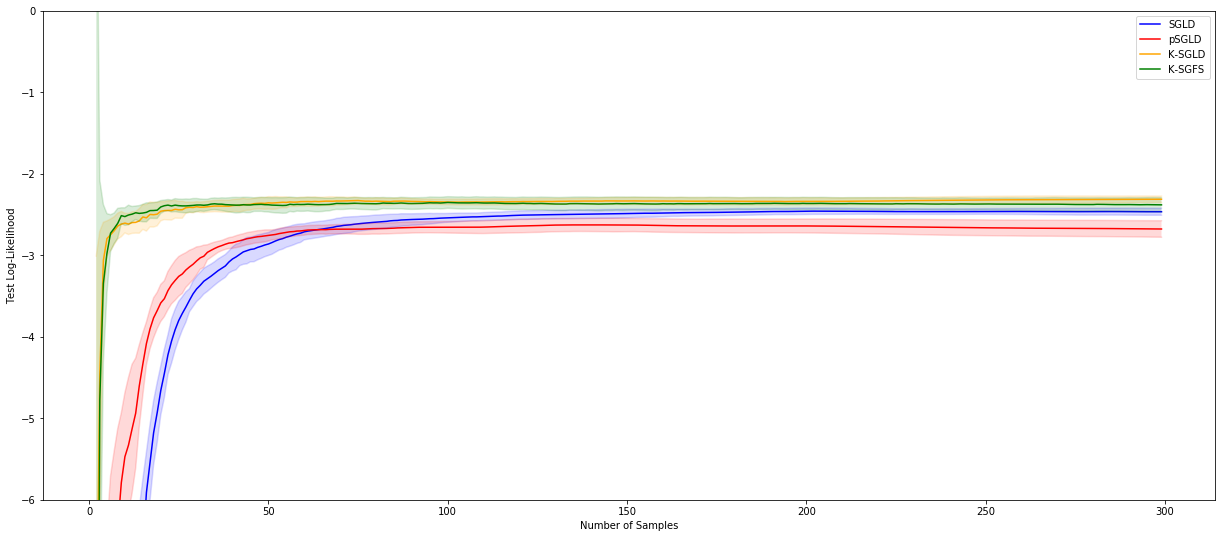

In [46]:
plt.figure(figsize=(21,9))

plt.plot(range(n_samples),ll_meanRunningSGLD,'blue', label = 'SGLD')
plt.plot(range(n_samples),ll_meanRunningPSGLD,'red', label = 'pSGLD')
plt.plot(range(n_samples),ll_meanRunningKSGLD,'orange', label = 'K-SGLD')
plt.plot(range(n_samples),ll_meanRunningKSGFS,'green', label = 'K-SGFS')

plt.plot(range(n_samples),ll_upperSGLD,'blue',alpha=0.15)
plt.plot(range(n_samples),ll_lowerSGLD,'blue', alpha=0.15)
plt.plot(range(n_samples),ll_upperPSGLD,'red',alpha=0.15)
plt.plot(range(n_samples),ll_lowerPSGLD,'red', alpha=0.15)
plt.plot(range(n_samples),ll_upperKSGLD,'orange',alpha=0.15)
plt.plot(range(n_samples),ll_lowerKSGLD,'orange', alpha=0.15)
plt.plot(range(n_samples),ll_upperKSGFS,'green',alpha=0.15)
plt.plot(range(n_samples),ll_lowerKSGFS,'green', alpha=0.15)

plt.fill_between(range(n_samples),ll_lowerSGLD, ll_upperSGLD, facecolor='blue', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerPSGLD, ll_upperPSGLD, facecolor='red', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerKSGLD, ll_upperKSGLD, facecolor='orange', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),ll_lowerKSGFS, ll_upperKSGFS, facecolor='green', alpha=0.15, interpolate=True)

plt.xlabel("Number of Samples")
plt.ylabel("Test Log-Likelihood")
plt.ylim(-6,0)
plt.legend()

### RMSE

In [30]:
rmse_meanRunningSGLD = np.mean(rmse_sgld, 0)
rmse_stdRunningSGLD = np.std(rmse_sgld, 0)
rmse_upperSGLD = rmse_meanRunningSGLD + rmse_stdRunningSGLD
rmse_lowerSGLD = rmse_meanRunningSGLD - rmse_stdRunningSGLD

rmse_meanRunningPSGLD = np.mean(rmse_psgld, 0)
rmse_stdRunningPSGLD = np.std(rmse_psgld, 0)
rmse_upperPSGLD = rmse_meanRunningPSGLD + rmse_stdRunningPSGLD
rmse_lowerPSGLD = rmse_meanRunningPSGLD - rmse_stdRunningPSGLD

rmse_meanRunningKSGLD = np.mean(rmse_ksgld, 0)
rmse_stdRunningKSGLD = np.std(rmse_ksgld, 0)
rmse_upperKSGLD = rmse_meanRunningKSGLD + rmse_stdRunningKSGLD
rmse_lowerKSGLD = rmse_meanRunningKSGLD - rmse_stdRunningKSGLD

rmse_meanRunningKSGFS = np.mean(rmse_ksgfs, 0)
rmse_stdRunningKSGFS = np.std(rmse_ksgfs, 0)
rmse_upperKSGFS = rmse_meanRunningKSGFS + rmse_stdRunningKSGFS
rmse_lowerKSGFS = rmse_meanRunningKSGFS - rmse_stdRunningKSGFS

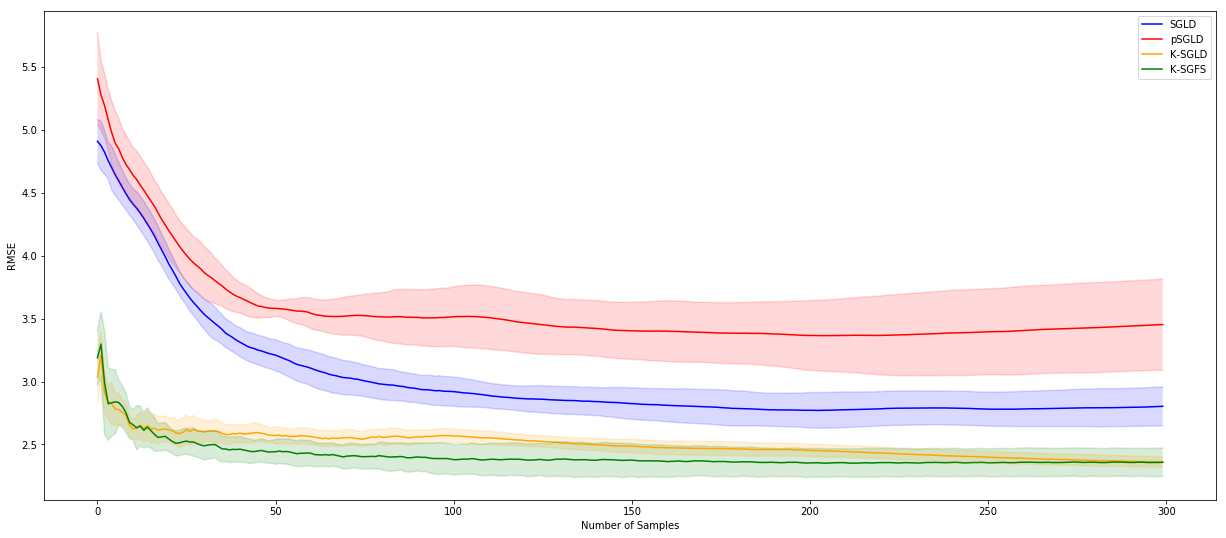

In [45]:
plt.figure(figsize=(21,9))

plt.plot(range(n_samples),rmse_meanRunningSGLD,'blue', label='SGLD')
plt.plot(range(n_samples),rmse_meanRunningPSGLD,'red', label ='pSGLD')
plt.plot(range(n_samples),rmse_meanRunningKSGLD,'orange', label = 'K-SGLD')
plt.plot(range(n_samples),rmse_meanRunningKSGFS,'green', label = 'K-SGFS')

plt.plot(range(n_samples),rmse_upperSGLD,'blue',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerSGLD,'blue', alpha=0.15)
plt.plot(range(n_samples),rmse_upperPSGLD,'red',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerPSGLD,'red', alpha=0.15)
plt.plot(range(n_samples),rmse_upperKSGLD,'orange',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerKSGLD,'orange', alpha=0.15)
plt.plot(range(n_samples),rmse_upperKSGFS,'green',alpha=0.15)
plt.plot(range(n_samples),rmse_lowerKSGFS,'green', alpha=0.15)

plt.fill_between(range(n_samples),rmse_lowerSGLD, rmse_upperSGLD, facecolor='blue', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerPSGLD, rmse_upperPSGLD, facecolor='red', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerKSGLD, rmse_upperKSGLD, facecolor='orange', alpha=0.15, interpolate=True)
plt.fill_between(range(n_samples),rmse_lowerKSGFS, rmse_upperKSGFS, facecolor='green', alpha=0.15, interpolate=True)

plt.xlabel("Number of Samples")
plt.ylabel("RMSE")

plt.legend()
